In [1]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
 
# load all images in a directory into memory
def load_images(path, size=(256,512)):
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]
 
# dataset path
path = 'maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


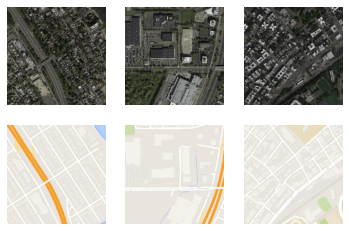

In [2]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [3]:
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [4]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [5]:
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [6]:
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [7]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [8]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [9]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [10]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [11]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)
>1, d1[0.349] d2[0.767] g[86.128]
>2, d1[0.278] d2[0.618] g[83.738]
>3, d1[0.352] d2[0.594] g[72.486]
>4, d1[0.372] d2[0.577] g[76.624]
>5, d1[0.345] d2[0.446] g[66.338]
>6, d1[0.393] d2[0.418] g[71.245]
>7, d1[0.326] d2[0.372] g[70.200]
>8, d1[0.352] d2[0.354] g[64.371]
>9, d1[0.213] d2[0.340] g[53.182]
>10, d1[0.154] d2[0.405] g[45.913]
>11, d1[0.425] d2[0.195] g[45.493]
>12, d1[0.189] d2[0.368] g[55.440]
>13, d1[0.125] d2[0.263] g[54.578]
>14, d1[0.083] d2[0.162] g[51.316]
>15, d1[0.103] d2[0.067] g[46.727]
>16, d1[0.058] d2[0.122] g[45.271]
>17, d1[0.107] d2[0.083] g[38.066]
>18, d1[0.071] d2[0.121] g[41.723]
>19, d1[0.171] d2[0.628] g[19.972]
>20, d1[0.265] d2[0.038] g[38.505]
>21, d1[1.142] d2[0.037] g[23.956]
>22, d1[0.029] d2[0.349] g[32.531]
>23, d1[0.027] d2[0.187] g[32.822]
>24, d1[0.057] d2[0.096] g[30.156]
>25, d1[0.054] d2[0.076] g[26.561]
>26, d1[0.154] d2[0.154] g[26.265]
>27, d1[0.025] d2[0.132] g[23.016]
>28, d1[0.063] d2

>233, d1[0.006] d2[0.008] g[16.556]
>234, d1[0.011] d2[0.004] g[9.720]
>235, d1[0.011] d2[0.003] g[26.935]
>236, d1[0.005] d2[0.029] g[19.105]
>237, d1[0.011] d2[0.007] g[10.045]
>238, d1[0.007] d2[0.005] g[11.457]
>239, d1[0.007] d2[0.003] g[8.839]
>240, d1[0.013] d2[0.004] g[9.096]
>241, d1[0.009] d2[0.002] g[19.133]
>242, d1[0.006] d2[0.003] g[11.096]
>243, d1[0.005] d2[0.002] g[16.596]
>244, d1[0.004] d2[0.004] g[14.653]
>245, d1[0.009] d2[0.005] g[11.518]
>246, d1[0.054] d2[0.003] g[7.703]
>247, d1[0.006] d2[0.003] g[17.983]
>248, d1[0.004] d2[0.008] g[17.459]
>249, d1[0.009] d2[0.008] g[19.085]
>250, d1[0.024] d2[0.007] g[17.107]
>251, d1[0.004] d2[0.010] g[17.707]
>252, d1[0.005] d2[0.629] g[13.381]
>253, d1[1.593] d2[0.026] g[15.453]
>254, d1[0.842] d2[0.490] g[13.425]
>255, d1[0.749] d2[0.386] g[8.364]
>256, d1[0.177] d2[0.111] g[12.598]
>257, d1[0.716] d2[0.159] g[9.161]
>258, d1[0.245] d2[0.187] g[7.943]
>259, d1[0.068] d2[0.139] g[20.629]
>260, d1[0.424] d2[0.116] g[6.703]


>464, d1[0.060] d2[0.016] g[7.089]
>465, d1[0.009] d2[0.007] g[8.185]
>466, d1[0.006] d2[0.006] g[9.858]
>467, d1[0.021] d2[0.007] g[7.241]
>468, d1[0.004] d2[0.010] g[6.799]
>469, d1[0.006] d2[0.007] g[7.721]
>470, d1[0.022] d2[0.009] g[10.557]
>471, d1[0.013] d2[0.007] g[6.960]
>472, d1[0.072] d2[0.014] g[6.006]
>473, d1[0.004] d2[0.007] g[18.024]
>474, d1[0.002] d2[0.010] g[12.485]
>475, d1[0.007] d2[0.005] g[8.141]
>476, d1[0.003] d2[0.006] g[10.438]
>477, d1[0.004] d2[0.018] g[13.301]
>478, d1[0.006] d2[0.009] g[7.848]
>479, d1[0.002] d2[0.017] g[9.733]
>480, d1[0.004] d2[0.005] g[8.068]
>481, d1[0.002] d2[0.009] g[9.944]
>482, d1[0.012] d2[0.005] g[8.635]
>483, d1[0.003] d2[0.009] g[10.545]
>484, d1[0.004] d2[0.006] g[7.821]
>485, d1[0.006] d2[0.007] g[6.910]
>486, d1[0.002] d2[0.005] g[8.384]
>487, d1[0.006] d2[0.010] g[6.584]
>488, d1[0.004] d2[0.005] g[7.987]
>489, d1[0.061] d2[0.004] g[20.572]
>490, d1[0.001] d2[0.016] g[13.094]
>491, d1[0.002] d2[0.020] g[8.025]
>492, d1[0.0

>695, d1[0.778] d2[1.023] g[6.951]
>696, d1[0.019] d2[0.131] g[21.508]
>697, d1[1.326] d2[1.128] g[14.691]
>698, d1[0.073] d2[0.409] g[17.392]
>699, d1[0.034] d2[0.122] g[17.826]
>700, d1[0.221] d2[0.041] g[17.749]
>701, d1[0.779] d2[0.066] g[9.787]
>702, d1[0.071] d2[0.165] g[8.982]
>703, d1[0.158] d2[0.009] g[12.762]
>704, d1[0.013] d2[0.009] g[11.106]
>705, d1[0.020] d2[0.026] g[19.701]
>706, d1[0.017] d2[0.020] g[7.354]
>707, d1[0.002] d2[0.020] g[15.700]
>708, d1[0.005] d2[0.012] g[17.208]
>709, d1[0.009] d2[0.024] g[12.158]
>710, d1[0.004] d2[0.007] g[13.998]
>711, d1[0.005] d2[0.009] g[24.100]
>712, d1[0.017] d2[0.006] g[16.691]
>713, d1[0.024] d2[0.003] g[7.871]
>714, d1[0.006] d2[0.011] g[16.797]
>715, d1[0.020] d2[0.009] g[7.730]
>716, d1[0.006] d2[0.006] g[12.316]
>717, d1[0.052] d2[0.006] g[6.988]
>718, d1[0.022] d2[0.003] g[11.887]
>719, d1[0.014] d2[0.009] g[7.799]
>720, d1[0.020] d2[0.022] g[20.271]
>721, d1[0.003] d2[0.011] g[11.223]
>722, d1[0.003] d2[0.008] g[11.880]


>926, d1[0.033] d2[0.018] g[7.132]
>927, d1[0.003] d2[0.036] g[13.133]
>928, d1[0.422] d2[0.018] g[8.870]
>929, d1[0.004] d2[0.056] g[7.344]
>930, d1[0.001] d2[0.189] g[16.050]
>931, d1[0.004] d2[0.020] g[24.049]
>932, d1[0.003] d2[0.032] g[7.345]
>933, d1[0.002] d2[0.025] g[12.635]
>934, d1[0.004] d2[1.372] g[11.497]
>935, d1[0.027] d2[0.006] g[10.681]
>936, d1[0.043] d2[0.006] g[15.051]
>937, d1[1.058] d2[0.476] g[11.275]
>938, d1[1.231] d2[0.107] g[6.551]
>939, d1[0.017] d2[0.830] g[22.472]
>940, d1[0.021] d2[0.036] g[11.753]
>941, d1[0.145] d2[0.014] g[8.941]
>942, d1[0.226] d2[0.015] g[8.925]
>943, d1[0.030] d2[0.039] g[8.991]
>944, d1[1.967] d2[0.649] g[4.260]
>945, d1[0.080] d2[0.227] g[7.367]
>946, d1[0.034] d2[0.185] g[18.004]
>947, d1[0.161] d2[0.138] g[11.192]
>948, d1[0.014] d2[0.039] g[18.314]
>949, d1[0.017] d2[0.028] g[15.055]
>950, d1[1.068] d2[0.094] g[7.077]
>951, d1[0.016] d2[0.205] g[8.278]
>952, d1[0.258] d2[0.130] g[7.340]
>953, d1[0.005] d2[0.128] g[16.459]
>954,

>1153, d1[0.001] d2[0.036] g[11.609]
>1154, d1[0.000] d2[0.001] g[13.691]
>1155, d1[0.003] d2[0.001] g[8.053]
>1156, d1[0.000] d2[0.001] g[13.354]
>1157, d1[0.001] d2[0.001] g[9.508]
>1158, d1[0.001] d2[0.001] g[13.524]
>1159, d1[0.001] d2[0.002] g[15.711]
>1160, d1[0.002] d2[0.001] g[13.535]
>1161, d1[0.000] d2[0.002] g[13.017]
>1162, d1[0.001] d2[0.001] g[13.247]
>1163, d1[0.016] d2[0.003] g[11.987]
>1164, d1[0.001] d2[0.001] g[8.279]
>1165, d1[0.006] d2[0.001] g[7.999]
>1166, d1[0.001] d2[0.001] g[7.690]
>1167, d1[0.002] d2[0.003] g[13.401]
>1168, d1[0.008] d2[0.002] g[9.243]
>1169, d1[0.002] d2[0.001] g[7.913]
>1170, d1[0.001] d2[0.001] g[9.490]
>1171, d1[0.003] d2[0.001] g[8.183]
>1172, d1[0.002] d2[0.001] g[8.674]
>1173, d1[0.005] d2[0.001] g[7.611]
>1174, d1[0.003] d2[0.001] g[7.679]
>1175, d1[0.001] d2[0.001] g[9.595]
>1176, d1[0.001] d2[0.001] g[10.990]
>1177, d1[0.000] d2[0.003] g[15.018]
>1178, d1[0.001] d2[0.001] g[7.588]
>1179, d1[0.001] d2[0.012] g[12.351]
>1180, d1[0.001

>1378, d1[0.746] d2[0.926] g[5.972]
>1379, d1[0.003] d2[0.106] g[12.874]
>1380, d1[0.254] d2[0.004] g[8.241]
>1381, d1[0.012] d2[0.005] g[13.952]
>1382, d1[0.014] d2[0.039] g[12.563]
>1383, d1[0.002] d2[0.007] g[11.539]
>1384, d1[0.007] d2[0.003] g[20.789]
>1385, d1[0.036] d2[0.051] g[10.033]
>1386, d1[0.004] d2[0.003] g[10.698]
>1387, d1[0.003] d2[0.002] g[10.559]
>1388, d1[0.005] d2[0.003] g[14.578]
>1389, d1[0.010] d2[0.004] g[15.738]
>1390, d1[0.001] d2[0.005] g[9.727]
>1391, d1[0.011] d2[0.010] g[7.870]
>1392, d1[0.016] d2[0.001] g[9.127]
>1393, d1[0.002] d2[0.004] g[14.006]
>1394, d1[0.028] d2[0.007] g[12.465]
>1395, d1[0.002] d2[0.007] g[18.094]
>1396, d1[0.001] d2[0.003] g[9.168]
>1397, d1[0.007] d2[0.005] g[9.268]
>1398, d1[0.001] d2[0.005] g[14.085]
>1399, d1[0.002] d2[0.002] g[10.945]
>1400, d1[0.005] d2[0.004] g[10.013]
>1401, d1[0.002] d2[0.002] g[8.349]
>1402, d1[0.058] d2[0.001] g[7.842]
>1403, d1[0.001] d2[0.006] g[8.664]
>1404, d1[0.001] d2[0.003] g[7.976]
>1405, d1[0.

>1604, d1[0.000] d2[0.000] g[13.262]
>1605, d1[0.000] d2[0.000] g[14.761]
>1606, d1[0.001] d2[0.001] g[7.534]
>1607, d1[0.001] d2[0.001] g[6.684]
>1608, d1[0.000] d2[0.001] g[8.180]
>1609, d1[0.000] d2[0.000] g[12.168]
>1610, d1[0.001] d2[0.001] g[21.179]
>1611, d1[0.000] d2[0.001] g[8.505]
>1612, d1[0.000] d2[0.001] g[24.738]
>1613, d1[0.000] d2[0.001] g[10.527]
>1614, d1[0.001] d2[0.001] g[20.392]
>1615, d1[0.000] d2[0.001] g[9.586]
>1616, d1[0.000] d2[0.001] g[14.261]
>1617, d1[0.001] d2[0.001] g[8.165]
>1618, d1[0.000] d2[0.001] g[8.950]
>1619, d1[0.001] d2[0.002] g[9.993]
>1620, d1[0.000] d2[0.001] g[10.684]
>1621, d1[0.003] d2[0.001] g[6.933]
>1622, d1[0.000] d2[0.001] g[6.840]
>1623, d1[0.000] d2[0.001] g[6.571]
>1624, d1[0.000] d2[0.003] g[14.180]
>1625, d1[0.003] d2[0.001] g[20.392]
>1626, d1[0.001] d2[0.001] g[6.611]
>1627, d1[0.001] d2[0.009] g[7.609]
>1628, d1[0.001] d2[0.009] g[7.898]
>1629, d1[0.008] d2[0.003] g[6.676]
>1630, d1[0.000] d2[0.001] g[8.735]
>1631, d1[0.000] 

>1830, d1[0.002] d2[0.024] g[12.099]
>1831, d1[0.009] d2[0.043] g[21.191]
>1832, d1[0.004] d2[0.005] g[9.882]
>1833, d1[0.007] d2[0.002] g[11.534]
>1834, d1[0.230] d2[0.314] g[11.359]
>1835, d1[0.133] d2[0.010] g[7.656]
>1836, d1[0.004] d2[0.017] g[9.477]
>1837, d1[0.009] d2[0.003] g[8.232]
>1838, d1[0.014] d2[0.023] g[7.070]
>1839, d1[0.003] d2[0.005] g[9.794]
>1840, d1[0.007] d2[0.003] g[7.808]
>1841, d1[0.013] d2[0.009] g[8.648]
>1842, d1[0.001] d2[0.003] g[17.814]
>1843, d1[0.004] d2[0.004] g[7.407]
>1844, d1[0.006] d2[0.033] g[6.792]
>1845, d1[0.002] d2[0.024] g[7.116]
>1846, d1[0.005] d2[0.004] g[8.009]
>1847, d1[0.008] d2[0.002] g[10.162]
>1848, d1[0.014] d2[0.001] g[7.383]
>1849, d1[0.003] d2[0.002] g[7.994]
>1850, d1[0.001] d2[0.002] g[8.486]
>1851, d1[0.001] d2[0.001] g[8.501]
>1852, d1[0.001] d2[0.001] g[9.848]
>1853, d1[0.003] d2[0.001] g[11.116]
>1854, d1[0.005] d2[0.001] g[6.725]
>1855, d1[0.023] d2[0.001] g[5.868]
>1856, d1[0.002] d2[0.001] g[6.726]
>1857, d1[0.014] d2[0

>2056, d1[0.009] d2[0.001] g[6.520]
>2057, d1[0.002] d2[0.001] g[6.813]
>2058, d1[0.006] d2[0.001] g[7.721]
>2059, d1[0.004] d2[0.001] g[6.863]
>2060, d1[0.001] d2[0.001] g[10.036]
>2061, d1[0.003] d2[0.001] g[7.398]
>2062, d1[0.002] d2[0.001] g[9.726]
>2063, d1[0.001] d2[0.001] g[9.484]
>2064, d1[0.001] d2[0.001] g[10.394]
>2065, d1[0.003] d2[0.001] g[6.441]
>2066, d1[0.001] d2[0.001] g[8.668]
>2067, d1[0.002] d2[0.001] g[6.984]
>2068, d1[0.001] d2[0.001] g[11.112]
>2069, d1[0.002] d2[0.001] g[6.771]
>2070, d1[0.001] d2[0.003] g[6.448]
>2071, d1[0.001] d2[0.001] g[14.052]
>2072, d1[0.001] d2[0.001] g[7.161]
>2073, d1[0.001] d2[0.001] g[6.872]
>2074, d1[0.002] d2[0.001] g[16.522]
>2075, d1[0.001] d2[0.001] g[18.113]
>2076, d1[0.002] d2[0.001] g[6.967]
>2077, d1[0.005] d2[0.001] g[6.742]
>2078, d1[0.001] d2[0.001] g[8.870]
>2079, d1[0.002] d2[0.001] g[11.984]
>2080, d1[0.001] d2[0.001] g[7.017]
>2081, d1[0.004] d2[0.001] g[6.951]
>2082, d1[0.002] d2[0.001] g[5.982]
>2083, d1[0.002] d2[0

>2282, d1[0.000] d2[0.001] g[9.562]
>2283, d1[0.000] d2[0.004] g[10.165]
>2284, d1[0.004] d2[0.002] g[6.756]
>2285, d1[0.002] d2[0.001] g[17.277]
>2286, d1[0.000] d2[0.004] g[12.116]
>2287, d1[0.001] d2[0.002] g[7.016]
>2288, d1[0.001] d2[0.002] g[7.761]
>2289, d1[0.000] d2[0.003] g[7.682]
>2290, d1[0.002] d2[0.002] g[14.547]
>2291, d1[0.001] d2[0.001] g[7.723]
>2292, d1[0.001] d2[0.002] g[7.131]
>2293, d1[0.000] d2[0.001] g[14.147]
>2294, d1[0.001] d2[0.002] g[7.146]
>2295, d1[0.000] d2[0.000] g[5.751]
>2296, d1[0.000] d2[0.001] g[9.732]
>2297, d1[0.001] d2[0.001] g[6.344]
>2298, d1[0.002] d2[0.001] g[12.005]
>2299, d1[0.001] d2[0.002] g[8.586]
>2300, d1[0.001] d2[0.002] g[12.983]
>2301, d1[0.001] d2[0.001] g[4.839]
>2302, d1[0.000] d2[0.002] g[10.164]
>2303, d1[0.000] d2[0.001] g[10.537]
>2304, d1[0.001] d2[0.001] g[6.495]
>2305, d1[0.002] d2[0.001] g[7.377]
>2306, d1[0.000] d2[0.001] g[15.476]
>2307, d1[0.001] d2[0.001] g[9.952]
>2308, d1[0.001] d2[0.001] g[6.365]
>2309, d1[0.001] d

>2508, d1[0.001] d2[0.000] g[7.788]
>2509, d1[0.001] d2[0.000] g[7.538]
>2510, d1[0.000] d2[0.001] g[6.850]
>2511, d1[0.000] d2[0.001] g[10.280]
>2512, d1[0.000] d2[0.001] g[12.276]
>2513, d1[0.001] d2[0.001] g[7.229]
>2514, d1[0.000] d2[0.001] g[10.843]
>2515, d1[0.000] d2[0.001] g[6.834]
>2516, d1[0.000] d2[0.001] g[10.790]
>2517, d1[0.001] d2[0.001] g[14.472]
>2518, d1[0.001] d2[0.001] g[8.076]
>2519, d1[0.000] d2[0.002] g[13.818]
>2520, d1[0.000] d2[0.002] g[7.051]
>2521, d1[0.000] d2[0.002] g[8.514]
>2522, d1[0.001] d2[0.001] g[19.907]
>2523, d1[0.000] d2[0.001] g[6.406]
>2524, d1[0.001] d2[0.001] g[5.441]
>2525, d1[0.000] d2[0.002] g[10.572]
>2526, d1[0.000] d2[0.001] g[4.073]
>2527, d1[0.000] d2[0.012] g[15.973]
>2528, d1[0.000] d2[0.001] g[13.596]
>2529, d1[0.012] d2[0.001] g[7.727]
>2530, d1[0.000] d2[0.013] g[7.008]
>2531, d1[0.000] d2[0.021] g[8.013]
>2532, d1[0.000] d2[0.019] g[26.571]
>2533, d1[0.000] d2[0.001] g[9.808]
>2534, d1[0.002] d2[0.000] g[7.898]
>2535, d1[0.002] 

>2734, d1[0.001] d2[0.000] g[8.689]
>2735, d1[0.001] d2[0.000] g[4.365]
>2736, d1[0.000] d2[0.000] g[13.359]
>2737, d1[0.001] d2[0.000] g[5.516]
>2738, d1[0.003] d2[0.000] g[6.584]
>2739, d1[0.001] d2[0.000] g[22.799]
>2740, d1[0.000] d2[0.000] g[18.754]
>2741, d1[0.000] d2[0.000] g[23.364]
>2742, d1[0.001] d2[0.000] g[16.536]
>2743, d1[0.001] d2[0.000] g[5.442]
>2744, d1[0.000] d2[0.001] g[8.992]
>2745, d1[0.001] d2[0.000] g[5.166]
>2746, d1[0.000] d2[0.000] g[7.358]
>2747, d1[0.002] d2[0.000] g[12.616]
>2748, d1[0.000] d2[0.001] g[7.317]
>2749, d1[0.000] d2[0.001] g[12.754]
>2750, d1[0.000] d2[0.000] g[10.819]
>2751, d1[0.000] d2[0.000] g[8.843]
>2752, d1[0.000] d2[0.000] g[10.237]
>2753, d1[0.000] d2[0.000] g[7.187]
>2754, d1[0.000] d2[0.000] g[6.427]
>2755, d1[0.001] d2[0.000] g[6.884]
>2756, d1[0.000] d2[0.000] g[9.835]
>2757, d1[0.001] d2[0.000] g[14.203]
>2758, d1[0.001] d2[0.000] g[8.235]
>2759, d1[0.000] d2[0.000] g[7.735]
>2760, d1[0.000] d2[0.000] g[6.644]
>2761, d1[0.000] d

>2960, d1[0.000] d2[0.000] g[11.586]
>2961, d1[0.002] d2[0.000] g[7.651]
>2962, d1[0.000] d2[0.000] g[7.545]
>2963, d1[0.000] d2[0.000] g[6.997]
>2964, d1[0.000] d2[0.000] g[19.078]
>2965, d1[0.000] d2[0.000] g[6.006]
>2966, d1[0.000] d2[0.000] g[8.067]
>2967, d1[0.000] d2[0.000] g[6.726]
>2968, d1[0.000] d2[0.000] g[6.665]
>2969, d1[0.000] d2[0.000] g[16.273]
>2970, d1[0.000] d2[0.000] g[6.834]
>2971, d1[0.000] d2[0.000] g[18.186]
>2972, d1[0.000] d2[0.000] g[7.557]
>2973, d1[0.000] d2[0.000] g[6.632]
>2974, d1[0.000] d2[0.000] g[9.982]
>2975, d1[0.001] d2[0.000] g[6.560]
>2976, d1[0.000] d2[0.000] g[10.534]
>2977, d1[0.000] d2[0.000] g[10.844]
>2978, d1[0.000] d2[0.000] g[8.095]
>2979, d1[0.000] d2[0.000] g[8.477]
>2980, d1[0.001] d2[0.000] g[7.187]
>2981, d1[0.000] d2[0.000] g[8.032]
>2982, d1[0.000] d2[0.000] g[10.158]
>2983, d1[0.000] d2[0.000] g[8.791]
>2984, d1[0.000] d2[0.000] g[15.863]
>2985, d1[0.000] d2[0.001] g[15.528]
>2986, d1[0.000] d2[0.000] g[8.270]
>2987, d1[0.000] d2

>3185, d1[0.005] d2[0.000] g[10.010]
>3186, d1[0.002] d2[0.000] g[8.031]
>3187, d1[0.003] d2[0.000] g[8.044]
>3188, d1[0.029] d2[0.000] g[7.237]
>3189, d1[0.001] d2[0.003] g[8.555]
>3190, d1[0.001] d2[0.001] g[7.545]
>3191, d1[0.001] d2[0.025] g[9.275]
>3192, d1[0.001] d2[0.001] g[7.488]
>3193, d1[0.011] d2[0.001] g[7.819]
>3194, d1[0.004] d2[0.000] g[8.881]
>3195, d1[0.003] d2[0.000] g[17.213]
>3196, d1[0.002] d2[0.000] g[10.132]
>3197, d1[0.001] d2[0.000] g[9.444]
>3198, d1[0.011] d2[0.002] g[10.635]
>3199, d1[0.001] d2[0.000] g[7.486]
>3200, d1[0.001] d2[0.001] g[5.337]
>3201, d1[0.001] d2[0.001] g[8.369]
>3202, d1[0.001] d2[0.000] g[14.019]
>3203, d1[0.001] d2[0.005] g[8.989]
>3204, d1[0.001] d2[0.000] g[7.580]
>3205, d1[0.012] d2[0.002] g[14.415]
>3206, d1[0.001] d2[0.000] g[7.500]
>3207, d1[0.000] d2[0.000] g[5.848]
>3208, d1[0.000] d2[0.000] g[5.835]
>3209, d1[0.000] d2[0.000] g[17.046]
>3210, d1[0.002] d2[0.000] g[7.330]
>3211, d1[0.002] d2[0.000] g[7.306]
>3212, d1[0.000] d2[0

>3411, d1[0.000] d2[0.000] g[12.343]
>3412, d1[0.000] d2[0.000] g[5.776]
>3413, d1[0.000] d2[0.000] g[6.239]
>3414, d1[0.000] d2[0.000] g[8.502]
>3415, d1[0.000] d2[0.001] g[12.647]
>3416, d1[0.000] d2[0.000] g[7.657]
>3417, d1[0.000] d2[0.000] g[13.512]
>3418, d1[0.000] d2[0.000] g[6.977]
>3419, d1[0.000] d2[0.000] g[8.454]
>3420, d1[0.001] d2[0.000] g[6.728]
>3421, d1[0.000] d2[0.000] g[13.906]
>3422, d1[0.000] d2[0.002] g[8.170]
>3423, d1[0.000] d2[0.000] g[6.595]
>3424, d1[0.000] d2[0.000] g[7.690]
>3425, d1[0.000] d2[0.000] g[6.838]
>3426, d1[0.000] d2[0.001] g[12.945]
>3427, d1[0.000] d2[0.000] g[7.631]
>3428, d1[0.000] d2[0.000] g[6.354]
>3429, d1[0.003] d2[0.000] g[6.783]
>3430, d1[0.000] d2[0.000] g[5.008]
>3431, d1[0.000] d2[0.000] g[4.158]
>3432, d1[0.000] d2[0.000] g[14.994]
>3433, d1[0.000] d2[0.000] g[9.022]
>3434, d1[0.000] d2[0.000] g[11.688]
>3435, d1[0.000] d2[0.000] g[7.158]
>3436, d1[0.000] d2[0.000] g[5.735]
>3437, d1[0.000] d2[0.001] g[28.140]
>3438, d1[0.002] d2[

>3637, d1[0.000] d2[0.000] g[10.860]
>3638, d1[0.000] d2[0.000] g[6.339]
>3639, d1[0.000] d2[0.000] g[13.762]
>3640, d1[0.000] d2[0.000] g[9.625]
>3641, d1[0.000] d2[0.000] g[10.874]
>3642, d1[0.000] d2[0.000] g[6.951]
>3643, d1[0.000] d2[0.000] g[6.528]
>3644, d1[0.000] d2[0.000] g[7.767]
>3645, d1[0.000] d2[0.000] g[6.526]
>3646, d1[0.000] d2[0.000] g[7.625]
>3647, d1[0.000] d2[0.000] g[7.508]
>3648, d1[0.000] d2[0.000] g[8.148]
>3649, d1[0.000] d2[0.000] g[6.909]
>3650, d1[0.000] d2[0.000] g[6.648]
>3651, d1[0.001] d2[0.000] g[6.633]
>3652, d1[0.000] d2[0.000] g[6.322]
>3653, d1[0.000] d2[0.000] g[14.524]
>3654, d1[0.000] d2[0.000] g[6.437]
>3655, d1[0.000] d2[0.000] g[8.072]
>3656, d1[0.000] d2[0.000] g[7.208]
>3657, d1[0.000] d2[0.000] g[7.067]
>3658, d1[0.000] d2[0.000] g[6.690]
>3659, d1[0.000] d2[0.000] g[8.068]
>3660, d1[0.000] d2[0.000] g[6.710]
>3661, d1[0.001] d2[0.000] g[9.475]
>3662, d1[0.000] d2[0.000] g[9.826]
>3663, d1[0.000] d2[0.000] g[6.486]
>3664, d1[0.000] d2[0.00

>3863, d1[0.000] d2[0.001] g[7.807]
>3864, d1[0.000] d2[0.004] g[5.327]
>3865, d1[0.001] d2[0.000] g[7.447]
>3866, d1[0.001] d2[0.000] g[7.386]
>3867, d1[0.000] d2[0.000] g[11.212]
>3868, d1[0.000] d2[0.000] g[6.351]
>3869, d1[0.000] d2[0.000] g[8.099]
>3870, d1[0.000] d2[0.000] g[7.039]
>3871, d1[0.000] d2[0.000] g[9.110]
>3872, d1[0.001] d2[0.001] g[7.693]
>3873, d1[0.000] d2[0.000] g[7.914]
>3874, d1[0.003] d2[0.001] g[6.763]
>3875, d1[0.001] d2[0.001] g[11.456]
>3876, d1[0.001] d2[0.000] g[19.423]
>3877, d1[0.000] d2[0.000] g[5.955]
>3878, d1[0.000] d2[0.003] g[8.295]
>3879, d1[0.000] d2[0.000] g[5.793]
>3880, d1[0.001] d2[0.000] g[7.230]
>3881, d1[0.000] d2[0.000] g[4.680]
>3882, d1[0.000] d2[0.000] g[6.945]
>3883, d1[0.000] d2[0.000] g[8.674]
>3884, d1[0.000] d2[0.004] g[11.035]
>3885, d1[0.000] d2[0.000] g[6.925]
>3886, d1[0.001] d2[0.001] g[6.516]
>3887, d1[0.000] d2[0.000] g[6.566]
>3888, d1[0.000] d2[0.000] g[7.470]
>3889, d1[0.001] d2[0.000] g[7.223]
>3890, d1[0.006] d2[0.00

>4089, d1[0.000] d2[0.001] g[7.640]
>4090, d1[0.001] d2[0.001] g[6.645]
>4091, d1[0.001] d2[0.001] g[9.042]
>4092, d1[0.000] d2[0.000] g[12.814]
>4093, d1[0.001] d2[0.012] g[5.064]
>4094, d1[0.001] d2[0.001] g[15.293]
>4095, d1[0.001] d2[0.001] g[8.413]
>4096, d1[0.001] d2[0.001] g[6.713]
>4097, d1[0.001] d2[0.000] g[13.950]
>4098, d1[0.001] d2[0.000] g[13.107]
>4099, d1[0.075] d2[0.050] g[3.569]
>4100, d1[0.000] d2[0.001] g[11.805]
>4101, d1[0.001] d2[0.000] g[6.932]
>4102, d1[0.005] d2[0.001] g[10.108]
>4103, d1[0.002] d2[0.001] g[12.469]
>4104, d1[0.001] d2[0.001] g[8.420]
>4105, d1[0.001] d2[0.000] g[6.456]
>4106, d1[0.003] d2[0.001] g[11.217]
>4107, d1[0.001] d2[0.000] g[6.675]
>4108, d1[0.001] d2[0.000] g[8.534]
>4109, d1[0.001] d2[0.001] g[6.145]
>4110, d1[0.001] d2[0.001] g[9.131]
>4111, d1[0.000] d2[0.000] g[6.802]
>4112, d1[0.000] d2[0.000] g[5.711]
>4113, d1[0.000] d2[0.000] g[5.810]
>4114, d1[0.000] d2[0.001] g[6.228]
>4115, d1[0.001] d2[0.002] g[8.211]
>4116, d1[0.000] d2[

>4315, d1[0.000] d2[0.000] g[5.840]
>4316, d1[0.004] d2[0.000] g[6.199]
>4317, d1[0.000] d2[0.001] g[19.257]
>4318, d1[0.000] d2[0.000] g[6.871]
>4319, d1[0.000] d2[0.001] g[11.489]
>4320, d1[0.001] d2[0.000] g[5.659]
>4321, d1[0.000] d2[0.000] g[8.567]
>4322, d1[0.000] d2[0.001] g[8.322]
>4323, d1[0.002] d2[0.002] g[6.782]
>4324, d1[0.000] d2[0.001] g[15.961]
>4325, d1[0.005] d2[0.003] g[17.574]
>4326, d1[0.000] d2[0.001] g[7.489]
>4327, d1[0.000] d2[0.001] g[6.759]
>4328, d1[0.000] d2[0.000] g[7.301]
>4329, d1[0.000] d2[0.001] g[10.546]
>4330, d1[0.000] d2[0.001] g[11.850]
>4331, d1[0.000] d2[0.001] g[8.189]
>4332, d1[0.000] d2[0.003] g[7.977]
>4333, d1[0.002] d2[0.002] g[7.060]
>4334, d1[0.000] d2[0.002] g[11.086]
>4335, d1[0.000] d2[0.001] g[6.754]
>4336, d1[0.000] d2[0.006] g[11.849]
>4337, d1[0.000] d2[0.000] g[9.101]
>4338, d1[0.000] d2[0.000] g[8.054]
>4339, d1[0.000] d2[0.002] g[11.296]
>4340, d1[0.000] d2[0.014] g[6.885]
>4341, d1[0.001] d2[0.000] g[6.061]
>4342, d1[0.002] d2

>4541, d1[0.001] d2[0.014] g[18.170]
>4542, d1[0.016] d2[0.463] g[8.846]
>4543, d1[0.019] d2[0.001] g[14.666]
>4544, d1[0.007] d2[0.001] g[22.202]
>4545, d1[0.055] d2[0.000] g[14.418]
>4546, d1[0.119] d2[0.002] g[8.561]
>4547, d1[0.009] d2[0.002] g[6.826]
>4548, d1[0.010] d2[0.007] g[6.850]
>4549, d1[0.001] d2[0.016] g[7.962]
>4550, d1[0.020] d2[0.000] g[14.556]
>4551, d1[0.003] d2[0.023] g[7.311]
>4552, d1[0.705] d2[0.008] g[5.987]
>4553, d1[0.000] d2[1.441] g[7.930]
>4554, d1[0.006] d2[0.003] g[11.160]
>4555, d1[0.107] d2[0.459] g[8.895]
>4556, d1[0.301] d2[0.308] g[21.635]
>4557, d1[0.511] d2[0.001] g[28.503]
>4558, d1[0.640] d2[0.018] g[29.374]
>4559, d1[0.044] d2[0.004] g[20.550]
>4560, d1[0.000] d2[0.022] g[13.248]
>4561, d1[0.000] d2[0.008] g[9.099]
>4562, d1[0.000] d2[0.006] g[7.946]
>4563, d1[0.000] d2[0.003] g[18.232]
>4564, d1[0.000] d2[0.002] g[10.254]
>4565, d1[0.000] d2[0.139] g[6.292]
>4566, d1[0.000] d2[0.001] g[17.287]
>4567, d1[0.001] d2[0.002] g[7.741]
>4568, d1[0.00

>4767, d1[0.000] d2[0.000] g[9.632]
>4768, d1[0.000] d2[0.000] g[6.676]
>4769, d1[0.000] d2[0.000] g[8.521]
>4770, d1[0.000] d2[0.000] g[15.301]
>4771, d1[0.000] d2[0.000] g[6.555]
>4772, d1[0.000] d2[0.000] g[6.776]
>4773, d1[0.000] d2[0.000] g[7.242]
>4774, d1[0.000] d2[0.000] g[8.489]
>4775, d1[0.000] d2[0.000] g[6.800]
>4776, d1[0.000] d2[0.000] g[8.126]
>4777, d1[0.000] d2[0.000] g[9.375]
>4778, d1[0.000] d2[0.000] g[3.915]
>4779, d1[0.000] d2[0.000] g[8.955]
>4780, d1[0.000] d2[0.000] g[9.313]
>4781, d1[0.000] d2[0.000] g[6.419]
>4782, d1[0.000] d2[0.000] g[6.089]
>4783, d1[0.000] d2[0.000] g[8.129]
>4784, d1[0.002] d2[0.000] g[5.842]
>4785, d1[0.001] d2[0.000] g[13.784]
>4786, d1[0.001] d2[0.000] g[11.996]
>4787, d1[0.000] d2[0.000] g[6.718]
>4788, d1[0.000] d2[0.000] g[6.792]
>4789, d1[0.001] d2[0.000] g[5.094]
>4790, d1[0.000] d2[0.000] g[8.105]
>4791, d1[0.000] d2[0.000] g[12.873]
>4792, d1[0.000] d2[0.000] g[6.337]
>4793, d1[0.000] d2[0.000] g[22.528]
>4794, d1[0.000] d2[0.0

>4993, d1[0.001] d2[0.005] g[8.966]
>4994, d1[0.001] d2[0.001] g[8.923]
>4995, d1[0.000] d2[0.001] g[6.566]
>4996, d1[0.001] d2[0.000] g[15.109]
>4997, d1[0.001] d2[0.007] g[12.217]
>4998, d1[0.001] d2[0.001] g[7.180]
>4999, d1[0.001] d2[0.002] g[7.700]
>5000, d1[0.001] d2[0.001] g[7.161]
>5001, d1[0.000] d2[0.002] g[11.297]
>5002, d1[0.001] d2[0.002] g[6.719]
>5003, d1[0.000] d2[0.006] g[5.995]
>5004, d1[0.001] d2[0.001] g[6.223]
>5005, d1[0.002] d2[0.009] g[6.884]
>5006, d1[0.001] d2[0.000] g[8.057]
>5007, d1[0.022] d2[0.000] g[2.581]
>5008, d1[0.001] d2[0.002] g[10.132]
>5009, d1[0.000] d2[0.003] g[7.747]
>5010, d1[0.002] d2[0.001] g[6.556]
>5011, d1[0.001] d2[0.001] g[6.336]
>5012, d1[0.001] d2[0.001] g[9.889]
>5013, d1[0.001] d2[0.002] g[8.612]
>5014, d1[0.003] d2[0.000] g[4.838]
>5015, d1[0.001] d2[0.001] g[11.577]
>5016, d1[0.001] d2[0.001] g[12.374]
>5017, d1[0.001] d2[0.001] g[9.937]
>5018, d1[0.001] d2[0.002] g[7.252]
>5019, d1[0.001] d2[0.002] g[6.489]
>5020, d1[0.001] d2[0.

>5219, d1[0.000] d2[0.000] g[5.337]
>5220, d1[0.000] d2[0.000] g[6.725]
>5221, d1[0.001] d2[0.000] g[10.656]
>5222, d1[0.000] d2[0.000] g[17.738]
>5223, d1[0.001] d2[0.000] g[7.017]
>5224, d1[0.066] d2[0.004] g[17.643]
>5225, d1[0.000] d2[0.001] g[14.352]
>5226, d1[0.000] d2[0.011] g[6.059]
>5227, d1[0.000] d2[0.001] g[8.248]
>5228, d1[0.000] d2[0.001] g[10.841]
>5229, d1[0.000] d2[0.001] g[7.371]
>5230, d1[0.000] d2[0.001] g[12.360]
>5231, d1[0.000] d2[0.004] g[6.621]
>5232, d1[0.000] d2[0.010] g[12.306]
>5233, d1[0.000] d2[0.007] g[8.799]
>5234, d1[0.000] d2[0.037] g[7.405]
>5235, d1[0.003] d2[0.000] g[7.358]
>5236, d1[0.001] d2[0.000] g[8.068]
>5237, d1[0.002] d2[0.000] g[13.811]
>5238, d1[0.001] d2[0.010] g[13.893]
>5239, d1[0.001] d2[0.001] g[8.429]
>5240, d1[0.001] d2[0.000] g[6.578]
>5241, d1[0.001] d2[0.002] g[7.981]
>5242, d1[0.002] d2[0.004] g[9.587]
>5243, d1[0.000] d2[0.001] g[7.683]
>5244, d1[0.003] d2[0.000] g[5.875]
>5245, d1[0.000] d2[0.001] g[6.728]
>5246, d1[0.009] d2

>5446, d1[0.000] d2[0.000] g[14.504]
>5447, d1[0.000] d2[0.000] g[15.133]
>5448, d1[0.000] d2[0.000] g[6.646]
>5449, d1[0.000] d2[0.000] g[10.777]
>5450, d1[0.000] d2[0.000] g[10.797]
>5451, d1[0.001] d2[0.000] g[11.358]
>5452, d1[0.000] d2[0.000] g[5.332]
>5453, d1[0.000] d2[0.000] g[11.561]
>5454, d1[0.000] d2[0.000] g[7.849]
>5455, d1[0.000] d2[0.000] g[12.329]
>5456, d1[0.000] d2[0.000] g[6.652]
>5457, d1[0.000] d2[0.000] g[9.207]
>5458, d1[0.000] d2[0.000] g[6.339]
>5459, d1[0.000] d2[0.000] g[7.227]
>5460, d1[0.000] d2[0.000] g[4.250]
>5461, d1[0.000] d2[0.000] g[13.300]
>5462, d1[0.000] d2[0.000] g[18.519]
>5463, d1[0.000] d2[0.000] g[7.881]
>5464, d1[0.000] d2[0.000] g[12.635]
>5465, d1[0.000] d2[0.000] g[10.874]
>5466, d1[0.000] d2[0.000] g[7.422]
>5467, d1[0.000] d2[0.000] g[6.528]
>5468, d1[0.000] d2[0.000] g[12.461]
>5469, d1[0.001] d2[0.000] g[12.371]
>5470, d1[0.000] d2[0.000] g[7.566]
>5471, d1[0.000] d2[0.000] g[6.950]
>5472, d1[0.000] d2[0.000] g[18.206]
>5473, d1[0.00

>5672, d1[0.194] d2[0.000] g[7.026]
>5673, d1[0.014] d2[0.000] g[22.580]
>5674, d1[0.006] d2[0.001] g[12.496]
>5675, d1[0.001] d2[0.000] g[22.028]
>5676, d1[0.001] d2[0.000] g[6.893]
>5677, d1[0.000] d2[0.000] g[12.111]
>5678, d1[0.000] d2[0.000] g[6.169]
>5679, d1[0.000] d2[0.000] g[20.286]
>5680, d1[0.000] d2[0.000] g[12.862]
>5681, d1[0.000] d2[0.000] g[7.048]
>5682, d1[0.000] d2[0.002] g[5.220]
>5683, d1[0.000] d2[0.000] g[10.114]
>5684, d1[0.000] d2[0.000] g[6.276]
>5685, d1[0.001] d2[0.000] g[11.136]
>5686, d1[0.000] d2[0.000] g[6.409]
>5687, d1[0.000] d2[0.000] g[21.605]
>5688, d1[0.000] d2[0.000] g[9.880]
>5689, d1[0.000] d2[0.000] g[6.183]
>5690, d1[0.000] d2[0.000] g[6.736]
>5691, d1[0.001] d2[0.000] g[11.618]
>5692, d1[0.000] d2[0.000] g[9.857]
>5693, d1[0.000] d2[0.000] g[3.197]
>5694, d1[0.000] d2[0.000] g[7.009]
>5695, d1[0.000] d2[0.000] g[4.884]
>5696, d1[0.004] d2[0.000] g[6.767]
>5697, d1[0.000] d2[0.000] g[10.874]
>5698, d1[0.000] d2[0.000] g[8.422]
>5699, d1[0.000] 

>5898, d1[0.002] d2[0.002] g[6.482]
>5899, d1[0.000] d2[0.001] g[7.183]
>5900, d1[0.000] d2[0.000] g[10.222]
>5901, d1[0.001] d2[0.000] g[8.693]
>5902, d1[0.000] d2[0.000] g[8.885]
>5903, d1[0.000] d2[0.001] g[8.385]
>5904, d1[0.000] d2[0.000] g[6.879]
>5905, d1[0.000] d2[0.001] g[12.643]
>5906, d1[0.001] d2[0.001] g[6.825]
>5907, d1[0.000] d2[0.006] g[10.036]
>5908, d1[0.000] d2[0.000] g[8.672]
>5909, d1[0.002] d2[0.001] g[7.736]
>5910, d1[0.000] d2[0.002] g[4.269]
>5911, d1[0.000] d2[0.051] g[18.994]
>5912, d1[0.001] d2[0.000] g[8.440]
>5913, d1[0.026] d2[0.002] g[7.748]
>5914, d1[0.005] d2[0.001] g[12.971]
>5915, d1[0.004] d2[0.001] g[11.560]
>5916, d1[0.000] d2[0.001] g[11.664]
>5917, d1[0.007] d2[0.066] g[12.892]
>5918, d1[0.125] d2[0.001] g[10.087]
>5919, d1[0.003] d2[0.003] g[17.889]
>5920, d1[0.003] d2[0.010] g[8.809]
>5921, d1[0.000] d2[0.024] g[9.956]
>5922, d1[0.013] d2[0.004] g[7.324]
>5923, d1[0.023] d2[0.043] g[7.300]
>5924, d1[0.001] d2[0.000] g[7.456]
>5925, d1[0.003] d

>6124, d1[0.000] d2[0.030] g[5.115]
>6125, d1[0.000] d2[0.000] g[8.001]
>6126, d1[0.001] d2[0.000] g[9.940]
>6127, d1[0.001] d2[0.000] g[5.179]
>6128, d1[0.000] d2[0.000] g[7.588]
>6129, d1[0.000] d2[0.000] g[10.669]
>6130, d1[0.001] d2[0.000] g[7.106]
>6131, d1[0.003] d2[0.000] g[6.904]
>6132, d1[0.001] d2[0.001] g[10.599]
>6133, d1[0.000] d2[0.000] g[20.910]
>6134, d1[0.001] d2[0.001] g[7.041]
>6135, d1[0.001] d2[0.000] g[7.715]
>6136, d1[0.000] d2[0.001] g[8.947]
>6137, d1[0.000] d2[0.000] g[6.599]
>6138, d1[0.000] d2[0.000] g[14.397]
>6139, d1[0.000] d2[0.000] g[6.320]
>6140, d1[0.000] d2[0.000] g[7.649]
>6141, d1[0.001] d2[0.000] g[13.958]
>6142, d1[0.000] d2[0.000] g[16.198]
>6143, d1[0.000] d2[0.000] g[19.765]
>6144, d1[0.000] d2[0.001] g[7.260]
>6145, d1[0.000] d2[0.000] g[8.037]
>6146, d1[0.081] d2[0.000] g[7.908]
>6147, d1[0.000] d2[0.001] g[12.007]
>6148, d1[0.000] d2[0.009] g[11.202]
>6149, d1[0.001] d2[0.002] g[12.127]
>6150, d1[0.000] d2[0.005] g[7.451]
>6151, d1[0.000] d

>6350, d1[0.001] d2[0.000] g[4.155]
>6351, d1[0.000] d2[0.000] g[6.851]
>6352, d1[0.000] d2[0.000] g[11.197]
>6353, d1[0.001] d2[0.000] g[3.076]
>6354, d1[0.000] d2[0.001] g[6.178]
>6355, d1[0.000] d2[0.000] g[12.247]
>6356, d1[0.000] d2[0.000] g[6.120]
>6357, d1[0.000] d2[0.000] g[10.106]
>6358, d1[0.000] d2[0.000] g[10.671]
>6359, d1[0.000] d2[0.000] g[6.499]
>6360, d1[0.000] d2[0.000] g[6.006]
>6361, d1[0.000] d2[0.000] g[10.581]
>6362, d1[0.000] d2[0.000] g[16.426]
>6363, d1[0.000] d2[0.000] g[8.542]
>6364, d1[0.000] d2[0.000] g[6.193]
>6365, d1[0.000] d2[0.000] g[11.449]
>6366, d1[0.000] d2[0.000] g[6.682]
>6367, d1[0.000] d2[0.000] g[6.507]
>6368, d1[0.002] d2[0.001] g[10.721]
>6369, d1[0.000] d2[0.000] g[13.015]
>6370, d1[0.000] d2[0.000] g[8.616]
>6371, d1[0.000] d2[0.000] g[11.260]
>6372, d1[0.000] d2[0.000] g[7.547]
>6373, d1[0.001] d2[0.001] g[6.859]
>6374, d1[0.000] d2[0.000] g[6.405]
>6375, d1[0.000] d2[0.000] g[20.413]
>6376, d1[0.000] d2[0.000] g[6.721]
>6377, d1[0.000] 

>6577, d1[0.000] d2[0.000] g[7.061]
>6578, d1[0.000] d2[0.000] g[7.609]
>6579, d1[0.000] d2[0.000] g[7.877]
>6580, d1[0.000] d2[0.000] g[6.627]
>6581, d1[0.000] d2[0.000] g[8.008]
>6582, d1[0.000] d2[0.000] g[7.923]
>6583, d1[0.000] d2[0.000] g[6.471]
>6584, d1[0.000] d2[0.000] g[5.511]
>6585, d1[0.000] d2[0.000] g[7.542]
>6586, d1[0.000] d2[0.000] g[6.823]
>6587, d1[0.000] d2[0.000] g[5.943]
>6588, d1[0.000] d2[0.000] g[3.714]
>6589, d1[0.000] d2[0.000] g[10.393]
>6590, d1[0.000] d2[0.000] g[10.769]
>6591, d1[0.000] d2[0.000] g[6.787]
>6592, d1[0.000] d2[0.000] g[7.794]
>6593, d1[0.000] d2[0.000] g[23.668]
>6594, d1[0.000] d2[0.000] g[6.592]
>6595, d1[0.001] d2[0.000] g[6.645]
>6596, d1[0.000] d2[0.000] g[7.406]
>6597, d1[0.000] d2[0.000] g[13.343]
>6598, d1[0.000] d2[0.000] g[9.429]
>6599, d1[0.000] d2[0.000] g[9.841]
>6600, d1[0.000] d2[0.000] g[3.366]
>6601, d1[0.000] d2[0.000] g[6.839]
>6602, d1[0.000] d2[0.000] g[8.121]
>6603, d1[0.000] d2[0.000] g[10.354]
>6604, d1[0.000] d2[0.0

>6804, d1[0.000] d2[0.000] g[5.878]
>6805, d1[0.000] d2[0.000] g[8.256]
>6806, d1[0.000] d2[0.000] g[9.043]
>6807, d1[0.000] d2[0.000] g[11.370]
>6808, d1[0.000] d2[0.000] g[9.167]
>6809, d1[0.000] d2[0.000] g[13.343]
>6810, d1[0.000] d2[0.000] g[6.273]
>6811, d1[0.000] d2[0.000] g[10.793]
>6812, d1[0.000] d2[0.000] g[7.851]
>6813, d1[0.000] d2[0.000] g[7.186]
>6814, d1[0.000] d2[0.000] g[7.728]
>6815, d1[0.000] d2[0.000] g[5.139]
>6816, d1[0.000] d2[0.000] g[8.276]
>6817, d1[0.000] d2[0.000] g[14.306]
>6818, d1[0.000] d2[0.000] g[7.141]
>6819, d1[0.000] d2[0.000] g[6.250]
>6820, d1[0.000] d2[0.000] g[7.922]
>6821, d1[0.000] d2[0.000] g[6.107]
>6822, d1[0.002] d2[0.000] g[5.585]
>6823, d1[0.000] d2[0.000] g[5.451]
>6824, d1[0.000] d2[0.000] g[10.187]
>6825, d1[0.000] d2[0.000] g[4.852]
>6826, d1[0.000] d2[0.000] g[6.406]
>6827, d1[0.000] d2[0.000] g[6.864]
>6828, d1[0.000] d2[0.000] g[4.359]
>6829, d1[0.000] d2[0.000] g[8.572]
>6830, d1[0.000] d2[0.000] g[7.765]
>6831, d1[0.000] d2[0.0

>7031, d1[0.000] d2[0.000] g[7.052]
>7032, d1[0.000] d2[0.000] g[9.621]
>7033, d1[0.000] d2[0.000] g[9.800]
>7034, d1[0.015] d2[0.001] g[6.347]
>7035, d1[0.000] d2[0.001] g[6.557]
>7036, d1[0.000] d2[0.000] g[10.294]
>7037, d1[0.000] d2[0.000] g[6.928]
>7038, d1[0.000] d2[0.000] g[3.449]
>7039, d1[0.000] d2[0.000] g[10.526]
>7040, d1[0.000] d2[0.000] g[6.729]
>7041, d1[0.000] d2[0.000] g[4.620]
>7042, d1[0.000] d2[0.000] g[6.827]
>7043, d1[0.000] d2[0.001] g[2.276]
>7044, d1[0.000] d2[0.000] g[5.749]
>7045, d1[0.000] d2[0.000] g[6.847]
>7046, d1[0.000] d2[0.000] g[7.932]
>7047, d1[0.000] d2[0.000] g[6.151]
>7048, d1[0.000] d2[0.000] g[6.775]
>7049, d1[0.000] d2[0.000] g[7.038]
>7050, d1[0.002] d2[0.000] g[4.616]
>7051, d1[0.000] d2[0.000] g[10.028]
>7052, d1[0.000] d2[0.000] g[9.029]
>7053, d1[0.000] d2[0.000] g[11.669]
>7054, d1[0.000] d2[0.000] g[7.204]
>7055, d1[0.000] d2[0.000] g[6.397]
>7056, d1[0.000] d2[0.001] g[6.003]
>7057, d1[0.000] d2[0.000] g[8.568]
>7058, d1[0.000] d2[0.00

>7258, d1[0.000] d2[0.000] g[5.543]
>7259, d1[0.000] d2[0.000] g[10.565]
>7260, d1[0.000] d2[0.000] g[7.726]
>7261, d1[0.000] d2[0.000] g[5.416]
>7262, d1[0.000] d2[0.000] g[5.889]
>7263, d1[0.000] d2[0.000] g[2.006]
>7264, d1[0.000] d2[0.000] g[4.796]
>7265, d1[0.000] d2[0.000] g[6.583]
>7266, d1[0.000] d2[0.000] g[6.414]
>7267, d1[0.000] d2[0.000] g[8.764]
>7268, d1[0.000] d2[0.000] g[5.918]
>7269, d1[0.000] d2[0.000] g[6.722]
>7270, d1[0.000] d2[0.000] g[4.383]
>7271, d1[0.000] d2[0.000] g[7.692]
>7272, d1[0.000] d2[0.000] g[9.243]
>7273, d1[0.000] d2[0.000] g[8.098]
>7274, d1[0.000] d2[0.000] g[5.133]
>7275, d1[0.000] d2[0.000] g[6.661]
>7276, d1[0.000] d2[0.000] g[14.660]
>7277, d1[0.000] d2[0.000] g[8.808]
>7278, d1[0.000] d2[0.000] g[7.081]
>7279, d1[0.000] d2[0.000] g[3.721]
>7280, d1[0.000] d2[0.000] g[9.931]
>7281, d1[0.000] d2[0.000] g[10.643]
>7282, d1[0.000] d2[0.000] g[7.451]
>7283, d1[0.000] d2[0.000] g[7.069]
>7284, d1[0.000] d2[0.000] g[6.832]
>7285, d1[0.000] d2[0.000

>7485, d1[0.000] d2[0.000] g[5.899]
>7486, d1[0.000] d2[0.000] g[8.980]
>7487, d1[0.000] d2[0.000] g[5.682]
>7488, d1[0.000] d2[0.000] g[8.803]
>7489, d1[0.000] d2[0.000] g[8.609]
>7490, d1[0.000] d2[0.000] g[6.491]
>7491, d1[0.000] d2[0.000] g[6.746]
>7492, d1[0.000] d2[0.000] g[2.534]
>7493, d1[0.000] d2[0.000] g[7.312]
>7494, d1[0.000] d2[0.000] g[5.942]
>7495, d1[0.000] d2[0.000] g[9.610]
>7496, d1[0.000] d2[0.000] g[8.133]
>7497, d1[0.000] d2[0.000] g[7.326]
>7498, d1[0.000] d2[0.000] g[3.403]
>7499, d1[0.000] d2[0.000] g[9.962]
>7500, d1[0.000] d2[0.000] g[10.788]
>7501, d1[0.000] d2[0.000] g[2.664]
>7502, d1[0.000] d2[0.000] g[10.392]
>7503, d1[0.000] d2[0.000] g[6.303]
>7504, d1[0.000] d2[0.000] g[6.050]
>7505, d1[0.000] d2[0.000] g[17.337]
>7506, d1[0.000] d2[0.000] g[7.109]
>7507, d1[0.000] d2[0.000] g[6.569]
>7508, d1[0.000] d2[0.000] g[8.478]
>7509, d1[0.000] d2[0.000] g[10.818]
>7510, d1[0.000] d2[0.000] g[6.743]
>7511, d1[0.000] d2[0.000] g[5.966]
>7512, d1[0.000] d2[0.00

>7712, d1[0.000] d2[0.000] g[19.325]
>7713, d1[0.000] d2[0.000] g[6.968]
>7714, d1[0.000] d2[0.000] g[6.850]
>7715, d1[0.000] d2[0.000] g[6.756]
>7716, d1[0.000] d2[0.000] g[9.828]
>7717, d1[0.000] d2[0.000] g[7.303]
>7718, d1[0.000] d2[0.000] g[14.250]
>7719, d1[0.000] d2[0.000] g[7.195]
>7720, d1[0.000] d2[0.000] g[6.570]
>7721, d1[0.000] d2[0.000] g[7.741]
>7722, d1[0.000] d2[0.000] g[6.303]
>7723, d1[0.000] d2[0.000] g[10.379]
>7724, d1[0.000] d2[0.000] g[5.902]
>7725, d1[0.000] d2[0.000] g[8.287]
>7726, d1[0.000] d2[0.000] g[10.867]
>7727, d1[0.000] d2[0.000] g[12.898]
>7728, d1[0.000] d2[0.000] g[9.340]
>7729, d1[0.000] d2[0.000] g[6.439]
>7730, d1[0.000] d2[0.000] g[7.243]
>7731, d1[0.000] d2[0.000] g[9.428]
>7732, d1[0.000] d2[0.000] g[6.282]
>7733, d1[0.000] d2[0.000] g[6.281]
>7734, d1[0.000] d2[0.000] g[6.277]
>7735, d1[0.000] d2[0.000] g[4.450]
>7736, d1[0.000] d2[0.000] g[9.255]
>7737, d1[0.000] d2[0.000] g[6.396]
>7738, d1[0.000] d2[0.000] g[5.760]
>7739, d1[0.000] d2[0.0

>7939, d1[0.000] d2[0.000] g[3.325]
>7940, d1[0.000] d2[0.000] g[6.171]
>7941, d1[0.000] d2[0.000] g[5.827]
>7942, d1[0.000] d2[0.000] g[6.145]
>7943, d1[0.000] d2[0.000] g[5.642]
>7944, d1[0.000] d2[0.000] g[6.975]
>7945, d1[0.000] d2[0.000] g[6.524]
>7946, d1[0.001] d2[0.000] g[5.574]
>7947, d1[0.000] d2[0.000] g[3.870]
>7948, d1[0.000] d2[0.000] g[12.228]
>7949, d1[0.000] d2[0.000] g[7.681]
>7950, d1[0.001] d2[0.000] g[3.233]
>7951, d1[0.000] d2[0.000] g[3.452]
>7952, d1[0.000] d2[0.000] g[10.774]
>7953, d1[0.000] d2[0.000] g[9.633]
>7954, d1[0.000] d2[0.000] g[4.120]
>7955, d1[0.000] d2[0.000] g[10.614]
>7956, d1[0.000] d2[0.000] g[5.801]
>7957, d1[0.000] d2[0.000] g[7.211]
>7958, d1[0.000] d2[0.000] g[4.773]
>7959, d1[0.000] d2[0.000] g[11.604]
>7960, d1[0.000] d2[0.000] g[10.144]
>7961, d1[0.000] d2[0.000] g[8.746]
>7962, d1[0.001] d2[0.000] g[4.072]
>7963, d1[0.000] d2[0.000] g[6.305]
>7964, d1[0.000] d2[0.000] g[3.572]
>7965, d1[0.000] d2[0.000] g[4.387]
>7966, d1[0.000] d2[0.0

>8166, d1[0.005] d2[0.080] g[6.569]
>8167, d1[0.013] d2[0.404] g[15.957]
>8168, d1[0.016] d2[0.000] g[8.397]
>8169, d1[0.305] d2[0.000] g[11.020]
>8170, d1[0.005] d2[0.000] g[8.758]
>8171, d1[0.000] d2[0.000] g[6.772]
>8172, d1[0.000] d2[0.000] g[5.940]
>8173, d1[0.001] d2[0.000] g[6.660]
>8174, d1[0.000] d2[0.000] g[6.622]
>8175, d1[0.001] d2[0.000] g[11.251]
>8176, d1[0.007] d2[0.006] g[2.631]
>8177, d1[0.004] d2[0.006] g[5.213]
>8178, d1[0.001] d2[0.000] g[10.628]
>8179, d1[0.000] d2[0.000] g[7.902]
>8180, d1[0.000] d2[0.000] g[6.524]
>8181, d1[0.000] d2[0.000] g[5.818]
>8182, d1[0.001] d2[0.000] g[14.018]
>8183, d1[0.000] d2[0.000] g[6.640]
>8184, d1[0.001] d2[0.000] g[10.464]
>8185, d1[0.002] d2[0.001] g[2.610]
>8186, d1[0.001] d2[0.000] g[5.888]
>8187, d1[0.000] d2[0.000] g[11.798]
>8188, d1[0.001] d2[0.000] g[7.356]
>8189, d1[0.001] d2[0.000] g[6.800]
>8190, d1[0.001] d2[0.000] g[7.088]
>8191, d1[0.000] d2[0.000] g[9.139]
>8192, d1[0.000] d2[0.000] g[6.257]
>8193, d1[0.004] d2[0

>8393, d1[0.000] d2[0.000] g[9.135]
>8394, d1[0.000] d2[0.000] g[2.442]
>8395, d1[0.000] d2[0.000] g[1.856]
>8396, d1[0.000] d2[0.000] g[13.391]
>8397, d1[0.001] d2[0.000] g[2.331]
>8398, d1[0.000] d2[0.000] g[10.861]
>8399, d1[0.000] d2[0.000] g[5.614]
>8400, d1[0.000] d2[0.000] g[5.564]
>8401, d1[0.000] d2[0.000] g[6.960]
>8402, d1[0.000] d2[0.000] g[6.951]
>8403, d1[0.000] d2[0.000] g[6.323]
>8404, d1[0.000] d2[0.000] g[7.847]
>8405, d1[0.000] d2[0.000] g[8.329]
>8406, d1[0.000] d2[0.000] g[1.592]
>8407, d1[0.000] d2[0.000] g[7.017]
>8408, d1[0.000] d2[0.000] g[4.347]
>8409, d1[0.000] d2[0.001] g[6.221]
>8410, d1[0.000] d2[0.001] g[12.419]
>8411, d1[0.000] d2[0.000] g[10.166]
>8412, d1[0.000] d2[0.000] g[6.147]
>8413, d1[0.000] d2[0.000] g[7.490]
>8414, d1[0.001] d2[0.000] g[3.614]
>8415, d1[0.002] d2[0.000] g[8.033]
>8416, d1[0.000] d2[0.000] g[11.160]
>8417, d1[0.000] d2[0.000] g[2.687]
>8418, d1[0.000] d2[0.000] g[3.833]
>8419, d1[0.000] d2[0.000] g[4.101]
>8420, d1[0.000] d2[0.0

>8620, d1[0.000] d2[0.000] g[2.515]
>8621, d1[0.000] d2[0.000] g[7.307]
>8622, d1[0.000] d2[0.000] g[6.711]
>8623, d1[0.000] d2[0.000] g[6.185]
>8624, d1[0.000] d2[0.000] g[5.602]
>8625, d1[0.000] d2[0.000] g[6.356]
>8626, d1[0.000] d2[0.000] g[6.184]
>8627, d1[0.000] d2[0.000] g[2.352]
>8628, d1[0.000] d2[0.000] g[6.786]
>8629, d1[0.001] d2[0.000] g[12.731]
>8630, d1[0.000] d2[0.000] g[5.889]
>8631, d1[0.000] d2[0.000] g[4.377]
>8632, d1[0.000] d2[0.000] g[5.703]
>8633, d1[0.000] d2[0.000] g[8.902]
>8634, d1[0.000] d2[0.000] g[8.795]
>8635, d1[0.001] d2[0.000] g[6.490]
>8636, d1[0.000] d2[0.000] g[6.915]
>8637, d1[0.000] d2[0.000] g[6.084]
>8638, d1[0.001] d2[0.000] g[9.976]
>8639, d1[0.000] d2[0.000] g[6.916]
>8640, d1[0.000] d2[0.000] g[6.760]
>8641, d1[0.001] d2[0.000] g[6.928]
>8642, d1[0.000] d2[0.000] g[6.283]
>8643, d1[0.000] d2[0.000] g[5.586]
>8644, d1[0.000] d2[0.000] g[2.420]
>8645, d1[0.000] d2[0.000] g[5.457]
>8646, d1[0.000] d2[0.000] g[12.427]
>8647, d1[0.000] d2[0.000]

>8847, d1[0.000] d2[0.000] g[6.272]
>8848, d1[0.000] d2[0.000] g[9.789]
>8849, d1[0.000] d2[0.000] g[6.572]
>8850, d1[0.000] d2[0.000] g[6.109]
>8851, d1[0.000] d2[0.000] g[5.867]
>8852, d1[0.000] d2[0.000] g[11.047]
>8853, d1[0.000] d2[0.000] g[5.203]
>8854, d1[0.000] d2[0.000] g[12.044]
>8855, d1[0.000] d2[0.000] g[5.496]
>8856, d1[0.000] d2[0.000] g[8.494]
>8857, d1[0.000] d2[0.000] g[9.019]
>8858, d1[0.000] d2[0.000] g[6.065]
>8859, d1[0.000] d2[0.000] g[6.190]
>8860, d1[0.000] d2[0.000] g[5.967]
>8861, d1[0.000] d2[0.000] g[6.033]
>8862, d1[0.000] d2[0.000] g[7.732]
>8863, d1[0.000] d2[0.000] g[10.612]
>8864, d1[0.000] d2[0.000] g[10.050]
>8865, d1[0.000] d2[0.000] g[11.356]
>8866, d1[0.000] d2[0.000] g[7.925]
>8867, d1[0.000] d2[0.000] g[8.900]
>8868, d1[0.000] d2[0.000] g[6.839]
>8869, d1[0.002] d2[0.000] g[3.423]
>8870, d1[0.000] d2[0.000] g[6.862]
>8871, d1[0.000] d2[0.000] g[6.577]
>8872, d1[0.000] d2[0.000] g[12.274]
>8873, d1[0.000] d2[0.000] g[5.890]
>8874, d1[0.000] d2[0.

>9074, d1[0.000] d2[0.000] g[6.257]
>9075, d1[0.000] d2[0.000] g[9.090]
>9076, d1[0.000] d2[0.000] g[5.631]
>9077, d1[0.000] d2[0.000] g[2.999]
>9078, d1[0.000] d2[0.000] g[6.458]
>9079, d1[0.000] d2[0.000] g[6.189]
>9080, d1[0.000] d2[0.000] g[5.896]
>9081, d1[0.000] d2[0.000] g[5.858]
>9082, d1[0.000] d2[0.000] g[9.864]
>9083, d1[0.000] d2[0.000] g[7.740]
>9084, d1[0.000] d2[0.000] g[9.289]
>9085, d1[0.000] d2[0.000] g[6.466]
>9086, d1[0.000] d2[0.000] g[8.242]
>9087, d1[0.000] d2[0.000] g[5.688]
>9088, d1[0.000] d2[0.000] g[6.529]
>9089, d1[0.000] d2[0.000] g[2.275]
>9090, d1[0.000] d2[0.000] g[7.895]
>9091, d1[0.000] d2[0.000] g[6.314]
>9092, d1[0.000] d2[0.001] g[5.680]
>9093, d1[0.000] d2[0.000] g[6.980]
>9094, d1[0.000] d2[0.000] g[5.753]
>9095, d1[0.000] d2[0.000] g[8.013]
>9096, d1[0.000] d2[0.000] g[6.112]
>9097, d1[0.000] d2[0.000] g[7.299]
>9098, d1[0.000] d2[0.000] g[11.900]
>9099, d1[0.000] d2[0.000] g[6.324]
>9100, d1[0.000] d2[0.000] g[7.475]
>9101, d1[0.000] d2[0.000] 

>9301, d1[0.000] d2[0.000] g[13.578]
>9302, d1[0.000] d2[0.000] g[5.695]
>9303, d1[0.000] d2[0.000] g[2.368]
>9304, d1[0.000] d2[0.000] g[9.269]
>9305, d1[0.000] d2[0.000] g[7.694]
>9306, d1[0.000] d2[0.000] g[4.174]
>9307, d1[0.000] d2[0.000] g[9.698]
>9308, d1[0.000] d2[0.000] g[6.396]
>9309, d1[0.000] d2[0.000] g[5.267]
>9310, d1[0.000] d2[0.000] g[9.532]
>9311, d1[0.000] d2[0.000] g[6.431]
>9312, d1[0.000] d2[0.000] g[5.601]
>9313, d1[0.000] d2[0.000] g[6.193]
>9314, d1[0.000] d2[0.000] g[6.905]
>9315, d1[0.000] d2[0.000] g[4.380]
>9316, d1[0.000] d2[0.000] g[5.911]
>9317, d1[0.000] d2[0.000] g[1.588]
>9318, d1[0.000] d2[0.000] g[15.811]
>9319, d1[0.000] d2[0.000] g[9.232]
>9320, d1[0.000] d2[0.000] g[7.471]
>9321, d1[0.000] d2[0.000] g[6.747]
>9322, d1[0.000] d2[0.000] g[6.054]
>9323, d1[0.000] d2[0.000] g[8.185]
>9324, d1[0.000] d2[0.000] g[6.585]
>9325, d1[0.000] d2[0.000] g[6.451]
>9326, d1[0.000] d2[0.000] g[10.062]
>9327, d1[0.000] d2[0.000] g[7.636]
>9328, d1[0.000] d2[0.000

>9528, d1[0.000] d2[0.000] g[5.753]
>9529, d1[0.000] d2[0.000] g[6.369]
>9530, d1[0.000] d2[0.000] g[5.750]
>9531, d1[0.000] d2[0.000] g[4.130]
>9532, d1[0.000] d2[0.000] g[10.017]
>9533, d1[0.000] d2[0.000] g[5.999]
>9534, d1[0.000] d2[0.000] g[7.284]
>9535, d1[0.000] d2[0.000] g[5.780]
>9536, d1[0.000] d2[0.000] g[6.547]
>9537, d1[0.000] d2[0.000] g[10.045]
>9538, d1[0.000] d2[0.000] g[8.480]
>9539, d1[0.000] d2[0.000] g[10.229]
>9540, d1[0.000] d2[0.000] g[6.061]
>9541, d1[0.000] d2[0.000] g[5.609]
>9542, d1[0.000] d2[0.000] g[5.999]
>9543, d1[0.000] d2[0.000] g[14.953]
>9544, d1[0.000] d2[0.000] g[5.353]
>9545, d1[0.000] d2[0.000] g[9.701]
>9546, d1[0.000] d2[0.000] g[5.990]
>9547, d1[0.001] d2[0.000] g[3.769]
>9548, d1[0.000] d2[0.000] g[9.449]
>9549, d1[0.000] d2[0.000] g[3.071]
>9550, d1[0.000] d2[0.000] g[6.763]
>9551, d1[0.000] d2[0.000] g[8.861]
>9552, d1[0.000] d2[0.000] g[6.987]
>9553, d1[0.000] d2[0.000] g[10.168]
>9554, d1[0.000] d2[0.000] g[7.086]
>9555, d1[0.000] d2[0.0

>9755, d1[0.000] d2[0.000] g[9.568]
>9756, d1[0.000] d2[0.000] g[9.059]
>9757, d1[0.000] d2[0.000] g[5.086]
>9758, d1[0.000] d2[0.000] g[7.501]
>9759, d1[0.000] d2[0.000] g[10.265]
>9760, d1[0.000] d2[0.000] g[6.431]
>9761, d1[0.000] d2[0.000] g[4.075]
>9762, d1[0.000] d2[0.000] g[6.222]
>9763, d1[0.000] d2[0.000] g[6.114]
>9764, d1[0.000] d2[0.000] g[6.717]
>9765, d1[0.000] d2[0.000] g[19.201]
>9766, d1[0.000] d2[0.000] g[6.906]
>9767, d1[0.000] d2[0.000] g[7.801]
>9768, d1[0.000] d2[0.000] g[2.263]
>9769, d1[0.000] d2[0.000] g[9.693]
>9770, d1[0.000] d2[0.000] g[6.369]
>9771, d1[0.000] d2[0.000] g[6.213]
>9772, d1[0.000] d2[0.000] g[5.639]
>9773, d1[0.000] d2[0.000] g[10.673]
>9774, d1[0.000] d2[0.000] g[6.478]
>9775, d1[0.000] d2[0.002] g[3.588]
>9776, d1[0.000] d2[0.000] g[6.496]
>9777, d1[0.000] d2[0.000] g[10.340]
>9778, d1[0.000] d2[0.000] g[6.403]
>9779, d1[0.000] d2[0.000] g[6.422]
>9780, d1[0.000] d2[0.000] g[12.173]
>9781, d1[0.000] d2[0.000] g[6.886]
>9782, d1[0.000] d2[0.0

>9982, d1[0.002] d2[0.001] g[7.228]
>9983, d1[1.212] d2[0.056] g[3.360]
>9984, d1[0.000] d2[0.067] g[7.334]
>9985, d1[0.001] d2[0.018] g[4.967]
>9986, d1[0.001] d2[0.013] g[9.259]
>9987, d1[0.000] d2[0.001] g[6.767]
>9988, d1[0.001] d2[0.001] g[10.386]
>9989, d1[0.001] d2[0.002] g[3.401]
>9990, d1[0.001] d2[0.001] g[8.418]
>9991, d1[0.001] d2[0.022] g[8.774]
>9992, d1[0.001] d2[0.000] g[7.119]
>9993, d1[0.003] d2[0.000] g[6.582]
>9994, d1[0.001] d2[0.000] g[5.668]
>9995, d1[0.001] d2[0.001] g[6.251]
>9996, d1[0.000] d2[0.001] g[7.798]
>9997, d1[0.001] d2[0.004] g[6.354]
>9998, d1[0.052] d2[0.001] g[2.694]
>9999, d1[0.001] d2[0.004] g[5.657]
>10000, d1[0.000] d2[0.002] g[6.302]
>10001, d1[0.001] d2[0.000] g[8.003]
>10002, d1[0.002] d2[0.005] g[9.395]
>10003, d1[0.000] d2[0.001] g[6.802]
>10004, d1[0.000] d2[0.000] g[7.832]
>10005, d1[0.001] d2[0.000] g[7.731]
>10006, d1[0.001] d2[0.000] g[7.876]
>10007, d1[0.000] d2[0.001] g[9.233]
>10008, d1[0.001] d2[0.001] g[7.832]
>10009, d1[0.000] 

>10204, d1[0.000] d2[0.000] g[9.334]
>10205, d1[0.000] d2[0.000] g[8.731]
>10206, d1[0.001] d2[0.000] g[6.633]
>10207, d1[0.001] d2[0.000] g[9.979]
>10208, d1[0.000] d2[0.000] g[6.121]
>10209, d1[0.000] d2[0.000] g[6.056]
>10210, d1[0.001] d2[0.000] g[6.754]
>10211, d1[0.000] d2[0.000] g[5.041]
>10212, d1[0.000] d2[0.000] g[6.713]
>10213, d1[0.000] d2[0.000] g[6.556]
>10214, d1[0.000] d2[0.000] g[7.090]
>10215, d1[0.000] d2[0.000] g[11.136]
>10216, d1[0.000] d2[0.000] g[11.084]
>10217, d1[0.001] d2[0.001] g[3.704]
>10218, d1[0.000] d2[0.000] g[6.396]
>10219, d1[0.000] d2[0.000] g[10.642]
>10220, d1[0.001] d2[0.000] g[7.942]
>10221, d1[0.001] d2[0.000] g[6.580]
>10222, d1[0.000] d2[0.000] g[11.898]
>10223, d1[0.001] d2[0.000] g[9.194]
>10224, d1[0.001] d2[0.000] g[6.191]
>10225, d1[0.000] d2[0.000] g[6.434]
>10226, d1[0.000] d2[0.000] g[6.613]
>10227, d1[0.001] d2[0.000] g[2.759]
>10228, d1[0.000] d2[0.000] g[7.259]
>10229, d1[0.001] d2[0.000] g[5.988]
>10230, d1[0.000] d2[0.000] g[7.04

>10425, d1[0.001] d2[0.001] g[11.101]
>10426, d1[0.001] d2[0.003] g[6.443]
>10427, d1[0.007] d2[0.000] g[4.566]
>10428, d1[0.001] d2[0.000] g[9.707]
>10429, d1[0.027] d2[0.001] g[3.979]
>10430, d1[0.001] d2[0.000] g[8.391]
>10431, d1[0.000] d2[0.000] g[7.001]
>10432, d1[0.000] d2[0.000] g[7.504]
>10433, d1[0.001] d2[0.001] g[15.413]
>10434, d1[0.001] d2[0.000] g[9.833]
>10435, d1[0.002] d2[0.004] g[3.353]
>10436, d1[0.000] d2[0.000] g[5.654]
>10437, d1[0.000] d2[0.001] g[5.926]
>10438, d1[0.000] d2[0.001] g[10.505]
>10439, d1[0.001] d2[0.001] g[6.283]
>10440, d1[0.001] d2[0.000] g[6.684]
>10441, d1[0.001] d2[0.001] g[9.164]
>10442, d1[0.001] d2[0.000] g[6.876]
>10443, d1[0.000] d2[0.001] g[6.803]
>10444, d1[0.003] d2[0.000] g[4.170]
>10445, d1[0.000] d2[0.001] g[10.085]
>10446, d1[0.000] d2[0.002] g[6.429]
>10447, d1[0.002] d2[0.001] g[5.682]
>10448, d1[0.000] d2[0.001] g[6.184]
>10449, d1[0.000] d2[0.000] g[6.858]
>10450, d1[0.002] d2[0.000] g[5.103]
>10451, d1[0.002] d2[0.001] g[3.31

>10646, d1[0.014] d2[0.000] g[6.488]
>10647, d1[0.029] d2[0.004] g[4.081]
>10648, d1[0.000] d2[0.014] g[7.042]
>10649, d1[0.000] d2[0.008] g[8.668]
>10650, d1[0.000] d2[0.000] g[6.029]
>10651, d1[0.000] d2[0.000] g[10.467]
>10652, d1[0.000] d2[0.000] g[13.491]
>10653, d1[0.002] d2[0.000] g[9.203]
>10654, d1[0.002] d2[0.000] g[8.519]
>10655, d1[0.000] d2[0.000] g[13.158]
>10656, d1[0.001] d2[0.000] g[6.704]
>10657, d1[0.000] d2[0.000] g[5.770]
>10658, d1[0.000] d2[0.000] g[9.047]
>10659, d1[0.000] d2[0.000] g[7.414]
>10660, d1[0.000] d2[0.002] g[6.143]
>10661, d1[0.001] d2[0.000] g[6.598]
>10662, d1[0.000] d2[0.000] g[8.146]
>10663, d1[0.000] d2[0.001] g[8.735]
>10664, d1[0.001] d2[0.000] g[11.025]
>10665, d1[0.000] d2[0.000] g[6.890]
>10666, d1[0.000] d2[0.000] g[5.680]
>10667, d1[0.002] d2[0.000] g[3.461]
>10668, d1[0.000] d2[0.000] g[8.500]
>10669, d1[0.000] d2[0.000] g[7.081]
>10670, d1[0.000] d2[0.000] g[5.570]
>10671, d1[0.000] d2[0.000] g[8.415]
>10672, d1[0.000] d2[0.000] g[9.57

>10867, d1[0.000] d2[0.000] g[5.668]
>10868, d1[0.003] d2[0.000] g[2.375]
>10869, d1[0.000] d2[0.000] g[8.629]
>10870, d1[0.000] d2[0.000] g[5.984]
>10871, d1[0.000] d2[0.000] g[6.385]
>10872, d1[0.000] d2[0.001] g[6.780]
>10873, d1[0.000] d2[0.001] g[9.111]
>10874, d1[0.000] d2[0.000] g[5.867]
>10875, d1[0.001] d2[0.000] g[5.724]
>10876, d1[0.000] d2[0.000] g[8.129]
>10877, d1[0.000] d2[0.000] g[10.195]
>10878, d1[0.000] d2[0.001] g[4.667]
>10879, d1[0.000] d2[0.000] g[6.567]
>10880, d1[0.000] d2[0.000] g[6.046]
>10881, d1[0.000] d2[0.000] g[4.090]
>10882, d1[0.000] d2[0.000] g[13.834]
>10883, d1[0.000] d2[0.000] g[6.238]
>10884, d1[0.001] d2[0.000] g[6.075]
>10885, d1[0.000] d2[0.001] g[5.853]
>10886, d1[0.000] d2[0.000] g[5.881]
>10887, d1[0.000] d2[0.000] g[6.252]
>10888, d1[0.000] d2[0.001] g[9.651]
>10889, d1[0.000] d2[0.000] g[6.465]
>10890, d1[0.000] d2[0.000] g[7.380]
>10891, d1[0.000] d2[0.000] g[8.623]
>10892, d1[0.000] d2[0.000] g[10.920]
>10893, d1[0.000] d2[0.000] g[4.073

>11087, d1[0.000] d2[0.000] g[6.552]
>11088, d1[0.000] d2[0.000] g[6.257]
>11089, d1[0.000] d2[0.000] g[5.605]
>11090, d1[0.000] d2[0.000] g[6.050]
>11091, d1[0.000] d2[0.000] g[10.278]
>11092, d1[0.000] d2[0.000] g[7.157]
>11093, d1[0.000] d2[0.000] g[5.537]
>11094, d1[0.000] d2[0.000] g[7.156]
>11095, d1[0.000] d2[0.000] g[6.879]
>11096, d1[0.000] d2[0.000] g[7.322]
>11097, d1[0.000] d2[0.000] g[7.569]
>11098, d1[0.000] d2[0.000] g[10.804]
>11099, d1[0.000] d2[0.000] g[8.192]
>11100, d1[0.000] d2[0.000] g[6.295]
>11101, d1[0.000] d2[0.000] g[7.988]
>11102, d1[0.003] d2[0.000] g[3.361]
>11103, d1[0.000] d2[0.000] g[6.014]
>11104, d1[0.000] d2[0.000] g[5.840]
>11105, d1[0.000] d2[0.000] g[9.802]
>11106, d1[0.000] d2[0.000] g[7.413]
>11107, d1[0.000] d2[0.000] g[5.499]
>11108, d1[0.000] d2[0.000] g[13.826]
>11109, d1[0.000] d2[0.000] g[6.060]
>11110, d1[0.000] d2[0.000] g[7.228]
>11111, d1[0.000] d2[0.000] g[7.703]
>11112, d1[0.000] d2[0.000] g[6.079]
>11113, d1[0.000] d2[0.000] g[4.506

>11308, d1[0.000] d2[0.000] g[7.952]
>11309, d1[0.000] d2[0.000] g[5.830]
>11310, d1[0.000] d2[0.000] g[7.091]
>11311, d1[0.000] d2[0.001] g[4.225]
>11312, d1[0.000] d2[0.000] g[7.744]
>11313, d1[0.000] d2[0.000] g[6.315]
>11314, d1[0.000] d2[0.000] g[4.950]
>11315, d1[0.000] d2[0.000] g[5.859]
>11316, d1[0.000] d2[0.000] g[2.087]
>11317, d1[0.000] d2[0.000] g[8.297]
>11318, d1[0.000] d2[0.000] g[4.873]
>11319, d1[0.000] d2[0.000] g[5.472]
>11320, d1[0.000] d2[0.000] g[5.800]
>11321, d1[0.000] d2[0.000] g[6.915]
>11322, d1[0.000] d2[0.000] g[5.489]
>11323, d1[0.000] d2[0.000] g[5.383]
>11324, d1[0.000] d2[0.000] g[9.471]
>11325, d1[0.000] d2[0.000] g[6.247]
>11326, d1[0.000] d2[0.000] g[5.562]
>11327, d1[0.000] d2[0.000] g[6.037]
>11328, d1[0.000] d2[0.005] g[8.590]
>11329, d1[0.000] d2[0.000] g[10.827]
>11330, d1[0.001] d2[0.000] g[3.405]
>11331, d1[0.000] d2[0.000] g[7.012]
>11332, d1[0.000] d2[0.000] g[5.523]
>11333, d1[0.000] d2[0.000] g[13.807]
>11334, d1[0.000] d2[0.000] g[9.951]

>11529, d1[0.000] d2[0.000] g[5.729]
>11530, d1[0.000] d2[0.000] g[5.851]
>11531, d1[0.000] d2[0.000] g[6.488]
>11532, d1[0.000] d2[0.000] g[3.486]
>11533, d1[0.000] d2[0.000] g[8.038]
>11534, d1[0.000] d2[0.000] g[6.137]
>11535, d1[0.000] d2[0.000] g[6.884]
>11536, d1[0.000] d2[0.000] g[6.880]
>11537, d1[0.000] d2[0.000] g[3.187]
>11538, d1[0.000] d2[0.000] g[6.404]
>11539, d1[0.000] d2[0.000] g[5.006]
>11540, d1[0.000] d2[0.000] g[7.129]
>11541, d1[0.000] d2[0.000] g[6.416]
>11542, d1[0.000] d2[0.000] g[7.105]
>11543, d1[0.000] d2[0.000] g[6.124]
>11544, d1[0.000] d2[0.000] g[8.633]
>11545, d1[0.000] d2[0.000] g[10.145]
>11546, d1[0.000] d2[0.000] g[8.878]
>11547, d1[0.000] d2[0.002] g[5.321]
>11548, d1[0.000] d2[0.000] g[6.108]
>11549, d1[0.000] d2[0.000] g[5.598]
>11550, d1[0.000] d2[0.000] g[5.726]
>11551, d1[0.001] d2[0.000] g[3.387]
>11552, d1[0.000] d2[0.000] g[6.335]
>11553, d1[0.000] d2[0.000] g[15.133]
>11554, d1[0.000] d2[0.000] g[4.781]
>11555, d1[0.000] d2[0.000] g[9.185]

>11750, d1[0.000] d2[0.000] g[4.713]
>11751, d1[0.000] d2[0.000] g[6.442]
>11752, d1[0.000] d2[0.000] g[7.339]
>11753, d1[0.000] d2[0.000] g[5.978]
>11754, d1[0.000] d2[0.000] g[7.782]
>11755, d1[0.001] d2[0.000] g[4.299]
>11756, d1[0.000] d2[0.000] g[7.578]
>11757, d1[0.000] d2[0.000] g[4.077]
>11758, d1[0.000] d2[0.000] g[8.849]
>11759, d1[0.000] d2[0.000] g[6.692]
>11760, d1[0.001] d2[0.002] g[3.286]
>11761, d1[0.000] d2[0.000] g[8.736]
>11762, d1[0.000] d2[0.000] g[5.953]
>11763, d1[0.000] d2[0.000] g[6.308]
>11764, d1[0.000] d2[0.000] g[6.058]
>11765, d1[0.000] d2[0.000] g[11.854]
>11766, d1[0.000] d2[0.000] g[6.190]
>11767, d1[0.000] d2[0.000] g[9.702]
>11768, d1[0.000] d2[0.000] g[8.414]
>11769, d1[0.000] d2[0.000] g[7.690]
>11770, d1[0.000] d2[0.000] g[4.797]
>11771, d1[0.000] d2[0.000] g[5.886]
>11772, d1[0.000] d2[0.000] g[6.228]
>11773, d1[0.000] d2[0.000] g[3.538]
>11774, d1[0.000] d2[0.000] g[5.642]
>11775, d1[0.000] d2[0.000] g[6.722]
>11776, d1[0.000] d2[0.000] g[7.160]


>11971, d1[0.000] d2[0.000] g[12.524]
>11972, d1[0.000] d2[0.000] g[5.440]
>11973, d1[0.000] d2[0.000] g[6.158]
>11974, d1[0.000] d2[0.000] g[1.436]
>11975, d1[0.000] d2[0.000] g[7.655]
>11976, d1[0.000] d2[0.000] g[5.277]
>11977, d1[0.000] d2[0.000] g[7.201]
>11978, d1[0.000] d2[0.000] g[6.588]
>11979, d1[0.000] d2[0.000] g[6.225]
>11980, d1[0.000] d2[0.000] g[2.746]
>11981, d1[0.000] d2[0.000] g[7.941]
>11982, d1[0.000] d2[0.000] g[7.736]
>11983, d1[0.000] d2[0.000] g[3.902]
>11984, d1[0.000] d2[0.000] g[9.796]
>11985, d1[0.000] d2[0.000] g[5.705]
>11986, d1[0.002] d2[0.000] g[1.393]
>11987, d1[0.000] d2[0.000] g[6.114]
>11988, d1[0.000] d2[0.000] g[4.315]
>11989, d1[0.000] d2[0.000] g[6.613]
>11990, d1[0.000] d2[0.000] g[6.300]
>11991, d1[0.000] d2[0.000] g[5.725]
>11992, d1[0.000] d2[0.000] g[6.141]
>11993, d1[0.000] d2[0.000] g[8.448]
>11994, d1[0.000] d2[0.000] g[8.597]
>11995, d1[0.000] d2[0.000] g[6.189]
>11996, d1[0.000] d2[0.000] g[6.564]
>11997, d1[0.000] d2[0.000] g[5.673]


>12192, d1[0.000] d2[0.000] g[6.498]
>12193, d1[0.000] d2[0.000] g[5.682]
>12194, d1[0.000] d2[0.000] g[6.406]
>12195, d1[0.000] d2[0.000] g[4.812]
>12196, d1[0.000] d2[0.000] g[10.250]
>12197, d1[0.000] d2[0.000] g[6.457]
>12198, d1[0.000] d2[0.000] g[5.897]
>12199, d1[0.000] d2[0.000] g[6.841]
>12200, d1[0.000] d2[0.000] g[6.128]
>12201, d1[0.000] d2[0.000] g[10.832]
>12202, d1[0.000] d2[0.000] g[5.811]
>12203, d1[0.000] d2[0.000] g[6.153]
>12204, d1[0.000] d2[0.000] g[5.842]
>12205, d1[0.000] d2[0.000] g[2.440]
>12206, d1[0.000] d2[0.000] g[5.462]
>12207, d1[0.000] d2[0.000] g[6.216]
>12208, d1[0.000] d2[0.000] g[5.912]
>12209, d1[0.000] d2[0.000] g[6.930]
>12210, d1[0.000] d2[0.000] g[5.908]
>12211, d1[0.000] d2[0.000] g[8.667]
>12212, d1[0.000] d2[0.000] g[8.182]
>12213, d1[0.000] d2[0.000] g[7.604]
>12214, d1[0.000] d2[0.000] g[9.151]
>12215, d1[0.000] d2[0.001] g[5.708]
>12216, d1[0.000] d2[0.000] g[13.742]
>12217, d1[0.000] d2[0.000] g[9.631]
>12218, d1[0.000] d2[0.000] g[6.751

>12413, d1[0.000] d2[0.000] g[7.588]
>12414, d1[0.000] d2[0.000] g[9.178]
>12415, d1[0.000] d2[0.000] g[5.953]
>12416, d1[0.000] d2[0.000] g[8.826]
>12417, d1[0.000] d2[0.000] g[2.511]
>12418, d1[0.000] d2[0.000] g[10.067]
>12419, d1[0.000] d2[0.000] g[10.331]
>12420, d1[0.000] d2[0.000] g[6.855]
>12421, d1[0.000] d2[0.000] g[11.254]
>12422, d1[0.000] d2[0.000] g[6.784]
>12423, d1[0.000] d2[0.000] g[2.959]
>12424, d1[0.000] d2[0.000] g[6.790]
>12425, d1[0.000] d2[0.000] g[9.762]
>12426, d1[0.000] d2[0.000] g[5.345]
>12427, d1[0.000] d2[0.000] g[6.061]
>12428, d1[0.000] d2[0.000] g[9.063]
>12429, d1[0.000] d2[0.000] g[5.972]
>12430, d1[0.000] d2[0.000] g[7.886]
>12431, d1[0.000] d2[0.000] g[8.205]
>12432, d1[0.000] d2[0.000] g[8.202]
>12433, d1[0.000] d2[0.000] g[8.258]
>12434, d1[0.000] d2[0.000] g[8.088]
>12435, d1[0.000] d2[0.000] g[10.381]
>12436, d1[0.000] d2[0.000] g[2.478]
>12437, d1[0.000] d2[0.000] g[6.435]
>12438, d1[0.000] d2[0.000] g[7.751]
>12439, d1[0.000] d2[0.000] g[10.4

>12634, d1[0.000] d2[0.000] g[2.265]
>12635, d1[0.000] d2[0.000] g[7.799]
>12636, d1[0.000] d2[0.000] g[7.835]
>12637, d1[0.000] d2[0.000] g[3.258]
>12638, d1[0.000] d2[0.000] g[4.750]
>12639, d1[0.000] d2[0.000] g[6.249]
>12640, d1[0.000] d2[0.000] g[10.711]
>12641, d1[0.000] d2[0.000] g[1.523]
>12642, d1[0.000] d2[0.000] g[6.883]
>12643, d1[0.000] d2[0.000] g[9.120]
>12644, d1[0.000] d2[0.000] g[9.913]
>12645, d1[0.000] d2[0.000] g[7.386]
>12646, d1[0.000] d2[0.000] g[2.143]
>12647, d1[0.001] d2[0.000] g[19.778]
>12648, d1[0.000] d2[0.000] g[6.334]
>12649, d1[0.000] d2[0.000] g[7.813]
>12650, d1[0.000] d2[0.000] g[8.055]
>12651, d1[0.000] d2[0.000] g[7.480]
>12652, d1[0.000] d2[0.000] g[5.948]
>12653, d1[0.000] d2[0.000] g[4.041]
>12654, d1[0.000] d2[0.000] g[7.146]
>12655, d1[0.000] d2[0.000] g[5.765]
>12656, d1[0.000] d2[0.000] g[7.593]
>12657, d1[0.000] d2[0.000] g[6.245]
>12658, d1[0.000] d2[0.000] g[6.049]
>12659, d1[0.000] d2[0.000] g[4.738]
>12660, d1[0.000] d2[0.000] g[2.804]

>12855, d1[0.000] d2[0.000] g[6.479]
>12856, d1[0.000] d2[0.000] g[5.669]
>12857, d1[0.000] d2[0.000] g[11.545]
>12858, d1[0.000] d2[0.000] g[5.286]
>12859, d1[0.000] d2[0.000] g[6.119]
>12860, d1[0.000] d2[0.000] g[9.245]
>12861, d1[0.000] d2[0.000] g[10.235]
>12862, d1[0.000] d2[0.000] g[4.526]
>12863, d1[0.000] d2[0.000] g[8.014]
>12864, d1[0.000] d2[0.000] g[4.576]
>12865, d1[0.000] d2[0.000] g[5.801]
>12866, d1[0.000] d2[0.000] g[10.434]
>12867, d1[0.000] d2[0.000] g[5.858]
>12868, d1[0.000] d2[0.000] g[3.306]
>12869, d1[0.000] d2[0.000] g[7.701]
>12870, d1[0.000] d2[0.000] g[4.899]
>12871, d1[0.000] d2[0.000] g[8.733]
>12872, d1[0.000] d2[0.000] g[6.030]
>12873, d1[0.000] d2[0.000] g[5.769]
>12874, d1[0.000] d2[0.000] g[4.868]
>12875, d1[0.000] d2[0.000] g[5.005]
>12876, d1[0.000] d2[0.000] g[2.501]
>12877, d1[0.000] d2[0.000] g[7.269]
>12878, d1[0.000] d2[0.000] g[5.864]
>12879, d1[0.000] d2[0.000] g[9.165]
>12880, d1[0.000] d2[0.000] g[5.707]
>12881, d1[0.000] d2[0.000] g[6.097

>13076, d1[0.000] d2[0.000] g[3.949]
>13077, d1[0.000] d2[0.000] g[5.360]
>13078, d1[0.000] d2[0.000] g[9.297]
>13079, d1[0.000] d2[0.000] g[7.849]
>13080, d1[0.000] d2[0.000] g[5.357]
>13081, d1[0.000] d2[0.000] g[5.336]
>13082, d1[0.000] d2[0.000] g[6.044]
>13083, d1[0.000] d2[0.000] g[6.993]
>13084, d1[0.000] d2[0.000] g[11.234]
>13085, d1[0.000] d2[0.000] g[4.302]
>13086, d1[0.000] d2[0.000] g[6.848]
>13087, d1[0.000] d2[0.000] g[5.836]
>13088, d1[0.000] d2[0.000] g[6.059]
>13089, d1[0.000] d2[0.000] g[2.220]
>13090, d1[0.000] d2[0.000] g[8.357]
>13091, d1[0.000] d2[0.000] g[5.758]
>13092, d1[0.000] d2[0.000] g[6.379]
>13093, d1[0.000] d2[0.000] g[6.101]
>13094, d1[0.000] d2[0.000] g[3.686]
>13095, d1[0.000] d2[0.000] g[4.184]
>13096, d1[0.000] d2[0.000] g[6.368]
>13097, d1[0.000] d2[0.000] g[6.892]
>13098, d1[0.000] d2[0.000] g[3.037]
>13099, d1[0.000] d2[0.000] g[10.449]
>13100, d1[0.000] d2[0.000] g[6.168]
>13101, d1[0.000] d2[0.000] g[10.001]
>13102, d1[0.000] d2[0.000] g[9.271

>13297, d1[0.000] d2[0.000] g[6.284]
>13298, d1[0.000] d2[0.000] g[6.153]
>13299, d1[0.000] d2[0.000] g[9.297]
>13300, d1[0.000] d2[0.000] g[6.091]
>13301, d1[0.000] d2[0.000] g[6.824]
>13302, d1[0.000] d2[0.000] g[6.048]
>13303, d1[0.000] d2[0.000] g[4.369]
>13304, d1[0.000] d2[0.000] g[6.443]
>13305, d1[0.000] d2[0.000] g[6.833]
>13306, d1[0.000] d2[0.000] g[10.490]
>13307, d1[0.000] d2[0.000] g[8.223]
>13308, d1[0.000] d2[0.000] g[5.669]
>13309, d1[0.000] d2[0.000] g[6.375]
>13310, d1[0.000] d2[0.000] g[11.036]
>13311, d1[0.000] d2[0.000] g[5.616]
>13312, d1[0.000] d2[0.000] g[5.634]
>13313, d1[0.000] d2[0.000] g[7.323]
>13314, d1[0.000] d2[0.000] g[7.354]
>13315, d1[0.000] d2[0.000] g[4.633]
>13316, d1[0.000] d2[0.000] g[0.985]
>13317, d1[0.000] d2[0.000] g[8.202]
>13318, d1[0.000] d2[0.000] g[3.387]
>13319, d1[0.000] d2[0.000] g[4.424]
>13320, d1[0.000] d2[0.000] g[6.131]
>13321, d1[0.000] d2[0.000] g[5.776]
>13322, d1[0.000] d2[0.000] g[4.935]
>13323, d1[0.000] d2[0.000] g[6.195]

>13518, d1[0.000] d2[0.000] g[9.495]
>13519, d1[0.000] d2[0.000] g[5.966]
>13520, d1[0.000] d2[0.000] g[10.432]
>13521, d1[0.000] d2[0.003] g[5.557]
>13522, d1[0.000] d2[0.000] g[5.447]
>13523, d1[0.001] d2[0.000] g[3.846]
>13524, d1[0.000] d2[0.004] g[6.114]
>13525, d1[0.000] d2[0.000] g[7.293]
>13526, d1[0.000] d2[0.000] g[10.157]
>13527, d1[0.000] d2[0.002] g[6.221]
>13528, d1[0.000] d2[0.000] g[6.741]
>13529, d1[0.000] d2[0.000] g[10.227]
>13530, d1[0.003] d2[0.000] g[5.325]
>13531, d1[0.000] d2[0.003] g[5.977]
>13532, d1[0.000] d2[0.000] g[10.166]
>13533, d1[0.000] d2[0.000] g[5.500]
>13534, d1[0.000] d2[0.000] g[10.304]
>13535, d1[0.000] d2[0.001] g[5.351]
>13536, d1[0.000] d2[0.000] g[4.490]
>13537, d1[0.000] d2[0.000] g[6.395]
>13538, d1[0.000] d2[0.000] g[7.217]
>13539, d1[0.000] d2[0.000] g[6.752]
>13540, d1[0.000] d2[0.001] g[6.503]
>13541, d1[0.000] d2[0.001] g[5.971]
>13542, d1[0.000] d2[0.000] g[5.381]
>13543, d1[0.000] d2[0.000] g[10.107]
>13544, d1[0.000] d2[0.000] g[6.

>13739, d1[0.003] d2[0.000] g[2.059]
>13740, d1[0.000] d2[0.000] g[5.871]
>13741, d1[0.000] d2[0.000] g[2.769]
>13742, d1[0.001] d2[0.001] g[5.829]
>13743, d1[0.001] d2[0.000] g[9.176]
>13744, d1[0.001] d2[0.001] g[6.257]
>13745, d1[0.001] d2[0.000] g[3.279]
>13746, d1[0.000] d2[0.000] g[8.181]
>13747, d1[0.000] d2[0.001] g[6.704]
>13748, d1[0.000] d2[0.000] g[9.574]
>13749, d1[0.000] d2[0.000] g[6.383]
>13750, d1[0.000] d2[0.000] g[3.566]
>13751, d1[0.000] d2[0.001] g[10.283]
>13752, d1[0.000] d2[0.000] g[3.060]
>13753, d1[0.000] d2[0.000] g[6.768]
>13754, d1[0.000] d2[0.000] g[6.949]
>13755, d1[0.000] d2[0.000] g[7.081]
>13756, d1[0.001] d2[0.000] g[9.757]
>13757, d1[0.001] d2[0.000] g[5.799]
>13758, d1[0.000] d2[0.001] g[8.516]
>13759, d1[0.000] d2[0.001] g[5.387]
>13760, d1[0.001] d2[0.000] g[6.055]
>13761, d1[0.000] d2[0.000] g[2.115]
>13762, d1[0.000] d2[0.000] g[9.112]
>13763, d1[0.000] d2[0.000] g[7.775]
>13764, d1[0.001] d2[0.001] g[6.143]
>13765, d1[0.000] d2[0.000] g[7.464]


>13960, d1[0.000] d2[0.000] g[5.827]
>13961, d1[0.000] d2[0.000] g[4.617]
>13962, d1[0.000] d2[0.002] g[1.202]
>13963, d1[0.000] d2[0.000] g[7.840]
>13964, d1[0.000] d2[0.000] g[5.947]
>13965, d1[0.000] d2[0.000] g[6.082]
>13966, d1[0.000] d2[0.000] g[7.485]
>13967, d1[0.000] d2[0.000] g[9.569]
>13968, d1[0.000] d2[0.000] g[5.638]
>13969, d1[0.000] d2[0.000] g[8.944]
>13970, d1[0.000] d2[0.000] g[5.964]
>13971, d1[0.000] d2[0.000] g[7.940]
>13972, d1[0.000] d2[0.000] g[4.206]
>13973, d1[0.000] d2[0.000] g[5.895]
>13974, d1[0.000] d2[0.000] g[6.401]
>13975, d1[0.001] d2[0.000] g[7.249]
>13976, d1[0.000] d2[0.000] g[8.000]
>13977, d1[0.001] d2[0.000] g[5.316]
>13978, d1[0.001] d2[0.000] g[4.369]
>13979, d1[0.000] d2[0.001] g[2.146]
>13980, d1[0.000] d2[0.000] g[5.712]
>13981, d1[0.000] d2[0.000] g[5.655]
>13982, d1[0.000] d2[0.000] g[5.545]
>13983, d1[0.000] d2[0.000] g[8.670]
>13984, d1[0.001] d2[0.000] g[7.867]
>13985, d1[0.000] d2[0.000] g[5.321]
>13986, d1[0.000] d2[0.000] g[6.324]
>

>14181, d1[0.000] d2[0.010] g[5.450]
>14182, d1[0.000] d2[0.000] g[5.843]
>14183, d1[0.001] d2[0.000] g[2.762]
>14184, d1[0.000] d2[0.000] g[1.838]
>14185, d1[0.000] d2[0.003] g[7.037]
>14186, d1[0.002] d2[0.000] g[3.215]
>14187, d1[0.000] d2[0.001] g[7.163]
>14188, d1[0.000] d2[0.000] g[5.564]
>14189, d1[0.000] d2[0.010] g[6.754]
>14190, d1[0.002] d2[0.001] g[5.761]
>14191, d1[0.000] d2[0.000] g[5.609]
>14192, d1[0.002] d2[0.002] g[6.222]
>14193, d1[0.002] d2[0.002] g[5.818]
>14194, d1[0.002] d2[0.001] g[5.467]
>14195, d1[0.002] d2[0.000] g[7.853]
>14196, d1[0.001] d2[0.000] g[4.574]
>14197, d1[0.002] d2[0.001] g[3.015]
>14198, d1[0.002] d2[0.004] g[8.634]
>14199, d1[0.002] d2[0.053] g[3.293]
>14200, d1[0.008] d2[0.006] g[5.746]
>14201, d1[0.002] d2[0.000] g[8.554]
>14202, d1[0.003] d2[0.000] g[6.304]
>14203, d1[0.003] d2[0.000] g[7.734]
>14204, d1[0.584] d2[0.188] g[1.959]
>14205, d1[0.000] d2[0.076] g[10.998]
>14206, d1[0.000] d2[0.062] g[5.851]
>14207, d1[0.000] d2[0.050] g[6.102]


>14402, d1[0.000] d2[0.000] g[8.383]
>14403, d1[0.000] d2[0.000] g[6.800]
>14404, d1[0.000] d2[0.000] g[5.854]
>14405, d1[0.001] d2[0.000] g[7.192]
>14406, d1[0.001] d2[0.000] g[12.819]
>14407, d1[0.000] d2[0.000] g[8.423]
>14408, d1[0.002] d2[0.000] g[4.858]
>14409, d1[0.000] d2[0.000] g[5.467]
>14410, d1[0.000] d2[0.000] g[5.919]
>14411, d1[0.000] d2[0.000] g[6.654]
>14412, d1[0.001] d2[0.000] g[6.262]
>14413, d1[0.000] d2[0.001] g[5.622]
>14414, d1[0.001] d2[0.000] g[1.435]
>14415, d1[0.000] d2[0.000] g[6.264]
>14416, d1[0.000] d2[0.000] g[5.636]
>14417, d1[0.000] d2[0.000] g[8.138]
>14418, d1[0.000] d2[0.000] g[5.230]
>14419, d1[0.001] d2[0.000] g[6.187]
>14420, d1[0.003] d2[0.000] g[2.413]
>14421, d1[0.000] d2[0.000] g[5.955]
>14422, d1[0.000] d2[0.000] g[12.180]
>14423, d1[0.000] d2[0.000] g[6.833]
>14424, d1[0.000] d2[0.000] g[11.016]
>14425, d1[0.005] d2[0.000] g[4.184]
>14426, d1[0.000] d2[0.000] g[7.637]
>14427, d1[0.000] d2[0.000] g[4.942]
>14428, d1[0.001] d2[0.000] g[9.141

>14623, d1[0.000] d2[0.001] g[5.989]
>14624, d1[0.000] d2[0.000] g[5.641]
>14625, d1[0.000] d2[0.007] g[6.648]
>14626, d1[0.000] d2[0.000] g[7.094]
>14627, d1[0.000] d2[0.001] g[5.949]
>14628, d1[0.000] d2[0.001] g[4.075]
>14629, d1[0.000] d2[0.001] g[6.580]
>14630, d1[0.001] d2[0.000] g[9.199]
>14631, d1[0.000] d2[0.001] g[5.313]
>14632, d1[0.000] d2[0.000] g[7.388]
>14633, d1[0.015] d2[0.030] g[1.734]
>14634, d1[0.000] d2[0.000] g[5.928]
>14635, d1[0.001] d2[0.000] g[2.169]
>14636, d1[0.001] d2[0.000] g[8.906]
>14637, d1[0.001] d2[0.000] g[5.994]
>14638, d1[0.001] d2[0.000] g[6.697]
>14639, d1[0.000] d2[0.000] g[6.058]
>14640, d1[0.001] d2[0.000] g[15.356]
>14641, d1[0.000] d2[0.000] g[7.559]
>14642, d1[0.000] d2[0.000] g[9.791]
>14643, d1[0.002] d2[0.000] g[5.688]
>14644, d1[0.001] d2[0.000] g[6.475]
>14645, d1[0.002] d2[0.000] g[7.520]
>14646, d1[0.005] d2[0.000] g[5.343]
>14647, d1[0.001] d2[0.001] g[5.978]
>14648, d1[0.000] d2[0.005] g[2.097]
>14649, d1[0.001] d2[0.000] g[6.552]


>14845, d1[0.000] d2[0.000] g[9.955]
>14846, d1[0.000] d2[0.000] g[6.941]
>14847, d1[0.000] d2[0.000] g[6.136]
>14848, d1[0.000] d2[0.000] g[5.762]
>14849, d1[0.000] d2[0.000] g[12.394]
>14850, d1[0.000] d2[0.000] g[6.122]
>14851, d1[0.001] d2[0.000] g[6.042]
>14852, d1[0.000] d2[0.000] g[6.744]
>14853, d1[0.000] d2[0.000] g[6.632]
>14854, d1[0.000] d2[0.000] g[6.795]
>14855, d1[0.000] d2[0.000] g[5.476]
>14856, d1[0.000] d2[0.000] g[5.639]
>14857, d1[0.000] d2[0.000] g[5.974]
>14858, d1[0.000] d2[0.000] g[7.496]
>14859, d1[0.000] d2[0.000] g[10.937]
>14860, d1[0.000] d2[0.000] g[6.776]
>14861, d1[0.000] d2[0.000] g[5.811]
>14862, d1[0.000] d2[0.000] g[9.927]
>14863, d1[0.000] d2[0.000] g[8.976]
>14864, d1[0.000] d2[0.000] g[4.620]
>14865, d1[0.000] d2[0.000] g[10.257]
>14866, d1[0.000] d2[0.000] g[5.892]
>14867, d1[0.000] d2[0.000] g[7.565]
>14868, d1[0.000] d2[0.000] g[11.622]
>14869, d1[0.000] d2[0.000] g[9.291]
>14870, d1[0.000] d2[0.000] g[6.808]
>14871, d1[0.000] d2[0.000] g[8.11

>15066, d1[0.000] d2[0.000] g[7.496]
>15067, d1[0.000] d2[0.001] g[7.352]
>15068, d1[0.000] d2[0.002] g[8.138]
>15069, d1[0.000] d2[0.000] g[6.221]
>15070, d1[0.014] d2[0.000] g[3.186]
>15071, d1[0.001] d2[0.000] g[4.216]
>15072, d1[0.000] d2[0.006] g[9.024]
>15073, d1[0.001] d2[0.000] g[5.463]
>15074, d1[0.002] d2[0.100] g[7.035]
>15075, d1[0.002] d2[0.000] g[9.977]
>15076, d1[0.004] d2[0.000] g[6.593]
>15077, d1[0.020] d2[0.000] g[6.599]
>15078, d1[0.000] d2[0.000] g[10.874]
>15079, d1[0.003] d2[0.000] g[5.424]
>15080, d1[0.012] d2[0.000] g[5.781]
>15081, d1[0.002] d2[0.000] g[2.303]
>15082, d1[0.001] d2[0.000] g[5.538]
>15083, d1[0.000] d2[0.000] g[2.076]
>15084, d1[0.000] d2[0.000] g[5.790]
>15085, d1[0.000] d2[0.000] g[7.429]
>15086, d1[0.002] d2[0.000] g[5.542]
>15087, d1[0.003] d2[0.000] g[5.225]
>15088, d1[0.006] d2[0.000] g[2.716]
>15089, d1[0.000] d2[0.000] g[5.644]
>15090, d1[0.000] d2[0.000] g[9.176]
>15091, d1[0.000] d2[0.000] g[8.161]
>15092, d1[0.001] d2[0.000] g[7.789]


>15288, d1[0.000] d2[0.000] g[5.434]
>15289, d1[0.000] d2[0.000] g[5.646]
>15290, d1[0.000] d2[0.000] g[9.391]
>15291, d1[0.000] d2[0.000] g[5.814]
>15292, d1[0.000] d2[0.000] g[5.332]
>15293, d1[0.000] d2[0.000] g[6.263]
>15294, d1[0.000] d2[0.000] g[2.679]
>15295, d1[0.000] d2[0.000] g[6.090]
>15296, d1[0.000] d2[0.000] g[8.663]
>15297, d1[0.001] d2[0.000] g[7.868]
>15298, d1[0.000] d2[0.000] g[8.159]
>15299, d1[0.001] d2[0.000] g[6.040]
>15300, d1[0.000] d2[0.000] g[10.368]
>15301, d1[0.000] d2[0.000] g[6.063]
>15302, d1[0.000] d2[0.000] g[10.476]
>15303, d1[0.000] d2[0.000] g[9.585]
>15304, d1[0.000] d2[0.000] g[6.371]
>15305, d1[0.000] d2[0.000] g[6.300]
>15306, d1[0.000] d2[0.000] g[5.759]
>15307, d1[0.000] d2[0.000] g[9.825]
>15308, d1[0.000] d2[0.000] g[3.904]
>15309, d1[0.000] d2[0.000] g[5.946]
>15310, d1[0.000] d2[0.000] g[5.780]
>15311, d1[0.000] d2[0.000] g[5.485]
>15312, d1[0.000] d2[0.000] g[8.362]
>15313, d1[0.000] d2[0.000] g[5.635]
>15314, d1[0.000] d2[0.000] g[6.703]

>15509, d1[0.000] d2[0.000] g[8.924]
>15510, d1[0.000] d2[0.000] g[5.642]
>15511, d1[0.000] d2[0.000] g[7.683]
>15512, d1[0.000] d2[0.000] g[1.355]
>15513, d1[0.001] d2[0.000] g[7.387]
>15514, d1[0.000] d2[0.001] g[6.328]
>15515, d1[0.000] d2[0.000] g[5.794]
>15516, d1[0.000] d2[0.001] g[6.089]
>15517, d1[0.000] d2[0.000] g[5.514]
>15518, d1[0.000] d2[0.000] g[7.890]
>15519, d1[0.000] d2[0.000] g[3.562]
>15520, d1[0.000] d2[0.000] g[2.498]
>15521, d1[0.000] d2[0.001] g[6.354]
>15522, d1[0.000] d2[0.000] g[5.855]
>15523, d1[0.000] d2[0.001] g[6.199]
>15524, d1[0.000] d2[0.000] g[12.886]
>15525, d1[0.000] d2[0.000] g[6.238]
>15526, d1[0.000] d2[0.000] g[5.499]
>15527, d1[0.000] d2[0.000] g[1.506]
>15528, d1[0.000] d2[0.000] g[6.570]
>15529, d1[0.000] d2[0.001] g[6.165]
>15530, d1[0.000] d2[0.000] g[4.754]
>15531, d1[0.000] d2[0.000] g[1.095]
>15532, d1[0.000] d2[0.001] g[5.700]
>15533, d1[0.000] d2[0.000] g[3.592]
>15534, d1[0.000] d2[0.000] g[8.708]
>15535, d1[0.000] d2[0.000] g[5.972]


>15731, d1[0.000] d2[0.000] g[8.152]
>15732, d1[0.000] d2[0.002] g[5.934]
>15733, d1[0.000] d2[0.001] g[5.904]
>15734, d1[0.000] d2[0.001] g[15.018]
>15735, d1[0.008] d2[0.002] g[5.829]
>15736, d1[0.000] d2[0.003] g[7.962]
>15737, d1[0.000] d2[0.001] g[8.601]
>15738, d1[0.000] d2[0.000] g[10.042]
>15739, d1[0.000] d2[0.001] g[5.936]
>15740, d1[0.000] d2[0.000] g[9.260]
>15741, d1[0.000] d2[0.001] g[6.805]
>15742, d1[0.000] d2[0.000] g[9.375]
>15743, d1[0.000] d2[0.000] g[5.476]
>15744, d1[0.000] d2[0.000] g[6.423]
>15745, d1[0.000] d2[0.003] g[8.821]
>15746, d1[0.000] d2[0.000] g[8.482]
>15747, d1[0.000] d2[0.000] g[1.433]
>15748, d1[0.003] d2[0.000] g[6.135]
>15749, d1[0.001] d2[0.001] g[5.532]
>15750, d1[0.000] d2[0.000] g[7.465]
>15751, d1[0.000] d2[0.000] g[5.377]
>15752, d1[0.000] d2[0.000] g[11.243]
>15753, d1[0.000] d2[0.002] g[5.323]
>15754, d1[0.000] d2[0.001] g[5.274]
>15755, d1[0.000] d2[0.002] g[6.980]
>15756, d1[0.000] d2[0.003] g[5.338]
>15757, d1[0.000] d2[0.000] g[5.606

>15952, d1[0.000] d2[0.000] g[4.970]
>15953, d1[0.000] d2[0.000] g[2.564]
>15954, d1[0.000] d2[0.000] g[7.840]
>15955, d1[0.000] d2[0.000] g[8.158]
>15956, d1[0.000] d2[0.000] g[6.105]
>15957, d1[0.000] d2[0.000] g[9.056]
>15958, d1[0.000] d2[0.000] g[5.679]
>15959, d1[0.000] d2[0.000] g[5.581]
>15960, d1[0.000] d2[0.001] g[6.554]
>15961, d1[0.000] d2[0.000] g[5.643]
>15962, d1[0.000] d2[0.000] g[8.081]
>15963, d1[0.000] d2[0.001] g[3.768]
>15964, d1[0.000] d2[0.001] g[7.425]
>15965, d1[0.000] d2[0.000] g[8.168]
>15966, d1[0.000] d2[0.000] g[5.163]
>15967, d1[0.000] d2[0.000] g[3.132]
>15968, d1[0.000] d2[0.000] g[1.888]
>15969, d1[0.000] d2[0.000] g[5.867]
>15970, d1[0.000] d2[0.000] g[6.541]
>15971, d1[0.000] d2[0.000] g[5.819]
>15972, d1[0.000] d2[0.001] g[5.488]
>15973, d1[0.000] d2[0.000] g[9.050]
>15974, d1[0.000] d2[0.001] g[7.350]
>15975, d1[0.000] d2[0.001] g[7.681]
>15976, d1[0.000] d2[0.000] g[7.034]
>15977, d1[0.000] d2[0.000] g[6.340]
>15978, d1[0.000] d2[0.001] g[4.785]
>

>16173, d1[0.000] d2[0.000] g[3.253]
>16174, d1[0.000] d2[0.000] g[9.982]
>16175, d1[0.000] d2[0.000] g[6.094]
>16176, d1[0.000] d2[0.000] g[4.844]
>16177, d1[0.000] d2[0.000] g[5.774]
>16178, d1[0.000] d2[0.000] g[3.101]
>16179, d1[0.000] d2[0.000] g[8.991]
>16180, d1[0.000] d2[0.000] g[8.432]
>16181, d1[0.000] d2[0.000] g[4.254]
>16182, d1[0.000] d2[0.000] g[8.951]
>16183, d1[0.000] d2[0.000] g[11.660]
>16184, d1[0.000] d2[0.000] g[5.632]
>16185, d1[0.000] d2[0.000] g[5.355]
>16186, d1[0.000] d2[0.000] g[5.939]
>16187, d1[0.000] d2[0.000] g[7.359]
>16188, d1[0.000] d2[0.000] g[5.602]
>16189, d1[0.000] d2[0.001] g[3.734]
>16190, d1[0.000] d2[0.000] g[6.789]
>16191, d1[0.000] d2[0.000] g[3.607]
>16192, d1[0.003] d2[0.000] g[1.595]
>16193, d1[0.000] d2[0.000] g[6.178]
>16194, d1[0.000] d2[0.000] g[5.149]
>16195, d1[0.000] d2[0.002] g[4.391]
>16196, d1[0.000] d2[0.000] g[6.693]
>16197, d1[0.000] d2[0.000] g[6.816]
>16198, d1[0.000] d2[0.000] g[4.908]
>16199, d1[0.000] d2[0.000] g[2.845]


>16395, d1[0.000] d2[0.000] g[4.007]
>16396, d1[0.000] d2[0.000] g[5.214]
>16397, d1[0.000] d2[0.000] g[6.016]
>16398, d1[0.001] d2[0.010] g[2.731]
>16399, d1[0.000] d2[0.000] g[6.724]
>16400, d1[0.000] d2[0.000] g[5.711]
>16401, d1[0.000] d2[0.000] g[6.726]
>16402, d1[0.000] d2[0.000] g[6.829]
>16403, d1[0.000] d2[0.000] g[5.823]
>16404, d1[0.000] d2[0.000] g[5.755]
>16405, d1[0.000] d2[0.000] g[7.186]
>16406, d1[0.000] d2[0.000] g[8.451]
>16407, d1[0.000] d2[0.000] g[4.157]
>16408, d1[0.000] d2[0.000] g[10.231]
>16409, d1[0.000] d2[0.000] g[7.559]
>16410, d1[0.000] d2[0.000] g[7.082]
>16411, d1[0.000] d2[0.000] g[5.518]
>16412, d1[0.000] d2[0.000] g[7.050]
>16413, d1[0.000] d2[0.000] g[6.135]
>16414, d1[0.001] d2[0.000] g[6.327]
>16415, d1[0.000] d2[0.000] g[5.642]
>16416, d1[0.000] d2[0.000] g[5.708]
>16417, d1[0.000] d2[0.000] g[5.877]
>16418, d1[0.000] d2[0.000] g[7.383]
>16419, d1[0.000] d2[0.000] g[2.984]
>16420, d1[0.000] d2[0.000] g[8.040]
>16421, d1[0.000] d2[0.000] g[5.992]


>16617, d1[0.000] d2[0.000] g[7.508]
>16618, d1[0.002] d2[0.000] g[4.088]
>16619, d1[0.000] d2[0.000] g[6.340]
>16620, d1[0.000] d2[0.000] g[2.992]
>16621, d1[0.000] d2[0.000] g[5.070]
>16622, d1[0.000] d2[0.000] g[7.015]
>16623, d1[0.000] d2[0.000] g[1.099]
>16624, d1[0.000] d2[0.000] g[6.556]
>16625, d1[0.000] d2[0.000] g[2.283]
>16626, d1[0.000] d2[0.000] g[5.715]
>16627, d1[0.000] d2[0.000] g[6.780]
>16628, d1[0.000] d2[0.000] g[11.032]
>16629, d1[0.000] d2[0.000] g[11.471]
>16630, d1[0.000] d2[0.000] g[4.950]
>16631, d1[0.000] d2[0.000] g[5.822]
>16632, d1[0.000] d2[0.000] g[5.696]
>16633, d1[0.000] d2[0.000] g[8.106]
>16634, d1[0.000] d2[0.000] g[5.601]
>16635, d1[0.000] d2[0.000] g[6.320]
>16636, d1[0.000] d2[0.000] g[4.880]
>16637, d1[0.000] d2[0.000] g[7.543]
>16638, d1[0.000] d2[0.000] g[5.158]
>16639, d1[0.000] d2[0.000] g[0.782]
>16640, d1[0.000] d2[0.000] g[3.504]
>16641, d1[0.000] d2[0.000] g[7.136]
>16642, d1[0.000] d2[0.000] g[7.976]
>16643, d1[0.000] d2[0.000] g[11.740

>16839, d1[0.000] d2[0.000] g[8.065]
>16840, d1[0.000] d2[0.001] g[0.938]
>16841, d1[0.000] d2[0.000] g[7.384]
>16842, d1[0.000] d2[0.000] g[9.988]
>16843, d1[0.000] d2[0.000] g[5.080]
>16844, d1[0.000] d2[0.000] g[5.399]
>16845, d1[0.000] d2[0.000] g[6.017]
>16846, d1[0.000] d2[0.000] g[18.432]
>16847, d1[0.000] d2[0.000] g[5.708]
>16848, d1[0.000] d2[0.000] g[5.472]
>16849, d1[0.000] d2[0.000] g[4.310]
>16850, d1[0.000] d2[0.000] g[1.300]
>16851, d1[0.000] d2[0.000] g[5.632]
>16852, d1[0.000] d2[0.000] g[8.056]
>16853, d1[0.000] d2[0.000] g[6.165]
>16854, d1[0.000] d2[0.000] g[7.528]
>16855, d1[0.000] d2[0.000] g[7.047]
>16856, d1[0.000] d2[0.000] g[6.198]
>16857, d1[0.000] d2[0.000] g[3.890]
>16858, d1[0.000] d2[0.000] g[5.135]
>16859, d1[0.000] d2[0.000] g[6.580]
>16860, d1[0.000] d2[0.000] g[4.136]
>16861, d1[0.000] d2[0.000] g[1.379]
>16862, d1[0.000] d2[0.000] g[5.308]
>16863, d1[0.000] d2[0.000] g[10.007]
>16864, d1[0.000] d2[0.000] g[5.948]
>16865, d1[0.000] d2[0.000] g[2.997]

>17061, d1[0.000] d2[0.000] g[6.174]
>17062, d1[0.000] d2[0.000] g[7.943]
>17063, d1[0.000] d2[0.000] g[6.138]
>17064, d1[0.000] d2[0.000] g[5.328]
>17065, d1[0.000] d2[0.000] g[4.892]
>17066, d1[0.000] d2[0.000] g[6.677]
>17067, d1[0.000] d2[0.000] g[3.844]
>17068, d1[0.000] d2[0.000] g[4.579]
>17069, d1[0.000] d2[0.000] g[5.093]
>17070, d1[0.000] d2[0.000] g[5.016]
>17071, d1[0.000] d2[0.000] g[5.670]
>17072, d1[0.000] d2[0.000] g[14.452]
>17073, d1[0.000] d2[0.000] g[6.395]
>17074, d1[0.000] d2[0.000] g[8.814]
>17075, d1[0.000] d2[0.000] g[5.803]
>17076, d1[0.000] d2[0.000] g[7.845]
>17077, d1[0.000] d2[0.000] g[10.049]
>17078, d1[0.000] d2[0.000] g[5.450]
>17079, d1[0.000] d2[0.000] g[8.521]
>17080, d1[0.000] d2[0.000] g[5.212]
>17081, d1[0.000] d2[0.000] g[0.890]
>17082, d1[0.000] d2[0.000] g[5.980]
>17083, d1[0.000] d2[0.000] g[6.294]
>17084, d1[0.000] d2[0.000] g[5.504]
>17085, d1[0.000] d2[0.000] g[4.941]
>17086, d1[0.000] d2[0.000] g[7.068]
>17087, d1[0.000] d2[0.000] g[6.233]

>17282, d1[0.000] d2[0.000] g[1.107]
>17283, d1[0.000] d2[0.000] g[4.038]
>17284, d1[0.000] d2[0.000] g[5.437]
>17285, d1[0.000] d2[0.000] g[3.670]
>17286, d1[0.000] d2[0.000] g[7.718]
>17287, d1[0.000] d2[0.000] g[4.191]
>17288, d1[0.000] d2[0.000] g[5.707]
>17289, d1[0.000] d2[0.000] g[4.782]
>17290, d1[0.000] d2[0.000] g[6.388]
>17291, d1[0.000] d2[0.000] g[7.480]
>17292, d1[0.000] d2[0.000] g[7.706]
>17293, d1[0.000] d2[0.000] g[6.184]
>17294, d1[0.000] d2[0.000] g[6.044]
>17295, d1[0.000] d2[0.000] g[11.146]
>17296, d1[0.000] d2[0.000] g[5.100]
>17297, d1[0.000] d2[0.000] g[7.871]
>17298, d1[0.000] d2[0.000] g[9.379]
>17299, d1[0.000] d2[0.000] g[7.392]
>17300, d1[0.000] d2[0.000] g[8.396]
>17301, d1[0.000] d2[0.000] g[5.397]
>17302, d1[0.000] d2[0.000] g[3.842]
>17303, d1[0.000] d2[0.000] g[6.304]
>17304, d1[0.000] d2[0.000] g[6.862]
>17305, d1[0.000] d2[0.000] g[7.376]
>17306, d1[0.000] d2[0.000] g[1.351]
>17307, d1[0.000] d2[0.000] g[5.047]
>17308, d1[0.000] d2[0.000] g[2.688]


>17504, d1[0.000] d2[0.000] g[6.234]
>17505, d1[0.000] d2[0.000] g[5.755]
>17506, d1[0.000] d2[0.000] g[5.710]
>17507, d1[0.000] d2[0.000] g[5.249]
>17508, d1[0.000] d2[0.000] g[8.261]
>17509, d1[0.000] d2[0.000] g[7.132]
>17510, d1[0.000] d2[0.000] g[5.353]
>17511, d1[0.000] d2[0.000] g[4.778]
>17512, d1[0.000] d2[0.000] g[5.469]
>17513, d1[0.000] d2[0.000] g[6.609]
>17514, d1[0.000] d2[0.000] g[5.694]
>17515, d1[0.000] d2[0.000] g[11.098]
>17516, d1[0.000] d2[0.000] g[2.392]
>17517, d1[0.000] d2[0.000] g[7.935]
>17518, d1[0.000] d2[0.000] g[9.940]
>17519, d1[0.000] d2[0.000] g[7.700]
>17520, d1[0.000] d2[0.000] g[6.096]
>17521, d1[0.000] d2[0.000] g[5.226]
>17522, d1[0.000] d2[0.000] g[7.088]
>17523, d1[0.000] d2[0.000] g[5.024]
>17524, d1[0.000] d2[0.000] g[8.774]
>17525, d1[0.000] d2[0.000] g[5.897]
>17526, d1[0.000] d2[0.000] g[5.095]
>17527, d1[0.000] d2[0.000] g[8.376]
>17528, d1[0.000] d2[0.000] g[8.997]
>17529, d1[0.000] d2[0.000] g[4.790]
>17530, d1[0.000] d2[0.000] g[5.145]


>17726, d1[0.000] d2[0.000] g[6.644]
>17727, d1[0.000] d2[0.000] g[7.303]
>17728, d1[0.000] d2[0.000] g[8.159]
>17729, d1[0.000] d2[0.000] g[2.802]
>17730, d1[0.000] d2[0.000] g[5.955]
>17731, d1[0.000] d2[0.000] g[5.214]
>17732, d1[0.000] d2[0.000] g[6.767]
>17733, d1[0.000] d2[0.000] g[6.461]
>17734, d1[0.000] d2[0.000] g[3.260]
>17735, d1[0.000] d2[0.000] g[6.717]
>17736, d1[0.000] d2[0.000] g[5.190]
>17737, d1[0.000] d2[0.000] g[6.924]
>17738, d1[0.000] d2[0.000] g[4.937]
>17739, d1[0.000] d2[0.000] g[4.769]
>17740, d1[0.000] d2[0.000] g[8.938]
>17741, d1[0.000] d2[0.000] g[4.693]
>17742, d1[0.000] d2[0.000] g[5.563]
>17743, d1[0.000] d2[0.000] g[6.409]
>17744, d1[0.002] d2[0.000] g[7.314]
>17745, d1[0.000] d2[0.000] g[5.127]
>17746, d1[0.000] d2[0.000] g[5.219]
>17747, d1[0.000] d2[0.000] g[11.235]
>17748, d1[0.000] d2[0.000] g[7.013]
>17749, d1[0.000] d2[0.000] g[7.333]
>17750, d1[0.000] d2[0.000] g[5.356]
>17751, d1[0.000] d2[0.000] g[3.222]
>17752, d1[0.000] d2[0.000] g[5.635]


>17948, d1[0.000] d2[0.000] g[5.555]
>17949, d1[0.000] d2[0.000] g[5.535]
>17950, d1[0.000] d2[0.001] g[7.391]
>17951, d1[0.000] d2[0.000] g[5.552]
>17952, d1[0.000] d2[0.000] g[14.809]
>17953, d1[0.000] d2[0.000] g[5.342]
>17954, d1[0.000] d2[0.001] g[6.608]
>17955, d1[0.000] d2[0.007] g[5.615]
>17956, d1[0.000] d2[0.000] g[6.785]
>17957, d1[0.000] d2[0.000] g[6.632]
>17958, d1[0.000] d2[0.000] g[6.108]
>17959, d1[0.000] d2[0.000] g[6.465]
>17960, d1[0.000] d2[0.000] g[8.318]
>17961, d1[0.000] d2[0.000] g[6.882]
>17962, d1[0.001] d2[0.000] g[5.633]
>17963, d1[0.000] d2[0.000] g[7.671]
>17964, d1[0.000] d2[0.000] g[6.574]
>17965, d1[0.000] d2[0.000] g[4.454]
>17966, d1[0.000] d2[0.000] g[5.910]
>17967, d1[0.000] d2[0.000] g[4.874]
>17968, d1[0.001] d2[0.000] g[7.656]
>17969, d1[0.000] d2[0.000] g[4.855]
>17970, d1[0.000] d2[0.000] g[9.550]
>17971, d1[0.001] d2[0.000] g[5.594]
>17972, d1[0.000] d2[0.000] g[5.880]
>17973, d1[0.000] d2[0.000] g[7.929]
>17974, d1[0.000] d2[0.000] g[5.103]


>18170, d1[0.000] d2[0.003] g[7.781]
>18171, d1[0.001] d2[0.000] g[5.140]
>18172, d1[0.001] d2[0.000] g[5.174]
>18173, d1[0.000] d2[0.000] g[5.214]
>18174, d1[0.001] d2[0.002] g[7.010]
>18175, d1[0.000] d2[0.000] g[3.513]
>18176, d1[0.000] d2[0.000] g[5.475]
>18177, d1[0.000] d2[0.000] g[9.330]
>18178, d1[0.000] d2[0.015] g[6.022]
>18179, d1[0.000] d2[0.000] g[6.401]
>18180, d1[0.000] d2[0.000] g[8.913]
>18181, d1[0.000] d2[0.000] g[5.571]
>18182, d1[0.001] d2[0.000] g[5.937]
>18183, d1[0.016] d2[0.000] g[1.701]
>18184, d1[0.002] d2[0.000] g[5.670]
>18185, d1[0.000] d2[0.000] g[6.350]
>18186, d1[0.000] d2[0.000] g[5.324]
>18187, d1[0.000] d2[0.000] g[9.244]
>18188, d1[0.000] d2[0.000] g[5.269]
>18189, d1[0.000] d2[0.000] g[6.044]
>18190, d1[0.001] d2[0.000] g[4.797]
>18191, d1[0.000] d2[0.014] g[9.987]
>18192, d1[0.000] d2[0.002] g[7.354]
>18193, d1[0.003] d2[0.000] g[5.731]
>18194, d1[0.000] d2[0.001] g[6.560]
>18195, d1[0.001] d2[0.000] g[7.194]
>18196, d1[0.000] d2[0.000] g[7.124]
>

>18392, d1[0.000] d2[0.000] g[6.127]
>18393, d1[0.000] d2[0.000] g[6.728]
>18394, d1[0.000] d2[0.000] g[6.069]
>18395, d1[0.000] d2[0.000] g[6.605]
>18396, d1[0.000] d2[0.000] g[8.772]
>18397, d1[0.000] d2[0.000] g[6.195]
>18398, d1[0.000] d2[0.000] g[7.651]
>18399, d1[0.000] d2[0.000] g[8.008]
>18400, d1[0.000] d2[0.000] g[5.623]
>18401, d1[0.000] d2[0.000] g[6.339]
>18402, d1[0.000] d2[0.000] g[7.684]
>18403, d1[0.000] d2[0.000] g[5.821]
>18404, d1[0.000] d2[0.000] g[11.231]
>18405, d1[0.000] d2[0.000] g[7.786]
>18406, d1[0.000] d2[0.000] g[1.230]
>18407, d1[0.000] d2[0.000] g[2.045]
>18408, d1[0.000] d2[0.000] g[6.518]
>18409, d1[0.000] d2[0.000] g[9.901]
>18410, d1[0.000] d2[0.000] g[5.500]
>18411, d1[0.000] d2[0.000] g[9.754]
>18412, d1[0.000] d2[0.000] g[2.981]
>18413, d1[0.000] d2[0.000] g[3.321]
>18414, d1[0.000] d2[0.000] g[6.716]
>18415, d1[0.000] d2[0.000] g[3.191]
>18416, d1[0.000] d2[0.000] g[4.598]
>18417, d1[0.000] d2[0.000] g[6.766]
>18418, d1[0.000] d2[0.000] g[5.534]


>18614, d1[0.000] d2[0.000] g[4.000]
>18615, d1[0.000] d2[0.000] g[5.283]
>18616, d1[0.000] d2[0.000] g[3.688]
>18617, d1[0.000] d2[0.000] g[6.070]
>18618, d1[0.000] d2[0.000] g[5.413]
>18619, d1[0.000] d2[0.001] g[4.461]
>18620, d1[0.000] d2[0.000] g[8.858]
>18621, d1[0.000] d2[0.000] g[7.475]
>18622, d1[0.000] d2[0.000] g[6.800]
>18623, d1[0.000] d2[0.000] g[5.828]
>18624, d1[0.000] d2[0.000] g[6.416]
>18625, d1[0.000] d2[0.000] g[5.687]
>18626, d1[0.000] d2[0.000] g[9.280]
>18627, d1[0.000] d2[0.000] g[9.192]
>18628, d1[0.000] d2[0.000] g[7.820]
>18629, d1[0.000] d2[0.000] g[8.923]
>18630, d1[0.000] d2[0.000] g[13.907]
>18631, d1[0.000] d2[0.000] g[8.630]
>18632, d1[0.000] d2[0.000] g[6.035]
>18633, d1[0.000] d2[0.000] g[5.772]
>18634, d1[0.000] d2[0.000] g[6.328]
>18635, d1[0.000] d2[0.000] g[2.711]
>18636, d1[0.000] d2[0.000] g[6.143]
>18637, d1[0.000] d2[0.000] g[8.312]
>18638, d1[0.000] d2[0.000] g[5.252]
>18639, d1[0.000] d2[0.000] g[5.788]
>18640, d1[0.000] d2[0.000] g[5.636]


>18836, d1[0.000] d2[0.000] g[7.004]
>18837, d1[0.003] d2[0.000] g[7.786]
>18838, d1[0.000] d2[0.000] g[5.908]
>18839, d1[0.002] d2[0.000] g[5.282]
>18840, d1[0.013] d2[0.000] g[1.331]
>18841, d1[0.000] d2[0.000] g[7.952]
>18842, d1[0.000] d2[0.000] g[6.568]
>18843, d1[0.000] d2[0.000] g[4.649]
>18844, d1[0.057] d2[0.000] g[3.694]
>18845, d1[0.000] d2[0.000] g[14.679]
>18846, d1[0.000] d2[0.010] g[2.073]
>18847, d1[0.000] d2[0.002] g[2.875]
>18848, d1[0.000] d2[0.000] g[11.786]
>18849, d1[0.000] d2[0.000] g[3.383]
>18850, d1[0.000] d2[0.000] g[5.108]
>18851, d1[0.000] d2[0.000] g[4.189]
>18852, d1[0.000] d2[0.020] g[8.306]
>18853, d1[0.000] d2[0.000] g[8.987]
>18854, d1[0.000] d2[0.001] g[5.967]
>18855, d1[0.000] d2[0.000] g[7.088]
>18856, d1[0.005] d2[0.000] g[4.517]
>18857, d1[0.000] d2[0.000] g[6.537]
>18858, d1[0.001] d2[0.008] g[5.399]
>18859, d1[0.001] d2[0.000] g[7.253]
>18860, d1[0.000] d2[0.002] g[4.153]
>18861, d1[0.000] d2[0.003] g[5.795]
>18862, d1[0.001] d2[0.000] g[10.890

>19058, d1[0.000] d2[0.001] g[8.024]
>19059, d1[0.000] d2[0.000] g[6.759]
>19060, d1[0.000] d2[0.000] g[6.463]
>19061, d1[0.000] d2[0.000] g[4.889]
>19062, d1[0.000] d2[0.000] g[2.447]
>19063, d1[0.000] d2[0.002] g[4.973]
>19064, d1[0.000] d2[0.000] g[6.186]
>19065, d1[0.001] d2[0.000] g[1.631]
>19066, d1[0.000] d2[0.000] g[4.800]
>19067, d1[0.167] d2[0.000] g[6.254]
>19068, d1[0.000] d2[0.000] g[4.807]
>19069, d1[0.000] d2[0.000] g[7.093]
>19070, d1[0.000] d2[0.000] g[5.429]
>19071, d1[0.000] d2[0.000] g[8.820]
>19072, d1[0.000] d2[0.000] g[2.891]
>19073, d1[0.000] d2[0.000] g[7.378]
>19074, d1[0.000] d2[0.000] g[5.689]
>19075, d1[0.000] d2[0.000] g[8.301]
>19076, d1[0.000] d2[0.000] g[7.275]
>19077, d1[0.000] d2[0.004] g[8.299]
>19078, d1[0.000] d2[0.000] g[5.393]
>19079, d1[0.000] d2[0.002] g[6.090]
>19080, d1[0.000] d2[0.000] g[8.541]
>19081, d1[0.000] d2[0.001] g[5.198]
>19082, d1[0.000] d2[0.000] g[6.110]
>19083, d1[0.000] d2[0.000] g[5.829]
>19084, d1[0.000] d2[0.000] g[6.085]
>

>19280, d1[0.000] d2[0.000] g[2.169]
>19281, d1[0.000] d2[0.000] g[6.056]
>19282, d1[0.000] d2[0.000] g[7.167]
>19283, d1[0.000] d2[0.000] g[3.098]
>19284, d1[0.000] d2[0.000] g[8.724]
>19285, d1[0.000] d2[0.000] g[7.254]
>19286, d1[0.000] d2[0.000] g[6.395]
>19287, d1[0.000] d2[0.000] g[4.814]
>19288, d1[0.000] d2[0.000] g[4.896]
>19289, d1[0.000] d2[0.000] g[14.414]
>19290, d1[0.000] d2[0.000] g[6.676]
>19291, d1[0.000] d2[0.000] g[6.116]
>19292, d1[0.000] d2[0.000] g[4.801]
>19293, d1[0.000] d2[0.000] g[5.063]
>19294, d1[0.000] d2[0.000] g[4.518]
>19295, d1[0.000] d2[0.000] g[5.151]
>19296, d1[0.000] d2[0.000] g[1.410]
>19297, d1[0.000] d2[0.000] g[6.944]
>19298, d1[0.000] d2[0.000] g[6.258]
>19299, d1[0.000] d2[0.000] g[7.329]
>19300, d1[0.000] d2[0.000] g[5.937]
>19301, d1[0.000] d2[0.000] g[6.771]
>19302, d1[0.000] d2[0.000] g[5.252]
>19303, d1[0.000] d2[0.000] g[5.328]
>19304, d1[0.004] d2[0.000] g[2.533]
>19305, d1[0.000] d2[0.000] g[5.269]
>19306, d1[0.000] d2[0.000] g[7.458]


>19502, d1[0.000] d2[0.000] g[2.169]
>19503, d1[0.000] d2[0.000] g[4.870]
>19504, d1[0.000] d2[0.000] g[1.431]
>19505, d1[0.000] d2[0.000] g[7.238]
>19506, d1[0.001] d2[0.000] g[6.094]
>19507, d1[0.000] d2[0.000] g[6.499]
>19508, d1[0.000] d2[0.000] g[5.243]
>19509, d1[0.000] d2[0.000] g[4.519]
>19510, d1[0.000] d2[0.000] g[5.077]
>19511, d1[0.000] d2[0.000] g[6.635]
>19512, d1[0.000] d2[0.000] g[5.445]
>19513, d1[0.000] d2[0.000] g[5.954]
>19514, d1[0.000] d2[0.000] g[5.018]
>19515, d1[0.000] d2[0.000] g[1.548]
>19516, d1[0.000] d2[0.000] g[6.894]
>19517, d1[0.007] d2[0.000] g[5.956]
>19518, d1[0.000] d2[0.000] g[7.122]
>19519, d1[0.000] d2[0.000] g[7.358]
>19520, d1[0.000] d2[0.000] g[5.190]
>19521, d1[0.000] d2[0.000] g[6.794]
>19522, d1[0.000] d2[0.000] g[4.473]
>19523, d1[0.000] d2[0.000] g[5.686]
>19524, d1[0.000] d2[0.000] g[7.136]
>19525, d1[0.000] d2[0.000] g[5.674]
>19526, d1[0.000] d2[0.000] g[7.655]
>19527, d1[0.002] d2[0.000] g[5.778]
>19528, d1[0.000] d2[0.000] g[6.465]
>

>19724, d1[0.000] d2[0.000] g[6.639]
>19725, d1[0.000] d2[0.000] g[3.470]
>19726, d1[0.000] d2[0.000] g[2.664]
>19727, d1[0.000] d2[0.000] g[8.317]
>19728, d1[0.000] d2[0.000] g[6.662]
>19729, d1[0.000] d2[0.000] g[6.205]
>19730, d1[0.000] d2[0.000] g[7.661]
>19731, d1[0.000] d2[0.000] g[5.734]
>19732, d1[0.000] d2[0.000] g[3.928]
>19733, d1[0.000] d2[0.000] g[6.510]
>19734, d1[0.000] d2[0.000] g[1.785]
>19735, d1[0.000] d2[0.000] g[4.981]
>19736, d1[0.000] d2[0.000] g[6.896]
>19737, d1[0.000] d2[0.000] g[8.411]
>19738, d1[0.000] d2[0.000] g[7.407]
>19739, d1[0.000] d2[0.000] g[6.034]
>19740, d1[0.000] d2[0.000] g[5.984]
>19741, d1[0.000] d2[0.000] g[5.857]
>19742, d1[0.000] d2[0.000] g[5.764]
>19743, d1[0.000] d2[0.000] g[6.708]
>19744, d1[0.000] d2[0.000] g[7.329]
>19745, d1[0.000] d2[0.000] g[9.384]
>19746, d1[0.000] d2[0.000] g[8.102]
>19747, d1[0.000] d2[0.000] g[5.076]
>19748, d1[0.000] d2[0.000] g[6.276]
>19749, d1[0.000] d2[0.000] g[7.410]
>19750, d1[0.000] d2[0.000] g[9.242]
>

>19946, d1[0.000] d2[0.000] g[6.540]
>19947, d1[0.000] d2[0.000] g[6.643]
>19948, d1[0.000] d2[0.000] g[6.519]
>19949, d1[0.000] d2[0.000] g[4.333]
>19950, d1[0.000] d2[0.000] g[8.403]
>19951, d1[0.000] d2[0.000] g[5.343]
>19952, d1[0.000] d2[0.000] g[9.026]
>19953, d1[0.000] d2[0.000] g[1.935]
>19954, d1[0.000] d2[0.000] g[6.405]
>19955, d1[0.000] d2[0.000] g[6.642]
>19956, d1[0.000] d2[0.000] g[5.653]
>19957, d1[0.000] d2[0.000] g[2.047]
>19958, d1[0.000] d2[0.000] g[2.872]
>19959, d1[0.000] d2[0.000] g[7.002]
>19960, d1[0.000] d2[0.000] g[6.833]
>19961, d1[0.000] d2[0.000] g[4.926]
>19962, d1[0.000] d2[0.000] g[7.209]
>19963, d1[0.000] d2[0.000] g[7.648]
>19964, d1[0.000] d2[0.000] g[9.422]
>19965, d1[0.000] d2[0.000] g[7.374]
>19966, d1[0.000] d2[0.000] g[5.088]
>19967, d1[0.000] d2[0.000] g[5.590]
>19968, d1[0.000] d2[0.000] g[5.342]
>19969, d1[0.000] d2[0.000] g[7.517]
>19970, d1[0.000] d2[0.000] g[1.533]
>19971, d1[0.000] d2[0.000] g[1.560]
>19972, d1[0.000] d2[0.000] g[7.936]
>

>20168, d1[0.000] d2[0.000] g[9.227]
>20169, d1[0.000] d2[0.000] g[2.941]
>20170, d1[0.000] d2[0.000] g[7.620]
>20171, d1[0.000] d2[0.000] g[3.287]
>20172, d1[0.000] d2[0.000] g[4.857]
>20173, d1[0.000] d2[0.000] g[4.727]
>20174, d1[0.000] d2[0.000] g[7.362]
>20175, d1[0.000] d2[0.000] g[7.645]
>20176, d1[0.000] d2[0.003] g[5.757]
>20177, d1[0.000] d2[0.000] g[6.490]
>20178, d1[0.000] d2[0.000] g[6.882]
>20179, d1[0.000] d2[0.000] g[6.210]
>20180, d1[0.000] d2[0.000] g[5.373]
>20181, d1[0.000] d2[0.000] g[7.696]
>20182, d1[0.000] d2[0.000] g[6.753]
>20183, d1[0.000] d2[0.000] g[5.198]
>20184, d1[0.000] d2[0.000] g[5.316]
>20185, d1[0.000] d2[0.000] g[6.868]
>20186, d1[0.000] d2[0.000] g[7.171]
>20187, d1[0.000] d2[0.000] g[1.515]
>20188, d1[0.000] d2[0.000] g[5.289]
>20189, d1[0.000] d2[0.000] g[5.550]
>20190, d1[0.000] d2[0.000] g[8.539]
>20191, d1[0.000] d2[0.000] g[2.921]
>20192, d1[0.000] d2[0.000] g[5.258]
>20193, d1[0.000] d2[0.000] g[5.894]
>20194, d1[0.000] d2[0.000] g[6.850]
>

>20390, d1[0.000] d2[0.000] g[6.095]
>20391, d1[0.000] d2[0.000] g[6.412]
>20392, d1[0.000] d2[0.000] g[6.103]
>20393, d1[0.000] d2[0.000] g[5.381]
>20394, d1[0.000] d2[0.000] g[8.318]
>20395, d1[0.000] d2[0.000] g[7.014]
>20396, d1[0.000] d2[0.000] g[10.314]
>20397, d1[0.000] d2[0.000] g[7.009]
>20398, d1[0.000] d2[0.000] g[5.244]
>20399, d1[0.000] d2[0.000] g[5.469]
>20400, d1[0.000] d2[0.000] g[6.407]
>20401, d1[0.000] d2[0.000] g[6.084]
>20402, d1[0.000] d2[0.000] g[6.050]
>20403, d1[0.000] d2[0.000] g[6.218]
>20404, d1[0.000] d2[0.000] g[4.558]
>20405, d1[0.000] d2[0.000] g[5.187]
>20406, d1[0.000] d2[0.000] g[5.294]
>20407, d1[0.000] d2[0.000] g[6.753]
>20408, d1[0.000] d2[0.000] g[5.503]
>20409, d1[0.000] d2[0.000] g[6.763]
>20410, d1[0.000] d2[0.000] g[6.465]
>20411, d1[0.000] d2[0.000] g[5.919]
>20412, d1[0.000] d2[0.000] g[6.282]
>20413, d1[0.000] d2[0.000] g[3.875]
>20414, d1[0.000] d2[0.000] g[5.427]
>20415, d1[0.000] d2[0.000] g[5.437]
>20416, d1[0.000] d2[0.000] g[4.916]


>20612, d1[0.000] d2[0.000] g[5.384]
>20613, d1[0.000] d2[0.000] g[5.519]
>20614, d1[0.000] d2[0.000] g[9.386]
>20615, d1[0.000] d2[0.000] g[4.546]
>20616, d1[0.000] d2[0.000] g[5.528]
>20617, d1[0.000] d2[0.000] g[5.351]
>20618, d1[0.000] d2[0.000] g[9.499]
>20619, d1[0.000] d2[0.000] g[5.011]
>20620, d1[0.000] d2[0.000] g[6.426]
>20621, d1[0.000] d2[0.000] g[5.035]
>20622, d1[0.000] d2[0.000] g[3.550]
>20623, d1[0.000] d2[0.000] g[8.075]
>20624, d1[0.000] d2[0.000] g[7.136]
>20625, d1[0.000] d2[0.000] g[6.379]
>20626, d1[0.000] d2[0.000] g[4.917]
>20627, d1[0.000] d2[0.000] g[7.612]
>20628, d1[0.000] d2[0.000] g[5.768]
>20629, d1[0.000] d2[0.000] g[0.985]
>20630, d1[0.000] d2[0.000] g[5.946]
>20631, d1[0.000] d2[0.000] g[4.164]
>20632, d1[0.001] d2[0.000] g[3.041]
>20633, d1[0.000] d2[0.000] g[16.378]
>20634, d1[0.000] d2[0.000] g[5.011]
>20635, d1[0.000] d2[0.000] g[5.787]
>20636, d1[0.000] d2[0.000] g[6.465]
>20637, d1[0.000] d2[0.000] g[6.226]
>20638, d1[0.000] d2[0.000] g[4.546]


>20834, d1[0.000] d2[0.000] g[4.769]
>20835, d1[0.000] d2[0.000] g[6.046]
>20836, d1[0.000] d2[0.000] g[6.068]
>20837, d1[0.000] d2[0.000] g[1.007]
>20838, d1[0.000] d2[0.000] g[5.602]
>20839, d1[0.000] d2[0.000] g[5.177]
>20840, d1[0.000] d2[0.000] g[5.148]
>20841, d1[0.000] d2[0.000] g[6.245]
>20842, d1[0.000] d2[0.000] g[5.830]
>20843, d1[0.000] d2[0.000] g[4.269]
>20844, d1[0.000] d2[0.000] g[2.971]
>20845, d1[0.000] d2[0.000] g[2.000]
>20846, d1[0.000] d2[0.000] g[5.693]
>20847, d1[0.000] d2[0.000] g[7.011]
>20848, d1[0.000] d2[0.000] g[2.231]
>20849, d1[0.000] d2[0.000] g[5.186]
>20850, d1[0.000] d2[0.000] g[4.280]
>20851, d1[0.000] d2[0.000] g[5.348]
>20852, d1[0.000] d2[0.000] g[6.376]
>20853, d1[0.000] d2[0.000] g[7.650]
>20854, d1[0.000] d2[0.000] g[2.432]
>20855, d1[0.000] d2[0.000] g[5.127]
>20856, d1[0.000] d2[0.000] g[5.399]
>20857, d1[0.000] d2[0.000] g[6.731]
>20858, d1[0.000] d2[0.000] g[5.829]
>20859, d1[0.000] d2[0.000] g[5.017]
>20860, d1[0.000] d2[0.000] g[8.139]
>

>21056, d1[0.000] d2[0.000] g[3.376]
>21057, d1[0.000] d2[0.000] g[7.049]
>21058, d1[0.000] d2[0.000] g[5.363]
>21059, d1[0.000] d2[0.000] g[9.000]
>21060, d1[0.000] d2[0.000] g[2.818]
>21061, d1[0.000] d2[0.000] g[7.628]
>21062, d1[0.000] d2[0.000] g[0.788]
>21063, d1[0.000] d2[0.000] g[6.725]
>21064, d1[0.000] d2[0.000] g[4.347]
>21065, d1[0.000] d2[0.000] g[2.209]
>21066, d1[0.000] d2[0.000] g[4.245]
>21067, d1[0.000] d2[0.000] g[6.507]
>21068, d1[0.000] d2[0.000] g[4.814]
>21069, d1[0.000] d2[0.000] g[5.885]
>21070, d1[0.000] d2[0.000] g[3.913]
>21071, d1[0.000] d2[0.000] g[5.703]
>21072, d1[0.000] d2[0.000] g[6.145]
>21073, d1[0.000] d2[0.000] g[5.437]
>21074, d1[0.000] d2[0.000] g[0.800]
>21075, d1[0.000] d2[0.000] g[6.741]
>21076, d1[0.000] d2[0.000] g[6.799]
>21077, d1[0.000] d2[0.000] g[5.021]
>21078, d1[0.000] d2[0.000] g[5.216]
>21079, d1[0.000] d2[0.000] g[5.494]
>21080, d1[0.000] d2[0.000] g[5.253]
>21081, d1[0.000] d2[0.000] g[5.043]
>21082, d1[0.000] d2[0.000] g[4.597]
>

>21278, d1[0.000] d2[0.000] g[1.885]
>21279, d1[0.000] d2[0.000] g[4.734]
>21280, d1[0.000] d2[0.000] g[7.483]
>21281, d1[0.000] d2[0.000] g[4.963]
>21282, d1[0.000] d2[0.000] g[7.114]
>21283, d1[0.000] d2[0.000] g[7.381]
>21284, d1[0.000] d2[0.000] g[4.726]
>21285, d1[0.000] d2[0.000] g[3.733]
>21286, d1[0.000] d2[0.000] g[4.871]
>21287, d1[0.000] d2[0.000] g[5.786]
>21288, d1[0.000] d2[0.000] g[10.631]
>21289, d1[0.000] d2[0.000] g[5.615]
>21290, d1[0.000] d2[0.000] g[7.493]
>21291, d1[0.000] d2[0.000] g[2.728]
>21292, d1[0.000] d2[0.000] g[4.667]
>21293, d1[0.000] d2[0.000] g[7.231]
>21294, d1[0.000] d2[0.000] g[8.293]
>21295, d1[0.000] d2[0.000] g[4.511]
>21296, d1[0.000] d2[0.000] g[4.839]
>21297, d1[0.000] d2[0.000] g[5.601]
>21298, d1[0.000] d2[0.000] g[7.552]
>21299, d1[0.000] d2[0.000] g[9.197]
>21300, d1[0.000] d2[0.000] g[1.573]
>21301, d1[0.000] d2[0.000] g[4.983]
>21302, d1[0.000] d2[0.000] g[6.095]
>21303, d1[0.000] d2[0.000] g[6.503]
>21304, d1[0.000] d2[0.000] g[5.346]


>21500, d1[0.000] d2[0.000] g[6.322]
>21501, d1[0.000] d2[0.000] g[5.779]
>21502, d1[0.000] d2[0.000] g[7.064]
>21503, d1[0.000] d2[0.000] g[5.103]
>21504, d1[0.000] d2[0.000] g[5.440]
>21505, d1[0.000] d2[0.000] g[7.333]
>21506, d1[0.000] d2[0.000] g[7.564]
>21507, d1[0.000] d2[0.000] g[2.646]
>21508, d1[0.000] d2[0.000] g[4.706]
>21509, d1[0.000] d2[0.000] g[4.923]
>21510, d1[0.000] d2[0.000] g[6.349]
>21511, d1[0.000] d2[0.000] g[5.030]
>21512, d1[0.000] d2[0.000] g[1.275]
>21513, d1[0.000] d2[0.000] g[6.860]
>21514, d1[0.000] d2[0.000] g[1.916]
>21515, d1[0.000] d2[0.000] g[5.167]
>21516, d1[0.000] d2[0.000] g[5.809]
>21517, d1[0.000] d2[0.000] g[5.312]
>21518, d1[0.000] d2[0.000] g[2.578]
>21519, d1[0.000] d2[0.000] g[1.006]
>21520, d1[0.000] d2[0.000] g[4.670]
>21521, d1[0.000] d2[0.000] g[9.427]
>21522, d1[0.000] d2[0.000] g[5.883]
>21523, d1[0.000] d2[0.000] g[5.648]
>21524, d1[0.000] d2[0.000] g[8.284]
>21525, d1[0.000] d2[0.000] g[5.660]
>21526, d1[0.000] d2[0.000] g[9.949]
>

>21722, d1[0.000] d2[0.000] g[9.054]
>21723, d1[0.000] d2[0.000] g[5.344]
>21724, d1[0.000] d2[0.000] g[6.090]
>21725, d1[0.000] d2[0.000] g[3.923]
>21726, d1[0.000] d2[0.000] g[5.249]
>21727, d1[0.000] d2[0.000] g[3.201]
>21728, d1[0.000] d2[0.000] g[5.798]
>21729, d1[0.000] d2[0.000] g[5.435]
>21730, d1[0.000] d2[0.000] g[4.467]
>21731, d1[0.000] d2[0.000] g[5.758]
>21732, d1[0.000] d2[0.000] g[8.003]
>21733, d1[0.000] d2[0.000] g[4.863]
>21734, d1[0.000] d2[0.000] g[5.969]
>21735, d1[0.000] d2[0.000] g[6.276]
>21736, d1[0.000] d2[0.000] g[6.144]
>21737, d1[0.000] d2[0.000] g[8.072]
>21738, d1[0.000] d2[0.000] g[8.127]
>21739, d1[0.000] d2[0.000] g[6.896]
>21740, d1[0.000] d2[0.000] g[7.862]
>21741, d1[0.000] d2[0.000] g[9.038]
>21742, d1[0.000] d2[0.000] g[6.284]
>21743, d1[0.000] d2[0.000] g[5.478]
>21744, d1[0.000] d2[0.000] g[3.948]
>21745, d1[0.000] d2[0.000] g[6.354]
>21746, d1[0.000] d2[0.000] g[6.352]
>21747, d1[0.000] d2[0.000] g[5.349]
>21748, d1[0.000] d2[0.000] g[3.865]
>

>21943, d1[0.000] d2[0.000] g[6.751]
>21944, d1[0.000] d2[0.000] g[4.607]
>21945, d1[0.000] d2[0.000] g[5.386]
>21946, d1[0.000] d2[0.000] g[7.882]
>21947, d1[0.000] d2[0.000] g[5.584]
>21948, d1[0.000] d2[0.000] g[4.633]
>21949, d1[0.000] d2[0.000] g[7.630]
>21950, d1[0.000] d2[0.000] g[4.919]
>21951, d1[0.000] d2[0.000] g[7.627]
>21952, d1[0.000] d2[0.000] g[2.517]
>21953, d1[0.000] d2[0.000] g[5.383]
>21954, d1[0.000] d2[0.000] g[5.315]
>21955, d1[0.000] d2[0.000] g[6.585]
>21956, d1[0.000] d2[0.000] g[12.484]
>21957, d1[0.000] d2[0.000] g[2.371]
>21958, d1[0.000] d2[0.000] g[1.771]
>21959, d1[0.000] d2[0.000] g[5.430]
>21960, d1[0.000] d2[0.000] g[4.826]
>21961, d1[0.000] d2[0.000] g[5.138]
>21962, d1[0.000] d2[0.000] g[5.047]
>21963, d1[0.000] d2[0.000] g[6.701]
>21964, d1[0.000] d2[0.000] g[6.668]
>21965, d1[0.000] d2[0.000] g[5.095]
>21966, d1[0.000] d2[0.000] g[5.933]
>21967, d1[0.000] d2[0.000] g[6.189]
>21968, d1[0.000] d2[0.000] g[3.861]
>21969, d1[0.000] d2[0.000] g[5.435]


>22165, d1[0.028] d2[0.000] g[7.177]
>22166, d1[0.038] d2[0.000] g[9.471]
>22167, d1[0.000] d2[0.000] g[8.076]
>22168, d1[0.001] d2[0.000] g[10.154]
>22169, d1[0.008] d2[0.000] g[4.299]
>22170, d1[0.002] d2[0.000] g[6.964]
>22171, d1[0.000] d2[0.039] g[5.632]
>22172, d1[0.000] d2[0.000] g[20.921]
>22173, d1[0.000] d2[0.000] g[13.511]
>22174, d1[0.000] d2[0.000] g[7.139]
>22175, d1[0.001] d2[0.000] g[5.174]
>22176, d1[0.001] d2[0.000] g[6.847]
>22177, d1[0.000] d2[0.000] g[9.090]
>22178, d1[0.001] d2[0.000] g[6.962]
>22179, d1[0.000] d2[0.000] g[6.166]
>22180, d1[0.000] d2[0.000] g[6.231]
>22181, d1[0.000] d2[0.000] g[5.332]
>22182, d1[0.000] d2[0.000] g[7.515]
>22183, d1[0.001] d2[0.000] g[6.304]
>22184, d1[0.000] d2[0.000] g[6.570]
>22185, d1[0.000] d2[0.000] g[5.744]
>22186, d1[0.000] d2[0.000] g[6.893]
>22187, d1[0.000] d2[0.000] g[5.201]
>22188, d1[0.000] d2[0.000] g[6.672]
>22189, d1[0.000] d2[0.000] g[6.569]
>22190, d1[0.053] d2[0.000] g[1.658]
>22191, d1[0.003] d2[0.000] g[5.024

>22387, d1[0.000] d2[0.000] g[6.201]
>22388, d1[0.000] d2[0.000] g[7.389]
>22389, d1[0.000] d2[0.000] g[6.073]
>22390, d1[0.000] d2[0.000] g[6.603]
>22391, d1[0.000] d2[0.000] g[3.312]
>22392, d1[0.000] d2[0.000] g[5.826]
>22393, d1[0.000] d2[0.000] g[5.755]
>22394, d1[0.000] d2[0.000] g[2.171]
>22395, d1[0.000] d2[0.000] g[4.867]
>22396, d1[0.000] d2[0.000] g[5.549]
>22397, d1[0.000] d2[0.000] g[6.320]
>22398, d1[0.000] d2[0.000] g[6.471]
>22399, d1[0.000] d2[0.000] g[4.843]
>22400, d1[0.000] d2[0.000] g[4.989]
>22401, d1[0.000] d2[0.000] g[6.181]
>22402, d1[0.000] d2[0.000] g[0.798]
>22403, d1[0.000] d2[0.000] g[5.828]
>22404, d1[0.000] d2[0.000] g[0.683]
>22405, d1[0.000] d2[0.000] g[7.138]
>22406, d1[0.000] d2[0.000] g[11.909]
>22407, d1[0.000] d2[0.000] g[5.543]
>22408, d1[0.000] d2[0.000] g[5.434]
>22409, d1[0.000] d2[0.000] g[5.239]
>22410, d1[0.000] d2[0.000] g[5.194]
>22411, d1[0.000] d2[0.000] g[7.388]
>22412, d1[0.000] d2[0.000] g[5.023]
>22413, d1[0.000] d2[0.000] g[4.693]


>22609, d1[0.001] d2[0.001] g[5.552]
>22610, d1[0.001] d2[0.000] g[7.843]
>22611, d1[0.004] d2[0.000] g[8.372]
>22612, d1[0.000] d2[0.000] g[5.763]
>22613, d1[0.000] d2[0.000] g[6.402]
>22614, d1[0.001] d2[0.001] g[1.850]
>22615, d1[0.001] d2[0.000] g[4.259]
>22616, d1[0.000] d2[0.000] g[6.579]
>22617, d1[0.004] d2[0.000] g[5.990]
>22618, d1[0.000] d2[0.000] g[6.455]
>22619, d1[0.000] d2[0.000] g[4.876]
>22620, d1[0.000] d2[0.000] g[3.590]
>22621, d1[0.001] d2[0.000] g[6.323]
>22622, d1[0.000] d2[0.000] g[6.336]
>22623, d1[0.000] d2[0.000] g[7.100]
>22624, d1[0.000] d2[0.000] g[6.086]
>22625, d1[0.000] d2[0.000] g[3.533]
>22626, d1[0.000] d2[0.000] g[7.420]
>22627, d1[0.000] d2[0.000] g[4.841]
>22628, d1[0.000] d2[0.000] g[4.109]
>22629, d1[0.000] d2[0.000] g[2.948]
>22630, d1[0.000] d2[0.000] g[6.885]
>22631, d1[0.000] d2[0.001] g[5.082]
>22632, d1[0.000] d2[0.000] g[3.982]
>22633, d1[0.000] d2[0.000] g[6.252]
>22634, d1[0.000] d2[0.000] g[2.484]
>22635, d1[0.000] d2[0.000] g[8.834]
>

>22831, d1[0.001] d2[0.000] g[4.399]
>22832, d1[0.000] d2[0.001] g[4.285]
>22833, d1[0.001] d2[0.000] g[4.977]
>22834, d1[0.000] d2[0.000] g[6.117]
>22835, d1[0.000] d2[0.000] g[5.889]
>22836, d1[0.000] d2[0.022] g[7.721]
>22837, d1[0.002] d2[0.000] g[6.354]
>22838, d1[0.000] d2[0.001] g[6.786]
>22839, d1[0.004] d2[0.000] g[9.959]
>22840, d1[0.002] d2[0.000] g[3.782]
>22841, d1[0.003] d2[0.000] g[4.763]
>22842, d1[0.004] d2[0.000] g[2.662]
>22843, d1[0.000] d2[0.000] g[7.038]
>22844, d1[0.001] d2[0.000] g[7.274]
>22845, d1[0.000] d2[0.000] g[7.549]
>22846, d1[0.013] d2[0.000] g[1.787]
>22847, d1[0.000] d2[0.002] g[7.605]
>22848, d1[0.000] d2[0.000] g[3.978]
>22849, d1[0.000] d2[0.132] g[6.716]
>22850, d1[0.007] d2[0.000] g[5.763]
>22851, d1[0.070] d2[0.000] g[5.926]
>22852, d1[0.010] d2[0.000] g[5.586]
>22853, d1[0.037] d2[0.001] g[6.949]
>22854, d1[0.001] d2[0.000] g[5.822]
>22855, d1[0.014] d2[0.000] g[3.511]
>22856, d1[0.000] d2[0.000] g[5.836]
>22857, d1[0.000] d2[0.000] g[5.607]
>

>23053, d1[0.000] d2[0.000] g[7.375]
>23054, d1[0.000] d2[0.000] g[7.904]
>23055, d1[0.000] d2[0.000] g[5.384]
>23056, d1[0.000] d2[0.000] g[5.624]
>23057, d1[0.000] d2[0.000] g[5.998]
>23058, d1[0.000] d2[0.000] g[3.849]
>23059, d1[0.000] d2[0.000] g[7.471]
>23060, d1[0.000] d2[0.000] g[5.260]
>23061, d1[0.000] d2[0.000] g[4.049]
>23062, d1[0.000] d2[0.000] g[3.242]
>23063, d1[0.000] d2[0.000] g[5.920]
>23064, d1[0.000] d2[0.000] g[9.645]
>23065, d1[0.000] d2[0.000] g[6.065]
>23066, d1[0.000] d2[0.000] g[5.337]
>23067, d1[0.000] d2[0.000] g[5.727]
>23068, d1[0.000] d2[0.000] g[3.029]
>23069, d1[0.000] d2[0.000] g[6.237]
>23070, d1[0.000] d2[0.000] g[6.187]
>23071, d1[0.000] d2[0.000] g[5.765]
>23072, d1[0.000] d2[0.000] g[4.412]
>23073, d1[0.000] d2[0.000] g[0.838]
>23074, d1[0.000] d2[0.000] g[5.995]
>23075, d1[0.000] d2[0.000] g[2.585]
>23076, d1[0.000] d2[0.000] g[4.999]
>23077, d1[0.000] d2[0.000] g[4.795]
>23078, d1[0.000] d2[0.000] g[5.699]
>23079, d1[0.000] d2[0.000] g[4.981]
>

>23275, d1[0.000] d2[0.000] g[5.824]
>23276, d1[0.000] d2[0.000] g[5.725]
>23277, d1[0.000] d2[0.000] g[2.180]
>23278, d1[0.000] d2[0.000] g[6.041]
>23279, d1[0.000] d2[0.000] g[9.854]
>23280, d1[0.000] d2[0.000] g[7.624]
>23281, d1[0.000] d2[0.000] g[5.781]
>23282, d1[0.000] d2[0.000] g[3.879]
>23283, d1[0.000] d2[0.000] g[3.785]
>23284, d1[0.000] d2[0.000] g[5.478]
>23285, d1[0.000] d2[0.000] g[5.464]
>23286, d1[0.000] d2[0.000] g[5.850]
>23287, d1[0.000] d2[0.000] g[7.738]
>23288, d1[0.000] d2[0.000] g[5.100]
>23289, d1[0.000] d2[0.000] g[1.001]
>23290, d1[0.000] d2[0.000] g[5.738]
>23291, d1[0.000] d2[0.000] g[4.335]
>23292, d1[0.000] d2[0.000] g[4.748]
>23293, d1[0.000] d2[0.000] g[7.905]
>23294, d1[0.000] d2[0.000] g[5.850]
>23295, d1[0.000] d2[0.000] g[5.129]
>23296, d1[0.000] d2[0.000] g[5.496]
>23297, d1[0.000] d2[0.000] g[5.436]
>23298, d1[0.000] d2[0.000] g[5.389]
>23299, d1[0.000] d2[0.000] g[5.759]
>23300, d1[0.000] d2[0.000] g[5.963]
>23301, d1[0.000] d2[0.000] g[4.845]
>

>23497, d1[0.000] d2[0.000] g[7.527]
>23498, d1[0.000] d2[0.000] g[4.308]
>23499, d1[0.000] d2[0.000] g[4.834]
>23500, d1[0.000] d2[0.000] g[4.266]
>23501, d1[0.000] d2[0.000] g[8.158]
>23502, d1[0.000] d2[0.000] g[7.063]
>23503, d1[0.000] d2[0.000] g[6.984]
>23504, d1[0.000] d2[0.000] g[4.215]
>23505, d1[0.000] d2[0.000] g[5.142]
>23506, d1[0.000] d2[0.000] g[4.406]
>23507, d1[0.000] d2[0.000] g[1.385]
>23508, d1[0.000] d2[0.000] g[0.888]
>23509, d1[0.000] d2[0.000] g[8.162]
>23510, d1[0.000] d2[0.000] g[6.202]
>23511, d1[0.000] d2[0.000] g[4.029]
>23512, d1[0.000] d2[0.000] g[2.409]
>23513, d1[0.000] d2[0.000] g[5.234]
>23514, d1[0.000] d2[0.000] g[6.975]
>23515, d1[0.000] d2[0.000] g[3.975]
>23516, d1[0.000] d2[0.000] g[4.754]
>23517, d1[0.000] d2[0.000] g[4.828]
>23518, d1[0.000] d2[0.000] g[7.402]
>23519, d1[0.000] d2[0.000] g[2.471]
>23520, d1[0.000] d2[0.000] g[4.360]
>23521, d1[0.000] d2[0.000] g[1.305]
>23522, d1[0.000] d2[0.000] g[2.129]
>23523, d1[0.000] d2[0.000] g[6.690]
>

>23719, d1[0.000] d2[0.000] g[3.566]
>23720, d1[0.000] d2[0.000] g[5.758]
>23721, d1[0.000] d2[0.000] g[5.902]
>23722, d1[0.000] d2[0.000] g[5.764]
>23723, d1[0.000] d2[0.000] g[4.396]
>23724, d1[0.000] d2[0.000] g[6.019]
>23725, d1[0.000] d2[0.000] g[6.642]
>23726, d1[0.000] d2[0.000] g[2.050]
>23727, d1[0.000] d2[0.000] g[10.246]
>23728, d1[0.000] d2[0.000] g[5.600]
>23729, d1[0.000] d2[0.000] g[5.751]
>23730, d1[0.000] d2[0.000] g[6.413]
>23731, d1[0.000] d2[0.000] g[5.187]
>23732, d1[0.000] d2[0.000] g[5.543]
>23733, d1[0.000] d2[0.000] g[2.253]
>23734, d1[0.000] d2[0.000] g[5.049]
>23735, d1[0.000] d2[0.000] g[5.513]
>23736, d1[0.000] d2[0.000] g[7.197]
>23737, d1[0.000] d2[0.000] g[6.799]
>23738, d1[0.000] d2[0.000] g[8.942]
>23739, d1[0.000] d2[0.000] g[2.964]
>23740, d1[0.000] d2[0.000] g[5.225]
>23741, d1[0.000] d2[0.000] g[5.877]
>23742, d1[0.000] d2[0.000] g[7.385]
>23743, d1[0.000] d2[0.000] g[5.321]
>23744, d1[0.000] d2[0.000] g[6.736]
>23745, d1[0.000] d2[0.000] g[7.568]


>23941, d1[0.000] d2[0.000] g[5.973]
>23942, d1[0.000] d2[0.000] g[4.400]
>23943, d1[0.000] d2[0.000] g[4.736]
>23944, d1[0.000] d2[0.000] g[5.699]
>23945, d1[0.000] d2[0.000] g[4.784]
>23946, d1[0.000] d2[0.000] g[4.627]
>23947, d1[0.000] d2[0.000] g[1.487]
>23948, d1[0.000] d2[0.000] g[4.990]
>23949, d1[0.000] d2[0.000] g[2.026]
>23950, d1[0.000] d2[0.000] g[4.863]
>23951, d1[0.000] d2[0.000] g[6.391]
>23952, d1[0.000] d2[0.000] g[4.730]
>23953, d1[0.000] d2[0.000] g[3.830]
>23954, d1[0.000] d2[0.000] g[5.247]
>23955, d1[0.000] d2[0.000] g[4.763]
>23956, d1[0.000] d2[0.000] g[4.801]
>23957, d1[0.000] d2[0.000] g[7.808]
>23958, d1[0.000] d2[0.000] g[6.278]
>23959, d1[0.000] d2[0.000] g[3.645]
>23960, d1[0.000] d2[0.000] g[4.929]
>23961, d1[0.000] d2[0.000] g[4.759]
>23962, d1[0.000] d2[0.003] g[7.010]
>23963, d1[0.000] d2[0.000] g[6.897]
>23964, d1[0.000] d2[0.000] g[7.108]
>23965, d1[0.000] d2[0.000] g[3.297]
>23966, d1[0.000] d2[0.000] g[4.799]
>23967, d1[0.000] d2[0.000] g[4.102]
>

>24163, d1[0.000] d2[0.000] g[6.058]
>24164, d1[0.000] d2[0.000] g[3.536]
>24165, d1[0.000] d2[0.001] g[4.808]
>24166, d1[0.000] d2[0.000] g[8.843]
>24167, d1[0.000] d2[0.000] g[7.615]
>24168, d1[0.000] d2[0.000] g[5.021]
>24169, d1[0.000] d2[0.000] g[6.722]
>24170, d1[0.000] d2[0.000] g[4.796]
>24171, d1[0.000] d2[0.000] g[5.271]
>24172, d1[0.000] d2[0.000] g[8.308]
>24173, d1[0.000] d2[0.000] g[6.035]
>24174, d1[0.000] d2[0.000] g[6.859]
>24175, d1[0.000] d2[0.000] g[5.694]
>24176, d1[0.000] d2[0.000] g[7.295]
>24177, d1[0.000] d2[0.000] g[4.983]
>24178, d1[0.000] d2[0.000] g[3.975]
>24179, d1[0.000] d2[0.000] g[4.489]
>24180, d1[0.000] d2[0.000] g[4.927]
>24181, d1[0.000] d2[0.000] g[4.272]
>24182, d1[0.000] d2[0.000] g[6.521]
>24183, d1[0.000] d2[0.000] g[2.170]
>24184, d1[0.000] d2[0.000] g[6.002]
>24185, d1[0.000] d2[0.000] g[4.285]
>24186, d1[0.000] d2[0.000] g[5.404]
>24187, d1[0.000] d2[0.000] g[6.389]
>24188, d1[0.000] d2[0.000] g[4.175]
>24189, d1[0.000] d2[0.000] g[4.799]
>

>24385, d1[0.000] d2[0.000] g[4.697]
>24386, d1[0.000] d2[0.000] g[3.402]
>24387, d1[0.000] d2[0.000] g[5.000]
>24388, d1[0.000] d2[0.000] g[2.329]
>24389, d1[0.000] d2[0.000] g[7.382]
>24390, d1[0.000] d2[0.000] g[3.004]
>24391, d1[0.000] d2[0.000] g[10.041]
>24392, d1[0.000] d2[0.000] g[7.456]
>24393, d1[0.000] d2[0.000] g[5.361]
>24394, d1[0.000] d2[0.000] g[4.608]
>24395, d1[0.000] d2[0.000] g[3.677]
>24396, d1[0.000] d2[0.000] g[6.108]
>24397, d1[0.000] d2[0.000] g[9.625]
>24398, d1[0.000] d2[0.000] g[2.718]
>24399, d1[0.000] d2[0.000] g[6.197]
>24400, d1[0.000] d2[0.000] g[5.479]
>24401, d1[0.000] d2[0.000] g[2.530]
>24402, d1[0.000] d2[0.000] g[8.161]
>24403, d1[0.000] d2[0.000] g[6.439]
>24404, d1[0.000] d2[0.000] g[4.618]
>24405, d1[0.000] d2[0.000] g[4.350]
>24406, d1[0.000] d2[0.000] g[8.415]
>24407, d1[0.000] d2[0.000] g[4.374]
>24408, d1[0.000] d2[0.000] g[3.177]
>24409, d1[0.000] d2[0.000] g[5.053]
>24410, d1[0.000] d2[0.000] g[6.748]
>24411, d1[0.000] d2[0.000] g[4.942]


>24607, d1[0.000] d2[0.000] g[5.944]
>24608, d1[0.000] d2[0.000] g[4.399]
>24609, d1[0.000] d2[0.000] g[1.458]
>24610, d1[0.000] d2[0.000] g[5.320]
>24611, d1[0.000] d2[0.000] g[7.096]
>24612, d1[0.000] d2[0.000] g[6.295]
>24613, d1[0.000] d2[0.000] g[6.236]
>24614, d1[0.000] d2[0.000] g[5.342]
>24615, d1[0.000] d2[0.000] g[5.578]
>24616, d1[0.000] d2[0.000] g[6.143]
>24617, d1[0.000] d2[0.000] g[5.300]
>24618, d1[0.000] d2[0.000] g[9.073]
>24619, d1[0.000] d2[0.000] g[7.633]
>24620, d1[0.000] d2[0.000] g[3.424]
>24621, d1[0.000] d2[0.000] g[5.046]
>24622, d1[0.000] d2[0.000] g[8.362]
>24623, d1[0.000] d2[0.000] g[1.723]
>24624, d1[0.000] d2[0.000] g[5.906]
>24625, d1[0.000] d2[0.000] g[5.922]
>24626, d1[0.000] d2[0.000] g[10.578]
>24627, d1[0.000] d2[0.000] g[3.522]
>24628, d1[0.000] d2[0.000] g[6.704]
>24629, d1[0.000] d2[0.000] g[5.213]
>24630, d1[0.000] d2[0.000] g[5.446]
>24631, d1[0.000] d2[0.000] g[4.081]
>24632, d1[0.000] d2[0.000] g[4.317]
>24633, d1[0.000] d2[0.000] g[4.685]


>24829, d1[0.000] d2[0.001] g[5.082]
>24830, d1[0.000] d2[0.000] g[4.346]
>24831, d1[0.000] d2[0.000] g[1.386]
>24832, d1[0.003] d2[0.000] g[5.144]
>24833, d1[0.000] d2[0.000] g[4.335]
>24834, d1[0.000] d2[0.000] g[1.650]
>24835, d1[0.000] d2[0.000] g[5.079]
>24836, d1[0.000] d2[0.000] g[5.752]
>24837, d1[0.000] d2[0.002] g[4.337]
>24838, d1[0.000] d2[0.000] g[5.019]
>24839, d1[0.000] d2[0.000] g[6.703]
>24840, d1[0.000] d2[0.000] g[11.691]
>24841, d1[0.000] d2[0.000] g[3.923]
>24842, d1[0.000] d2[0.000] g[6.233]
>24843, d1[0.000] d2[0.000] g[6.690]
>24844, d1[0.000] d2[0.000] g[6.943]
>24845, d1[0.000] d2[0.000] g[5.692]
>24846, d1[0.000] d2[0.000] g[2.278]
>24847, d1[0.000] d2[0.000] g[3.047]
>24848, d1[0.000] d2[0.000] g[6.892]
>24849, d1[0.000] d2[0.000] g[6.265]
>24850, d1[0.000] d2[0.000] g[5.837]
>24851, d1[0.000] d2[0.000] g[7.563]
>24852, d1[0.000] d2[0.000] g[4.850]
>24853, d1[0.000] d2[0.000] g[7.707]
>24854, d1[0.000] d2[0.000] g[4.167]
>24855, d1[0.000] d2[0.000] g[5.375]


>25051, d1[0.000] d2[0.000] g[5.096]
>25052, d1[0.000] d2[0.000] g[5.226]
>25053, d1[0.000] d2[0.000] g[6.846]
>25054, d1[0.000] d2[0.000] g[5.134]
>25055, d1[0.000] d2[0.000] g[5.940]
>25056, d1[0.000] d2[0.000] g[8.684]
>25057, d1[0.000] d2[0.000] g[2.757]
>25058, d1[0.000] d2[0.000] g[5.175]
>25059, d1[0.000] d2[0.000] g[5.568]
>25060, d1[0.000] d2[0.000] g[4.969]
>25061, d1[0.000] d2[0.000] g[6.988]
>25062, d1[0.000] d2[0.000] g[4.825]
>25063, d1[0.000] d2[0.000] g[3.021]
>25064, d1[0.000] d2[0.000] g[6.570]
>25065, d1[0.000] d2[0.000] g[6.865]
>25066, d1[0.000] d2[0.000] g[4.174]
>25067, d1[0.000] d2[0.000] g[6.654]
>25068, d1[0.000] d2[0.000] g[7.532]
>25069, d1[0.000] d2[0.000] g[6.684]
>25070, d1[0.000] d2[0.000] g[3.607]
>25071, d1[0.000] d2[0.000] g[5.550]
>25072, d1[0.000] d2[0.000] g[6.468]
>25073, d1[0.000] d2[0.000] g[2.681]
>25074, d1[0.000] d2[0.000] g[6.277]
>25075, d1[0.000] d2[0.000] g[7.890]
>25076, d1[0.000] d2[0.000] g[6.058]
>25077, d1[0.000] d2[0.000] g[4.349]
>

>25273, d1[0.000] d2[0.000] g[2.869]
>25274, d1[0.000] d2[0.000] g[5.769]
>25275, d1[0.000] d2[0.000] g[4.915]
>25276, d1[0.000] d2[0.000] g[12.099]
>25277, d1[0.000] d2[0.000] g[6.137]
>25278, d1[0.000] d2[0.000] g[6.444]
>25279, d1[0.000] d2[0.000] g[6.889]
>25280, d1[0.000] d2[0.000] g[6.432]
>25281, d1[0.000] d2[0.000] g[4.613]
>25282, d1[0.000] d2[0.000] g[5.902]
>25283, d1[0.000] d2[0.000] g[5.185]
>25284, d1[0.000] d2[0.000] g[1.713]
>25285, d1[0.000] d2[0.000] g[4.964]
>25286, d1[0.000] d2[0.000] g[5.355]
>25287, d1[0.000] d2[0.000] g[6.508]
>25288, d1[0.000] d2[0.000] g[4.800]
>25289, d1[0.000] d2[0.000] g[6.956]
>25290, d1[0.000] d2[0.000] g[5.693]
>25291, d1[0.000] d2[0.000] g[5.297]
>25292, d1[0.000] d2[0.000] g[5.718]
>25293, d1[0.000] d2[0.000] g[4.816]
>25294, d1[0.000] d2[0.000] g[6.633]
>25295, d1[0.000] d2[0.000] g[4.594]
>25296, d1[0.000] d2[0.000] g[4.811]
>25297, d1[0.000] d2[0.000] g[5.336]
>25298, d1[0.000] d2[0.000] g[4.666]
>25299, d1[0.000] d2[0.000] g[4.377]


>25495, d1[0.000] d2[0.000] g[5.146]
>25496, d1[0.000] d2[0.000] g[5.646]
>25497, d1[0.000] d2[0.000] g[3.359]
>25498, d1[0.000] d2[0.000] g[3.611]
>25499, d1[0.000] d2[0.000] g[6.503]
>25500, d1[0.000] d2[0.000] g[4.985]
>25501, d1[0.000] d2[0.000] g[3.789]
>25502, d1[0.000] d2[0.000] g[4.665]
>25503, d1[0.000] d2[0.000] g[5.264]
>25504, d1[0.000] d2[0.000] g[5.097]
>25505, d1[0.000] d2[0.000] g[1.726]
>25506, d1[0.000] d2[0.000] g[6.030]
>25507, d1[0.000] d2[0.000] g[7.252]
>25508, d1[0.000] d2[0.000] g[4.628]
>25509, d1[0.000] d2[0.000] g[5.628]
>25510, d1[0.000] d2[0.000] g[6.260]
>25511, d1[0.000] d2[0.000] g[4.762]
>25512, d1[0.000] d2[0.000] g[5.703]
>25513, d1[0.000] d2[0.000] g[4.566]
>25514, d1[0.000] d2[0.000] g[5.682]
>25515, d1[0.000] d2[0.000] g[5.602]
>25516, d1[0.000] d2[0.000] g[4.497]
>25517, d1[0.000] d2[0.000] g[8.186]
>25518, d1[0.000] d2[0.000] g[5.382]
>25519, d1[0.000] d2[0.000] g[4.770]
>25520, d1[0.000] d2[0.000] g[4.912]
>25521, d1[0.000] d2[0.000] g[3.607]
>

>25717, d1[0.000] d2[0.000] g[5.457]
>25718, d1[0.000] d2[0.000] g[1.679]
>25719, d1[0.000] d2[0.000] g[5.421]
>25720, d1[0.000] d2[0.000] g[4.315]
>25721, d1[0.000] d2[0.000] g[4.040]
>25722, d1[0.000] d2[0.000] g[1.402]
>25723, d1[0.000] d2[0.000] g[6.145]
>25724, d1[0.000] d2[0.000] g[5.061]
>25725, d1[0.000] d2[0.000] g[0.728]
>25726, d1[0.000] d2[0.000] g[4.470]
>25727, d1[0.000] d2[0.000] g[5.658]
>25728, d1[0.000] d2[0.000] g[5.844]
>25729, d1[0.000] d2[0.000] g[4.857]
>25730, d1[0.000] d2[0.000] g[3.457]
>25731, d1[0.000] d2[0.000] g[4.568]
>25732, d1[0.000] d2[0.000] g[4.262]
>25733, d1[0.000] d2[0.000] g[4.858]
>25734, d1[0.000] d2[0.000] g[4.622]
>25735, d1[0.000] d2[0.000] g[3.950]
>25736, d1[0.000] d2[0.000] g[5.225]
>25737, d1[0.001] d2[0.000] g[4.959]
>25738, d1[0.000] d2[0.000] g[6.397]
>25739, d1[0.000] d2[0.000] g[6.672]
>25740, d1[0.000] d2[0.000] g[6.481]
>25741, d1[0.000] d2[0.000] g[1.766]
>25742, d1[0.000] d2[0.000] g[5.986]
>25743, d1[0.000] d2[0.000] g[5.498]
>

>25939, d1[0.013] d2[0.000] g[8.022]
>25940, d1[0.001] d2[0.000] g[7.490]
>25941, d1[0.001] d2[0.000] g[7.380]
>25942, d1[0.000] d2[0.002] g[8.550]
>25943, d1[0.000] d2[0.000] g[6.391]
>25944, d1[0.000] d2[0.001] g[6.409]
>25945, d1[0.000] d2[0.028] g[8.800]
>25946, d1[0.002] d2[0.024] g[5.744]
>25947, d1[0.000] d2[0.010] g[9.138]
>25948, d1[0.004] d2[0.000] g[4.910]
>25949, d1[0.010] d2[0.000] g[1.954]
>25950, d1[0.014] d2[0.000] g[5.530]
>25951, d1[0.002] d2[0.000] g[5.625]
>25952, d1[0.004] d2[0.000] g[5.637]
>25953, d1[0.002] d2[0.000] g[6.112]
>25954, d1[0.000] d2[0.036] g[7.267]
>25955, d1[0.000] d2[0.001] g[6.382]
>25956, d1[0.002] d2[0.000] g[7.081]
>25957, d1[0.012] d2[0.000] g[6.112]
>25958, d1[0.001] d2[0.000] g[4.290]
>25959, d1[0.001] d2[0.000] g[5.511]
>25960, d1[0.007] d2[0.000] g[3.874]
>25961, d1[0.000] d2[0.001] g[9.793]
>25962, d1[0.001] d2[0.000] g[6.678]
>25963, d1[0.000] d2[0.000] g[6.072]
>25964, d1[0.001] d2[0.000] g[4.203]
>25965, d1[0.001] d2[0.039] g[5.294]
>

>26161, d1[0.000] d2[0.000] g[5.452]
>26162, d1[0.000] d2[0.000] g[6.515]
>26163, d1[0.001] d2[0.000] g[6.834]
>26164, d1[0.001] d2[0.000] g[2.459]
>26165, d1[0.000] d2[0.000] g[7.017]
>26166, d1[0.000] d2[0.000] g[4.795]
>26167, d1[0.000] d2[0.000] g[4.926]
>26168, d1[0.000] d2[0.000] g[2.982]
>26169, d1[0.000] d2[0.000] g[6.873]
>26170, d1[0.000] d2[0.000] g[5.120]
>26171, d1[0.000] d2[0.000] g[7.136]
>26172, d1[0.000] d2[0.000] g[6.401]
>26173, d1[0.000] d2[0.000] g[5.454]
>26174, d1[0.000] d2[0.000] g[4.979]
>26175, d1[0.000] d2[0.000] g[1.851]
>26176, d1[0.000] d2[0.000] g[5.165]
>26177, d1[0.000] d2[0.000] g[4.665]
>26178, d1[0.001] d2[0.000] g[4.936]
>26179, d1[0.000] d2[0.000] g[6.634]
>26180, d1[0.000] d2[0.000] g[1.489]
>26181, d1[0.000] d2[0.000] g[4.952]
>26182, d1[0.000] d2[0.000] g[5.684]
>26183, d1[0.001] d2[0.000] g[4.319]
>26184, d1[0.000] d2[0.000] g[6.257]
>26185, d1[0.000] d2[0.000] g[7.257]
>26186, d1[0.000] d2[0.000] g[2.473]
>26187, d1[0.000] d2[0.000] g[2.409]
>

>26383, d1[0.000] d2[0.000] g[4.214]
>26384, d1[0.000] d2[0.000] g[8.956]
>26385, d1[0.000] d2[0.000] g[1.345]
>26386, d1[0.000] d2[0.000] g[4.970]
>26387, d1[0.000] d2[0.000] g[5.080]
>26388, d1[0.000] d2[0.000] g[2.458]
>26389, d1[0.000] d2[0.000] g[6.441]
>26390, d1[0.000] d2[0.000] g[6.348]
>26391, d1[0.000] d2[0.000] g[4.249]
>26392, d1[0.000] d2[0.000] g[3.146]
>26393, d1[0.000] d2[0.000] g[5.188]
>26394, d1[0.000] d2[0.000] g[5.695]
>26395, d1[0.000] d2[0.000] g[5.307]
>26396, d1[0.000] d2[0.000] g[7.115]
>26397, d1[0.000] d2[0.000] g[4.541]
>26398, d1[0.000] d2[0.000] g[7.808]
>26399, d1[0.000] d2[0.000] g[5.091]
>26400, d1[0.000] d2[0.000] g[6.516]
>26401, d1[0.000] d2[0.000] g[7.511]
>26402, d1[0.000] d2[0.000] g[5.742]
>26403, d1[0.000] d2[0.000] g[6.660]
>26404, d1[0.000] d2[0.000] g[5.284]
>26405, d1[0.000] d2[0.000] g[3.982]
>26406, d1[0.000] d2[0.000] g[4.740]
>26407, d1[0.000] d2[0.000] g[4.893]
>26408, d1[0.000] d2[0.000] g[2.785]
>26409, d1[0.000] d2[0.000] g[7.232]
>

>26605, d1[0.000] d2[0.000] g[4.976]
>26606, d1[0.000] d2[0.000] g[4.383]
>26607, d1[0.000] d2[0.000] g[3.617]
>26608, d1[0.000] d2[0.000] g[5.506]
>26609, d1[0.000] d2[0.000] g[5.483]
>26610, d1[0.000] d2[0.000] g[5.515]
>26611, d1[0.000] d2[0.000] g[6.892]
>26612, d1[0.000] d2[0.000] g[6.163]
>26613, d1[0.000] d2[0.000] g[6.023]
>26614, d1[0.000] d2[0.000] g[0.883]
>26615, d1[0.000] d2[0.000] g[4.486]
>26616, d1[0.000] d2[0.000] g[5.088]
>26617, d1[0.000] d2[0.000] g[4.697]
>26618, d1[0.000] d2[0.000] g[4.573]
>26619, d1[0.000] d2[0.000] g[0.985]
>26620, d1[0.000] d2[0.000] g[4.696]
>26621, d1[0.000] d2[0.000] g[8.065]
>26622, d1[0.000] d2[0.000] g[1.500]
>26623, d1[0.000] d2[0.000] g[5.119]
>26624, d1[0.000] d2[0.000] g[4.963]
>26625, d1[0.000] d2[0.000] g[5.539]
>26626, d1[0.000] d2[0.000] g[9.504]
>26627, d1[0.000] d2[0.000] g[1.955]
>26628, d1[0.000] d2[0.000] g[5.180]
>26629, d1[0.000] d2[0.000] g[3.619]
>26630, d1[0.000] d2[0.000] g[2.404]
>26631, d1[0.000] d2[0.000] g[5.018]
>

>26827, d1[0.000] d2[0.000] g[7.371]
>26828, d1[0.000] d2[0.000] g[4.340]
>26829, d1[0.000] d2[0.000] g[4.460]
>26830, d1[0.000] d2[0.000] g[5.174]
>26831, d1[0.000] d2[0.000] g[5.530]
>26832, d1[0.000] d2[0.000] g[5.041]
>26833, d1[0.000] d2[0.000] g[4.611]
>26834, d1[0.000] d2[0.000] g[3.483]
>26835, d1[0.000] d2[0.000] g[6.033]
>26836, d1[0.000] d2[0.000] g[2.654]
>26837, d1[0.000] d2[0.000] g[0.852]
>26838, d1[0.000] d2[0.000] g[6.677]
>26839, d1[0.000] d2[0.000] g[4.973]
>26840, d1[0.000] d2[0.000] g[1.706]
>26841, d1[0.000] d2[0.000] g[3.654]
>26842, d1[0.000] d2[0.000] g[6.700]
>26843, d1[0.000] d2[0.000] g[4.868]
>26844, d1[0.000] d2[0.000] g[5.180]
>26845, d1[0.000] d2[0.000] g[4.096]
>26846, d1[0.000] d2[0.000] g[3.166]
>26847, d1[0.000] d2[0.000] g[4.464]
>26848, d1[0.000] d2[0.000] g[4.782]
>26849, d1[0.000] d2[0.000] g[4.822]
>26850, d1[0.000] d2[0.000] g[6.763]
>26851, d1[0.000] d2[0.000] g[6.662]
>26852, d1[0.000] d2[0.000] g[4.900]
>26853, d1[0.000] d2[0.000] g[1.854]
>

>27049, d1[0.000] d2[0.000] g[5.689]
>27050, d1[0.000] d2[0.000] g[8.492]
>27051, d1[0.000] d2[0.000] g[5.493]
>27052, d1[0.000] d2[0.000] g[6.814]
>27053, d1[0.000] d2[0.000] g[8.867]
>27054, d1[0.000] d2[0.000] g[5.115]
>27055, d1[0.000] d2[0.000] g[6.142]
>27056, d1[0.000] d2[0.000] g[6.794]
>27057, d1[0.000] d2[0.000] g[6.072]
>27058, d1[0.000] d2[0.000] g[5.973]
>27059, d1[0.000] d2[0.000] g[4.852]
>27060, d1[0.000] d2[0.000] g[5.848]
>27061, d1[0.000] d2[0.000] g[2.975]
>27062, d1[0.000] d2[0.000] g[5.582]
>27063, d1[0.000] d2[0.000] g[5.256]
>27064, d1[0.000] d2[0.000] g[4.823]
>27065, d1[0.000] d2[0.000] g[2.209]
>27066, d1[0.000] d2[0.000] g[7.911]
>27067, d1[0.000] d2[0.000] g[6.180]
>27068, d1[0.000] d2[0.000] g[6.041]
>27069, d1[0.000] d2[0.000] g[2.899]
>27070, d1[0.000] d2[0.000] g[4.813]
>27071, d1[0.000] d2[0.000] g[5.088]
>27072, d1[0.000] d2[0.000] g[5.585]
>27073, d1[0.000] d2[0.000] g[2.043]
>27074, d1[0.000] d2[0.000] g[0.727]
>27075, d1[0.000] d2[0.000] g[5.659]
>

>27271, d1[0.000] d2[0.000] g[5.507]
>27272, d1[0.000] d2[0.000] g[3.804]
>27273, d1[0.000] d2[0.000] g[7.711]
>27274, d1[0.000] d2[0.000] g[5.417]
>27275, d1[0.000] d2[0.000] g[4.530]
>27276, d1[0.000] d2[0.000] g[5.161]
>27277, d1[0.000] d2[0.000] g[5.623]
>27278, d1[0.000] d2[0.000] g[4.331]
>27279, d1[0.000] d2[0.000] g[5.964]
>27280, d1[0.000] d2[0.000] g[1.207]
>27281, d1[0.000] d2[0.000] g[4.561]
>27282, d1[0.000] d2[0.000] g[6.794]
>27283, d1[0.000] d2[0.000] g[4.385]
>27284, d1[0.000] d2[0.000] g[5.099]
>27285, d1[0.000] d2[0.000] g[3.171]
>27286, d1[0.000] d2[0.000] g[6.621]
>27287, d1[0.000] d2[0.000] g[5.784]
>27288, d1[0.000] d2[0.000] g[6.141]
>27289, d1[0.000] d2[0.000] g[4.549]
>27290, d1[0.000] d2[0.000] g[1.028]
>27291, d1[0.000] d2[0.000] g[6.193]
>27292, d1[0.000] d2[0.000] g[4.779]
>27293, d1[0.000] d2[0.000] g[3.337]
>27294, d1[0.000] d2[0.000] g[5.085]
>27295, d1[0.000] d2[0.000] g[4.206]
>27296, d1[0.000] d2[0.000] g[6.139]
>27297, d1[0.000] d2[0.000] g[5.118]
>

>27493, d1[0.000] d2[0.000] g[6.702]
>27494, d1[0.000] d2[0.000] g[5.916]
>27495, d1[0.000] d2[0.000] g[2.018]
>27496, d1[0.000] d2[0.000] g[6.208]
>27497, d1[0.000] d2[0.000] g[0.905]
>27498, d1[0.000] d2[0.000] g[7.135]
>27499, d1[0.000] d2[0.000] g[6.070]
>27500, d1[0.000] d2[0.000] g[4.304]
>27501, d1[0.000] d2[0.000] g[6.356]
>27502, d1[0.000] d2[0.000] g[1.069]
>27503, d1[0.000] d2[0.000] g[5.831]
>27504, d1[0.000] d2[0.000] g[5.499]
>27505, d1[0.000] d2[0.000] g[5.032]
>27506, d1[0.000] d2[0.000] g[6.024]
>27507, d1[0.000] d2[0.000] g[5.205]
>27508, d1[0.000] d2[0.000] g[4.679]
>27509, d1[0.000] d2[0.000] g[5.830]
>27510, d1[0.000] d2[0.000] g[1.975]
>27511, d1[0.000] d2[0.000] g[0.705]
>27512, d1[0.000] d2[0.000] g[4.246]
>27513, d1[0.000] d2[0.000] g[4.278]
>27514, d1[0.000] d2[0.000] g[4.840]
>27515, d1[0.000] d2[0.000] g[5.803]
>27516, d1[0.000] d2[0.000] g[6.431]
>27517, d1[0.000] d2[0.000] g[6.198]
>27518, d1[0.000] d2[0.000] g[4.686]
>27519, d1[0.000] d2[0.000] g[5.194]
>

>27715, d1[0.000] d2[0.000] g[5.365]
>27716, d1[0.000] d2[0.000] g[4.626]
>27717, d1[0.000] d2[0.000] g[4.694]
>27718, d1[0.000] d2[0.000] g[4.851]
>27719, d1[0.000] d2[0.000] g[0.789]
>27720, d1[0.000] d2[0.000] g[5.956]
>27721, d1[0.000] d2[0.000] g[3.291]
>27722, d1[0.000] d2[0.000] g[2.207]
>27723, d1[0.000] d2[0.000] g[3.155]
>27724, d1[0.000] d2[0.000] g[5.038]
>27725, d1[0.000] d2[0.000] g[5.756]
>27726, d1[0.000] d2[0.000] g[6.576]
>27727, d1[0.000] d2[0.000] g[4.123]
>27728, d1[0.000] d2[0.000] g[4.622]
>27729, d1[0.000] d2[0.000] g[4.800]
>27730, d1[0.000] d2[0.000] g[4.568]
>27731, d1[0.000] d2[0.000] g[7.705]
>27732, d1[0.000] d2[0.000] g[5.263]
>27733, d1[0.000] d2[0.000] g[5.846]
>27734, d1[0.000] d2[0.000] g[5.228]
>27735, d1[0.000] d2[0.000] g[2.535]
>27736, d1[0.000] d2[0.000] g[6.685]
>27737, d1[0.000] d2[0.000] g[3.572]
>27738, d1[0.000] d2[0.000] g[4.757]
>27739, d1[0.000] d2[0.000] g[5.658]
>27740, d1[0.000] d2[0.000] g[6.431]
>27741, d1[0.000] d2[0.000] g[1.856]
>

>27937, d1[0.000] d2[0.000] g[4.204]
>27938, d1[0.000] d2[0.000] g[4.370]
>27939, d1[0.000] d2[0.000] g[5.585]
>27940, d1[0.000] d2[0.000] g[5.165]
>27941, d1[0.000] d2[0.000] g[6.599]
>27942, d1[0.000] d2[0.000] g[4.843]
>27943, d1[0.000] d2[0.000] g[6.608]
>27944, d1[0.000] d2[0.000] g[3.318]
>27945, d1[0.000] d2[0.000] g[4.956]
>27946, d1[0.000] d2[0.000] g[4.291]
>27947, d1[0.000] d2[0.000] g[5.562]
>27948, d1[0.000] d2[0.000] g[4.149]
>27949, d1[0.000] d2[0.000] g[6.305]
>27950, d1[0.000] d2[0.000] g[5.993]
>27951, d1[0.000] d2[0.000] g[5.851]
>27952, d1[0.000] d2[0.000] g[4.954]
>27953, d1[0.000] d2[0.000] g[2.632]
>27954, d1[0.000] d2[0.000] g[5.331]
>27955, d1[0.000] d2[0.000] g[4.696]
>27956, d1[0.000] d2[0.000] g[4.849]
>27957, d1[0.000] d2[0.000] g[4.843]
>27958, d1[0.000] d2[0.000] g[1.011]
>27959, d1[0.000] d2[0.000] g[6.598]
>27960, d1[0.000] d2[0.000] g[4.387]
>27961, d1[0.000] d2[0.000] g[2.052]
>27962, d1[0.000] d2[0.000] g[6.028]
>27963, d1[0.000] d2[0.000] g[2.408]
>

>28159, d1[0.000] d2[0.000] g[5.546]
>28160, d1[0.000] d2[0.000] g[4.551]
>28161, d1[0.000] d2[0.000] g[4.897]
>28162, d1[0.000] d2[0.000] g[4.456]
>28163, d1[0.000] d2[0.000] g[5.019]
>28164, d1[0.000] d2[0.000] g[5.347]
>28165, d1[0.000] d2[0.000] g[5.072]
>28166, d1[0.000] d2[0.000] g[5.157]
>28167, d1[0.000] d2[0.000] g[5.144]
>28168, d1[0.000] d2[0.000] g[3.750]
>28169, d1[0.000] d2[0.000] g[6.269]
>28170, d1[0.000] d2[0.000] g[3.448]
>28171, d1[0.000] d2[0.000] g[6.539]
>28172, d1[0.000] d2[0.000] g[6.021]
>28173, d1[0.000] d2[0.000] g[4.667]
>28174, d1[0.000] d2[0.000] g[5.791]
>28175, d1[0.000] d2[0.000] g[5.803]
>28176, d1[0.000] d2[0.000] g[6.446]
>28177, d1[0.000] d2[0.000] g[4.371]
>28178, d1[0.000] d2[0.000] g[6.928]
>28179, d1[0.000] d2[0.000] g[3.092]
>28180, d1[0.000] d2[0.000] g[5.218]
>28181, d1[0.000] d2[0.000] g[6.262]
>28182, d1[0.000] d2[0.000] g[2.431]
>28183, d1[0.000] d2[0.000] g[3.193]
>28184, d1[0.000] d2[0.000] g[3.400]
>28185, d1[0.000] d2[0.000] g[5.408]
>

>28381, d1[0.000] d2[0.060] g[10.809]
>28382, d1[0.002] d2[0.000] g[5.281]
>28383, d1[0.001] d2[0.169] g[10.668]
>28384, d1[0.640] d2[0.000] g[3.836]
>28385, d1[0.000] d2[0.540] g[10.791]
>28386, d1[0.042] d2[0.000] g[8.523]
>28387, d1[2.805] d2[0.036] g[2.458]
>28388, d1[0.000] d2[4.769] g[6.997]
>28389, d1[0.059] d2[0.025] g[7.687]
>28390, d1[0.024] d2[0.009] g[7.049]
>28391, d1[0.017] d2[0.001] g[3.351]
>28392, d1[0.173] d2[0.001] g[6.375]
>28393, d1[0.054] d2[0.007] g[6.149]
>28394, d1[0.001] d2[0.057] g[6.422]
>28395, d1[0.016] d2[0.007] g[5.465]
>28396, d1[0.001] d2[0.019] g[8.767]
>28397, d1[0.006] d2[0.001] g[6.200]
>28398, d1[1.880] d2[0.440] g[4.109]
>28399, d1[0.003] d2[0.121] g[7.354]
>28400, d1[0.001] d2[0.019] g[6.083]
>28401, d1[0.001] d2[0.001] g[7.844]
>28402, d1[0.017] d2[0.001] g[5.945]
>28403, d1[0.001] d2[0.007] g[5.875]
>28404, d1[0.001] d2[0.002] g[5.545]
>28405, d1[0.000] d2[0.018] g[5.028]
>28406, d1[0.003] d2[0.001] g[5.915]
>28407, d1[0.002] d2[0.008] g[7.290

>28603, d1[0.000] d2[0.000] g[4.584]
>28604, d1[0.001] d2[0.000] g[5.528]
>28605, d1[0.000] d2[0.000] g[5.190]
>28606, d1[0.000] d2[0.000] g[7.175]
>28607, d1[0.000] d2[0.000] g[5.894]
>28608, d1[0.000] d2[0.001] g[2.391]
>28609, d1[0.001] d2[0.000] g[6.283]
>28610, d1[0.000] d2[0.000] g[7.420]
>28611, d1[0.001] d2[0.000] g[6.594]
>28612, d1[0.000] d2[0.000] g[5.337]
>28613, d1[0.003] d2[0.000] g[6.187]
>28614, d1[0.000] d2[0.000] g[4.617]
>28615, d1[0.000] d2[0.000] g[5.475]
>28616, d1[0.001] d2[0.000] g[6.127]
>28617, d1[0.000] d2[0.000] g[5.919]
>28618, d1[0.000] d2[0.000] g[2.454]
>28619, d1[0.000] d2[0.000] g[4.789]
>28620, d1[0.000] d2[0.000] g[7.446]
>28621, d1[0.000] d2[0.000] g[6.867]
>28622, d1[0.000] d2[0.000] g[8.386]
>28623, d1[0.000] d2[0.000] g[4.215]
>28624, d1[0.000] d2[0.000] g[5.528]
>28625, d1[0.000] d2[0.000] g[5.258]
>28626, d1[0.000] d2[0.000] g[4.859]
>28627, d1[0.000] d2[0.000] g[4.738]
>28628, d1[0.002] d2[0.000] g[5.058]
>28629, d1[0.001] d2[0.000] g[10.906]


>28825, d1[0.000] d2[0.000] g[6.384]
>28826, d1[0.000] d2[0.000] g[4.644]
>28827, d1[0.000] d2[0.000] g[5.113]
>28828, d1[0.000] d2[0.001] g[2.251]
>28829, d1[0.000] d2[0.000] g[6.023]
>28830, d1[0.000] d2[0.000] g[5.508]
>28831, d1[0.000] d2[0.000] g[4.747]
>28832, d1[0.000] d2[0.000] g[5.910]
>28833, d1[0.000] d2[0.000] g[3.141]
>28834, d1[0.000] d2[0.000] g[5.280]
>28835, d1[0.000] d2[0.000] g[4.739]
>28836, d1[0.000] d2[0.000] g[5.537]
>28837, d1[0.000] d2[0.000] g[5.272]
>28838, d1[0.000] d2[0.000] g[5.698]
>28839, d1[0.000] d2[0.000] g[5.361]
>28840, d1[0.000] d2[0.000] g[4.878]
>28841, d1[0.000] d2[0.000] g[4.947]
>28842, d1[0.000] d2[0.001] g[2.729]
>28843, d1[0.000] d2[0.000] g[5.449]
>28844, d1[0.000] d2[0.000] g[2.561]
>28845, d1[0.000] d2[0.000] g[5.170]
>28846, d1[0.000] d2[0.001] g[3.097]
>28847, d1[0.000] d2[0.000] g[5.691]
>28848, d1[0.000] d2[0.000] g[3.698]
>28849, d1[0.000] d2[0.000] g[4.656]
>28850, d1[0.000] d2[0.000] g[6.307]
>28851, d1[0.000] d2[0.000] g[5.028]
>

>29047, d1[0.000] d2[0.000] g[4.010]
>29048, d1[0.000] d2[0.000] g[7.275]
>29049, d1[0.000] d2[0.000] g[4.770]
>29050, d1[0.000] d2[0.005] g[1.021]
>29051, d1[0.000] d2[0.000] g[5.280]
>29052, d1[0.000] d2[0.001] g[3.050]
>29053, d1[0.000] d2[0.000] g[3.299]
>29054, d1[0.000] d2[0.000] g[6.051]
>29055, d1[0.000] d2[0.000] g[4.984]
>29056, d1[0.000] d2[0.000] g[6.894]
>29057, d1[0.000] d2[0.000] g[8.430]
>29058, d1[0.000] d2[0.000] g[0.802]
>29059, d1[0.000] d2[0.000] g[6.392]
>29060, d1[0.000] d2[0.000] g[4.572]
>29061, d1[0.000] d2[0.000] g[3.650]
>29062, d1[0.000] d2[0.000] g[2.406]
>29063, d1[0.000] d2[0.000] g[8.356]
>29064, d1[0.000] d2[0.000] g[5.841]
>29065, d1[0.000] d2[0.000] g[5.538]
>29066, d1[0.000] d2[0.000] g[5.502]
>29067, d1[0.000] d2[0.000] g[6.437]
>29068, d1[0.000] d2[0.000] g[4.901]
>29069, d1[0.000] d2[0.000] g[6.869]
>29070, d1[0.000] d2[0.000] g[6.906]
>29071, d1[0.000] d2[0.000] g[5.030]
>29072, d1[0.000] d2[0.001] g[1.578]
>29073, d1[0.000] d2[0.000] g[6.538]
>

>29269, d1[0.000] d2[0.001] g[3.626]
>29270, d1[0.000] d2[0.000] g[4.643]
>29271, d1[0.000] d2[0.000] g[4.209]
>29272, d1[0.000] d2[0.000] g[8.664]
>29273, d1[0.000] d2[0.000] g[5.626]
>29274, d1[0.000] d2[0.000] g[5.381]
>29275, d1[0.000] d2[0.000] g[5.780]
>29276, d1[0.000] d2[0.000] g[4.322]
>29277, d1[0.000] d2[0.000] g[3.511]
>29278, d1[0.000] d2[0.000] g[12.186]
>29279, d1[0.000] d2[0.000] g[4.837]
>29280, d1[0.000] d2[0.000] g[4.851]
>29281, d1[0.000] d2[0.000] g[4.320]
>29282, d1[0.005] d2[0.000] g[5.931]
>29283, d1[0.000] d2[0.000] g[8.227]
>29284, d1[0.000] d2[0.000] g[5.066]
>29285, d1[0.000] d2[0.000] g[4.691]
>29286, d1[0.000] d2[0.000] g[4.411]
>29287, d1[0.000] d2[0.000] g[6.142]
>29288, d1[0.000] d2[0.000] g[5.077]
>29289, d1[0.000] d2[0.000] g[4.517]
>29290, d1[0.000] d2[0.000] g[4.176]
>29291, d1[0.000] d2[0.000] g[7.235]
>29292, d1[0.000] d2[0.000] g[7.120]
>29293, d1[0.000] d2[0.001] g[2.342]
>29294, d1[0.000] d2[0.000] g[10.156]
>29295, d1[0.000] d2[0.000] g[4.637]

>29491, d1[0.000] d2[0.000] g[5.088]
>29492, d1[0.000] d2[0.000] g[6.630]
>29493, d1[0.000] d2[0.000] g[6.197]
>29494, d1[0.000] d2[0.000] g[5.206]
>29495, d1[0.000] d2[0.001] g[4.297]
>29496, d1[0.000] d2[0.000] g[4.988]
>29497, d1[0.000] d2[0.000] g[7.221]
>29498, d1[0.000] d2[0.000] g[5.991]
>29499, d1[0.000] d2[0.000] g[2.962]
>29500, d1[0.000] d2[0.000] g[5.184]
>29501, d1[0.000] d2[0.010] g[2.772]
>29502, d1[0.000] d2[0.000] g[1.294]
>29503, d1[0.000] d2[0.000] g[5.976]
>29504, d1[0.000] d2[0.000] g[4.519]
>29505, d1[0.000] d2[0.000] g[6.166]
>29506, d1[0.000] d2[0.000] g[5.620]
>29507, d1[0.000] d2[0.000] g[4.589]
>29508, d1[0.000] d2[0.001] g[5.431]
>29509, d1[0.000] d2[0.001] g[3.279]
>29510, d1[0.000] d2[0.000] g[6.607]
>29511, d1[0.000] d2[0.000] g[1.898]
>29512, d1[0.000] d2[0.000] g[5.646]
>29513, d1[0.000] d2[0.000] g[5.621]
>29514, d1[0.000] d2[0.000] g[6.149]
>29515, d1[0.000] d2[0.000] g[5.498]
>29516, d1[0.000] d2[0.000] g[5.604]
>29517, d1[0.000] d2[0.000] g[5.265]
>

>29713, d1[0.000] d2[0.000] g[5.276]
>29714, d1[0.000] d2[0.000] g[4.558]
>29715, d1[0.000] d2[0.000] g[5.715]
>29716, d1[0.000] d2[0.000] g[6.165]
>29717, d1[0.000] d2[0.000] g[4.067]
>29718, d1[0.000] d2[0.000] g[5.998]
>29719, d1[0.000] d2[0.000] g[5.350]
>29720, d1[0.000] d2[0.000] g[5.276]
>29721, d1[0.000] d2[0.000] g[4.078]
>29722, d1[0.000] d2[0.000] g[1.907]
>29723, d1[0.000] d2[0.000] g[5.021]
>29724, d1[0.000] d2[0.000] g[6.139]
>29725, d1[0.000] d2[0.000] g[5.774]
>29726, d1[0.000] d2[0.000] g[5.325]
>29727, d1[0.000] d2[0.001] g[5.236]
>29728, d1[0.000] d2[0.000] g[8.424]
>29729, d1[0.000] d2[0.000] g[7.174]
>29730, d1[0.000] d2[0.000] g[6.381]
>29731, d1[0.000] d2[0.000] g[3.578]
>29732, d1[0.000] d2[0.000] g[8.578]
>29733, d1[0.000] d2[0.000] g[5.707]
>29734, d1[0.000] d2[0.000] g[6.198]
>29735, d1[0.000] d2[0.000] g[4.900]
>29736, d1[0.000] d2[0.000] g[5.281]
>29737, d1[0.000] d2[0.000] g[4.792]
>29738, d1[0.000] d2[0.000] g[6.386]
>29739, d1[0.000] d2[0.000] g[5.045]
>

>29935, d1[0.000] d2[0.000] g[7.329]
>29936, d1[0.000] d2[0.000] g[4.402]
>29937, d1[0.000] d2[0.000] g[5.304]
>29938, d1[0.000] d2[0.000] g[4.773]
>29939, d1[0.000] d2[0.000] g[2.935]
>29940, d1[0.000] d2[0.000] g[1.871]
>29941, d1[0.000] d2[0.000] g[6.649]
>29942, d1[0.000] d2[0.000] g[4.810]
>29943, d1[0.000] d2[0.000] g[3.543]
>29944, d1[0.000] d2[0.000] g[1.931]
>29945, d1[0.000] d2[0.000] g[5.968]
>29946, d1[0.000] d2[0.000] g[6.896]
>29947, d1[0.000] d2[0.000] g[4.848]
>29948, d1[0.000] d2[0.000] g[5.465]
>29949, d1[0.000] d2[0.000] g[5.850]
>29950, d1[0.000] d2[0.000] g[4.939]
>29951, d1[0.000] d2[0.000] g[5.408]
>29952, d1[0.000] d2[0.000] g[4.741]
>29953, d1[0.000] d2[0.001] g[5.495]
>29954, d1[0.000] d2[0.000] g[5.974]
>29955, d1[0.000] d2[0.000] g[2.061]
>29956, d1[0.000] d2[0.000] g[5.304]
>29957, d1[0.000] d2[0.000] g[4.155]
>29958, d1[0.000] d2[0.000] g[5.156]
>29959, d1[0.000] d2[0.005] g[4.788]
>29960, d1[0.000] d2[0.000] g[6.143]
>29961, d1[0.000] d2[0.000] g[4.856]
>

>30157, d1[0.000] d2[0.000] g[1.110]
>30158, d1[0.000] d2[0.000] g[5.021]
>30159, d1[0.000] d2[0.000] g[5.385]
>30160, d1[0.000] d2[0.000] g[4.830]
>30161, d1[0.000] d2[0.000] g[4.706]
>30162, d1[0.000] d2[0.000] g[5.267]
>30163, d1[0.000] d2[0.000] g[5.040]
>30164, d1[0.000] d2[0.000] g[4.994]
>30165, d1[0.000] d2[0.000] g[6.433]
>30166, d1[0.000] d2[0.000] g[4.740]
>30167, d1[0.000] d2[0.000] g[5.134]
>30168, d1[0.000] d2[0.000] g[3.747]
>30169, d1[0.000] d2[0.001] g[1.011]
>30170, d1[0.000] d2[0.000] g[6.388]
>30171, d1[0.000] d2[0.000] g[4.851]
>30172, d1[0.000] d2[0.000] g[4.863]
>30173, d1[0.000] d2[0.000] g[5.713]
>30174, d1[0.000] d2[0.000] g[6.237]
>30175, d1[0.000] d2[0.000] g[4.714]
>30176, d1[0.000] d2[0.000] g[5.051]
>30177, d1[0.000] d2[0.000] g[6.517]
>30178, d1[0.000] d2[0.000] g[3.919]
>30179, d1[0.000] d2[0.000] g[4.895]
>30180, d1[0.000] d2[0.000] g[3.799]
>30181, d1[0.000] d2[0.012] g[2.287]
>30182, d1[0.000] d2[0.000] g[5.269]
>30183, d1[0.000] d2[0.000] g[7.665]
>

>30379, d1[0.000] d2[0.000] g[5.655]
>30380, d1[0.000] d2[0.000] g[6.612]
>30381, d1[0.000] d2[0.000] g[5.488]
>30382, d1[0.000] d2[0.000] g[5.395]
>30383, d1[0.000] d2[0.001] g[2.179]
>30384, d1[0.000] d2[0.000] g[5.329]
>30385, d1[0.000] d2[0.000] g[5.614]
>30386, d1[0.000] d2[0.000] g[4.440]
>30387, d1[0.000] d2[0.000] g[5.973]
>30388, d1[0.000] d2[0.000] g[2.327]
>30389, d1[0.000] d2[0.000] g[4.016]
>30390, d1[0.000] d2[0.000] g[5.126]
>30391, d1[0.000] d2[0.000] g[5.338]
>30392, d1[0.000] d2[0.000] g[5.790]
>30393, d1[0.000] d2[0.000] g[5.538]
>30394, d1[0.000] d2[0.000] g[5.953]
>30395, d1[0.000] d2[0.000] g[6.803]
>30396, d1[0.000] d2[0.000] g[5.274]
>30397, d1[0.000] d2[0.001] g[1.589]
>30398, d1[0.000] d2[0.000] g[5.163]
>30399, d1[0.000] d2[0.000] g[3.181]
>30400, d1[0.000] d2[0.000] g[5.850]
>30401, d1[0.000] d2[0.000] g[5.353]
>30402, d1[0.000] d2[0.000] g[7.210]
>30403, d1[0.000] d2[0.000] g[4.485]
>30404, d1[0.000] d2[0.000] g[5.879]
>30405, d1[0.000] d2[0.000] g[5.219]
>

>30601, d1[0.000] d2[0.001] g[4.761]
>30602, d1[0.000] d2[0.000] g[6.694]
>30603, d1[0.000] d2[0.000] g[6.254]
>30604, d1[0.000] d2[0.000] g[4.914]
>30605, d1[0.000] d2[0.000] g[3.109]
>30606, d1[0.000] d2[0.000] g[5.095]
>30607, d1[0.000] d2[0.000] g[4.267]
>30608, d1[0.000] d2[0.000] g[5.196]
>30609, d1[0.000] d2[0.000] g[4.210]
>30610, d1[0.000] d2[0.000] g[4.391]
>30611, d1[0.000] d2[0.000] g[6.675]
>30612, d1[0.000] d2[0.000] g[5.696]
>30613, d1[0.000] d2[0.000] g[3.475]
>30614, d1[0.000] d2[0.000] g[5.875]
>30615, d1[0.000] d2[0.000] g[1.935]
>30616, d1[0.000] d2[0.000] g[3.078]
>30617, d1[0.000] d2[0.000] g[2.028]
>30618, d1[0.000] d2[0.000] g[6.391]
>30619, d1[0.000] d2[0.000] g[4.291]
>30620, d1[0.000] d2[0.000] g[4.719]
>30621, d1[0.000] d2[0.000] g[4.099]
>30622, d1[0.000] d2[0.000] g[3.618]
>30623, d1[0.000] d2[0.000] g[4.300]
>30624, d1[0.000] d2[0.000] g[6.330]
>30625, d1[0.000] d2[0.000] g[4.331]
>30626, d1[0.000] d2[0.000] g[1.793]
>30627, d1[0.001] d2[0.000] g[4.676]
>

>30823, d1[0.000] d2[0.000] g[5.453]
>30824, d1[0.000] d2[0.000] g[5.228]
>30825, d1[0.000] d2[0.000] g[4.533]
>30826, d1[0.000] d2[0.000] g[5.535]
>30827, d1[0.001] d2[0.000] g[5.194]
>30828, d1[0.000] d2[0.001] g[4.717]
>30829, d1[0.000] d2[0.000] g[4.301]
>30830, d1[0.000] d2[0.000] g[5.883]
>30831, d1[0.000] d2[0.000] g[5.179]
>30832, d1[0.000] d2[0.000] g[4.743]
>30833, d1[0.000] d2[0.000] g[3.834]
>30834, d1[0.000] d2[0.000] g[4.446]
>30835, d1[0.000] d2[0.000] g[6.004]
>30836, d1[0.000] d2[0.000] g[5.469]
>30837, d1[0.000] d2[0.000] g[5.341]
>30838, d1[0.000] d2[0.000] g[2.912]
>30839, d1[0.000] d2[0.000] g[5.112]
>30840, d1[0.000] d2[0.000] g[3.658]
>30841, d1[0.000] d2[0.000] g[5.671]
>30842, d1[0.000] d2[0.000] g[4.613]
>30843, d1[0.000] d2[0.000] g[4.927]
>30844, d1[0.000] d2[0.000] g[5.890]
>30845, d1[0.000] d2[0.000] g[4.399]
>30846, d1[0.000] d2[0.000] g[6.879]
>30847, d1[0.000] d2[0.000] g[5.214]
>30848, d1[0.000] d2[0.000] g[6.341]
>30849, d1[0.000] d2[0.000] g[4.599]
>

>31045, d1[0.000] d2[0.000] g[1.639]
>31046, d1[0.001] d2[0.000] g[5.734]
>31047, d1[0.000] d2[0.000] g[4.965]
>31048, d1[0.000] d2[0.000] g[4.297]
>31049, d1[0.000] d2[0.000] g[3.266]
>31050, d1[0.000] d2[0.000] g[6.620]
>31051, d1[0.000] d2[0.000] g[4.803]
>31052, d1[0.000] d2[0.000] g[4.317]
>31053, d1[0.000] d2[0.000] g[5.681]
>31054, d1[0.000] d2[0.000] g[5.083]
>31055, d1[0.000] d2[0.000] g[5.839]
>31056, d1[0.000] d2[0.001] g[3.648]
>31057, d1[0.000] d2[0.000] g[6.491]
>31058, d1[0.000] d2[0.000] g[5.828]
>31059, d1[0.000] d2[0.000] g[4.816]
>31060, d1[0.000] d2[0.000] g[5.006]
>31061, d1[0.000] d2[0.000] g[6.117]
>31062, d1[0.000] d2[0.000] g[3.450]
>31063, d1[0.000] d2[0.000] g[6.558]
>31064, d1[0.000] d2[0.000] g[5.080]
>31065, d1[0.000] d2[0.000] g[1.597]
>31066, d1[0.000] d2[0.000] g[2.670]
>31067, d1[0.000] d2[0.000] g[2.503]
>31068, d1[0.000] d2[0.000] g[5.816]
>31069, d1[0.000] d2[0.001] g[3.613]
>31070, d1[0.000] d2[0.000] g[5.855]
>31071, d1[0.000] d2[0.000] g[6.312]
>

>31267, d1[0.000] d2[0.000] g[6.952]
>31268, d1[0.000] d2[0.000] g[7.268]
>31269, d1[0.000] d2[0.000] g[6.248]
>31270, d1[0.000] d2[0.000] g[6.426]
>31271, d1[0.000] d2[0.000] g[8.420]
>31272, d1[0.000] d2[0.000] g[6.312]
>31273, d1[0.001] d2[0.000] g[2.883]
>31274, d1[0.005] d2[0.000] g[4.870]
>31275, d1[0.000] d2[0.000] g[6.651]
>31276, d1[0.000] d2[0.000] g[6.961]
>31277, d1[0.000] d2[0.000] g[4.973]
>31278, d1[0.000] d2[0.000] g[2.132]
>31279, d1[0.000] d2[0.000] g[8.792]
>31280, d1[0.000] d2[0.000] g[2.522]
>31281, d1[0.000] d2[0.000] g[6.879]
>31282, d1[0.000] d2[0.000] g[4.266]
>31283, d1[0.000] d2[0.000] g[2.847]
>31284, d1[0.000] d2[0.000] g[6.281]
>31285, d1[0.000] d2[0.000] g[6.269]
>31286, d1[0.001] d2[0.000] g[6.098]
>31287, d1[0.000] d2[0.000] g[5.094]
>31288, d1[0.000] d2[0.000] g[5.137]
>31289, d1[0.004] d2[0.000] g[3.228]
>31290, d1[0.001] d2[0.000] g[5.289]
>31291, d1[0.000] d2[0.000] g[5.506]
>31292, d1[0.000] d2[0.000] g[6.578]
>31293, d1[0.000] d2[0.000] g[6.434]
>

>31489, d1[0.000] d2[0.000] g[4.813]
>31490, d1[0.000] d2[0.000] g[0.991]
>31491, d1[0.000] d2[0.002] g[4.687]
>31492, d1[0.000] d2[0.000] g[4.600]
>31493, d1[0.000] d2[0.001] g[2.408]
>31494, d1[0.000] d2[0.000] g[5.013]
>31495, d1[0.000] d2[0.000] g[4.981]
>31496, d1[0.000] d2[0.000] g[5.163]
>31497, d1[0.000] d2[0.000] g[2.118]
>31498, d1[0.000] d2[0.000] g[4.394]
>31499, d1[0.000] d2[0.000] g[4.640]
>31500, d1[0.000] d2[0.000] g[4.263]
>31501, d1[0.000] d2[0.004] g[2.940]
>31502, d1[0.000] d2[0.001] g[7.370]
>31503, d1[0.000] d2[0.001] g[5.472]
>31504, d1[0.000] d2[0.000] g[5.063]
>31505, d1[0.001] d2[0.000] g[4.475]
>31506, d1[0.000] d2[0.000] g[7.509]
>31507, d1[0.000] d2[0.000] g[5.793]
>31508, d1[0.000] d2[0.000] g[2.306]
>31509, d1[0.000] d2[0.003] g[5.390]
>31510, d1[0.000] d2[0.000] g[5.855]
>31511, d1[0.001] d2[0.000] g[2.256]
>31512, d1[0.000] d2[0.000] g[4.188]
>31513, d1[0.000] d2[0.000] g[6.308]
>31514, d1[0.001] d2[0.000] g[5.167]
>31515, d1[0.000] d2[0.000] g[1.150]
>

>31711, d1[0.000] d2[0.000] g[6.567]
>31712, d1[0.002] d2[0.000] g[5.337]
>31713, d1[0.000] d2[0.000] g[3.617]
>31714, d1[0.000] d2[0.000] g[4.119]
>31715, d1[0.000] d2[0.000] g[1.525]
>31716, d1[0.000] d2[0.000] g[7.519]
>31717, d1[0.000] d2[0.001] g[6.256]
>31718, d1[0.000] d2[0.000] g[5.526]
>31719, d1[0.000] d2[0.000] g[5.351]
>31720, d1[0.000] d2[0.001] g[4.070]
>31721, d1[0.000] d2[0.000] g[5.959]
>31722, d1[0.000] d2[0.000] g[5.079]
>31723, d1[0.003] d2[0.000] g[5.003]
>31724, d1[0.001] d2[0.000] g[5.683]
>31725, d1[0.000] d2[0.000] g[5.754]
>31726, d1[0.000] d2[0.000] g[8.842]
>31727, d1[0.000] d2[0.000] g[3.457]
>31728, d1[0.000] d2[0.000] g[4.669]
>31729, d1[0.000] d2[0.000] g[4.961]
>31730, d1[0.000] d2[0.000] g[4.578]
>31731, d1[0.000] d2[0.000] g[4.294]
>31732, d1[0.000] d2[0.000] g[6.605]
>31733, d1[0.000] d2[0.020] g[4.519]
>31734, d1[0.001] d2[0.000] g[2.803]
>31735, d1[0.000] d2[0.000] g[5.200]
>31736, d1[0.000] d2[0.000] g[5.636]
>31737, d1[0.000] d2[0.000] g[2.553]
>

>31933, d1[0.000] d2[0.000] g[1.225]
>31934, d1[0.000] d2[0.000] g[4.497]
>31935, d1[0.000] d2[0.000] g[1.007]
>31936, d1[0.000] d2[0.000] g[5.160]
>31937, d1[0.000] d2[0.000] g[5.937]
>31938, d1[0.000] d2[0.000] g[6.745]
>31939, d1[0.000] d2[0.000] g[4.010]
>31940, d1[0.000] d2[0.000] g[4.040]
>31941, d1[0.000] d2[0.000] g[5.540]
>31942, d1[0.000] d2[0.000] g[6.574]
>31943, d1[0.000] d2[0.000] g[5.500]
>31944, d1[0.000] d2[0.000] g[5.335]
>31945, d1[0.000] d2[0.000] g[3.939]
>31946, d1[0.000] d2[0.000] g[6.507]
>31947, d1[0.000] d2[0.000] g[5.417]
>31948, d1[0.000] d2[0.000] g[4.583]
>31949, d1[0.000] d2[0.000] g[8.032]
>31950, d1[0.000] d2[0.000] g[2.527]
>31951, d1[0.000] d2[0.000] g[5.824]
>31952, d1[0.000] d2[0.000] g[2.213]
>31953, d1[0.000] d2[0.000] g[5.365]
>31954, d1[0.000] d2[0.000] g[5.532]
>31955, d1[0.000] d2[0.000] g[6.273]
>31956, d1[0.000] d2[0.000] g[5.534]
>31957, d1[0.000] d2[0.000] g[4.235]
>31958, d1[0.000] d2[0.000] g[8.628]
>31959, d1[0.000] d2[0.000] g[4.930]
>

>32155, d1[0.000] d2[0.000] g[4.997]
>32156, d1[0.000] d2[0.000] g[4.476]
>32157, d1[0.000] d2[0.000] g[5.353]
>32158, d1[0.000] d2[0.000] g[8.546]
>32159, d1[0.000] d2[0.000] g[2.432]
>32160, d1[0.000] d2[0.000] g[6.079]
>32161, d1[0.000] d2[0.000] g[4.121]
>32162, d1[0.000] d2[0.000] g[4.343]
>32163, d1[0.000] d2[0.000] g[6.148]
>32164, d1[0.000] d2[0.000] g[5.414]
>32165, d1[0.000] d2[0.000] g[4.571]
>32166, d1[0.000] d2[0.000] g[5.941]
>32167, d1[0.000] d2[0.000] g[2.709]
>32168, d1[0.000] d2[0.000] g[3.070]
>32169, d1[0.000] d2[0.000] g[6.547]
>32170, d1[0.000] d2[0.000] g[6.031]
>32171, d1[0.000] d2[0.000] g[4.837]
>32172, d1[0.000] d2[0.000] g[4.906]
>32173, d1[0.000] d2[0.000] g[4.987]
>32174, d1[0.000] d2[0.000] g[5.790]
>32175, d1[0.000] d2[0.000] g[5.105]
>32176, d1[0.000] d2[0.000] g[4.777]
>32177, d1[0.000] d2[0.000] g[4.269]
>32178, d1[0.000] d2[0.000] g[1.984]
>32179, d1[0.000] d2[0.000] g[3.153]
>32180, d1[0.000] d2[0.000] g[1.006]
>32181, d1[0.000] d2[0.000] g[5.874]
>

>32377, d1[0.000] d2[0.000] g[4.412]
>32378, d1[0.000] d2[0.000] g[5.144]
>32379, d1[0.000] d2[0.000] g[4.943]
>32380, d1[0.000] d2[0.000] g[4.031]
>32381, d1[0.000] d2[0.000] g[4.741]
>32382, d1[0.000] d2[0.000] g[6.125]
>32383, d1[0.000] d2[0.000] g[5.426]
>32384, d1[0.000] d2[0.000] g[2.101]
>32385, d1[0.000] d2[0.000] g[4.371]
>32386, d1[0.000] d2[0.000] g[4.621]
>32387, d1[0.000] d2[0.000] g[4.525]
>32388, d1[0.000] d2[0.000] g[6.125]
>32389, d1[0.000] d2[0.000] g[4.790]
>32390, d1[0.000] d2[0.000] g[6.338]
>32391, d1[0.000] d2[0.000] g[7.181]
>32392, d1[0.000] d2[0.000] g[5.496]
>32393, d1[0.000] d2[0.000] g[5.688]
>32394, d1[0.000] d2[0.000] g[3.874]
>32395, d1[0.000] d2[0.000] g[6.990]
>32396, d1[0.000] d2[0.000] g[4.983]
>32397, d1[0.000] d2[0.000] g[5.700]
>32398, d1[0.000] d2[0.000] g[5.141]
>32399, d1[0.000] d2[0.000] g[4.650]
>32400, d1[0.000] d2[0.000] g[5.009]
>32401, d1[0.000] d2[0.000] g[1.390]
>32402, d1[0.000] d2[0.000] g[4.682]
>32403, d1[0.000] d2[0.000] g[5.394]
>

>32599, d1[0.000] d2[0.001] g[6.981]
>32600, d1[0.000] d2[0.000] g[4.624]
>32601, d1[0.000] d2[0.000] g[4.360]
>32602, d1[0.000] d2[0.000] g[5.207]
>32603, d1[0.000] d2[0.000] g[4.876]
>32604, d1[0.000] d2[0.000] g[6.741]
>32605, d1[0.000] d2[0.000] g[1.844]
>32606, d1[0.000] d2[0.000] g[4.872]
>32607, d1[0.000] d2[0.000] g[4.678]
>32608, d1[0.000] d2[0.000] g[4.476]
>32609, d1[0.000] d2[0.000] g[2.246]
>32610, d1[0.000] d2[0.000] g[8.219]
>32611, d1[0.000] d2[0.000] g[1.712]
>32612, d1[0.000] d2[0.000] g[4.104]
>32613, d1[0.000] d2[0.000] g[8.242]
>32614, d1[0.000] d2[0.000] g[8.015]
>32615, d1[0.000] d2[0.000] g[4.897]
>32616, d1[0.000] d2[0.000] g[4.401]
>32617, d1[0.000] d2[0.000] g[4.355]
>32618, d1[0.000] d2[0.000] g[4.658]
>32619, d1[0.000] d2[0.000] g[4.792]
>32620, d1[0.000] d2[0.000] g[4.058]
>32621, d1[0.000] d2[0.000] g[2.383]
>32622, d1[0.000] d2[0.000] g[5.064]
>32623, d1[0.000] d2[0.000] g[3.543]
>32624, d1[0.000] d2[0.000] g[3.174]
>32625, d1[0.001] d2[0.000] g[6.246]
>

>32821, d1[0.000] d2[0.000] g[4.710]
>32822, d1[0.000] d2[0.000] g[1.807]
>32823, d1[0.000] d2[0.000] g[5.148]
>32824, d1[0.000] d2[0.000] g[7.695]
>32825, d1[0.000] d2[0.000] g[5.660]
>32826, d1[0.000] d2[0.000] g[4.474]
>32827, d1[0.000] d2[0.000] g[3.478]
>32828, d1[0.000] d2[0.000] g[3.707]
>32829, d1[0.000] d2[0.000] g[2.328]
>32830, d1[0.000] d2[0.000] g[4.283]
>32831, d1[0.000] d2[0.000] g[4.044]
>32832, d1[0.000] d2[0.000] g[4.533]
>32833, d1[0.000] d2[0.000] g[4.669]
>32834, d1[0.000] d2[0.000] g[3.830]
>32835, d1[0.000] d2[0.000] g[4.337]
>32836, d1[0.000] d2[0.000] g[5.293]
>32837, d1[0.000] d2[0.000] g[4.573]
>32838, d1[0.000] d2[0.000] g[4.829]
>32839, d1[0.000] d2[0.000] g[4.122]
>32840, d1[0.000] d2[0.000] g[4.585]
>32841, d1[0.000] d2[0.000] g[4.470]
>32842, d1[0.000] d2[0.000] g[0.814]
>32843, d1[0.000] d2[0.000] g[6.341]
>32844, d1[0.000] d2[0.000] g[6.142]
>32845, d1[0.000] d2[0.000] g[4.299]
>32846, d1[0.000] d2[0.000] g[5.081]
>32847, d1[0.000] d2[0.000] g[4.580]
>

>33042, d1[0.000] d2[0.001] g[7.664]
>33043, d1[0.000] d2[0.005] g[5.926]
>33044, d1[0.000] d2[0.000] g[5.690]
>33045, d1[0.000] d2[0.000] g[5.222]
>33046, d1[0.000] d2[0.000] g[5.016]
>33047, d1[0.000] d2[0.000] g[5.768]
>33048, d1[0.000] d2[0.000] g[5.236]
>33049, d1[0.000] d2[0.003] g[4.430]
>33050, d1[0.000] d2[0.000] g[1.490]
>33051, d1[0.000] d2[0.000] g[5.958]
>33052, d1[0.000] d2[0.000] g[6.119]
>33053, d1[0.000] d2[0.000] g[5.335]
>33054, d1[0.000] d2[0.000] g[5.554]
>33055, d1[0.000] d2[0.000] g[4.133]
>33056, d1[0.000] d2[0.000] g[2.308]
>33057, d1[0.000] d2[0.000] g[4.686]
>33058, d1[0.000] d2[0.000] g[5.168]
>33059, d1[0.000] d2[0.000] g[6.846]
>33060, d1[0.000] d2[0.000] g[5.348]
>33061, d1[0.000] d2[0.000] g[3.763]
>33062, d1[0.000] d2[0.000] g[4.060]
>33063, d1[0.000] d2[0.001] g[4.276]
>33064, d1[0.000] d2[0.000] g[2.257]
>33065, d1[0.000] d2[0.000] g[5.284]
>33066, d1[0.000] d2[0.000] g[5.784]
>33067, d1[0.000] d2[0.001] g[7.137]
>33068, d1[0.000] d2[0.000] g[4.748]
>

>33264, d1[0.000] d2[0.002] g[5.637]
>33265, d1[0.000] d2[0.000] g[5.970]
>33266, d1[0.000] d2[0.000] g[4.056]
>33267, d1[0.000] d2[0.000] g[4.521]
>33268, d1[0.000] d2[0.000] g[4.725]
>33269, d1[0.000] d2[0.000] g[4.562]
>33270, d1[0.000] d2[0.000] g[3.599]
>33271, d1[0.000] d2[0.000] g[4.866]
>33272, d1[0.000] d2[0.000] g[4.383]
>33273, d1[0.000] d2[0.000] g[1.604]
>33274, d1[0.000] d2[0.000] g[4.412]
>33275, d1[0.000] d2[0.000] g[4.547]
>33276, d1[0.000] d2[0.000] g[4.467]
>33277, d1[0.000] d2[0.000] g[1.506]
>33278, d1[0.000] d2[0.003] g[4.415]
>33279, d1[0.000] d2[0.000] g[3.187]
>33280, d1[0.000] d2[0.000] g[6.520]
>33281, d1[0.000] d2[0.000] g[6.801]
>33282, d1[0.000] d2[0.000] g[4.445]
>33283, d1[0.000] d2[0.000] g[3.596]
>33284, d1[0.000] d2[0.000] g[5.642]
>33285, d1[0.000] d2[0.000] g[5.690]
>33286, d1[0.000] d2[0.000] g[4.926]
>33287, d1[0.000] d2[0.000] g[6.175]
>33288, d1[0.000] d2[0.000] g[7.468]
>33289, d1[0.000] d2[0.000] g[1.688]
>33290, d1[0.000] d2[0.000] g[5.086]
>

>33486, d1[0.003] d2[0.001] g[3.199]
>33487, d1[0.000] d2[0.001] g[6.959]
>33488, d1[0.000] d2[0.000] g[4.133]
>33489, d1[0.000] d2[0.000] g[3.735]
>33490, d1[0.000] d2[0.000] g[6.739]
>33491, d1[0.000] d2[0.000] g[4.779]
>33492, d1[0.000] d2[0.001] g[4.170]
>33493, d1[0.000] d2[0.000] g[6.108]
>33494, d1[0.000] d2[0.000] g[4.952]
>33495, d1[0.000] d2[0.000] g[6.463]
>33496, d1[0.000] d2[0.000] g[5.809]
>33497, d1[0.001] d2[0.000] g[5.659]
>33498, d1[0.000] d2[0.004] g[5.385]
>33499, d1[0.000] d2[0.000] g[4.099]
>33500, d1[0.001] d2[0.000] g[4.541]
>33501, d1[0.000] d2[0.000] g[5.228]
>33502, d1[0.001] d2[0.000] g[4.945]
>33503, d1[0.000] d2[0.000] g[3.773]
>33504, d1[0.000] d2[0.000] g[2.028]
>33505, d1[0.000] d2[0.000] g[2.515]
>33506, d1[0.002] d2[0.000] g[4.895]
>33507, d1[0.000] d2[0.000] g[4.667]
>33508, d1[0.001] d2[0.001] g[5.591]
>33509, d1[0.000] d2[0.000] g[5.267]
>33510, d1[0.000] d2[0.000] g[1.653]
>33511, d1[0.000] d2[0.000] g[5.920]
>33512, d1[0.000] d2[0.000] g[4.649]
>

>33708, d1[0.000] d2[0.000] g[5.116]
>33709, d1[0.000] d2[0.000] g[4.497]
>33710, d1[0.000] d2[0.000] g[3.310]
>33711, d1[0.000] d2[0.000] g[1.474]
>33712, d1[0.000] d2[0.000] g[3.065]
>33713, d1[0.001] d2[0.000] g[3.859]
>33714, d1[0.000] d2[0.000] g[4.805]
>33715, d1[0.000] d2[0.000] g[2.354]
>33716, d1[0.000] d2[0.000] g[4.619]
>33717, d1[0.000] d2[0.000] g[4.753]
>33718, d1[0.000] d2[0.000] g[4.735]
>33719, d1[0.001] d2[0.000] g[5.188]
>33720, d1[0.000] d2[0.000] g[5.499]
>33721, d1[0.001] d2[0.000] g[4.748]
>33722, d1[0.000] d2[0.000] g[5.045]
>33723, d1[0.002] d2[0.000] g[4.474]
>33724, d1[0.001] d2[0.000] g[6.394]
>33725, d1[0.000] d2[0.000] g[5.895]
>33726, d1[0.003] d2[0.000] g[3.405]
>33727, d1[0.000] d2[0.000] g[6.319]
>33728, d1[0.000] d2[0.000] g[4.460]
>33729, d1[0.000] d2[0.000] g[5.563]
>33730, d1[0.001] d2[0.000] g[4.746]
>33731, d1[0.000] d2[0.000] g[6.991]
>33732, d1[0.000] d2[0.000] g[7.588]
>33733, d1[0.000] d2[0.000] g[5.827]
>33734, d1[0.000] d2[0.000] g[5.805]
>

>33930, d1[0.000] d2[0.000] g[5.716]
>33931, d1[0.000] d2[0.000] g[6.074]
>33932, d1[0.001] d2[0.000] g[4.539]
>33933, d1[0.000] d2[0.000] g[6.177]
>33934, d1[0.000] d2[0.000] g[6.370]
>33935, d1[0.000] d2[0.000] g[5.091]
>33936, d1[0.000] d2[0.000] g[7.998]
>33937, d1[0.000] d2[0.000] g[6.953]
>33938, d1[0.000] d2[0.000] g[4.572]
>33939, d1[0.000] d2[0.000] g[1.412]
>33940, d1[0.001] d2[0.000] g[5.348]
>33941, d1[0.000] d2[0.000] g[4.367]
>33942, d1[0.000] d2[0.000] g[4.542]
>33943, d1[0.000] d2[0.000] g[4.741]
>33944, d1[0.000] d2[0.000] g[6.111]
>33945, d1[0.000] d2[0.000] g[6.199]
>33946, d1[0.000] d2[0.000] g[5.602]
>33947, d1[0.000] d2[0.000] g[6.168]
>33948, d1[0.000] d2[0.000] g[4.127]
>33949, d1[0.000] d2[0.000] g[6.716]
>33950, d1[0.000] d2[0.000] g[3.668]
>33951, d1[0.000] d2[0.000] g[5.912]
>33952, d1[0.000] d2[0.000] g[6.666]
>33953, d1[0.000] d2[0.000] g[4.495]
>33954, d1[0.000] d2[0.000] g[5.596]
>33955, d1[0.000] d2[0.000] g[4.949]
>33956, d1[0.001] d2[0.000] g[3.252]
>

>34152, d1[0.000] d2[0.000] g[2.067]
>34153, d1[0.000] d2[0.000] g[6.095]
>34154, d1[0.000] d2[0.000] g[2.088]
>34155, d1[0.000] d2[0.000] g[2.882]
>34156, d1[0.000] d2[0.000] g[4.199]
>34157, d1[0.000] d2[0.000] g[1.657]
>34158, d1[0.000] d2[0.000] g[4.207]
>34159, d1[0.000] d2[0.000] g[5.125]
>34160, d1[0.000] d2[0.000] g[6.382]
>34161, d1[0.000] d2[0.000] g[5.277]
>34162, d1[0.000] d2[0.000] g[3.911]
>34163, d1[0.000] d2[0.000] g[3.459]
>34164, d1[0.000] d2[0.000] g[4.504]
>34165, d1[0.000] d2[0.000] g[5.892]
>34166, d1[0.002] d2[0.000] g[3.946]
>34167, d1[0.000] d2[0.000] g[2.124]
>34168, d1[0.000] d2[0.000] g[1.510]
>34169, d1[0.000] d2[0.000] g[4.704]
>34170, d1[0.000] d2[0.000] g[6.025]
>34171, d1[0.000] d2[0.000] g[2.409]
>34172, d1[0.000] d2[0.000] g[4.526]
>34173, d1[0.000] d2[0.000] g[3.479]
>34174, d1[0.000] d2[0.000] g[4.967]
>34175, d1[0.000] d2[0.000] g[5.591]
>34176, d1[0.000] d2[0.000] g[5.564]
>34177, d1[0.000] d2[0.000] g[4.670]
>34178, d1[0.000] d2[0.000] g[4.323]
>

>34374, d1[0.000] d2[0.000] g[5.276]
>34375, d1[0.000] d2[0.000] g[4.754]
>34376, d1[0.000] d2[0.000] g[4.585]
>34377, d1[0.000] d2[0.000] g[6.446]
>34378, d1[0.000] d2[0.000] g[5.829]
>34379, d1[0.000] d2[0.000] g[4.350]
>34380, d1[0.000] d2[0.002] g[3.953]
>34381, d1[0.000] d2[0.000] g[3.155]
>34382, d1[0.000] d2[0.001] g[2.125]
>34383, d1[0.000] d2[0.001] g[4.875]
>34384, d1[0.000] d2[0.000] g[4.158]
>34385, d1[0.000] d2[0.000] g[4.341]
>34386, d1[0.000] d2[0.000] g[4.266]
>34387, d1[0.000] d2[0.000] g[5.314]
>34388, d1[0.000] d2[0.000] g[4.737]
>34389, d1[0.000] d2[0.000] g[3.997]
>34390, d1[0.000] d2[0.000] g[4.403]
>34391, d1[0.000] d2[0.000] g[0.966]
>34392, d1[0.000] d2[0.000] g[5.097]
>34393, d1[0.000] d2[0.000] g[4.727]
>34394, d1[0.000] d2[0.000] g[6.114]
>34395, d1[0.000] d2[0.000] g[4.673]
>34396, d1[0.000] d2[0.001] g[6.197]
>34397, d1[0.000] d2[0.000] g[1.426]
>34398, d1[0.000] d2[0.000] g[5.439]
>34399, d1[0.001] d2[0.000] g[1.954]
>34400, d1[0.000] d2[0.000] g[4.721]
>

>34596, d1[0.000] d2[0.000] g[4.566]
>34597, d1[0.000] d2[0.001] g[3.798]
>34598, d1[0.000] d2[0.000] g[2.946]
>34599, d1[0.000] d2[0.001] g[3.880]
>34600, d1[0.000] d2[0.000] g[4.973]
>34601, d1[0.000] d2[0.000] g[5.418]
>34602, d1[0.000] d2[0.000] g[4.555]
>34603, d1[0.001] d2[0.000] g[2.980]
>34604, d1[0.000] d2[0.000] g[1.903]
>34605, d1[0.000] d2[0.000] g[1.833]
>34606, d1[0.000] d2[0.002] g[4.523]
>34607, d1[0.000] d2[0.000] g[5.740]
>34608, d1[0.000] d2[0.000] g[4.719]
>34609, d1[0.000] d2[0.000] g[5.977]
>34610, d1[0.000] d2[0.000] g[4.939]
>34611, d1[0.000] d2[0.000] g[2.956]
>34612, d1[0.000] d2[0.000] g[2.317]
>34613, d1[0.000] d2[0.000] g[4.702]
>34614, d1[0.000] d2[0.001] g[4.524]
>34615, d1[0.000] d2[0.000] g[4.429]
>34616, d1[0.000] d2[0.000] g[4.934]
>34617, d1[0.003] d2[0.000] g[3.568]
>34618, d1[0.000] d2[0.000] g[5.052]
>34619, d1[0.000] d2[0.000] g[0.732]
>34620, d1[0.000] d2[0.000] g[4.798]
>34621, d1[0.000] d2[0.001] g[4.568]
>34622, d1[0.000] d2[0.000] g[3.832]
>

>34818, d1[0.000] d2[0.000] g[4.770]
>34819, d1[0.000] d2[0.001] g[4.523]
>34820, d1[0.000] d2[0.000] g[5.054]
>34821, d1[0.000] d2[0.000] g[2.681]
>34822, d1[0.000] d2[0.000] g[4.617]
>34823, d1[0.000] d2[0.000] g[3.277]
>34824, d1[0.000] d2[0.000] g[3.367]
>34825, d1[0.000] d2[0.000] g[7.450]
>34826, d1[0.000] d2[0.000] g[3.428]
>34827, d1[0.000] d2[0.000] g[4.156]
>34828, d1[0.000] d2[0.000] g[8.399]
>34829, d1[0.000] d2[0.000] g[5.491]
>34830, d1[0.000] d2[0.000] g[5.733]
>34831, d1[0.000] d2[0.000] g[1.089]
>34832, d1[0.000] d2[0.000] g[2.264]
>34833, d1[0.003] d2[0.000] g[6.256]
>34834, d1[0.000] d2[0.001] g[4.850]
>34835, d1[0.000] d2[0.000] g[5.185]
>34836, d1[0.000] d2[0.000] g[4.121]
>34837, d1[0.000] d2[0.000] g[2.451]
>34838, d1[0.000] d2[0.000] g[5.676]
>34839, d1[0.000] d2[0.000] g[3.217]
>34840, d1[0.000] d2[0.000] g[1.875]
>34841, d1[0.000] d2[0.000] g[4.841]
>34842, d1[0.000] d2[0.000] g[0.878]
>34843, d1[0.000] d2[0.000] g[3.668]
>34844, d1[0.000] d2[0.000] g[2.875]
>

>35040, d1[0.000] d2[0.000] g[4.299]
>35041, d1[0.000] d2[0.000] g[3.030]
>35042, d1[0.000] d2[0.000] g[5.651]
>35043, d1[0.000] d2[0.000] g[3.900]
>35044, d1[0.000] d2[0.000] g[5.802]
>35045, d1[0.000] d2[0.000] g[1.767]
>35046, d1[0.000] d2[0.000] g[2.054]
>35047, d1[0.000] d2[0.000] g[4.318]
>35048, d1[0.000] d2[0.000] g[2.107]
>35049, d1[0.000] d2[0.000] g[5.706]
>35050, d1[0.000] d2[0.000] g[4.604]
>35051, d1[0.000] d2[0.000] g[3.498]
>35052, d1[0.000] d2[0.000] g[4.437]
>35053, d1[0.000] d2[0.000] g[5.523]
>35054, d1[0.000] d2[0.000] g[4.299]
>35055, d1[0.000] d2[0.000] g[4.696]
>35056, d1[0.000] d2[0.000] g[2.123]
>35057, d1[0.001] d2[0.000] g[2.029]
>35058, d1[0.001] d2[0.000] g[2.940]
>35059, d1[0.000] d2[0.000] g[4.434]
>35060, d1[0.000] d2[0.000] g[1.116]
>35061, d1[0.000] d2[0.000] g[5.416]
>35062, d1[0.000] d2[0.000] g[3.664]
>35063, d1[0.000] d2[0.000] g[3.964]
>35064, d1[0.000] d2[0.000] g[3.988]
>35065, d1[0.000] d2[0.000] g[3.859]
>35066, d1[0.000] d2[0.000] g[3.353]
>

>35262, d1[0.000] d2[0.000] g[5.202]
>35263, d1[0.000] d2[0.000] g[2.008]
>35264, d1[0.000] d2[0.000] g[4.983]
>35265, d1[0.000] d2[0.000] g[4.034]
>35266, d1[0.000] d2[0.000] g[4.733]
>35267, d1[0.000] d2[0.000] g[3.233]
>35268, d1[0.000] d2[0.000] g[5.454]
>35269, d1[0.000] d2[0.000] g[5.226]
>35270, d1[0.000] d2[0.000] g[5.554]
>35271, d1[0.000] d2[0.000] g[4.502]
>35272, d1[0.000] d2[0.000] g[3.925]
>35273, d1[0.000] d2[0.000] g[2.943]
>35274, d1[0.000] d2[0.000] g[5.052]
>35275, d1[0.000] d2[0.000] g[5.923]
>35276, d1[0.000] d2[0.000] g[4.436]
>35277, d1[0.000] d2[0.000] g[4.243]
>35278, d1[0.000] d2[0.000] g[4.871]
>35279, d1[0.000] d2[0.000] g[4.831]
>35280, d1[0.000] d2[0.000] g[3.743]
>35281, d1[0.000] d2[0.000] g[4.293]
>35282, d1[0.000] d2[0.000] g[5.044]
>35283, d1[0.000] d2[0.000] g[3.879]
>35284, d1[0.000] d2[0.000] g[4.265]
>35285, d1[0.000] d2[0.000] g[4.735]
>35286, d1[0.000] d2[0.000] g[5.040]
>35287, d1[0.000] d2[0.000] g[5.564]
>35288, d1[0.000] d2[0.000] g[5.053]
>

>35484, d1[0.000] d2[0.000] g[3.222]
>35485, d1[0.000] d2[0.000] g[6.050]
>35486, d1[0.000] d2[0.000] g[4.940]
>35487, d1[0.000] d2[0.000] g[4.843]
>35488, d1[0.000] d2[0.000] g[5.964]
>35489, d1[0.000] d2[0.000] g[4.274]
>35490, d1[0.014] d2[0.000] g[5.264]
>35491, d1[0.000] d2[0.000] g[7.682]
>35492, d1[0.000] d2[0.000] g[3.178]
>35493, d1[0.000] d2[0.000] g[4.632]
>35494, d1[0.000] d2[0.000] g[3.587]
>35495, d1[0.000] d2[0.000] g[4.469]
>35496, d1[0.000] d2[0.000] g[5.716]
>35497, d1[0.000] d2[0.000] g[6.676]
>35498, d1[0.000] d2[0.000] g[4.811]
>35499, d1[0.000] d2[0.000] g[4.543]
>35500, d1[0.000] d2[0.012] g[6.988]
>35501, d1[0.000] d2[0.000] g[5.163]
>35502, d1[0.000] d2[0.000] g[5.593]
>35503, d1[0.000] d2[0.000] g[2.352]
>35504, d1[0.000] d2[0.000] g[6.947]
>35505, d1[0.001] d2[0.000] g[4.983]
>35506, d1[0.000] d2[0.000] g[4.700]
>35507, d1[0.000] d2[0.000] g[4.075]
>35508, d1[0.000] d2[0.000] g[5.989]
>35509, d1[0.001] d2[0.000] g[5.109]
>35510, d1[0.000] d2[0.000] g[4.600]
>

>35706, d1[0.000] d2[0.000] g[4.938]
>35707, d1[0.000] d2[0.000] g[4.185]
>35708, d1[0.000] d2[0.000] g[4.245]
>35709, d1[0.000] d2[0.000] g[6.039]
>35710, d1[0.000] d2[0.000] g[4.382]
>35711, d1[0.000] d2[0.000] g[5.579]
>35712, d1[0.000] d2[0.000] g[4.674]
>35713, d1[0.000] d2[0.000] g[5.248]
>35714, d1[0.000] d2[0.000] g[6.133]
>35715, d1[0.000] d2[0.000] g[6.358]
>35716, d1[0.000] d2[0.000] g[3.664]
>35717, d1[0.000] d2[0.000] g[5.314]
>35718, d1[0.000] d2[0.000] g[4.151]
>35719, d1[0.000] d2[0.000] g[3.356]
>35720, d1[0.000] d2[0.000] g[4.987]
>35721, d1[0.000] d2[0.000] g[6.046]
>35722, d1[0.001] d2[0.000] g[2.047]
>35723, d1[0.000] d2[0.000] g[6.387]
>35724, d1[0.000] d2[0.000] g[4.185]
>35725, d1[0.000] d2[0.000] g[3.549]
>35726, d1[0.000] d2[0.000] g[6.010]
>35727, d1[0.000] d2[0.000] g[4.211]
>35728, d1[0.000] d2[0.000] g[5.427]
>35729, d1[0.000] d2[0.000] g[5.092]
>35730, d1[0.000] d2[0.000] g[4.006]
>35731, d1[0.000] d2[0.000] g[4.147]
>35732, d1[0.000] d2[0.000] g[5.880]
>

>35928, d1[0.000] d2[0.000] g[5.640]
>35929, d1[0.000] d2[0.000] g[4.908]
>35930, d1[0.000] d2[0.000] g[4.969]
>35931, d1[0.000] d2[0.000] g[6.910]
>35932, d1[0.000] d2[0.000] g[4.007]
>35933, d1[0.000] d2[0.000] g[3.977]
>35934, d1[0.000] d2[0.000] g[4.046]
>35935, d1[0.000] d2[0.000] g[2.097]
>35936, d1[0.000] d2[0.000] g[1.927]
>35937, d1[0.000] d2[0.000] g[4.335]
>35938, d1[0.000] d2[0.000] g[1.708]
>35939, d1[0.000] d2[0.000] g[6.241]
>35940, d1[0.000] d2[0.000] g[3.895]
>35941, d1[0.000] d2[0.000] g[5.533]
>35942, d1[0.000] d2[0.000] g[4.347]
>35943, d1[0.000] d2[0.000] g[4.876]
>35944, d1[0.000] d2[0.000] g[2.933]
>35945, d1[0.000] d2[0.000] g[6.849]
>35946, d1[0.000] d2[0.000] g[5.369]
>35947, d1[0.000] d2[0.000] g[5.098]
>35948, d1[0.000] d2[0.000] g[8.512]
>35949, d1[0.000] d2[0.000] g[2.496]
>35950, d1[0.000] d2[0.000] g[4.623]
>35951, d1[0.000] d2[0.000] g[3.388]
>35952, d1[0.000] d2[0.000] g[6.506]
>35953, d1[0.000] d2[0.000] g[4.833]
>35954, d1[0.000] d2[0.000] g[7.925]
>

>36150, d1[0.000] d2[0.000] g[4.504]
>36151, d1[0.000] d2[0.000] g[5.525]
>36152, d1[0.000] d2[0.000] g[4.694]
>36153, d1[0.000] d2[0.000] g[2.233]
>36154, d1[0.000] d2[0.000] g[5.415]
>36155, d1[0.000] d2[0.000] g[5.071]
>36156, d1[0.000] d2[0.000] g[4.934]
>36157, d1[0.000] d2[0.000] g[4.937]
>36158, d1[0.000] d2[0.000] g[7.492]
>36159, d1[0.000] d2[0.000] g[7.115]
>36160, d1[0.000] d2[0.000] g[3.222]
>36161, d1[0.000] d2[0.000] g[3.852]
>36162, d1[0.000] d2[0.000] g[5.596]
>36163, d1[0.000] d2[0.000] g[6.444]
>36164, d1[0.000] d2[0.000] g[4.594]
>36165, d1[0.000] d2[0.000] g[4.973]
>36166, d1[0.000] d2[0.000] g[5.156]
>36167, d1[0.000] d2[0.000] g[4.488]
>36168, d1[0.000] d2[0.000] g[5.671]
>36169, d1[0.000] d2[0.000] g[5.487]
>36170, d1[0.000] d2[0.000] g[4.927]
>36171, d1[0.000] d2[0.000] g[4.531]
>36172, d1[0.000] d2[0.000] g[4.573]
>36173, d1[0.000] d2[0.000] g[4.410]
>36174, d1[0.000] d2[0.000] g[2.904]
>36175, d1[0.000] d2[0.000] g[5.091]
>36176, d1[0.000] d2[0.000] g[5.069]
>

>36372, d1[0.000] d2[0.000] g[1.128]
>36373, d1[0.000] d2[0.000] g[5.895]
>36374, d1[0.000] d2[0.000] g[6.112]
>36375, d1[0.000] d2[0.000] g[4.517]
>36376, d1[0.000] d2[0.000] g[6.207]
>36377, d1[0.000] d2[0.000] g[3.881]
>36378, d1[0.000] d2[0.000] g[5.873]
>36379, d1[0.000] d2[0.000] g[5.467]
>36380, d1[0.000] d2[0.000] g[2.697]
>36381, d1[0.000] d2[0.000] g[4.976]
>36382, d1[0.000] d2[0.000] g[5.752]
>36383, d1[0.000] d2[0.000] g[2.199]
>36384, d1[0.000] d2[0.000] g[5.320]
>36385, d1[0.000] d2[0.000] g[4.924]
>36386, d1[0.000] d2[0.000] g[4.924]
>36387, d1[0.000] d2[0.000] g[5.638]
>36388, d1[0.000] d2[0.000] g[4.718]
>36389, d1[0.000] d2[0.000] g[2.549]
>36390, d1[0.000] d2[0.000] g[4.226]
>36391, d1[0.000] d2[0.000] g[1.480]
>36392, d1[0.000] d2[0.000] g[4.105]
>36393, d1[0.000] d2[0.000] g[5.357]
>36394, d1[0.000] d2[0.000] g[4.379]
>36395, d1[0.000] d2[0.000] g[3.770]
>36396, d1[0.000] d2[0.000] g[4.864]
>36397, d1[0.000] d2[0.000] g[4.698]
>36398, d1[0.000] d2[0.000] g[6.530]
>

>36594, d1[0.000] d2[0.000] g[5.752]
>36595, d1[0.000] d2[0.000] g[5.018]
>36596, d1[0.000] d2[0.000] g[5.763]
>36597, d1[0.000] d2[0.000] g[5.833]
>36598, d1[0.000] d2[0.000] g[4.585]
>36599, d1[0.000] d2[0.000] g[1.232]
>36600, d1[0.000] d2[0.000] g[2.931]
>36601, d1[0.000] d2[0.000] g[1.317]
>36602, d1[0.000] d2[0.000] g[3.542]
>36603, d1[0.000] d2[0.000] g[3.892]
>36604, d1[0.000] d2[0.000] g[3.828]
>36605, d1[0.000] d2[0.000] g[4.447]
>36606, d1[0.000] d2[0.000] g[4.975]
>36607, d1[0.000] d2[0.000] g[3.435]
>36608, d1[0.000] d2[0.000] g[4.262]
>36609, d1[0.000] d2[0.000] g[4.141]
>36610, d1[0.000] d2[0.000] g[4.468]
>36611, d1[0.000] d2[0.000] g[5.200]
>36612, d1[0.000] d2[0.000] g[4.735]
>36613, d1[0.000] d2[0.000] g[5.187]
>36614, d1[0.000] d2[0.000] g[3.948]
>36615, d1[0.000] d2[0.000] g[4.052]
>36616, d1[0.000] d2[0.000] g[5.215]
>36617, d1[0.000] d2[0.000] g[4.962]
>36618, d1[0.000] d2[0.000] g[5.947]
>36619, d1[0.000] d2[0.000] g[5.149]
>36620, d1[0.000] d2[0.000] g[4.536]
>

>36816, d1[0.000] d2[0.000] g[1.982]
>36817, d1[0.000] d2[0.000] g[4.602]
>36818, d1[0.000] d2[0.000] g[4.655]
>36819, d1[0.000] d2[0.000] g[4.489]
>36820, d1[0.000] d2[0.000] g[3.969]
>36821, d1[0.000] d2[0.000] g[1.728]
>36822, d1[0.000] d2[0.000] g[5.229]
>36823, d1[0.000] d2[0.000] g[3.608]
>36824, d1[0.000] d2[0.000] g[5.863]
>36825, d1[0.000] d2[0.000] g[6.587]
>36826, d1[0.000] d2[0.000] g[5.248]
>36827, d1[0.000] d2[0.000] g[5.397]
>36828, d1[0.000] d2[0.000] g[1.578]
>36829, d1[0.000] d2[0.000] g[4.209]
>36830, d1[0.000] d2[0.000] g[4.268]
>36831, d1[0.000] d2[0.000] g[5.504]
>36832, d1[0.000] d2[0.000] g[4.277]
>36833, d1[0.000] d2[0.000] g[6.100]
>36834, d1[0.000] d2[0.000] g[4.579]
>36835, d1[0.000] d2[0.000] g[6.413]
>36836, d1[0.000] d2[0.000] g[7.684]
>36837, d1[0.000] d2[0.000] g[1.991]
>36838, d1[0.000] d2[0.000] g[3.961]
>36839, d1[0.000] d2[0.000] g[4.603]
>36840, d1[0.000] d2[0.000] g[1.377]
>36841, d1[0.000] d2[0.000] g[1.749]
>36842, d1[0.000] d2[0.000] g[5.334]
>

>37038, d1[0.000] d2[0.000] g[4.939]
>37039, d1[0.000] d2[0.000] g[5.847]
>37040, d1[0.000] d2[0.000] g[1.326]
>37041, d1[0.000] d2[0.000] g[3.879]
>37042, d1[0.000] d2[0.000] g[4.673]
>37043, d1[0.000] d2[0.000] g[4.514]
>37044, d1[0.000] d2[0.000] g[3.280]
>37045, d1[0.000] d2[0.000] g[5.333]
>37046, d1[0.000] d2[0.000] g[5.870]
>37047, d1[0.000] d2[0.000] g[6.507]
>37048, d1[0.000] d2[0.000] g[4.338]
>37049, d1[0.000] d2[0.000] g[4.273]
>37050, d1[0.000] d2[0.000] g[5.031]
>37051, d1[0.000] d2[0.000] g[6.177]
>37052, d1[0.000] d2[0.000] g[6.216]
>37053, d1[0.000] d2[0.000] g[4.554]
>37054, d1[0.000] d2[0.000] g[6.172]
>37055, d1[0.000] d2[0.000] g[4.056]
>37056, d1[0.000] d2[0.000] g[4.825]
>37057, d1[0.000] d2[0.000] g[3.239]
>37058, d1[0.000] d2[0.000] g[5.865]
>37059, d1[0.000] d2[0.000] g[5.193]
>37060, d1[0.000] d2[0.000] g[5.777]
>37061, d1[0.000] d2[0.000] g[1.496]
>37062, d1[0.000] d2[0.000] g[6.173]
>37063, d1[0.000] d2[0.000] g[3.524]
>37064, d1[0.000] d2[0.000] g[5.051]
>

>37260, d1[0.000] d2[0.000] g[4.722]
>37261, d1[0.000] d2[0.000] g[4.581]
>37262, d1[0.000] d2[0.000] g[5.732]
>37263, d1[0.000] d2[0.000] g[4.826]
>37264, d1[0.000] d2[0.000] g[4.028]
>37265, d1[0.000] d2[0.000] g[4.346]
>37266, d1[0.000] d2[0.000] g[4.261]
>37267, d1[0.000] d2[0.000] g[6.175]
>37268, d1[0.000] d2[0.000] g[4.317]
>37269, d1[0.000] d2[0.000] g[5.112]
>37270, d1[0.000] d2[0.000] g[4.150]
>37271, d1[0.000] d2[0.000] g[3.708]
>37272, d1[0.000] d2[0.000] g[4.134]
>37273, d1[0.000] d2[0.000] g[5.407]
>37274, d1[0.000] d2[0.000] g[4.889]
>37275, d1[0.000] d2[0.000] g[4.456]
>37276, d1[0.000] d2[0.000] g[5.398]
>37277, d1[0.000] d2[0.000] g[3.871]
>37278, d1[0.000] d2[0.000] g[5.994]
>37279, d1[0.000] d2[0.000] g[3.377]
>37280, d1[0.000] d2[0.000] g[5.255]
>37281, d1[0.000] d2[0.000] g[2.024]
>37282, d1[0.000] d2[0.000] g[4.621]
>37283, d1[0.000] d2[0.000] g[4.705]
>37284, d1[0.000] d2[0.000] g[4.507]
>37285, d1[0.000] d2[0.000] g[3.620]
>37286, d1[0.000] d2[0.000] g[4.781]
>

>37482, d1[0.000] d2[0.000] g[4.378]
>37483, d1[0.000] d2[0.000] g[5.038]
>37484, d1[0.000] d2[0.000] g[5.198]
>37485, d1[0.000] d2[0.000] g[8.326]
>37486, d1[0.000] d2[0.000] g[1.059]
>37487, d1[0.000] d2[0.000] g[5.092]
>37488, d1[0.000] d2[0.000] g[4.939]
>37489, d1[0.000] d2[0.000] g[4.473]
>37490, d1[0.000] d2[0.000] g[4.228]
>37491, d1[0.000] d2[0.000] g[10.287]
>37492, d1[0.000] d2[0.000] g[5.491]
>37493, d1[0.000] d2[0.000] g[4.265]
>37494, d1[0.000] d2[0.000] g[4.204]
>37495, d1[0.000] d2[0.000] g[6.069]
>37496, d1[0.000] d2[0.000] g[1.157]
>37497, d1[0.000] d2[0.000] g[1.849]
>37498, d1[0.000] d2[0.000] g[3.028]
>37499, d1[0.000] d2[0.000] g[5.071]
>37500, d1[0.000] d2[0.000] g[3.549]
>37501, d1[0.000] d2[0.005] g[6.034]
>37502, d1[0.000] d2[0.003] g[2.733]
>37503, d1[0.003] d2[0.138] g[17.580]
>37504, d1[2.026] d2[0.000] g[7.482]
>37505, d1[0.000] d2[0.000] g[6.779]
>37506, d1[0.000] d2[0.007] g[7.288]
>37507, d1[0.000] d2[0.001] g[6.885]
>37508, d1[0.000] d2[0.113] g[6.110]

>37704, d1[0.000] d2[0.000] g[4.977]
>37705, d1[0.000] d2[0.000] g[4.339]
>37706, d1[0.000] d2[0.000] g[2.729]
>37707, d1[0.000] d2[0.000] g[1.029]
>37708, d1[0.000] d2[0.002] g[4.799]
>37709, d1[0.000] d2[0.000] g[1.413]
>37710, d1[0.000] d2[0.000] g[3.848]
>37711, d1[0.000] d2[0.000] g[3.540]
>37712, d1[0.000] d2[0.000] g[3.767]
>37713, d1[0.000] d2[0.000] g[2.474]
>37714, d1[0.000] d2[0.000] g[3.823]
>37715, d1[0.000] d2[0.001] g[4.238]
>37716, d1[0.000] d2[0.000] g[2.800]
>37717, d1[0.000] d2[0.000] g[4.188]
>37718, d1[0.000] d2[0.000] g[5.102]
>37719, d1[0.000] d2[0.000] g[4.314]
>37720, d1[0.000] d2[0.001] g[4.757]
>37721, d1[0.000] d2[0.000] g[3.887]
>37722, d1[0.000] d2[0.000] g[4.888]
>37723, d1[0.000] d2[0.000] g[6.154]
>37724, d1[0.000] d2[0.000] g[5.208]
>37725, d1[0.000] d2[0.000] g[3.943]
>37726, d1[0.000] d2[0.000] g[4.670]
>37727, d1[0.000] d2[0.000] g[5.181]
>37728, d1[0.000] d2[0.000] g[4.238]
>37729, d1[0.000] d2[0.000] g[4.039]
>37730, d1[0.000] d2[0.001] g[3.700]
>

>37926, d1[0.000] d2[0.000] g[5.963]
>37927, d1[0.000] d2[0.000] g[4.916]
>37928, d1[0.000] d2[0.000] g[6.000]
>37929, d1[0.000] d2[0.000] g[4.088]
>37930, d1[0.000] d2[0.000] g[4.414]
>37931, d1[0.000] d2[0.000] g[4.599]
>37932, d1[0.000] d2[0.007] g[4.222]
>37933, d1[0.000] d2[0.000] g[5.093]
>37934, d1[0.000] d2[0.000] g[3.471]
>37935, d1[0.000] d2[0.000] g[5.644]
>37936, d1[0.000] d2[0.000] g[4.324]
>37937, d1[0.000] d2[0.000] g[4.058]
>37938, d1[0.000] d2[0.000] g[5.127]
>37939, d1[0.000] d2[0.000] g[3.525]
>37940, d1[0.000] d2[0.000] g[4.407]
>37941, d1[0.000] d2[0.000] g[0.884]
>37942, d1[0.000] d2[0.000] g[4.113]
>37943, d1[0.000] d2[0.000] g[4.823]
>37944, d1[0.000] d2[0.000] g[3.093]
>37945, d1[0.000] d2[0.000] g[5.203]
>37946, d1[0.000] d2[0.000] g[5.023]
>37947, d1[0.000] d2[0.000] g[5.366]
>37948, d1[0.000] d2[0.000] g[5.126]
>37949, d1[0.000] d2[0.000] g[4.168]
>37950, d1[0.000] d2[0.000] g[5.249]
>37951, d1[0.000] d2[0.000] g[3.980]
>37952, d1[0.000] d2[0.000] g[4.624]
>

>38148, d1[0.000] d2[0.000] g[3.721]
>38149, d1[0.000] d2[0.000] g[4.636]
>38150, d1[0.000] d2[0.000] g[4.163]
>38151, d1[0.000] d2[0.000] g[4.708]
>38152, d1[0.000] d2[0.000] g[3.746]
>38153, d1[0.000] d2[0.000] g[3.955]
>38154, d1[0.000] d2[0.000] g[0.938]
>38155, d1[0.000] d2[0.000] g[4.202]
>38156, d1[0.000] d2[0.000] g[4.194]
>38157, d1[0.000] d2[0.000] g[3.723]
>38158, d1[0.000] d2[0.000] g[5.839]
>38159, d1[0.000] d2[0.000] g[4.727]
>38160, d1[0.000] d2[0.000] g[3.345]
>38161, d1[0.000] d2[0.000] g[4.281]
>38162, d1[0.000] d2[0.000] g[2.771]
>38163, d1[0.000] d2[0.000] g[6.186]
>38164, d1[0.000] d2[0.000] g[1.478]
>38165, d1[0.000] d2[0.000] g[4.454]
>38166, d1[0.000] d2[0.000] g[4.127]
>38167, d1[0.000] d2[0.000] g[5.137]
>38168, d1[0.000] d2[0.000] g[4.211]
>38169, d1[0.000] d2[0.000] g[5.166]
>38170, d1[0.000] d2[0.000] g[3.392]
>38171, d1[0.000] d2[0.000] g[2.233]
>38172, d1[0.000] d2[0.000] g[6.516]
>38173, d1[0.000] d2[0.000] g[4.419]
>38174, d1[0.000] d2[0.000] g[4.737]
>

>38370, d1[0.000] d2[0.000] g[5.616]
>38371, d1[0.000] d2[0.000] g[5.606]
>38372, d1[0.000] d2[0.000] g[7.000]
>38373, d1[0.000] d2[0.000] g[4.357]
>38374, d1[0.000] d2[0.000] g[4.464]
>38375, d1[0.000] d2[0.000] g[4.479]
>38376, d1[0.000] d2[0.000] g[5.977]
>38377, d1[0.000] d2[0.000] g[3.974]
>38378, d1[0.000] d2[0.000] g[4.657]
>38379, d1[0.000] d2[0.000] g[4.557]
>38380, d1[0.000] d2[0.000] g[3.692]
>38381, d1[0.000] d2[0.000] g[5.630]
>38382, d1[0.000] d2[0.000] g[6.339]
>38383, d1[0.000] d2[0.000] g[3.446]
>38384, d1[0.000] d2[0.000] g[0.869]
>38385, d1[0.000] d2[0.000] g[5.478]
>38386, d1[0.000] d2[0.000] g[4.225]
>38387, d1[0.000] d2[0.000] g[4.785]
>38388, d1[0.000] d2[0.000] g[4.202]
>38389, d1[0.000] d2[0.000] g[4.520]
>38390, d1[0.000] d2[0.000] g[1.892]
>38391, d1[0.000] d2[0.000] g[4.388]
>38392, d1[0.000] d2[0.000] g[4.277]
>38393, d1[0.000] d2[0.000] g[4.648]
>38394, d1[0.000] d2[0.000] g[5.279]
>38395, d1[0.000] d2[0.000] g[0.912]
>38396, d1[0.000] d2[0.000] g[5.269]
>

>38592, d1[0.000] d2[0.000] g[2.433]
>38593, d1[0.000] d2[0.000] g[4.891]
>38594, d1[0.000] d2[0.000] g[4.527]
>38595, d1[0.000] d2[0.000] g[2.755]
>38596, d1[0.000] d2[0.000] g[5.122]
>38597, d1[0.000] d2[0.000] g[5.749]
>38598, d1[0.000] d2[0.000] g[2.696]
>38599, d1[0.000] d2[0.000] g[5.060]
>38600, d1[0.000] d2[0.000] g[6.215]
>38601, d1[0.000] d2[0.000] g[4.257]
>38602, d1[0.000] d2[0.000] g[4.682]
>38603, d1[0.000] d2[0.000] g[4.626]
>38604, d1[0.000] d2[0.000] g[7.268]
>38605, d1[0.000] d2[0.000] g[5.241]
>38606, d1[0.000] d2[0.000] g[4.010]
>38607, d1[0.000] d2[0.000] g[3.235]
>38608, d1[0.000] d2[0.000] g[4.680]
>38609, d1[0.000] d2[0.000] g[4.786]
>38610, d1[0.000] d2[0.000] g[3.789]
>38611, d1[0.000] d2[0.000] g[4.220]
>38612, d1[0.000] d2[0.000] g[4.125]
>38613, d1[0.000] d2[0.000] g[5.345]
>38614, d1[0.000] d2[0.000] g[5.572]
>38615, d1[0.000] d2[0.000] g[2.776]
>38616, d1[0.000] d2[0.000] g[3.954]
>38617, d1[0.000] d2[0.000] g[4.083]
>38618, d1[0.000] d2[0.000] g[3.871]
>

>38814, d1[0.000] d2[0.000] g[4.323]
>38815, d1[0.000] d2[0.000] g[3.517]
>38816, d1[0.000] d2[0.000] g[4.578]
>38817, d1[0.000] d2[0.000] g[7.488]
>38818, d1[0.000] d2[0.000] g[6.502]
>38819, d1[0.000] d2[0.000] g[4.224]
>38820, d1[0.000] d2[0.000] g[3.793]
>38821, d1[0.000] d2[0.000] g[2.124]
>38822, d1[0.000] d2[0.000] g[2.390]
>38823, d1[0.000] d2[0.000] g[5.133]
>38824, d1[0.000] d2[0.000] g[4.267]
>38825, d1[0.000] d2[0.000] g[5.886]
>38826, d1[0.000] d2[0.000] g[4.688]
>38827, d1[0.000] d2[0.000] g[3.974]
>38828, d1[0.000] d2[0.000] g[4.998]
>38829, d1[0.000] d2[0.000] g[4.762]
>38830, d1[0.000] d2[0.000] g[5.411]
>38831, d1[0.000] d2[0.000] g[4.569]
>38832, d1[0.000] d2[0.000] g[4.159]
>38833, d1[0.000] d2[0.000] g[4.297]
>38834, d1[0.000] d2[0.000] g[4.470]
>38835, d1[0.000] d2[0.000] g[4.946]
>38836, d1[0.000] d2[0.000] g[5.422]
>38837, d1[0.000] d2[0.000] g[5.068]
>38838, d1[0.000] d2[0.000] g[3.656]
>38839, d1[0.000] d2[0.000] g[3.905]
>38840, d1[0.000] d2[0.000] g[2.855]
>

>39036, d1[0.000] d2[0.000] g[1.979]
>39037, d1[0.000] d2[0.000] g[4.657]
>39038, d1[0.000] d2[0.000] g[1.241]
>39039, d1[0.000] d2[0.000] g[4.318]
>39040, d1[0.000] d2[0.000] g[4.700]
>39041, d1[0.000] d2[0.000] g[5.039]
>39042, d1[0.000] d2[0.000] g[5.287]
>39043, d1[0.000] d2[0.000] g[5.321]
>39044, d1[0.000] d2[0.000] g[4.898]
>39045, d1[0.000] d2[0.000] g[3.882]
>39046, d1[0.000] d2[0.000] g[4.893]
>39047, d1[0.000] d2[0.000] g[5.770]
>39048, d1[0.000] d2[0.000] g[4.122]
>39049, d1[0.000] d2[0.000] g[2.817]
>39050, d1[0.000] d2[0.000] g[3.561]
>39051, d1[0.000] d2[0.000] g[4.471]
>39052, d1[0.000] d2[0.000] g[2.610]
>39053, d1[0.000] d2[0.000] g[5.334]
>39054, d1[0.000] d2[0.000] g[4.826]
>39055, d1[0.000] d2[0.000] g[4.632]
>39056, d1[0.000] d2[0.000] g[2.106]
>39057, d1[0.000] d2[0.000] g[5.914]
>39058, d1[0.000] d2[0.000] g[3.824]
>39059, d1[0.000] d2[0.000] g[1.383]
>39060, d1[0.000] d2[0.000] g[4.938]
>39061, d1[0.000] d2[0.000] g[5.653]
>39062, d1[0.000] d2[0.000] g[4.551]
>

>39258, d1[0.000] d2[0.000] g[5.276]
>39259, d1[0.000] d2[0.000] g[4.208]
>39260, d1[0.000] d2[0.000] g[4.752]
>39261, d1[0.000] d2[0.000] g[3.949]
>39262, d1[0.000] d2[0.000] g[5.304]
>39263, d1[0.000] d2[0.000] g[4.869]
>39264, d1[0.000] d2[0.000] g[4.668]
>39265, d1[0.000] d2[0.000] g[6.658]
>39266, d1[0.000] d2[0.000] g[1.806]
>39267, d1[0.000] d2[0.000] g[4.253]
>39268, d1[0.000] d2[0.000] g[3.047]
>39269, d1[0.000] d2[0.000] g[3.955]
>39270, d1[0.000] d2[0.000] g[5.306]
>39271, d1[0.000] d2[0.000] g[3.819]
>39272, d1[0.000] d2[0.000] g[4.182]
>39273, d1[0.000] d2[0.000] g[3.811]
>39274, d1[0.000] d2[0.000] g[5.245]
>39275, d1[0.000] d2[0.000] g[1.287]
>39276, d1[0.000] d2[0.000] g[4.371]
>39277, d1[0.000] d2[0.000] g[3.934]
>39278, d1[0.000] d2[0.000] g[1.851]
>39279, d1[0.000] d2[0.000] g[3.477]
>39280, d1[0.000] d2[0.000] g[4.441]
>39281, d1[0.000] d2[0.000] g[4.895]
>39282, d1[0.000] d2[0.000] g[1.799]
>39283, d1[0.000] d2[0.000] g[2.276]
>39284, d1[0.000] d2[0.000] g[6.999]
>

>39480, d1[0.000] d2[0.000] g[5.017]
>39481, d1[0.000] d2[0.000] g[1.518]
>39482, d1[0.000] d2[0.000] g[3.885]
>39483, d1[0.000] d2[0.000] g[3.892]
>39484, d1[0.000] d2[0.000] g[4.835]
>39485, d1[0.000] d2[0.000] g[3.889]
>39486, d1[0.000] d2[0.000] g[5.644]
>39487, d1[0.000] d2[0.000] g[4.422]
>39488, d1[0.000] d2[0.000] g[4.816]
>39489, d1[0.000] d2[0.000] g[5.232]
>39490, d1[0.000] d2[0.000] g[5.955]
>39491, d1[0.000] d2[0.000] g[5.394]
>39492, d1[0.000] d2[0.000] g[2.679]
>39493, d1[0.000] d2[0.000] g[4.299]
>39494, d1[0.000] d2[0.000] g[6.033]
>39495, d1[0.000] d2[0.000] g[3.044]
>39496, d1[0.000] d2[0.000] g[3.963]
>39497, d1[0.000] d2[0.000] g[4.575]
>39498, d1[0.000] d2[0.000] g[1.134]
>39499, d1[0.000] d2[0.000] g[2.581]
>39500, d1[0.000] d2[0.000] g[4.139]
>39501, d1[0.000] d2[0.000] g[4.236]
>39502, d1[0.000] d2[0.000] g[1.156]
>39503, d1[0.000] d2[0.000] g[4.946]
>39504, d1[0.000] d2[0.000] g[4.648]
>39505, d1[0.000] d2[0.000] g[6.399]
>39506, d1[0.000] d2[0.000] g[4.474]
>

>39702, d1[0.000] d2[0.000] g[4.663]
>39703, d1[0.000] d2[0.000] g[5.133]
>39704, d1[0.000] d2[0.000] g[3.895]
>39705, d1[0.000] d2[0.000] g[4.690]
>39706, d1[0.000] d2[0.000] g[3.950]
>39707, d1[0.000] d2[0.000] g[3.718]
>39708, d1[0.000] d2[0.000] g[4.216]
>39709, d1[0.000] d2[0.000] g[5.963]
>39710, d1[0.000] d2[0.000] g[3.618]
>39711, d1[0.000] d2[0.000] g[4.267]
>39712, d1[0.000] d2[0.000] g[5.590]
>39713, d1[0.000] d2[0.000] g[5.058]
>39714, d1[0.000] d2[0.000] g[3.940]
>39715, d1[0.000] d2[0.000] g[5.690]
>39716, d1[0.000] d2[0.000] g[4.213]
>39717, d1[0.000] d2[0.000] g[4.305]
>39718, d1[0.000] d2[0.000] g[5.132]
>39719, d1[0.000] d2[0.000] g[4.579]
>39720, d1[0.000] d2[0.000] g[3.885]
>39721, d1[0.000] d2[0.000] g[1.742]
>39722, d1[0.000] d2[0.000] g[4.407]
>39723, d1[0.000] d2[0.000] g[4.088]
>39724, d1[0.000] d2[0.000] g[7.770]
>39725, d1[0.000] d2[0.000] g[2.109]
>39726, d1[0.000] d2[0.000] g[4.109]
>39727, d1[0.000] d2[0.000] g[4.112]
>39728, d1[0.000] d2[0.000] g[4.140]
>

>39924, d1[0.000] d2[0.000] g[5.565]
>39925, d1[0.000] d2[0.000] g[4.241]
>39926, d1[0.000] d2[0.000] g[5.627]
>39927, d1[0.000] d2[0.000] g[4.303]
>39928, d1[0.000] d2[0.000] g[5.194]
>39929, d1[0.000] d2[0.000] g[3.513]
>39930, d1[0.000] d2[0.000] g[4.705]
>39931, d1[0.000] d2[0.000] g[1.958]
>39932, d1[0.000] d2[0.000] g[5.471]
>39933, d1[0.000] d2[0.000] g[4.409]
>39934, d1[0.000] d2[0.000] g[4.924]
>39935, d1[0.000] d2[0.000] g[6.460]
>39936, d1[0.000] d2[0.000] g[1.104]
>39937, d1[0.000] d2[0.000] g[3.458]
>39938, d1[0.000] d2[0.000] g[3.728]
>39939, d1[0.000] d2[0.000] g[3.359]
>39940, d1[0.000] d2[0.000] g[2.632]
>39941, d1[0.000] d2[0.000] g[5.212]
>39942, d1[0.000] d2[0.000] g[4.484]
>39943, d1[0.000] d2[0.000] g[3.746]
>39944, d1[0.000] d2[0.000] g[5.103]
>39945, d1[0.000] d2[0.000] g[2.980]
>39946, d1[0.000] d2[0.000] g[4.004]
>39947, d1[0.000] d2[0.000] g[4.860]
>39948, d1[0.000] d2[0.000] g[4.393]
>39949, d1[0.000] d2[0.000] g[5.743]
>39950, d1[0.000] d2[0.000] g[4.504]
>

>40146, d1[0.000] d2[0.000] g[2.485]
>40147, d1[0.000] d2[0.000] g[3.135]
>40148, d1[0.000] d2[0.000] g[5.069]
>40149, d1[0.000] d2[0.000] g[3.949]
>40150, d1[0.000] d2[0.000] g[4.404]
>40151, d1[0.000] d2[0.000] g[4.064]
>40152, d1[0.000] d2[0.000] g[4.088]
>40153, d1[0.000] d2[0.000] g[4.682]
>40154, d1[0.000] d2[0.000] g[4.041]
>40155, d1[0.000] d2[0.000] g[4.920]
>40156, d1[0.000] d2[0.000] g[4.265]
>40157, d1[0.000] d2[0.000] g[6.721]
>40158, d1[0.000] d2[0.000] g[4.096]
>40159, d1[0.000] d2[0.000] g[4.193]
>40160, d1[0.000] d2[0.000] g[4.917]
>40161, d1[0.000] d2[0.000] g[5.547]
>40162, d1[0.000] d2[0.000] g[6.724]
>40163, d1[0.000] d2[0.000] g[1.884]
>40164, d1[0.000] d2[0.000] g[7.075]
>40165, d1[0.000] d2[0.000] g[4.760]
>40166, d1[0.000] d2[0.000] g[2.646]
>40167, d1[0.000] d2[0.000] g[0.909]
>40168, d1[0.000] d2[0.000] g[4.266]
>40169, d1[0.000] d2[0.000] g[4.245]
>40170, d1[0.000] d2[0.000] g[4.700]
>40171, d1[0.000] d2[0.000] g[4.611]
>40172, d1[0.000] d2[0.000] g[5.343]
>

>40368, d1[0.000] d2[0.000] g[4.262]
>40369, d1[0.000] d2[0.000] g[4.246]
>40370, d1[0.000] d2[0.000] g[4.113]
>40371, d1[0.000] d2[0.000] g[3.812]
>40372, d1[0.000] d2[0.000] g[7.227]
>40373, d1[0.000] d2[0.000] g[3.606]
>40374, d1[0.000] d2[0.000] g[4.073]
>40375, d1[0.000] d2[0.000] g[4.145]
>40376, d1[0.000] d2[0.000] g[1.835]
>40377, d1[0.000] d2[0.000] g[4.322]
>40378, d1[0.000] d2[0.000] g[4.480]
>40379, d1[0.000] d2[0.000] g[4.523]
>40380, d1[0.000] d2[0.000] g[4.131]
>40381, d1[0.000] d2[0.000] g[4.363]
>40382, d1[0.000] d2[0.000] g[3.875]
>40383, d1[0.000] d2[0.000] g[3.926]
>40384, d1[0.000] d2[0.000] g[4.181]
>40385, d1[0.000] d2[0.000] g[4.140]
>40386, d1[0.000] d2[0.000] g[4.379]
>40387, d1[0.000] d2[0.000] g[3.595]
>40388, d1[0.000] d2[0.000] g[3.957]
>40389, d1[0.000] d2[0.000] g[4.271]
>40390, d1[0.000] d2[0.000] g[4.500]
>40391, d1[0.000] d2[0.000] g[3.735]
>40392, d1[0.000] d2[0.000] g[3.909]
>40393, d1[0.000] d2[0.000] g[5.077]
>40394, d1[0.000] d2[0.000] g[3.755]
>

>40590, d1[0.000] d2[0.000] g[3.536]
>40591, d1[0.000] d2[0.000] g[3.674]
>40592, d1[0.000] d2[0.000] g[3.360]
>40593, d1[0.000] d2[0.000] g[3.881]
>40594, d1[0.000] d2[0.000] g[3.343]
>40595, d1[0.000] d2[0.000] g[4.186]
>40596, d1[0.000] d2[0.000] g[4.096]
>40597, d1[0.000] d2[0.000] g[2.789]
>40598, d1[0.000] d2[0.000] g[4.215]
>40599, d1[0.000] d2[0.000] g[4.897]
>40600, d1[0.000] d2[0.000] g[4.780]
>40601, d1[0.000] d2[0.000] g[4.551]
>40602, d1[0.000] d2[0.000] g[4.302]
>40603, d1[0.000] d2[0.000] g[3.968]
>40604, d1[0.000] d2[0.000] g[3.854]
>40605, d1[0.000] d2[0.000] g[4.112]
>40606, d1[0.000] d2[0.000] g[4.570]
>40607, d1[0.000] d2[0.000] g[4.658]
>40608, d1[0.000] d2[0.000] g[5.996]
>40609, d1[0.000] d2[0.000] g[4.237]
>40610, d1[0.000] d2[0.000] g[4.098]
>40611, d1[0.000] d2[0.000] g[4.103]
>40612, d1[0.000] d2[0.000] g[3.459]
>40613, d1[0.000] d2[0.000] g[6.021]
>40614, d1[0.000] d2[0.000] g[3.907]
>40615, d1[0.000] d2[0.000] g[5.388]
>40616, d1[0.000] d2[0.000] g[3.864]
>

>40812, d1[0.000] d2[0.000] g[5.194]
>40813, d1[0.000] d2[0.000] g[4.923]
>40814, d1[0.000] d2[0.000] g[4.830]
>40815, d1[0.000] d2[0.000] g[4.437]
>40816, d1[0.000] d2[0.000] g[4.372]
>40817, d1[0.000] d2[0.000] g[3.136]
>40818, d1[0.000] d2[0.000] g[4.527]
>40819, d1[0.000] d2[0.000] g[4.588]
>40820, d1[0.000] d2[0.000] g[5.310]
>40821, d1[0.000] d2[0.000] g[3.833]
>40822, d1[0.000] d2[0.000] g[4.893]
>40823, d1[0.000] d2[0.000] g[2.412]
>40824, d1[0.000] d2[0.000] g[4.720]
>40825, d1[0.000] d2[0.000] g[5.038]
>40826, d1[0.000] d2[0.000] g[4.577]
>40827, d1[0.000] d2[0.000] g[4.737]
>40828, d1[0.000] d2[0.000] g[4.342]
>40829, d1[0.000] d2[0.000] g[3.275]
>40830, d1[0.000] d2[0.000] g[4.127]
>40831, d1[0.000] d2[0.000] g[4.611]
>40832, d1[0.000] d2[0.000] g[4.779]
>40833, d1[0.000] d2[0.000] g[2.095]
>40834, d1[0.000] d2[0.000] g[4.600]
>40835, d1[0.000] d2[0.000] g[1.857]
>40836, d1[0.000] d2[0.000] g[5.225]
>40837, d1[0.000] d2[0.000] g[5.963]
>40838, d1[0.000] d2[0.000] g[4.741]
>

>41034, d1[0.000] d2[0.000] g[0.737]
>41035, d1[0.000] d2[0.000] g[1.504]
>41036, d1[0.000] d2[0.000] g[1.369]
>41037, d1[0.000] d2[0.000] g[1.736]
>41038, d1[0.000] d2[0.000] g[3.652]
>41039, d1[0.000] d2[0.000] g[4.969]
>41040, d1[0.000] d2[0.000] g[3.716]
>41041, d1[0.000] d2[0.000] g[4.662]
>41042, d1[0.000] d2[0.000] g[4.748]
>41043, d1[0.000] d2[0.000] g[4.082]
>41044, d1[0.000] d2[0.000] g[1.783]
>41045, d1[0.000] d2[0.000] g[3.244]
>41046, d1[0.000] d2[0.000] g[0.856]
>41047, d1[0.000] d2[0.000] g[3.803]
>41048, d1[0.000] d2[0.000] g[3.996]
>41049, d1[0.000] d2[0.000] g[4.672]
>41050, d1[0.000] d2[0.000] g[5.830]
>41051, d1[0.000] d2[0.000] g[3.317]
>41052, d1[0.000] d2[0.000] g[4.532]
>41053, d1[0.000] d2[0.000] g[4.022]
>41054, d1[0.000] d2[0.000] g[5.486]
>41055, d1[0.000] d2[0.000] g[2.972]
>41056, d1[0.000] d2[0.000] g[4.519]
>41057, d1[0.000] d2[0.000] g[3.809]
>41058, d1[0.000] d2[0.000] g[5.275]
>41059, d1[0.000] d2[0.000] g[5.094]
>41060, d1[0.000] d2[0.000] g[4.777]
>

>41256, d1[0.000] d2[0.000] g[3.794]
>41257, d1[0.000] d2[0.000] g[1.758]
>41258, d1[0.000] d2[0.000] g[2.698]
>41259, d1[0.000] d2[0.000] g[4.617]
>41260, d1[0.000] d2[0.000] g[5.027]
>41261, d1[0.000] d2[0.000] g[7.477]
>41262, d1[0.000] d2[0.000] g[0.928]
>41263, d1[0.000] d2[0.000] g[6.338]
>41264, d1[0.000] d2[0.000] g[4.503]
>41265, d1[0.000] d2[0.000] g[4.885]
>41266, d1[0.000] d2[0.000] g[4.231]
>41267, d1[0.000] d2[0.000] g[4.647]
>41268, d1[0.000] d2[0.000] g[4.839]
>41269, d1[0.000] d2[0.000] g[5.008]
>41270, d1[0.000] d2[0.000] g[4.382]
>41271, d1[0.000] d2[0.000] g[1.177]
>41272, d1[0.000] d2[0.000] g[3.303]
>41273, d1[0.000] d2[0.000] g[5.850]
>41274, d1[0.000] d2[0.000] g[0.971]
>41275, d1[0.000] d2[0.000] g[5.194]
>41276, d1[0.000] d2[0.000] g[3.701]
>41277, d1[0.000] d2[0.000] g[2.736]
>41278, d1[0.000] d2[0.000] g[3.144]
>41279, d1[0.000] d2[0.000] g[0.781]
>41280, d1[0.000] d2[0.000] g[4.142]
>41281, d1[0.000] d2[0.000] g[4.236]
>41282, d1[0.000] d2[0.000] g[3.520]
>

>41478, d1[0.000] d2[0.000] g[4.570]
>41479, d1[0.000] d2[0.000] g[6.043]
>41480, d1[0.000] d2[0.000] g[5.015]
>41481, d1[0.000] d2[0.000] g[5.077]
>41482, d1[0.000] d2[0.000] g[3.525]
>41483, d1[0.000] d2[0.000] g[4.722]
>41484, d1[0.000] d2[0.000] g[4.374]
>41485, d1[0.000] d2[0.000] g[1.802]
>41486, d1[0.000] d2[0.000] g[5.341]
>41487, d1[0.000] d2[0.000] g[4.934]
>41488, d1[0.000] d2[0.000] g[5.324]
>41489, d1[0.000] d2[0.000] g[5.036]
>41490, d1[0.000] d2[0.000] g[5.861]
>41491, d1[0.000] d2[0.000] g[4.144]
>41492, d1[0.000] d2[0.000] g[2.723]
>41493, d1[0.000] d2[0.000] g[6.969]
>41494, d1[0.000] d2[0.000] g[5.256]
>41495, d1[0.000] d2[0.000] g[5.378]
>41496, d1[0.000] d2[0.000] g[1.544]
>41497, d1[0.000] d2[0.000] g[4.552]
>41498, d1[0.000] d2[0.000] g[4.219]
>41499, d1[0.000] d2[0.000] g[4.608]
>41500, d1[0.000] d2[0.000] g[2.533]
>41501, d1[0.000] d2[0.000] g[4.431]
>41502, d1[0.000] d2[0.000] g[4.308]
>41503, d1[0.000] d2[0.000] g[3.919]
>41504, d1[0.000] d2[0.000] g[5.341]
>

>41700, d1[0.000] d2[0.000] g[5.397]
>41701, d1[0.000] d2[0.000] g[4.785]
>41702, d1[0.000] d2[0.000] g[3.642]
>41703, d1[0.000] d2[0.000] g[5.096]
>41704, d1[0.000] d2[0.000] g[6.008]
>41705, d1[0.000] d2[0.000] g[4.519]
>41706, d1[0.000] d2[0.000] g[3.544]
>41707, d1[0.000] d2[0.000] g[4.151]
>41708, d1[0.000] d2[0.000] g[3.928]
>41709, d1[0.000] d2[0.000] g[4.087]
>41710, d1[0.000] d2[0.000] g[5.057]
>41711, d1[0.000] d2[0.000] g[5.145]
>41712, d1[0.000] d2[0.000] g[3.505]
>41713, d1[0.000] d2[0.000] g[5.165]
>41714, d1[0.000] d2[0.000] g[3.201]
>41715, d1[0.000] d2[0.000] g[4.580]
>41716, d1[0.000] d2[0.000] g[3.040]
>41717, d1[0.000] d2[0.000] g[3.148]
>41718, d1[0.000] d2[0.000] g[4.724]
>41719, d1[0.000] d2[0.000] g[4.019]
>41720, d1[0.000] d2[0.000] g[4.815]
>41721, d1[0.000] d2[0.000] g[4.380]
>41722, d1[0.000] d2[0.000] g[4.203]
>41723, d1[0.000] d2[0.000] g[4.879]
>41724, d1[0.000] d2[0.000] g[3.866]
>41725, d1[0.000] d2[0.000] g[5.313]
>41726, d1[0.000] d2[0.000] g[4.722]
>

>41922, d1[0.000] d2[0.000] g[5.040]
>41923, d1[0.000] d2[0.000] g[3.823]
>41924, d1[0.000] d2[0.000] g[5.096]
>41925, d1[0.000] d2[0.000] g[4.322]
>41926, d1[0.000] d2[0.000] g[0.978]
>41927, d1[0.000] d2[0.000] g[4.333]
>41928, d1[0.000] d2[0.000] g[4.780]
>41929, d1[0.000] d2[0.000] g[3.988]
>41930, d1[0.000] d2[0.000] g[2.469]
>41931, d1[0.000] d2[0.000] g[5.534]
>41932, d1[0.000] d2[0.000] g[4.836]
>41933, d1[0.000] d2[0.000] g[4.459]
>41934, d1[0.000] d2[0.000] g[3.880]
>41935, d1[0.000] d2[0.000] g[4.133]
>41936, d1[0.000] d2[0.000] g[3.504]
>41937, d1[0.000] d2[0.000] g[4.930]
>41938, d1[0.000] d2[0.000] g[3.874]
>41939, d1[0.000] d2[0.000] g[3.997]
>41940, d1[0.000] d2[0.000] g[2.699]
>41941, d1[0.000] d2[0.000] g[4.443]
>41942, d1[0.000] d2[0.000] g[5.008]
>41943, d1[0.000] d2[0.000] g[5.350]
>41944, d1[0.000] d2[0.000] g[4.332]
>41945, d1[0.000] d2[0.000] g[4.530]
>41946, d1[0.000] d2[0.000] g[5.637]
>41947, d1[0.000] d2[0.000] g[3.660]
>41948, d1[0.000] d2[0.000] g[4.923]
>

>42144, d1[0.000] d2[0.000] g[1.456]
>42145, d1[0.000] d2[0.000] g[4.127]
>42146, d1[0.000] d2[0.000] g[1.744]
>42147, d1[0.000] d2[0.000] g[4.959]
>42148, d1[0.000] d2[0.000] g[2.952]
>42149, d1[0.000] d2[0.000] g[1.325]
>42150, d1[0.000] d2[0.000] g[4.689]
>42151, d1[0.000] d2[0.000] g[3.158]
>42152, d1[0.000] d2[0.000] g[3.627]
>42153, d1[0.000] d2[0.000] g[4.432]
>42154, d1[0.000] d2[0.000] g[5.201]
>42155, d1[0.000] d2[0.000] g[4.499]
>42156, d1[0.000] d2[0.000] g[4.228]
>42157, d1[0.000] d2[0.000] g[5.217]
>42158, d1[0.000] d2[0.000] g[4.374]
>42159, d1[0.000] d2[0.000] g[4.179]
>42160, d1[0.000] d2[0.000] g[4.980]
>42161, d1[0.000] d2[0.000] g[5.362]
>42162, d1[0.000] d2[0.000] g[4.468]
>42163, d1[0.000] d2[0.000] g[2.730]
>42164, d1[0.000] d2[0.000] g[5.051]
>42165, d1[0.000] d2[0.000] g[4.636]
>42166, d1[0.000] d2[0.000] g[4.026]
>42167, d1[0.000] d2[0.000] g[5.268]
>42168, d1[0.000] d2[0.000] g[4.277]
>42169, d1[0.000] d2[0.000] g[1.582]
>42170, d1[0.000] d2[0.000] g[4.173]
>

>42366, d1[0.000] d2[0.000] g[4.074]
>42367, d1[0.000] d2[0.000] g[5.385]
>42368, d1[0.000] d2[0.000] g[4.625]
>42369, d1[0.000] d2[0.000] g[4.530]
>42370, d1[0.000] d2[0.000] g[3.738]
>42371, d1[0.000] d2[0.000] g[6.044]
>42372, d1[0.000] d2[0.000] g[1.472]
>42373, d1[0.000] d2[0.000] g[4.623]
>42374, d1[0.000] d2[0.000] g[5.222]
>42375, d1[0.000] d2[0.000] g[4.593]
>42376, d1[0.000] d2[0.000] g[4.795]
>42377, d1[0.000] d2[0.000] g[3.850]
>42378, d1[0.000] d2[0.000] g[4.356]
>42379, d1[0.000] d2[0.000] g[6.144]
>42380, d1[0.000] d2[0.000] g[4.573]
>42381, d1[0.000] d2[0.000] g[4.202]
>42382, d1[0.000] d2[0.000] g[5.995]
>42383, d1[0.000] d2[0.000] g[5.263]
>42384, d1[0.000] d2[0.000] g[3.820]
>42385, d1[0.000] d2[0.000] g[4.206]
>42386, d1[0.000] d2[0.000] g[3.803]
>42387, d1[0.000] d2[0.000] g[1.183]
>42388, d1[0.000] d2[0.000] g[4.317]
>42389, d1[0.000] d2[0.000] g[3.862]
>42390, d1[0.000] d2[0.000] g[3.253]
>42391, d1[0.000] d2[0.000] g[4.133]
>42392, d1[0.000] d2[0.000] g[3.664]
>

>42588, d1[0.000] d2[0.000] g[5.360]
>42589, d1[0.000] d2[0.000] g[5.842]
>42590, d1[0.000] d2[0.000] g[3.694]
>42591, d1[0.000] d2[0.000] g[6.050]
>42592, d1[0.000] d2[0.000] g[5.339]
>42593, d1[0.000] d2[0.000] g[6.112]
>42594, d1[0.000] d2[0.000] g[4.983]
>42595, d1[0.000] d2[0.000] g[5.979]
>42596, d1[0.000] d2[0.000] g[2.917]
>42597, d1[0.000] d2[0.000] g[4.950]
>42598, d1[0.000] d2[0.000] g[5.963]
>42599, d1[0.000] d2[0.000] g[6.586]
>42600, d1[0.000] d2[0.000] g[5.274]
>42601, d1[0.000] d2[0.000] g[5.831]
>42602, d1[0.000] d2[0.000] g[4.354]
>42603, d1[0.003] d2[0.000] g[7.615]
>42604, d1[0.000] d2[0.000] g[5.251]
>42605, d1[0.000] d2[0.000] g[10.124]
>42606, d1[0.000] d2[0.000] g[5.645]
>42607, d1[0.000] d2[0.000] g[3.480]
>42608, d1[0.001] d2[0.000] g[6.633]
>42609, d1[0.000] d2[0.000] g[5.539]
>42610, d1[0.000] d2[0.000] g[3.720]
>42611, d1[0.000] d2[0.000] g[5.145]
>42612, d1[0.000] d2[0.000] g[5.429]
>42613, d1[0.000] d2[0.000] g[2.739]
>42614, d1[0.000] d2[0.000] g[5.268]


>42810, d1[0.000] d2[0.000] g[4.958]
>42811, d1[0.000] d2[0.000] g[4.974]
>42812, d1[0.000] d2[0.000] g[5.639]
>42813, d1[0.000] d2[0.000] g[4.555]
>42814, d1[0.000] d2[0.000] g[5.072]
>42815, d1[0.000] d2[0.000] g[4.977]
>42816, d1[0.000] d2[0.000] g[4.187]
>42817, d1[0.000] d2[0.000] g[6.885]
>42818, d1[0.000] d2[0.000] g[5.792]
>42819, d1[0.000] d2[0.000] g[4.456]
>42820, d1[0.000] d2[0.000] g[3.253]
>42821, d1[0.000] d2[0.000] g[2.358]
>42822, d1[0.000] d2[0.000] g[4.582]
>42823, d1[0.000] d2[0.000] g[4.730]
>42824, d1[0.000] d2[0.000] g[6.415]
>42825, d1[0.000] d2[0.000] g[5.090]
>42826, d1[0.000] d2[0.000] g[3.584]
>42827, d1[0.000] d2[0.000] g[3.970]
>42828, d1[0.000] d2[0.000] g[5.280]
>42829, d1[0.000] d2[0.000] g[4.635]
>42830, d1[0.000] d2[0.000] g[3.382]
>42831, d1[0.000] d2[0.000] g[5.172]
>42832, d1[0.000] d2[0.000] g[5.957]
>42833, d1[0.000] d2[0.000] g[5.612]
>42834, d1[0.000] d2[0.000] g[4.331]
>42835, d1[0.000] d2[0.000] g[4.904]
>42836, d1[0.000] d2[0.000] g[3.781]
>

>43032, d1[0.000] d2[0.000] g[4.293]
>43033, d1[0.000] d2[0.000] g[4.268]
>43034, d1[0.000] d2[0.000] g[4.994]
>43035, d1[0.000] d2[0.000] g[4.229]
>43036, d1[0.000] d2[0.000] g[4.321]
>43037, d1[0.000] d2[0.000] g[2.927]
>43038, d1[0.000] d2[0.000] g[4.668]
>43039, d1[0.000] d2[0.000] g[1.837]
>43040, d1[0.000] d2[0.000] g[1.688]
>43041, d1[0.000] d2[0.000] g[4.153]
>43042, d1[0.000] d2[0.000] g[5.447]
>43043, d1[0.000] d2[0.000] g[3.019]
>43044, d1[0.000] d2[0.000] g[4.554]
>43045, d1[0.000] d2[0.000] g[3.968]
>43046, d1[0.000] d2[0.000] g[4.733]
>43047, d1[0.000] d2[0.000] g[5.462]
>43048, d1[0.000] d2[0.000] g[5.193]
>43049, d1[0.000] d2[0.000] g[3.905]
>43050, d1[0.000] d2[0.000] g[4.802]
>43051, d1[0.000] d2[0.000] g[1.431]
>43052, d1[0.000] d2[0.000] g[4.851]
>43053, d1[0.000] d2[0.000] g[4.236]
>43054, d1[0.000] d2[0.000] g[4.613]
>43055, d1[0.000] d2[0.000] g[1.814]
>43056, d1[0.000] d2[0.000] g[4.781]
>43057, d1[0.000] d2[0.000] g[4.653]
>43058, d1[0.000] d2[0.000] g[4.551]
>

>43254, d1[0.000] d2[0.000] g[3.722]
>43255, d1[0.000] d2[0.000] g[4.339]
>43256, d1[0.000] d2[0.000] g[1.795]
>43257, d1[0.000] d2[0.000] g[4.913]
>43258, d1[0.000] d2[0.000] g[5.246]
>43259, d1[0.000] d2[0.000] g[4.725]
>43260, d1[0.000] d2[0.000] g[2.480]
>43261, d1[0.000] d2[0.000] g[2.321]
>43262, d1[0.000] d2[0.000] g[1.122]
>43263, d1[0.000] d2[0.000] g[1.105]
>43264, d1[0.000] d2[0.000] g[0.719]
>43265, d1[0.000] d2[0.000] g[1.707]
>43266, d1[0.000] d2[0.000] g[3.236]
>43267, d1[0.000] d2[0.000] g[3.714]
>43268, d1[0.000] d2[0.000] g[4.333]
>43269, d1[0.000] d2[0.000] g[4.666]
>43270, d1[0.000] d2[0.000] g[4.528]
>43271, d1[0.000] d2[0.000] g[1.134]
>43272, d1[0.000] d2[0.000] g[4.101]
>43273, d1[0.000] d2[0.000] g[3.889]
>43274, d1[0.000] d2[0.000] g[3.684]
>43275, d1[0.000] d2[0.000] g[5.858]
>43276, d1[0.000] d2[0.000] g[2.608]
>43277, d1[0.001] d2[0.000] g[5.610]
>43278, d1[0.000] d2[0.000] g[4.687]
>43279, d1[0.000] d2[0.000] g[5.057]
>43280, d1[0.000] d2[0.000] g[3.083]
>

>43476, d1[0.000] d2[0.000] g[4.529]
>43477, d1[0.000] d2[0.000] g[5.619]
>43478, d1[0.000] d2[0.000] g[5.024]
>43479, d1[0.000] d2[0.000] g[4.471]
>43480, d1[0.000] d2[0.000] g[4.384]
>43481, d1[0.000] d2[0.000] g[5.900]
>43482, d1[0.000] d2[0.000] g[5.402]
>43483, d1[0.000] d2[0.000] g[3.595]
>43484, d1[0.000] d2[0.000] g[2.682]
>43485, d1[0.000] d2[0.000] g[5.484]
>43486, d1[0.000] d2[0.000] g[5.019]
>43487, d1[0.000] d2[0.000] g[4.365]
>43488, d1[0.000] d2[0.000] g[4.661]
>43489, d1[0.000] d2[0.000] g[4.334]
>43490, d1[0.000] d2[0.000] g[3.914]
>43491, d1[0.000] d2[0.000] g[5.151]
>43492, d1[0.000] d2[0.000] g[3.927]
>43493, d1[0.000] d2[0.000] g[4.572]
>43494, d1[0.000] d2[0.000] g[3.817]
>43495, d1[0.000] d2[0.000] g[4.846]
>43496, d1[0.000] d2[0.000] g[7.202]
>43497, d1[0.000] d2[0.000] g[4.436]
>43498, d1[0.000] d2[0.000] g[5.768]
>43499, d1[0.000] d2[0.000] g[4.969]
>43500, d1[0.000] d2[0.000] g[3.859]
>43501, d1[0.000] d2[0.000] g[0.934]
>43502, d1[0.000] d2[0.000] g[5.039]
>

>43698, d1[0.000] d2[0.000] g[4.511]
>43699, d1[0.000] d2[0.000] g[3.512]
>43700, d1[0.000] d2[0.000] g[6.954]
>43701, d1[0.000] d2[0.000] g[4.146]
>43702, d1[0.000] d2[0.000] g[4.501]
>43703, d1[0.000] d2[0.000] g[4.292]
>43704, d1[0.000] d2[0.000] g[4.009]
>43705, d1[0.000] d2[0.000] g[3.828]
>43706, d1[0.000] d2[0.000] g[5.093]
>43707, d1[0.000] d2[0.000] g[0.760]
>43708, d1[0.000] d2[0.000] g[3.725]
>43709, d1[0.000] d2[0.000] g[5.214]
>43710, d1[0.000] d2[0.000] g[5.143]
>43711, d1[0.000] d2[0.000] g[4.106]
>43712, d1[0.000] d2[0.000] g[4.888]
>43713, d1[0.000] d2[0.000] g[4.107]
>43714, d1[0.000] d2[0.000] g[3.523]
>43715, d1[0.000] d2[0.000] g[2.905]
>43716, d1[0.000] d2[0.000] g[3.973]
>43717, d1[0.000] d2[0.000] g[3.816]
>43718, d1[0.000] d2[0.000] g[5.672]
>43719, d1[0.000] d2[0.000] g[3.831]
>43720, d1[0.000] d2[0.000] g[3.842]
>43721, d1[0.000] d2[0.000] g[4.095]
>43722, d1[0.000] d2[0.000] g[3.326]
>43723, d1[0.000] d2[0.000] g[3.696]
>43724, d1[0.000] d2[0.000] g[5.615]
>

>43919, d1[0.000] d2[0.000] g[4.033]
>43920, d1[0.000] d2[0.000] g[5.712]
>43921, d1[0.000] d2[0.000] g[5.097]
>43922, d1[0.000] d2[0.000] g[4.685]
>43923, d1[0.000] d2[0.000] g[4.309]
>43924, d1[0.000] d2[0.000] g[3.264]
>43925, d1[0.000] d2[0.000] g[5.100]
>43926, d1[0.000] d2[0.000] g[3.032]
>43927, d1[0.000] d2[0.000] g[5.746]
>43928, d1[0.000] d2[0.000] g[4.539]
>43929, d1[0.000] d2[0.000] g[4.660]
>43930, d1[0.000] d2[0.000] g[4.074]
>43931, d1[0.000] d2[0.000] g[4.832]
>43932, d1[0.000] d2[0.000] g[2.543]
>43933, d1[0.000] d2[0.000] g[4.828]
>43934, d1[0.000] d2[0.000] g[3.127]
>43935, d1[0.000] d2[0.000] g[2.977]
>43936, d1[0.000] d2[0.000] g[6.973]
>43937, d1[0.000] d2[0.000] g[5.475]
>43938, d1[0.000] d2[0.000] g[5.956]
>43939, d1[0.000] d2[0.000] g[4.171]
>43940, d1[0.000] d2[0.000] g[2.364]
>43941, d1[0.000] d2[0.000] g[4.475]
>43942, d1[0.000] d2[0.000] g[5.749]
>43943, d1[0.000] d2[0.000] g[4.114]
>43944, d1[0.000] d2[0.000] g[3.024]
>43945, d1[0.000] d2[0.000] g[3.980]
>

>44141, d1[0.000] d2[0.000] g[4.779]
>44142, d1[0.000] d2[0.000] g[6.157]
>44143, d1[0.000] d2[0.000] g[3.485]
>44144, d1[0.000] d2[0.000] g[4.616]
>44145, d1[0.000] d2[0.000] g[4.852]
>44146, d1[0.000] d2[0.000] g[4.733]
>44147, d1[0.000] d2[0.000] g[4.715]
>44148, d1[0.000] d2[0.000] g[4.105]
>44149, d1[0.000] d2[0.000] g[4.771]
>44150, d1[0.000] d2[0.000] g[4.417]
>44151, d1[0.000] d2[0.000] g[4.796]
>44152, d1[0.000] d2[0.000] g[3.893]
>44153, d1[0.000] d2[0.000] g[5.174]
>44154, d1[0.000] d2[0.000] g[1.838]
>44155, d1[0.000] d2[0.000] g[1.346]
>44156, d1[0.000] d2[0.000] g[8.799]
>44157, d1[0.000] d2[0.000] g[6.292]
>44158, d1[0.000] d2[0.000] g[4.729]
>44159, d1[0.000] d2[0.000] g[4.400]
>44160, d1[0.000] d2[0.000] g[6.269]
>44161, d1[0.000] d2[0.000] g[2.806]
>44162, d1[0.000] d2[0.000] g[5.060]
>44163, d1[0.000] d2[0.000] g[4.045]
>44164, d1[0.000] d2[0.000] g[3.522]
>44165, d1[0.000] d2[0.000] g[3.587]
>44166, d1[0.000] d2[0.000] g[5.279]
>44167, d1[0.000] d2[0.000] g[6.223]
>

>44363, d1[0.000] d2[0.000] g[4.070]
>44364, d1[0.000] d2[0.000] g[4.130]
>44365, d1[0.000] d2[0.000] g[5.789]
>44366, d1[0.000] d2[0.000] g[4.902]
>44367, d1[0.000] d2[0.000] g[2.297]
>44368, d1[0.000] d2[0.000] g[2.251]
>44369, d1[0.000] d2[0.000] g[4.535]
>44370, d1[0.000] d2[0.000] g[4.946]
>44371, d1[0.000] d2[0.000] g[4.557]
>44372, d1[0.000] d2[0.000] g[5.424]
>44373, d1[0.000] d2[0.000] g[2.336]
>44374, d1[0.000] d2[0.000] g[3.347]
>44375, d1[0.000] d2[0.000] g[1.594]
>44376, d1[0.000] d2[0.000] g[4.615]
>44377, d1[0.000] d2[0.000] g[3.252]
>44378, d1[0.000] d2[0.000] g[5.204]
>44379, d1[0.000] d2[0.000] g[4.413]
>44380, d1[0.000] d2[0.000] g[4.506]
>44381, d1[0.000] d2[0.000] g[4.958]
>44382, d1[0.000] d2[0.000] g[4.822]
>44383, d1[0.000] d2[0.000] g[4.249]
>44384, d1[0.000] d2[0.000] g[1.177]
>44385, d1[0.000] d2[0.000] g[2.389]
>44386, d1[0.000] d2[0.000] g[5.218]
>44387, d1[0.000] d2[0.000] g[4.216]
>44388, d1[0.000] d2[0.000] g[4.681]
>44389, d1[0.000] d2[0.000] g[3.863]
>

>44585, d1[0.000] d2[0.000] g[3.949]
>44586, d1[0.000] d2[0.000] g[4.488]
>44587, d1[0.000] d2[0.000] g[4.447]
>44588, d1[0.000] d2[0.000] g[5.342]
>44589, d1[0.000] d2[0.000] g[1.095]
>44590, d1[0.000] d2[0.000] g[4.210]
>44591, d1[0.000] d2[0.000] g[5.768]
>44592, d1[0.000] d2[0.000] g[3.153]
>44593, d1[0.000] d2[0.000] g[7.929]
>44594, d1[0.000] d2[0.000] g[4.218]
>44595, d1[0.000] d2[0.000] g[4.241]
>44596, d1[0.000] d2[0.000] g[3.728]
>44597, d1[0.000] d2[0.000] g[1.815]
>44598, d1[0.000] d2[0.000] g[1.615]
>44599, d1[0.000] d2[0.000] g[4.788]
>44600, d1[0.000] d2[0.000] g[5.356]
>44601, d1[0.000] d2[0.000] g[4.830]
>44602, d1[0.000] d2[0.000] g[4.746]
>44603, d1[0.000] d2[0.000] g[4.485]
>44604, d1[0.000] d2[0.000] g[6.791]
>44605, d1[0.000] d2[0.000] g[3.823]
>44606, d1[0.000] d2[0.000] g[7.053]
>44607, d1[0.000] d2[0.000] g[1.477]
>44608, d1[0.000] d2[0.000] g[5.098]
>44609, d1[0.000] d2[0.000] g[3.546]
>44610, d1[0.000] d2[0.000] g[5.321]
>44611, d1[0.000] d2[0.000] g[3.049]
>

>44807, d1[0.000] d2[0.000] g[2.688]
>44808, d1[0.000] d2[0.000] g[3.398]
>44809, d1[0.000] d2[0.000] g[3.709]
>44810, d1[0.000] d2[0.000] g[3.326]
>44811, d1[0.000] d2[0.000] g[4.514]
>44812, d1[0.000] d2[0.000] g[3.436]
>44813, d1[0.000] d2[0.000] g[4.525]
>44814, d1[0.000] d2[0.000] g[5.099]
>44815, d1[0.000] d2[0.000] g[4.224]
>44816, d1[0.000] d2[0.000] g[3.887]
>44817, d1[0.000] d2[0.000] g[4.699]
>44818, d1[0.000] d2[0.000] g[5.126]
>44819, d1[0.000] d2[0.000] g[5.289]
>44820, d1[0.000] d2[0.000] g[3.090]
>44821, d1[0.000] d2[0.000] g[2.004]
>44822, d1[0.000] d2[0.000] g[0.821]
>44823, d1[0.000] d2[0.000] g[5.022]
>44824, d1[0.000] d2[0.000] g[4.150]
>44825, d1[0.000] d2[0.000] g[5.212]
>44826, d1[0.000] d2[0.000] g[4.427]
>44827, d1[0.000] d2[0.000] g[4.691]
>44828, d1[0.000] d2[0.000] g[5.581]
>44829, d1[0.000] d2[0.000] g[4.939]
>44830, d1[0.000] d2[0.000] g[5.508]
>44831, d1[0.000] d2[0.000] g[5.407]
>44832, d1[0.000] d2[0.000] g[4.059]
>44833, d1[0.000] d2[0.000] g[3.787]
>

>45029, d1[0.000] d2[0.000] g[4.428]
>45030, d1[0.000] d2[0.000] g[1.804]
>45031, d1[0.000] d2[0.000] g[2.368]
>45032, d1[0.000] d2[0.000] g[4.308]
>45033, d1[0.000] d2[0.000] g[3.807]
>45034, d1[0.000] d2[0.000] g[4.375]
>45035, d1[0.000] d2[0.000] g[4.180]
>45036, d1[0.000] d2[0.000] g[4.818]
>45037, d1[0.000] d2[0.000] g[2.436]
>45038, d1[0.000] d2[0.000] g[4.274]
>45039, d1[0.000] d2[0.000] g[3.946]
>45040, d1[0.000] d2[0.000] g[1.027]
>45041, d1[0.000] d2[0.000] g[2.911]
>45042, d1[0.000] d2[0.000] g[0.515]
>45043, d1[0.000] d2[0.000] g[2.274]
>45044, d1[0.000] d2[0.000] g[3.316]
>45045, d1[0.000] d2[0.000] g[4.014]
>45046, d1[0.000] d2[0.000] g[4.168]
>45047, d1[0.000] d2[0.000] g[4.069]
>45048, d1[0.000] d2[0.000] g[3.840]
>45049, d1[0.000] d2[0.000] g[4.321]
>45050, d1[0.000] d2[0.000] g[3.547]
>45051, d1[0.000] d2[0.000] g[3.789]
>45052, d1[0.000] d2[0.000] g[0.763]
>45053, d1[0.000] d2[0.000] g[1.683]
>45054, d1[0.000] d2[0.000] g[3.339]
>45055, d1[0.000] d2[0.000] g[4.411]
>

>45251, d1[0.000] d2[0.000] g[4.767]
>45252, d1[0.000] d2[0.000] g[3.788]
>45253, d1[0.000] d2[0.000] g[2.086]
>45254, d1[0.000] d2[0.000] g[4.628]
>45255, d1[0.000] d2[0.000] g[4.661]
>45256, d1[0.000] d2[0.000] g[5.053]
>45257, d1[0.000] d2[0.000] g[3.693]
>45258, d1[0.000] d2[0.000] g[3.935]
>45259, d1[0.000] d2[0.000] g[4.200]
>45260, d1[0.000] d2[0.000] g[4.332]
>45261, d1[0.000] d2[0.000] g[3.283]
>45262, d1[0.000] d2[0.000] g[3.725]
>45263, d1[0.000] d2[0.000] g[4.374]
>45264, d1[0.000] d2[0.000] g[6.133]
>45265, d1[0.000] d2[0.000] g[4.572]
>45266, d1[0.000] d2[0.000] g[3.453]
>45267, d1[0.000] d2[0.000] g[4.712]
>45268, d1[0.000] d2[0.000] g[4.566]
>45269, d1[0.000] d2[0.000] g[1.153]
>45270, d1[0.000] d2[0.000] g[3.965]
>45271, d1[0.000] d2[0.006] g[5.002]
>45272, d1[0.000] d2[0.000] g[3.657]
>45273, d1[0.000] d2[0.000] g[0.786]
>45274, d1[0.000] d2[0.000] g[3.991]
>45275, d1[0.000] d2[0.000] g[4.273]
>45276, d1[0.000] d2[0.000] g[1.502]
>45277, d1[0.000] d2[0.000] g[3.931]
>

>45473, d1[0.000] d2[0.000] g[3.941]
>45474, d1[0.000] d2[0.000] g[4.523]
>45475, d1[0.000] d2[0.000] g[5.631]
>45476, d1[0.000] d2[0.000] g[4.485]
>45477, d1[0.000] d2[0.000] g[3.535]
>45478, d1[0.000] d2[0.000] g[3.711]
>45479, d1[0.000] d2[0.000] g[4.956]
>45480, d1[0.000] d2[0.000] g[4.203]
>45481, d1[0.000] d2[0.000] g[4.210]
>45482, d1[0.000] d2[0.000] g[2.158]
>45483, d1[0.000] d2[0.000] g[4.032]
>45484, d1[0.000] d2[0.000] g[4.336]
>45485, d1[0.000] d2[0.000] g[4.044]
>45486, d1[0.000] d2[0.000] g[4.005]
>45487, d1[0.000] d2[0.000] g[3.143]
>45488, d1[0.000] d2[0.000] g[5.222]
>45489, d1[0.000] d2[0.000] g[3.805]
>45490, d1[0.000] d2[0.000] g[3.438]
>45491, d1[0.000] d2[0.000] g[5.639]
>45492, d1[0.000] d2[0.000] g[1.155]
>45493, d1[0.000] d2[0.000] g[4.599]
>45494, d1[0.000] d2[0.000] g[3.582]
>45495, d1[0.000] d2[0.000] g[4.422]
>45496, d1[0.000] d2[0.000] g[4.330]
>45497, d1[0.000] d2[0.000] g[3.642]
>45498, d1[0.000] d2[0.000] g[3.053]
>45499, d1[0.000] d2[0.000] g[4.603]
>

>45695, d1[0.000] d2[0.000] g[3.535]
>45696, d1[0.000] d2[0.000] g[4.316]
>45697, d1[0.000] d2[0.000] g[4.387]
>45698, d1[0.000] d2[0.000] g[4.246]
>45699, d1[0.000] d2[0.000] g[4.369]
>45700, d1[0.000] d2[0.000] g[4.679]
>45701, d1[0.000] d2[0.000] g[5.204]
>45702, d1[0.000] d2[0.000] g[3.325]
>45703, d1[0.000] d2[0.000] g[6.362]
>45704, d1[0.000] d2[0.000] g[3.616]
>45705, d1[0.000] d2[0.000] g[1.139]
>45706, d1[0.000] d2[0.000] g[1.227]
>45707, d1[0.000] d2[0.000] g[3.582]
>45708, d1[0.000] d2[0.000] g[4.474]
>45709, d1[0.000] d2[0.000] g[2.653]
>45710, d1[0.000] d2[0.000] g[3.484]
>45711, d1[0.000] d2[0.000] g[3.179]
>45712, d1[0.000] d2[0.000] g[3.980]
>45713, d1[0.000] d2[0.000] g[4.939]
>45714, d1[0.000] d2[0.000] g[2.821]
>45715, d1[0.000] d2[0.000] g[3.894]
>45716, d1[0.000] d2[0.000] g[4.051]
>45717, d1[0.000] d2[0.000] g[3.439]
>45718, d1[0.000] d2[0.000] g[4.584]
>45719, d1[0.000] d2[0.000] g[5.429]
>45720, d1[0.000] d2[0.000] g[5.342]
>45721, d1[0.000] d2[0.000] g[3.771]
>

>45917, d1[0.000] d2[0.000] g[4.798]
>45918, d1[0.000] d2[0.000] g[4.009]
>45919, d1[0.000] d2[0.000] g[3.209]
>45920, d1[0.000] d2[0.000] g[4.004]
>45921, d1[0.000] d2[0.000] g[2.853]
>45922, d1[0.000] d2[0.000] g[3.778]
>45923, d1[0.000] d2[0.000] g[4.270]
>45924, d1[0.000] d2[0.000] g[1.101]
>45925, d1[0.000] d2[0.000] g[5.818]
>45926, d1[0.000] d2[0.000] g[3.917]
>45927, d1[0.000] d2[0.000] g[1.140]
>45928, d1[0.000] d2[0.000] g[2.238]
>45929, d1[0.000] d2[0.000] g[4.216]
>45930, d1[0.000] d2[0.000] g[3.589]
>45931, d1[0.000] d2[0.000] g[4.731]
>45932, d1[0.000] d2[0.000] g[3.448]
>45933, d1[0.000] d2[0.000] g[3.409]
>45934, d1[0.000] d2[0.000] g[3.796]
>45935, d1[0.000] d2[0.000] g[3.300]
>45936, d1[0.000] d2[0.000] g[4.153]
>45937, d1[0.000] d2[0.000] g[3.167]
>45938, d1[0.000] d2[0.000] g[5.064]
>45939, d1[0.000] d2[0.000] g[3.135]
>45940, d1[0.000] d2[0.000] g[3.994]
>45941, d1[0.000] d2[0.000] g[6.930]
>45942, d1[0.000] d2[0.000] g[8.102]
>45943, d1[0.000] d2[0.000] g[3.625]
>

>46139, d1[0.000] d2[0.000] g[4.194]
>46140, d1[0.000] d2[0.000] g[4.088]
>46141, d1[0.000] d2[0.000] g[3.203]
>46142, d1[0.000] d2[0.000] g[3.640]
>46143, d1[0.000] d2[0.000] g[4.400]
>46144, d1[0.000] d2[0.000] g[4.586]
>46145, d1[0.000] d2[0.000] g[4.785]
>46146, d1[0.000] d2[0.000] g[3.717]
>46147, d1[0.000] d2[0.000] g[3.908]
>46148, d1[0.000] d2[0.000] g[2.502]
>46149, d1[0.000] d2[0.000] g[3.913]
>46150, d1[0.000] d2[0.000] g[4.342]
>46151, d1[0.000] d2[0.000] g[4.120]
>46152, d1[0.000] d2[0.000] g[3.786]
>46153, d1[0.000] d2[0.000] g[5.164]
>46154, d1[0.000] d2[0.000] g[1.584]
>46155, d1[0.000] d2[0.000] g[1.649]
>46156, d1[0.000] d2[0.000] g[4.767]
>46157, d1[0.000] d2[0.000] g[3.741]
>46158, d1[0.000] d2[0.000] g[4.389]
>46159, d1[0.000] d2[0.000] g[4.394]
>46160, d1[0.000] d2[0.000] g[5.139]
>46161, d1[0.000] d2[0.000] g[4.422]
>46162, d1[0.000] d2[0.000] g[3.937]
>46163, d1[0.000] d2[0.000] g[4.637]
>46164, d1[0.000] d2[0.000] g[3.815]
>46165, d1[0.000] d2[0.000] g[4.073]
>

>46361, d1[0.000] d2[0.000] g[4.919]
>46362, d1[0.000] d2[0.000] g[5.318]
>46363, d1[0.000] d2[0.000] g[4.425]
>46364, d1[0.000] d2[0.000] g[4.772]
>46365, d1[0.000] d2[0.000] g[4.849]
>46366, d1[0.000] d2[0.000] g[1.300]
>46367, d1[0.000] d2[0.000] g[4.503]
>46368, d1[0.000] d2[0.000] g[0.794]
>46369, d1[0.000] d2[0.000] g[3.712]
>46370, d1[0.000] d2[0.000] g[3.233]
>46371, d1[0.000] d2[0.000] g[5.232]
>46372, d1[0.000] d2[0.000] g[1.736]
>46373, d1[0.000] d2[0.000] g[0.752]
>46374, d1[0.000] d2[0.000] g[4.101]
>46375, d1[0.000] d2[0.000] g[1.314]
>46376, d1[0.000] d2[0.000] g[3.709]
>46377, d1[0.000] d2[0.000] g[3.953]
>46378, d1[0.000] d2[0.000] g[5.082]
>46379, d1[0.000] d2[0.000] g[4.198]
>46380, d1[0.000] d2[0.000] g[0.868]
>46381, d1[0.000] d2[0.000] g[3.023]
>46382, d1[0.000] d2[0.000] g[5.273]
>46383, d1[0.000] d2[0.000] g[3.902]
>46384, d1[0.000] d2[0.000] g[3.855]
>46385, d1[0.000] d2[0.000] g[3.977]
>46386, d1[0.000] d2[0.000] g[4.342]
>46387, d1[0.000] d2[0.000] g[0.835]
>

>46583, d1[0.000] d2[0.000] g[3.216]
>46584, d1[0.000] d2[0.000] g[4.902]
>46585, d1[0.000] d2[0.000] g[3.880]
>46586, d1[0.000] d2[0.000] g[4.293]
>46587, d1[0.000] d2[0.000] g[4.348]
>46588, d1[0.000] d2[0.000] g[3.841]
>46589, d1[0.000] d2[0.000] g[4.427]
>46590, d1[0.000] d2[0.000] g[2.452]
>46591, d1[0.000] d2[0.000] g[4.832]
>46592, d1[0.000] d2[0.000] g[2.725]
>46593, d1[0.000] d2[0.000] g[3.069]
>46594, d1[0.000] d2[0.000] g[4.308]
>46595, d1[0.000] d2[0.000] g[4.619]
>46596, d1[0.000] d2[0.000] g[4.318]
>46597, d1[0.000] d2[0.000] g[3.772]
>46598, d1[0.000] d2[0.000] g[5.534]
>46599, d1[0.000] d2[0.000] g[3.581]
>46600, d1[0.000] d2[0.000] g[3.936]
>46601, d1[0.000] d2[0.000] g[1.878]
>46602, d1[0.000] d2[0.000] g[1.983]
>46603, d1[0.000] d2[0.000] g[4.213]
>46604, d1[0.000] d2[0.000] g[3.729]
>46605, d1[0.000] d2[0.000] g[4.302]
>46606, d1[0.000] d2[0.000] g[5.312]
>46607, d1[0.000] d2[0.000] g[3.286]
>46608, d1[0.000] d2[0.000] g[3.907]
>46609, d1[0.000] d2[0.000] g[4.753]
>

>46805, d1[0.000] d2[0.000] g[3.976]
>46806, d1[0.000] d2[0.000] g[4.985]
>46807, d1[0.000] d2[0.000] g[2.834]
>46808, d1[0.000] d2[0.000] g[3.780]
>46809, d1[0.000] d2[0.000] g[0.932]
>46810, d1[0.000] d2[0.000] g[4.286]
>46811, d1[0.000] d2[0.000] g[2.697]
>46812, d1[0.000] d2[0.000] g[4.456]
>46813, d1[0.000] d2[0.000] g[3.592]
>46814, d1[0.000] d2[0.000] g[3.966]
>46815, d1[0.000] d2[0.000] g[3.535]
>46816, d1[0.000] d2[0.000] g[4.731]
>46817, d1[0.000] d2[0.000] g[3.662]
>46818, d1[0.000] d2[0.000] g[3.771]
>46819, d1[0.000] d2[0.000] g[3.640]
>46820, d1[0.000] d2[0.000] g[4.522]
>46821, d1[0.000] d2[0.000] g[4.087]
>46822, d1[0.000] d2[0.000] g[6.194]
>46823, d1[0.000] d2[0.000] g[3.636]
>46824, d1[0.000] d2[0.000] g[1.783]
>46825, d1[0.000] d2[0.000] g[4.474]
>46826, d1[0.000] d2[0.000] g[3.888]
>46827, d1[0.000] d2[0.000] g[3.572]
>46828, d1[0.000] d2[0.000] g[2.763]
>46829, d1[0.000] d2[0.000] g[4.719]
>46830, d1[0.000] d2[0.000] g[2.290]
>46831, d1[0.000] d2[0.000] g[4.800]
>

>47027, d1[0.000] d2[0.000] g[4.716]
>47028, d1[0.000] d2[0.000] g[4.279]
>47029, d1[0.000] d2[0.000] g[3.577]
>47030, d1[0.000] d2[0.000] g[0.653]
>47031, d1[0.000] d2[0.000] g[3.204]
>47032, d1[0.000] d2[0.000] g[3.689]
>47033, d1[0.000] d2[0.000] g[1.240]
>47034, d1[0.000] d2[0.000] g[4.220]
>47035, d1[0.000] d2[0.000] g[3.365]
>47036, d1[0.000] d2[0.000] g[2.906]
>47037, d1[0.000] d2[0.000] g[4.324]
>47038, d1[0.000] d2[0.000] g[4.271]
>47039, d1[0.000] d2[0.000] g[4.986]
>47040, d1[0.000] d2[0.000] g[2.417]
>47041, d1[0.000] d2[0.000] g[4.100]
>47042, d1[0.000] d2[0.000] g[6.469]
>47043, d1[0.000] d2[0.000] g[2.545]
>47044, d1[0.000] d2[0.000] g[5.136]
>47045, d1[0.000] d2[0.000] g[4.028]
>47046, d1[0.000] d2[0.000] g[3.962]
>47047, d1[0.000] d2[0.000] g[0.828]
>47048, d1[0.000] d2[0.000] g[6.258]
>47049, d1[0.000] d2[0.000] g[4.916]
>47050, d1[0.000] d2[0.000] g[1.590]
>47051, d1[0.000] d2[0.000] g[5.002]
>47052, d1[0.000] d2[0.000] g[4.210]
>47053, d1[0.000] d2[0.000] g[5.138]
>

>47249, d1[0.000] d2[0.000] g[5.337]
>47250, d1[0.000] d2[0.000] g[4.680]
>47251, d1[0.000] d2[0.000] g[4.144]
>47252, d1[0.000] d2[0.000] g[3.842]
>47253, d1[0.000] d2[0.000] g[1.099]
>47254, d1[0.000] d2[0.000] g[1.039]
>47255, d1[0.000] d2[0.000] g[3.961]
>47256, d1[0.000] d2[0.000] g[1.119]
>47257, d1[0.000] d2[0.000] g[5.724]
>47258, d1[0.000] d2[0.000] g[4.826]
>47259, d1[0.000] d2[0.000] g[4.624]
>47260, d1[0.000] d2[0.000] g[4.790]
>47261, d1[0.000] d2[0.000] g[1.184]
>47262, d1[0.000] d2[0.000] g[4.002]
>47263, d1[0.000] d2[0.000] g[2.898]
>47264, d1[0.000] d2[0.000] g[1.492]
>47265, d1[0.000] d2[0.000] g[3.807]
>47266, d1[0.000] d2[0.000] g[3.462]
>47267, d1[0.000] d2[0.000] g[4.826]
>47268, d1[0.000] d2[0.000] g[5.001]
>47269, d1[0.000] d2[0.000] g[4.421]
>47270, d1[0.000] d2[0.000] g[3.803]
>47271, d1[0.000] d2[0.000] g[5.984]
>47272, d1[0.000] d2[0.000] g[4.144]
>47273, d1[0.000] d2[0.000] g[4.079]
>47274, d1[0.000] d2[0.000] g[4.457]
>47275, d1[0.000] d2[0.000] g[4.514]
>

>47471, d1[0.000] d2[0.000] g[3.894]
>47472, d1[0.000] d2[0.000] g[3.400]
>47473, d1[0.000] d2[0.000] g[4.426]
>47474, d1[0.000] d2[0.000] g[4.962]
>47475, d1[0.000] d2[0.000] g[1.710]
>47476, d1[0.000] d2[0.000] g[3.514]
>47477, d1[0.000] d2[0.000] g[3.872]
>47478, d1[0.000] d2[0.000] g[4.054]
>47479, d1[0.000] d2[0.000] g[4.762]
>47480, d1[0.000] d2[0.000] g[4.039]
>47481, d1[0.000] d2[0.000] g[3.760]
>47482, d1[0.000] d2[0.000] g[1.711]
>47483, d1[0.000] d2[0.000] g[4.023]
>47484, d1[0.000] d2[0.000] g[5.234]
>47485, d1[0.000] d2[0.000] g[2.637]
>47486, d1[0.000] d2[0.000] g[3.000]
>47487, d1[0.000] d2[0.000] g[1.726]
>47488, d1[0.000] d2[0.000] g[3.477]
>47489, d1[0.000] d2[0.000] g[4.421]
>47490, d1[0.000] d2[0.000] g[5.266]
>47491, d1[0.000] d2[0.000] g[3.552]
>47492, d1[0.000] d2[0.000] g[3.702]
>47493, d1[0.000] d2[0.000] g[3.528]
>47494, d1[0.000] d2[0.000] g[4.318]
>47495, d1[0.000] d2[0.000] g[1.177]
>47496, d1[0.000] d2[0.000] g[3.798]
>47497, d1[0.000] d2[0.000] g[4.603]
>

>47693, d1[0.000] d2[0.000] g[3.778]
>47694, d1[0.000] d2[0.000] g[3.771]
>47695, d1[0.000] d2[0.000] g[4.213]
>47696, d1[0.000] d2[0.000] g[3.231]
>47697, d1[0.000] d2[0.000] g[4.861]
>47698, d1[0.000] d2[0.000] g[4.168]
>47699, d1[0.000] d2[0.000] g[2.351]
>47700, d1[0.000] d2[0.000] g[3.998]
>47701, d1[0.000] d2[0.000] g[4.148]
>47702, d1[0.000] d2[0.000] g[5.517]
>47703, d1[0.000] d2[0.000] g[3.560]
>47704, d1[0.000] d2[0.000] g[4.385]
>47705, d1[0.000] d2[0.000] g[3.447]
>47706, d1[0.000] d2[0.000] g[5.139]
>47707, d1[0.000] d2[0.000] g[4.038]
>47708, d1[0.000] d2[0.000] g[3.764]
>47709, d1[0.000] d2[0.000] g[1.308]
>47710, d1[0.000] d2[0.000] g[1.476]
>47711, d1[0.000] d2[0.000] g[1.467]
>47712, d1[0.000] d2[0.000] g[3.789]
>47713, d1[0.000] d2[0.000] g[4.595]
>47714, d1[0.000] d2[0.000] g[3.397]
>47715, d1[0.000] d2[0.000] g[4.636]
>47716, d1[0.000] d2[0.000] g[3.777]
>47717, d1[0.000] d2[0.000] g[4.899]
>47718, d1[0.000] d2[0.000] g[4.460]
>47719, d1[0.000] d2[0.000] g[1.761]
>

>47915, d1[0.000] d2[0.000] g[4.156]
>47916, d1[0.000] d2[0.000] g[3.820]
>47917, d1[0.000] d2[0.000] g[3.770]
>47918, d1[0.000] d2[0.000] g[3.701]
>47919, d1[0.000] d2[0.000] g[3.620]
>47920, d1[0.000] d2[0.000] g[5.140]
>47921, d1[0.000] d2[0.000] g[3.958]
>47922, d1[0.000] d2[0.000] g[3.214]
>47923, d1[0.000] d2[0.000] g[3.982]
>47924, d1[0.000] d2[0.000] g[3.476]
>47925, d1[0.000] d2[0.000] g[3.662]
>47926, d1[0.000] d2[0.000] g[3.027]
>47927, d1[0.000] d2[0.000] g[3.583]
>47928, d1[0.000] d2[0.000] g[0.561]
>47929, d1[0.000] d2[0.000] g[3.773]
>47930, d1[0.000] d2[0.000] g[4.170]
>47931, d1[0.000] d2[0.000] g[4.398]
>47932, d1[0.000] d2[0.000] g[5.022]
>47933, d1[0.000] d2[0.000] g[2.735]
>47934, d1[0.000] d2[0.000] g[4.449]
>47935, d1[0.000] d2[0.000] g[3.374]
>47936, d1[0.000] d2[0.000] g[3.064]
>47937, d1[0.000] d2[0.000] g[3.905]
>47938, d1[0.000] d2[0.000] g[2.264]
>47939, d1[0.000] d2[0.000] g[1.090]
>47940, d1[0.000] d2[0.000] g[4.594]
>47941, d1[0.000] d2[0.000] g[2.465]
>

>48137, d1[0.000] d2[0.000] g[4.366]
>48138, d1[0.000] d2[0.000] g[5.206]
>48139, d1[0.000] d2[0.000] g[4.642]
>48140, d1[0.000] d2[0.000] g[4.561]
>48141, d1[0.000] d2[0.000] g[3.808]
>48142, d1[0.000] d2[0.000] g[4.898]
>48143, d1[0.000] d2[0.000] g[4.626]
>48144, d1[0.000] d2[0.000] g[3.799]
>48145, d1[0.000] d2[0.000] g[4.256]
>48146, d1[0.000] d2[0.000] g[4.232]
>48147, d1[0.000] d2[0.000] g[4.582]
>48148, d1[0.000] d2[0.000] g[4.189]
>48149, d1[0.000] d2[0.000] g[5.649]
>48150, d1[0.000] d2[0.000] g[2.788]
>48151, d1[0.000] d2[0.000] g[5.048]
>48152, d1[0.000] d2[0.000] g[3.797]
>48153, d1[0.000] d2[0.000] g[4.165]
>48154, d1[0.000] d2[0.000] g[7.941]
>48155, d1[0.000] d2[0.000] g[3.870]
>48156, d1[0.000] d2[0.000] g[5.928]
>48157, d1[0.000] d2[0.000] g[4.157]
>48158, d1[0.000] d2[0.000] g[4.942]
>48159, d1[0.000] d2[0.000] g[3.987]
>48160, d1[0.000] d2[0.000] g[2.345]
>48161, d1[0.000] d2[0.000] g[3.175]
>48162, d1[0.000] d2[0.000] g[3.917]
>48163, d1[0.000] d2[0.000] g[3.153]
>

>48359, d1[0.000] d2[0.000] g[3.747]
>48360, d1[0.000] d2[0.000] g[4.454]
>48361, d1[0.000] d2[0.000] g[4.180]
>48362, d1[0.000] d2[0.000] g[4.856]
>48363, d1[0.000] d2[0.000] g[3.371]
>48364, d1[0.000] d2[0.000] g[2.018]
>48365, d1[0.000] d2[0.000] g[1.764]
>48366, d1[0.000] d2[0.000] g[6.669]
>48367, d1[0.000] d2[0.000] g[5.494]
>48368, d1[0.000] d2[0.000] g[3.788]
>48369, d1[0.000] d2[0.000] g[3.307]
>48370, d1[0.000] d2[0.000] g[4.054]
>48371, d1[0.000] d2[0.000] g[4.614]
>48372, d1[0.000] d2[0.000] g[4.688]
>48373, d1[0.000] d2[0.000] g[3.867]
>48374, d1[0.000] d2[0.000] g[0.969]
>48375, d1[0.000] d2[0.000] g[4.905]
>48376, d1[0.000] d2[0.000] g[3.503]
>48377, d1[0.000] d2[0.000] g[2.848]
>48378, d1[0.000] d2[0.000] g[2.764]
>48379, d1[0.000] d2[0.000] g[4.467]
>48380, d1[0.000] d2[0.000] g[5.034]
>48381, d1[0.000] d2[0.000] g[3.310]
>48382, d1[0.000] d2[0.000] g[4.903]
>48383, d1[0.000] d2[0.000] g[4.540]
>48384, d1[0.000] d2[0.000] g[2.709]
>48385, d1[0.000] d2[0.000] g[1.073]
>

>48581, d1[0.000] d2[0.000] g[4.730]
>48582, d1[0.000] d2[0.000] g[1.373]
>48583, d1[0.000] d2[0.000] g[4.825]
>48584, d1[0.000] d2[0.000] g[4.297]
>48585, d1[0.000] d2[0.000] g[4.284]
>48586, d1[0.000] d2[0.000] g[4.893]
>48587, d1[0.000] d2[0.000] g[3.705]
>48588, d1[0.000] d2[0.000] g[4.131]
>48589, d1[0.000] d2[0.000] g[3.432]
>48590, d1[0.000] d2[0.000] g[1.278]
>48591, d1[0.000] d2[0.000] g[3.365]
>48592, d1[0.000] d2[0.000] g[0.966]
>48593, d1[0.000] d2[0.000] g[5.427]
>48594, d1[0.000] d2[0.000] g[0.922]
>48595, d1[0.000] d2[0.000] g[4.009]
>48596, d1[0.000] d2[0.000] g[4.963]
>48597, d1[0.000] d2[0.000] g[2.157]
>48598, d1[0.000] d2[0.000] g[3.399]
>48599, d1[0.000] d2[0.000] g[3.550]
>48600, d1[0.000] d2[0.000] g[3.214]
>48601, d1[0.000] d2[0.000] g[3.400]
>48602, d1[0.000] d2[0.000] g[3.981]
>48603, d1[0.000] d2[0.000] g[4.413]
>48604, d1[0.000] d2[0.000] g[3.495]
>48605, d1[0.000] d2[0.000] g[3.686]
>48606, d1[0.000] d2[0.000] g[3.924]
>48607, d1[0.000] d2[0.000] g[0.835]
>

>48803, d1[0.000] d2[0.000] g[2.682]
>48804, d1[0.000] d2[0.000] g[4.287]
>48805, d1[0.000] d2[0.000] g[4.644]
>48806, d1[0.000] d2[0.000] g[3.911]
>48807, d1[0.000] d2[0.000] g[3.048]
>48808, d1[0.000] d2[0.000] g[2.467]
>48809, d1[0.000] d2[0.000] g[0.716]
>48810, d1[0.000] d2[0.000] g[2.724]
>48811, d1[0.000] d2[0.000] g[4.275]
>48812, d1[0.000] d2[0.000] g[3.940]
>48813, d1[0.000] d2[0.000] g[3.768]
>48814, d1[0.000] d2[0.000] g[1.389]
>48815, d1[0.000] d2[0.000] g[4.068]
>48816, d1[0.000] d2[0.000] g[3.396]
>48817, d1[0.000] d2[0.000] g[3.549]
>48818, d1[0.000] d2[0.000] g[3.759]
>48819, d1[0.000] d2[0.000] g[2.166]
>48820, d1[0.000] d2[0.000] g[4.260]
>48821, d1[0.000] d2[0.000] g[3.805]
>48822, d1[0.000] d2[0.000] g[4.114]
>48823, d1[0.000] d2[0.000] g[2.715]
>48824, d1[0.000] d2[0.000] g[3.295]
>48825, d1[0.000] d2[0.000] g[3.848]
>48826, d1[0.000] d2[0.000] g[4.139]
>48827, d1[0.000] d2[0.000] g[4.153]
>48828, d1[0.000] d2[0.000] g[4.203]
>48829, d1[0.000] d2[0.000] g[3.659]
>

>49025, d1[0.000] d2[0.000] g[5.102]
>49026, d1[0.000] d2[0.000] g[3.880]
>49027, d1[0.000] d2[0.000] g[4.496]
>49028, d1[0.000] d2[0.000] g[4.106]
>49029, d1[0.000] d2[0.000] g[4.217]
>49030, d1[0.000] d2[0.000] g[5.116]
>49031, d1[0.000] d2[0.000] g[3.468]
>49032, d1[0.000] d2[0.000] g[4.747]
>49033, d1[0.000] d2[0.000] g[4.630]
>49034, d1[0.000] d2[0.000] g[4.485]
>49035, d1[0.000] d2[0.000] g[2.906]
>49036, d1[0.000] d2[0.000] g[4.016]
>49037, d1[0.000] d2[0.000] g[3.803]
>49038, d1[0.000] d2[0.000] g[4.335]
>49039, d1[0.000] d2[0.000] g[4.526]
>49040, d1[0.000] d2[0.000] g[4.429]
>49041, d1[0.000] d2[0.000] g[3.153]
>49042, d1[0.000] d2[0.000] g[4.925]
>49043, d1[0.000] d2[0.000] g[4.170]
>49044, d1[0.000] d2[0.000] g[3.863]
>49045, d1[0.000] d2[0.000] g[4.161]
>49046, d1[0.000] d2[0.000] g[2.573]
>49047, d1[0.000] d2[0.000] g[5.610]
>49048, d1[0.000] d2[0.000] g[4.080]
>49049, d1[0.000] d2[0.000] g[3.756]
>49050, d1[0.000] d2[0.000] g[2.375]
>49051, d1[0.000] d2[0.000] g[2.823]
>

>49247, d1[0.000] d2[0.000] g[4.299]
>49248, d1[0.000] d2[0.000] g[4.057]
>49249, d1[0.000] d2[0.000] g[1.287]
>49250, d1[0.000] d2[0.000] g[4.682]
>49251, d1[0.000] d2[0.000] g[3.456]
>49252, d1[0.000] d2[0.000] g[3.576]
>49253, d1[0.000] d2[0.000] g[3.253]
>49254, d1[0.000] d2[0.000] g[1.308]
>49255, d1[0.000] d2[0.000] g[4.078]
>49256, d1[0.000] d2[0.000] g[3.499]
>49257, d1[0.000] d2[0.000] g[4.572]
>49258, d1[0.000] d2[0.000] g[4.230]
>49259, d1[0.000] d2[0.000] g[3.647]
>49260, d1[0.000] d2[0.000] g[3.824]
>49261, d1[0.000] d2[0.000] g[3.729]
>49262, d1[0.000] d2[0.000] g[3.298]
>49263, d1[0.000] d2[0.000] g[4.390]
>49264, d1[0.000] d2[0.000] g[3.055]
>49265, d1[0.000] d2[0.000] g[3.498]
>49266, d1[0.000] d2[0.000] g[2.634]
>49267, d1[0.000] d2[0.000] g[4.022]
>49268, d1[0.000] d2[0.000] g[1.107]
>49269, d1[0.000] d2[0.000] g[3.687]
>49270, d1[0.000] d2[0.000] g[4.657]
>49271, d1[0.000] d2[0.000] g[2.833]
>49272, d1[0.000] d2[0.000] g[4.794]
>49273, d1[0.000] d2[0.000] g[4.740]
>

>49469, d1[0.000] d2[0.000] g[4.455]
>49470, d1[0.000] d2[0.000] g[4.412]
>49471, d1[0.000] d2[0.000] g[4.265]
>49472, d1[0.000] d2[0.000] g[4.135]
>49473, d1[0.000] d2[0.000] g[4.246]
>49474, d1[0.000] d2[0.000] g[2.908]
>49475, d1[0.000] d2[0.000] g[3.841]
>49476, d1[0.000] d2[0.000] g[3.918]
>49477, d1[0.000] d2[0.000] g[4.181]
>49478, d1[0.000] d2[0.000] g[4.710]
>49479, d1[0.000] d2[0.000] g[5.008]
>49480, d1[0.000] d2[0.000] g[4.231]
>49481, d1[0.000] d2[0.000] g[5.218]
>49482, d1[0.000] d2[0.000] g[2.279]
>49483, d1[0.000] d2[0.000] g[4.971]
>49484, d1[0.000] d2[0.000] g[3.483]
>49485, d1[0.000] d2[0.000] g[3.731]
>49486, d1[0.000] d2[0.000] g[3.519]
>49487, d1[0.000] d2[0.000] g[4.526]
>49488, d1[0.000] d2[0.000] g[3.534]
>49489, d1[0.000] d2[0.000] g[4.515]
>49490, d1[0.000] d2[0.000] g[3.749]
>49491, d1[0.000] d2[0.000] g[2.115]
>49492, d1[0.000] d2[0.000] g[2.951]
>49493, d1[0.000] d2[0.000] g[4.439]
>49494, d1[0.000] d2[0.000] g[3.407]
>49495, d1[0.000] d2[0.000] g[3.703]
>

>49691, d1[0.000] d2[0.000] g[3.887]
>49692, d1[0.000] d2[0.000] g[4.314]
>49693, d1[0.000] d2[0.000] g[4.162]
>49694, d1[0.000] d2[0.000] g[6.708]
>49695, d1[0.000] d2[0.000] g[7.682]
>49696, d1[0.000] d2[0.000] g[5.550]
>49697, d1[0.000] d2[0.000] g[4.419]
>49698, d1[0.000] d2[0.000] g[4.538]
>49699, d1[0.000] d2[0.000] g[3.340]
>49700, d1[0.000] d2[0.000] g[1.283]
>49701, d1[0.000] d2[0.000] g[4.288]
>49702, d1[0.000] d2[0.000] g[3.262]
>49703, d1[0.000] d2[0.000] g[3.581]
>49704, d1[0.000] d2[0.000] g[3.648]
>49705, d1[0.000] d2[0.000] g[4.541]
>49706, d1[0.000] d2[0.000] g[3.536]
>49707, d1[0.000] d2[0.000] g[3.830]
>49708, d1[0.000] d2[0.000] g[3.831]
>49709, d1[0.000] d2[0.000] g[4.570]
>49710, d1[0.000] d2[0.000] g[3.415]
>49711, d1[0.000] d2[0.000] g[4.007]
>49712, d1[0.000] d2[0.000] g[4.358]
>49713, d1[0.000] d2[0.000] g[3.683]
>49714, d1[0.000] d2[0.000] g[4.450]
>49715, d1[0.000] d2[0.000] g[4.174]
>49716, d1[0.000] d2[0.000] g[4.834]
>49717, d1[0.000] d2[0.000] g[3.744]
>

>49913, d1[0.000] d2[0.000] g[4.347]
>49914, d1[0.000] d2[0.000] g[4.614]
>49915, d1[0.000] d2[0.000] g[3.200]
>49916, d1[0.000] d2[0.000] g[3.081]
>49917, d1[0.000] d2[0.000] g[4.355]
>49918, d1[0.000] d2[0.000] g[3.254]
>49919, d1[0.000] d2[0.000] g[4.262]
>49920, d1[0.000] d2[0.001] g[4.751]
>49921, d1[0.000] d2[0.000] g[3.327]
>49922, d1[0.024] d2[0.137] g[8.518]
>49923, d1[0.000] d2[0.000] g[17.066]
>49924, d1[0.841] d2[10.492] g[81.201]
>49925, d1[0.036] d2[0.044] g[22.448]
>49926, d1[0.162] d2[0.000] g[13.614]
>49927, d1[0.011] d2[0.000] g[17.003]
>49928, d1[0.006] d2[0.000] g[14.756]
>49929, d1[0.001] d2[0.000] g[14.469]
>49930, d1[0.000] d2[0.000] g[11.846]
>49931, d1[0.000] d2[0.000] g[11.806]
>49932, d1[0.002] d2[0.001] g[12.246]
>49933, d1[0.009] d2[0.000] g[10.519]
>49934, d1[0.000] d2[0.000] g[9.064]
>49935, d1[0.000] d2[0.000] g[8.491]
>49936, d1[0.001] d2[0.000] g[8.548]
>49937, d1[0.001] d2[0.000] g[8.615]
>49938, d1[0.000] d2[0.000] g[8.815]
>49939, d1[0.004] d2[0.000

>50135, d1[0.001] d2[0.000] g[4.435]
>50136, d1[0.000] d2[0.000] g[2.520]
>50137, d1[0.000] d2[0.000] g[4.236]
>50138, d1[0.000] d2[0.000] g[2.961]
>50139, d1[0.000] d2[0.000] g[9.070]
>50140, d1[0.000] d2[0.000] g[4.694]
>50141, d1[0.000] d2[0.000] g[3.718]
>50142, d1[0.000] d2[0.000] g[5.388]
>50143, d1[0.000] d2[0.000] g[2.484]
>50144, d1[0.000] d2[0.000] g[4.659]
>50145, d1[0.000] d2[0.000] g[3.600]
>50146, d1[0.000] d2[0.000] g[4.657]
>50147, d1[0.000] d2[0.000] g[5.257]
>50148, d1[0.000] d2[0.000] g[3.722]
>50149, d1[0.000] d2[0.000] g[2.540]
>50150, d1[0.000] d2[0.000] g[5.272]
>50151, d1[0.000] d2[0.000] g[1.189]
>50152, d1[0.000] d2[0.000] g[2.653]
>50153, d1[0.000] d2[0.000] g[3.856]
>50154, d1[0.000] d2[0.000] g[4.348]
>50155, d1[0.000] d2[0.000] g[4.506]
>50156, d1[0.000] d2[0.000] g[4.337]
>50157, d1[0.000] d2[0.000] g[4.301]
>50158, d1[0.000] d2[0.000] g[5.601]
>50159, d1[0.000] d2[0.000] g[4.042]
>50160, d1[0.000] d2[0.000] g[3.365]
>50161, d1[0.000] d2[0.000] g[3.494]
>

>50357, d1[0.000] d2[0.026] g[4.271]
>50358, d1[0.000] d2[0.000] g[4.870]
>50359, d1[0.000] d2[0.000] g[2.354]
>50360, d1[0.000] d2[0.000] g[1.861]
>50361, d1[0.000] d2[0.000] g[4.037]
>50362, d1[0.000] d2[0.000] g[1.271]
>50363, d1[0.000] d2[0.000] g[3.964]
>50364, d1[0.003] d2[0.000] g[4.437]
>50365, d1[0.000] d2[0.000] g[3.651]
>50366, d1[0.000] d2[0.000] g[4.135]
>50367, d1[0.000] d2[0.000] g[3.949]
>50368, d1[0.000] d2[0.000] g[5.142]
>50369, d1[0.000] d2[0.000] g[4.942]
>50370, d1[0.000] d2[0.000] g[5.086]
>50371, d1[0.000] d2[0.000] g[1.080]
>50372, d1[0.000] d2[0.000] g[5.368]
>50373, d1[0.000] d2[0.000] g[4.716]
>50374, d1[0.000] d2[0.000] g[2.012]
>50375, d1[0.000] d2[0.000] g[2.762]
>50376, d1[0.000] d2[0.000] g[5.675]
>50377, d1[0.000] d2[0.000] g[3.867]
>50378, d1[0.000] d2[0.000] g[1.675]
>50379, d1[0.000] d2[0.000] g[4.722]
>50380, d1[0.000] d2[0.000] g[3.980]
>50381, d1[0.000] d2[0.000] g[2.482]
>50382, d1[0.000] d2[0.000] g[2.460]
>50383, d1[0.001] d2[0.000] g[2.051]
>

>50579, d1[0.000] d2[0.000] g[5.425]
>50580, d1[0.000] d2[0.000] g[4.451]
>50581, d1[0.000] d2[0.000] g[5.045]
>50582, d1[0.000] d2[0.000] g[3.921]
>50583, d1[0.000] d2[0.000] g[4.920]
>50584, d1[0.000] d2[0.000] g[3.958]
>50585, d1[0.000] d2[0.000] g[5.217]
>50586, d1[0.000] d2[0.000] g[4.543]
>50587, d1[0.000] d2[0.000] g[4.235]
>50588, d1[0.000] d2[0.000] g[4.980]
>50589, d1[0.000] d2[0.000] g[4.952]
>50590, d1[0.000] d2[0.000] g[5.937]
>50591, d1[0.000] d2[0.000] g[6.056]
>50592, d1[0.001] d2[0.000] g[4.065]
>50593, d1[0.000] d2[0.000] g[4.881]
>50594, d1[0.000] d2[0.000] g[4.861]
>50595, d1[0.000] d2[0.000] g[4.503]
>50596, d1[0.000] d2[0.000] g[3.179]
>50597, d1[0.000] d2[0.000] g[4.204]
>50598, d1[0.000] d2[0.000] g[4.480]
>50599, d1[0.000] d2[0.000] g[6.853]
>50600, d1[0.000] d2[0.000] g[5.092]
>50601, d1[0.000] d2[0.000] g[4.713]
>50602, d1[0.000] d2[0.000] g[4.275]
>50603, d1[0.000] d2[0.000] g[2.400]
>50604, d1[0.000] d2[0.000] g[5.709]
>50605, d1[0.000] d2[0.000] g[3.863]
>

>50801, d1[0.000] d2[0.000] g[3.405]
>50802, d1[0.000] d2[0.000] g[4.976]
>50803, d1[0.000] d2[0.000] g[1.442]
>50804, d1[0.000] d2[0.000] g[4.345]
>50805, d1[0.000] d2[0.000] g[3.493]
>50806, d1[0.000] d2[0.000] g[4.025]
>50807, d1[0.000] d2[0.000] g[5.760]
>50808, d1[0.000] d2[0.000] g[0.884]
>50809, d1[0.000] d2[0.000] g[3.444]
>50810, d1[0.000] d2[0.000] g[2.239]
>50811, d1[0.000] d2[0.000] g[2.179]
>50812, d1[0.000] d2[0.000] g[5.899]
>50813, d1[0.000] d2[0.000] g[5.026]
>50814, d1[0.000] d2[0.000] g[1.250]
>50815, d1[0.000] d2[0.000] g[2.154]
>50816, d1[0.000] d2[0.000] g[4.439]
>50817, d1[0.000] d2[0.000] g[3.687]
>50818, d1[0.000] d2[0.000] g[4.490]
>50819, d1[0.000] d2[0.000] g[4.016]
>50820, d1[0.001] d2[0.000] g[4.965]
>50821, d1[0.000] d2[0.000] g[4.089]
>50822, d1[0.000] d2[0.000] g[4.082]
>50823, d1[0.000] d2[0.000] g[2.898]
>50824, d1[0.000] d2[0.000] g[2.704]
>50825, d1[0.000] d2[0.000] g[3.650]
>50826, d1[0.000] d2[0.000] g[3.155]
>50827, d1[0.000] d2[0.000] g[5.178]
>

>51023, d1[0.000] d2[0.000] g[4.669]
>51024, d1[0.000] d2[0.000] g[4.136]
>51025, d1[0.000] d2[0.000] g[2.548]
>51026, d1[0.000] d2[0.000] g[4.483]
>51027, d1[0.000] d2[0.002] g[4.304]
>51028, d1[0.000] d2[0.000] g[5.233]
>51029, d1[0.000] d2[0.000] g[3.781]
>51030, d1[0.000] d2[0.000] g[4.505]
>51031, d1[0.000] d2[0.000] g[4.368]
>51032, d1[0.000] d2[0.000] g[5.340]
>51033, d1[0.000] d2[0.000] g[3.268]
>51034, d1[0.000] d2[0.000] g[4.049]
>51035, d1[0.000] d2[0.000] g[3.787]
>51036, d1[0.000] d2[0.000] g[4.573]
>51037, d1[0.000] d2[0.000] g[4.059]
>51038, d1[0.000] d2[0.010] g[5.263]
>51039, d1[0.000] d2[0.000] g[3.968]
>51040, d1[0.000] d2[0.000] g[3.548]
>51041, d1[0.000] d2[0.000] g[3.855]
>51042, d1[0.000] d2[0.000] g[4.437]
>51043, d1[0.000] d2[0.000] g[4.760]
>51044, d1[0.000] d2[0.000] g[4.064]
>51045, d1[0.000] d2[0.000] g[1.104]
>51046, d1[0.000] d2[0.000] g[5.366]
>51047, d1[0.000] d2[0.000] g[4.651]
>51048, d1[0.000] d2[0.000] g[1.692]
>51049, d1[0.000] d2[0.000] g[1.045]
>

>51245, d1[0.000] d2[0.000] g[5.192]
>51246, d1[0.000] d2[0.000] g[4.357]
>51247, d1[0.000] d2[0.000] g[4.401]
>51248, d1[0.000] d2[0.000] g[4.818]
>51249, d1[0.000] d2[0.000] g[4.826]
>51250, d1[0.000] d2[0.000] g[4.510]
>51251, d1[0.000] d2[0.000] g[4.863]
>51252, d1[0.000] d2[0.000] g[6.606]
>51253, d1[0.000] d2[0.000] g[5.314]
>51254, d1[0.000] d2[0.000] g[3.679]
>51255, d1[0.000] d2[0.000] g[4.328]
>51256, d1[0.000] d2[0.000] g[4.306]
>51257, d1[0.000] d2[0.000] g[4.279]
>51258, d1[0.000] d2[0.000] g[5.461]
>51259, d1[0.000] d2[0.000] g[4.074]
>51260, d1[0.000] d2[0.000] g[3.944]
>51261, d1[0.000] d2[0.000] g[2.722]
>51262, d1[0.000] d2[0.000] g[4.667]
>51263, d1[0.000] d2[0.000] g[1.544]
>51264, d1[0.000] d2[0.000] g[4.104]
>51265, d1[0.000] d2[0.000] g[3.616]
>51266, d1[0.000] d2[0.000] g[3.646]
>51267, d1[0.000] d2[0.000] g[3.811]
>51268, d1[0.000] d2[0.000] g[3.766]
>51269, d1[0.000] d2[0.000] g[1.916]
>51270, d1[0.000] d2[0.000] g[3.663]
>51271, d1[0.000] d2[0.000] g[4.516]
>

>51467, d1[0.000] d2[0.000] g[5.655]
>51468, d1[0.000] d2[0.000] g[4.113]
>51469, d1[0.000] d2[0.000] g[3.848]
>51470, d1[0.000] d2[0.000] g[4.062]
>51471, d1[0.000] d2[0.000] g[3.732]
>51472, d1[0.000] d2[0.000] g[4.914]
>51473, d1[0.000] d2[0.000] g[2.607]
>51474, d1[0.000] d2[0.000] g[4.053]
>51475, d1[0.000] d2[0.000] g[4.597]
>51476, d1[0.000] d2[0.000] g[4.475]
>51477, d1[0.000] d2[0.000] g[4.515]
>51478, d1[0.000] d2[0.000] g[3.535]
>51479, d1[0.000] d2[0.000] g[3.504]
>51480, d1[0.000] d2[0.000] g[4.845]
>51481, d1[0.000] d2[0.000] g[4.008]
>51482, d1[0.000] d2[0.000] g[1.793]
>51483, d1[0.000] d2[0.000] g[4.204]
>51484, d1[0.000] d2[0.000] g[3.464]
>51485, d1[0.000] d2[0.000] g[4.119]
>51486, d1[0.000] d2[0.000] g[3.389]
>51487, d1[0.000] d2[0.000] g[2.965]
>51488, d1[0.000] d2[0.000] g[1.032]
>51489, d1[0.000] d2[0.000] g[3.370]
>51490, d1[0.000] d2[0.000] g[3.379]
>51491, d1[0.000] d2[0.000] g[3.995]
>51492, d1[0.000] d2[0.000] g[3.946]
>51493, d1[0.000] d2[0.000] g[4.318]
>

>51689, d1[0.000] d2[0.000] g[4.342]
>51690, d1[0.000] d2[0.000] g[3.720]
>51691, d1[0.000] d2[0.000] g[4.878]
>51692, d1[0.000] d2[0.000] g[3.467]
>51693, d1[0.000] d2[0.000] g[3.722]
>51694, d1[0.000] d2[0.000] g[0.849]
>51695, d1[0.000] d2[0.000] g[4.553]
>51696, d1[0.000] d2[0.000] g[4.440]
>51697, d1[0.000] d2[0.000] g[6.114]
>51698, d1[0.000] d2[0.000] g[4.382]
>51699, d1[0.000] d2[0.000] g[3.943]
>51700, d1[0.000] d2[0.000] g[4.513]
>51701, d1[0.000] d2[0.000] g[3.427]
>51702, d1[0.000] d2[0.000] g[3.786]
>51703, d1[0.000] d2[0.000] g[3.892]
>51704, d1[0.000] d2[0.000] g[4.559]
>51705, d1[0.000] d2[0.000] g[4.018]
>51706, d1[0.000] d2[0.000] g[3.887]
>51707, d1[0.000] d2[0.000] g[3.577]
>51708, d1[0.000] d2[0.000] g[3.496]
>51709, d1[0.000] d2[0.000] g[2.944]
>51710, d1[0.000] d2[0.000] g[5.487]
>51711, d1[0.000] d2[0.000] g[4.627]
>51712, d1[0.000] d2[0.000] g[3.823]
>51713, d1[0.000] d2[0.000] g[4.237]
>51714, d1[0.000] d2[0.000] g[3.923]
>51715, d1[0.000] d2[0.000] g[3.888]
>

>51911, d1[0.000] d2[0.000] g[1.560]
>51912, d1[0.000] d2[0.000] g[0.944]
>51913, d1[0.000] d2[0.000] g[4.210]
>51914, d1[0.000] d2[0.000] g[6.518]
>51915, d1[0.000] d2[0.000] g[4.600]
>51916, d1[0.000] d2[0.000] g[4.582]
>51917, d1[0.000] d2[0.000] g[4.564]
>51918, d1[0.000] d2[0.000] g[4.564]
>51919, d1[0.000] d2[0.000] g[3.720]
>51920, d1[0.000] d2[0.000] g[3.689]
>51921, d1[0.000] d2[0.000] g[5.930]
>51922, d1[0.000] d2[0.000] g[3.735]
>51923, d1[0.000] d2[0.000] g[4.201]
>51924, d1[0.000] d2[0.000] g[4.200]
>51925, d1[0.000] d2[0.000] g[4.762]
>51926, d1[0.000] d2[0.000] g[4.070]
>51927, d1[0.000] d2[0.000] g[4.085]
>51928, d1[0.000] d2[0.000] g[3.107]
>51929, d1[0.000] d2[0.000] g[4.701]
>51930, d1[0.000] d2[0.000] g[4.252]
>51931, d1[0.000] d2[0.000] g[4.805]
>51932, d1[0.000] d2[0.000] g[4.510]
>51933, d1[0.000] d2[0.000] g[3.681]
>51934, d1[0.000] d2[0.000] g[2.128]
>51935, d1[0.000] d2[0.000] g[4.164]
>51936, d1[0.000] d2[0.000] g[2.966]
>51937, d1[0.000] d2[0.000] g[2.287]
>

>52133, d1[0.000] d2[0.000] g[4.442]
>52134, d1[0.000] d2[0.000] g[4.110]
>52135, d1[0.000] d2[0.000] g[2.306]
>52136, d1[0.000] d2[0.000] g[4.473]
>52137, d1[0.000] d2[0.000] g[5.101]
>52138, d1[0.000] d2[0.000] g[3.177]
>52139, d1[0.000] d2[0.000] g[5.019]
>52140, d1[0.000] d2[0.000] g[5.313]
>52141, d1[0.000] d2[0.000] g[1.185]
>52142, d1[0.000] d2[0.000] g[4.683]
>52143, d1[0.000] d2[0.000] g[3.501]
>52144, d1[0.000] d2[0.000] g[3.958]
>52145, d1[0.000] d2[0.000] g[4.235]
>52146, d1[0.000] d2[0.000] g[3.325]
>52147, d1[0.000] d2[0.000] g[3.376]
>52148, d1[0.000] d2[0.000] g[3.124]
>52149, d1[0.000] d2[0.000] g[4.721]
>52150, d1[0.000] d2[0.000] g[3.156]
>52151, d1[0.000] d2[0.000] g[3.842]
>52152, d1[0.000] d2[0.000] g[4.041]
>52153, d1[0.000] d2[0.000] g[3.699]
>52154, d1[0.000] d2[0.000] g[1.432]
>52155, d1[0.000] d2[0.000] g[4.826]
>52156, d1[0.000] d2[0.000] g[3.616]
>52157, d1[0.000] d2[0.000] g[4.349]
>52158, d1[0.000] d2[0.000] g[4.071]
>52159, d1[0.000] d2[0.000] g[5.204]
>

>52355, d1[0.000] d2[0.000] g[2.356]
>52356, d1[0.000] d2[0.000] g[2.491]
>52357, d1[0.000] d2[0.000] g[4.312]
>52358, d1[0.000] d2[0.000] g[4.284]
>52359, d1[0.000] d2[0.000] g[4.633]
>52360, d1[0.000] d2[0.000] g[6.306]
>52361, d1[0.000] d2[0.000] g[4.675]
>52362, d1[0.000] d2[0.000] g[5.137]
>52363, d1[0.000] d2[0.000] g[3.592]
>52364, d1[0.000] d2[0.000] g[2.712]
>52365, d1[0.000] d2[0.000] g[4.101]
>52366, d1[0.000] d2[0.000] g[3.809]
>52367, d1[0.000] d2[0.000] g[3.842]
>52368, d1[0.000] d2[0.000] g[3.307]
>52369, d1[0.000] d2[0.000] g[3.975]
>52370, d1[0.000] d2[0.000] g[1.540]
>52371, d1[0.000] d2[0.000] g[4.035]
>52372, d1[0.000] d2[0.000] g[3.166]
>52373, d1[0.000] d2[0.000] g[4.530]
>52374, d1[0.000] d2[0.000] g[4.442]
>52375, d1[0.000] d2[0.000] g[2.107]
>52376, d1[0.000] d2[0.000] g[6.782]
>52377, d1[0.000] d2[0.000] g[4.805]
>52378, d1[0.000] d2[0.000] g[0.820]
>52379, d1[0.000] d2[0.000] g[4.375]
>52380, d1[0.000] d2[0.000] g[1.321]
>52381, d1[0.000] d2[0.000] g[4.145]
>

>52577, d1[0.000] d2[0.000] g[4.314]
>52578, d1[0.000] d2[0.000] g[4.369]
>52579, d1[0.000] d2[0.000] g[3.842]
>52580, d1[0.000] d2[0.000] g[2.517]
>52581, d1[0.000] d2[0.000] g[3.622]
>52582, d1[0.000] d2[0.000] g[1.720]
>52583, d1[0.000] d2[0.000] g[4.096]
>52584, d1[0.000] d2[0.000] g[2.584]
>52585, d1[0.000] d2[0.000] g[0.905]
>52586, d1[0.000] d2[0.000] g[2.942]
>52587, d1[0.000] d2[0.000] g[3.112]
>52588, d1[0.000] d2[0.000] g[3.624]
>52589, d1[0.000] d2[0.000] g[1.259]
>52590, d1[0.000] d2[0.000] g[4.241]
>52591, d1[0.000] d2[0.000] g[3.380]
>52592, d1[0.000] d2[0.000] g[3.390]
>52593, d1[0.000] d2[0.000] g[3.620]
>52594, d1[0.000] d2[0.000] g[3.313]
>52595, d1[0.000] d2[0.000] g[3.820]
>52596, d1[0.000] d2[0.000] g[4.745]
>52597, d1[0.000] d2[0.000] g[4.090]
>52598, d1[0.000] d2[0.000] g[4.457]
>52599, d1[0.000] d2[0.000] g[4.034]
>52600, d1[0.000] d2[0.000] g[3.952]
>52601, d1[0.000] d2[0.000] g[4.185]
>52602, d1[0.000] d2[0.000] g[4.578]
>52603, d1[0.000] d2[0.000] g[4.969]
>

>52799, d1[0.000] d2[0.000] g[3.595]
>52800, d1[0.000] d2[0.000] g[3.831]
>52801, d1[0.000] d2[0.000] g[1.121]
>52802, d1[0.000] d2[0.001] g[2.467]
>52803, d1[0.000] d2[0.000] g[4.726]
>52804, d1[0.000] d2[0.000] g[1.661]
>52805, d1[0.000] d2[0.000] g[3.773]
>52806, d1[0.000] d2[0.000] g[4.334]
>52807, d1[0.000] d2[0.000] g[3.863]
>52808, d1[0.000] d2[0.000] g[4.156]
>52809, d1[0.000] d2[0.000] g[3.025]
>52810, d1[0.000] d2[0.000] g[4.120]
>52811, d1[0.000] d2[0.000] g[4.188]
>52812, d1[0.000] d2[0.000] g[4.131]
>52813, d1[0.000] d2[0.000] g[4.293]
>52814, d1[0.000] d2[0.000] g[4.542]
>52815, d1[0.000] d2[0.000] g[3.274]
>52816, d1[0.000] d2[0.000] g[5.215]
>52817, d1[0.000] d2[0.000] g[3.024]
>52818, d1[0.000] d2[0.000] g[0.839]
>52819, d1[0.000] d2[0.000] g[5.562]
>52820, d1[0.000] d2[0.000] g[4.369]
>52821, d1[0.000] d2[0.000] g[5.613]
>52822, d1[0.000] d2[0.000] g[3.538]
>52823, d1[0.000] d2[0.000] g[2.797]
>52824, d1[0.000] d2[0.000] g[1.014]
>52825, d1[0.000] d2[0.000] g[4.089]
>

>53021, d1[0.000] d2[0.000] g[4.764]
>53022, d1[0.000] d2[0.000] g[2.913]
>53023, d1[0.000] d2[0.000] g[4.190]
>53024, d1[0.000] d2[0.000] g[4.397]
>53025, d1[0.000] d2[0.000] g[4.866]
>53026, d1[0.000] d2[0.000] g[6.288]
>53027, d1[0.000] d2[0.000] g[5.100]
>53028, d1[0.000] d2[0.000] g[3.416]
>53029, d1[0.000] d2[0.000] g[3.706]
>53030, d1[0.000] d2[0.000] g[3.309]
>53031, d1[0.000] d2[0.000] g[2.125]
>53032, d1[0.000] d2[0.000] g[2.809]
>53033, d1[0.000] d2[0.000] g[4.575]
>53034, d1[0.000] d2[0.000] g[4.454]
>53035, d1[0.000] d2[0.000] g[2.848]
>53036, d1[0.000] d2[0.000] g[3.586]
>53037, d1[0.000] d2[0.000] g[4.244]
>53038, d1[0.000] d2[0.000] g[0.985]
>53039, d1[0.000] d2[0.000] g[3.404]
>53040, d1[0.000] d2[0.000] g[3.890]
>53041, d1[0.000] d2[0.000] g[4.486]
>53042, d1[0.000] d2[0.000] g[4.933]
>53043, d1[0.000] d2[0.000] g[3.804]
>53044, d1[0.000] d2[0.000] g[4.975]
>53045, d1[0.000] d2[0.000] g[5.042]
>53046, d1[0.000] d2[0.000] g[1.802]
>53047, d1[0.000] d2[0.000] g[4.692]
>

>53243, d1[0.000] d2[0.000] g[3.997]
>53244, d1[0.000] d2[0.000] g[2.595]
>53245, d1[0.000] d2[0.000] g[3.232]
>53246, d1[0.000] d2[0.000] g[3.651]
>53247, d1[0.000] d2[0.000] g[4.874]
>53248, d1[0.000] d2[0.000] g[4.338]
>53249, d1[0.000] d2[0.000] g[0.713]
>53250, d1[0.000] d2[0.000] g[3.923]
>53251, d1[0.000] d2[0.000] g[3.860]
>53252, d1[0.000] d2[0.000] g[2.564]
>53253, d1[0.000] d2[0.000] g[4.783]
>53254, d1[0.000] d2[0.000] g[2.326]
>53255, d1[0.000] d2[0.000] g[4.292]
>53256, d1[0.000] d2[0.000] g[4.966]
>53257, d1[0.001] d2[0.000] g[4.625]
>53258, d1[0.000] d2[0.000] g[2.866]
>53259, d1[0.000] d2[0.000] g[4.836]
>53260, d1[0.000] d2[0.000] g[3.484]
>53261, d1[0.000] d2[0.000] g[3.975]
>53262, d1[0.000] d2[0.000] g[2.237]
>53263, d1[0.000] d2[0.000] g[2.342]
>53264, d1[0.000] d2[0.000] g[4.633]
>53265, d1[0.000] d2[0.000] g[2.732]
>53266, d1[0.000] d2[0.000] g[3.683]
>53267, d1[0.000] d2[0.000] g[4.651]
>53268, d1[0.000] d2[0.000] g[4.835]
>53269, d1[0.000] d2[0.000] g[4.188]
>

>53465, d1[0.000] d2[0.000] g[3.427]
>53466, d1[0.000] d2[0.000] g[4.140]
>53467, d1[0.000] d2[0.000] g[4.552]
>53468, d1[0.000] d2[0.000] g[3.949]
>53469, d1[0.000] d2[0.000] g[4.080]
>53470, d1[0.000] d2[0.000] g[1.470]
>53471, d1[0.000] d2[0.000] g[4.232]
>53472, d1[0.000] d2[0.000] g[4.236]
>53473, d1[0.000] d2[0.000] g[4.356]
>53474, d1[0.000] d2[0.000] g[4.012]
>53475, d1[0.000] d2[0.000] g[2.312]
>53476, d1[0.000] d2[0.000] g[5.716]
>53477, d1[0.000] d2[0.000] g[4.556]
>53478, d1[0.000] d2[0.000] g[3.865]
>53479, d1[0.000] d2[0.000] g[4.841]
>53480, d1[0.000] d2[0.000] g[3.442]
>53481, d1[0.000] d2[0.000] g[2.463]
>53482, d1[0.000] d2[0.000] g[4.813]
>53483, d1[0.000] d2[0.000] g[5.331]
>53484, d1[0.000] d2[0.000] g[4.700]
>53485, d1[0.000] d2[0.000] g[4.555]
>53486, d1[0.000] d2[0.000] g[3.567]
>53487, d1[0.000] d2[0.000] g[5.199]
>53488, d1[0.000] d2[0.000] g[4.444]
>53489, d1[0.000] d2[0.000] g[1.727]
>53490, d1[0.000] d2[0.000] g[5.159]
>53491, d1[0.000] d2[0.000] g[3.675]
>

>53687, d1[0.000] d2[0.000] g[3.877]
>53688, d1[0.000] d2[0.000] g[5.157]
>53689, d1[0.000] d2[0.000] g[1.997]
>53690, d1[0.000] d2[0.000] g[3.711]
>53691, d1[0.000] d2[0.000] g[3.779]
>53692, d1[0.000] d2[0.000] g[4.253]
>53693, d1[0.000] d2[0.000] g[3.504]
>53694, d1[0.000] d2[0.000] g[3.861]
>53695, d1[0.000] d2[0.000] g[3.282]
>53696, d1[0.000] d2[0.000] g[2.444]
>53697, d1[0.000] d2[0.000] g[3.748]
>53698, d1[0.000] d2[0.000] g[4.612]
>53699, d1[0.000] d2[0.000] g[1.080]
>53700, d1[0.000] d2[0.000] g[5.377]
>53701, d1[0.000] d2[0.000] g[3.021]
>53702, d1[0.000] d2[0.000] g[4.457]
>53703, d1[0.000] d2[0.000] g[5.208]
>53704, d1[0.000] d2[0.000] g[4.700]
>53705, d1[0.000] d2[0.000] g[4.180]
>53706, d1[0.000] d2[0.000] g[4.318]
>53707, d1[0.000] d2[0.000] g[3.469]
>53708, d1[0.000] d2[0.000] g[4.878]
>53709, d1[0.000] d2[0.000] g[4.565]
>53710, d1[0.000] d2[0.000] g[3.954]
>53711, d1[0.000] d2[0.000] g[5.386]
>53712, d1[0.000] d2[0.000] g[4.000]
>53713, d1[0.000] d2[0.000] g[3.401]
>

>53909, d1[0.000] d2[0.000] g[3.688]
>53910, d1[0.000] d2[0.000] g[3.959]
>53911, d1[0.000] d2[0.000] g[5.060]
>53912, d1[0.000] d2[0.000] g[4.069]
>53913, d1[0.000] d2[0.000] g[4.931]
>53914, d1[0.000] d2[0.000] g[4.781]
>53915, d1[0.000] d2[0.000] g[1.383]
>53916, d1[0.000] d2[0.000] g[3.877]
>53917, d1[0.000] d2[0.000] g[3.995]
>53918, d1[0.000] d2[0.000] g[6.188]
>53919, d1[0.000] d2[0.000] g[5.008]
>53920, d1[0.000] d2[0.000] g[2.605]
>53921, d1[0.000] d2[0.000] g[4.285]
>53922, d1[0.000] d2[0.000] g[3.834]
>53923, d1[0.000] d2[0.000] g[4.765]
>53924, d1[0.000] d2[0.000] g[4.191]
>53925, d1[0.000] d2[0.000] g[4.279]
>53926, d1[0.000] d2[0.000] g[3.834]
>53927, d1[0.000] d2[0.000] g[3.375]
>53928, d1[0.000] d2[0.000] g[3.963]
>53929, d1[0.000] d2[0.000] g[3.683]
>53930, d1[0.000] d2[0.000] g[4.279]
>53931, d1[0.000] d2[0.000] g[4.954]
>53932, d1[0.000] d2[0.000] g[4.229]
>53933, d1[0.000] d2[0.000] g[3.978]
>53934, d1[0.000] d2[0.000] g[3.387]
>53935, d1[0.000] d2[0.000] g[4.309]
>

>54131, d1[0.000] d2[0.000] g[3.743]
>54132, d1[0.000] d2[0.000] g[2.701]
>54133, d1[0.000] d2[0.000] g[1.389]
>54134, d1[0.000] d2[0.000] g[3.596]
>54135, d1[0.000] d2[0.000] g[3.785]
>54136, d1[0.000] d2[0.000] g[3.677]
>54137, d1[0.000] d2[0.000] g[5.041]
>54138, d1[0.000] d2[0.000] g[2.515]
>54139, d1[0.000] d2[0.000] g[4.583]
>54140, d1[0.000] d2[0.001] g[2.304]
>54141, d1[0.000] d2[0.000] g[4.842]
>54142, d1[0.000] d2[0.000] g[5.106]
>54143, d1[0.000] d2[0.000] g[4.859]
>54144, d1[0.000] d2[0.000] g[5.168]
>54145, d1[0.000] d2[0.000] g[4.623]
>54146, d1[0.000] d2[0.000] g[4.638]
>54147, d1[0.001] d2[0.000] g[4.578]
>54148, d1[0.000] d2[0.000] g[3.404]
>54149, d1[0.000] d2[0.000] g[4.576]
>54150, d1[0.000] d2[0.000] g[5.306]
>54151, d1[0.000] d2[0.000] g[4.458]
>54152, d1[0.000] d2[0.000] g[4.620]
>54153, d1[0.000] d2[0.000] g[5.800]
>54154, d1[0.000] d2[0.000] g[3.348]
>54155, d1[0.000] d2[0.000] g[5.310]
>54156, d1[0.000] d2[0.000] g[4.829]
>54157, d1[0.000] d2[0.000] g[4.283]
>

>54353, d1[0.000] d2[0.000] g[5.408]
>54354, d1[0.000] d2[0.000] g[4.446]
>54355, d1[0.000] d2[0.000] g[2.254]
>54356, d1[0.000] d2[0.000] g[3.734]
>54357, d1[0.000] d2[0.000] g[3.684]
>54358, d1[0.000] d2[0.000] g[4.951]
>54359, d1[0.000] d2[0.000] g[5.416]
>54360, d1[0.000] d2[0.000] g[4.327]
>54361, d1[0.000] d2[0.000] g[3.510]
>54362, d1[0.000] d2[0.000] g[4.754]
>54363, d1[0.000] d2[0.000] g[2.874]
>54364, d1[0.000] d2[0.000] g[1.655]
>54365, d1[0.000] d2[0.000] g[2.032]
>54366, d1[0.000] d2[0.000] g[5.274]
>54367, d1[0.000] d2[0.000] g[4.080]
>54368, d1[0.000] d2[0.000] g[4.371]
>54369, d1[0.000] d2[0.000] g[4.134]
>54370, d1[0.000] d2[0.000] g[4.424]
>54371, d1[0.000] d2[0.000] g[1.905]
>54372, d1[0.000] d2[0.000] g[5.518]
>54373, d1[0.000] d2[0.000] g[1.582]
>54374, d1[0.000] d2[0.000] g[4.116]
>54375, d1[0.000] d2[0.000] g[4.576]
>54376, d1[0.000] d2[0.000] g[5.629]
>54377, d1[0.000] d2[0.000] g[2.286]
>54378, d1[0.000] d2[0.000] g[5.044]
>54379, d1[0.000] d2[0.000] g[4.550]
>

>54575, d1[0.000] d2[0.000] g[5.323]
>54576, d1[0.000] d2[0.000] g[4.682]
>54577, d1[0.000] d2[0.000] g[5.228]
>54578, d1[0.000] d2[0.000] g[4.659]
>54579, d1[0.000] d2[0.000] g[4.791]
>54580, d1[0.000] d2[0.000] g[4.504]
>54581, d1[0.000] d2[0.000] g[2.666]
>54582, d1[0.000] d2[0.000] g[4.705]
>54583, d1[0.000] d2[0.000] g[3.423]
>54584, d1[0.000] d2[0.000] g[5.022]
>54585, d1[0.000] d2[0.000] g[5.923]
>54586, d1[0.000] d2[0.000] g[6.026]
>54587, d1[0.000] d2[0.000] g[4.448]
>54588, d1[0.000] d2[0.000] g[5.209]
>54589, d1[0.000] d2[0.000] g[4.675]
>54590, d1[0.000] d2[0.000] g[5.335]
>54591, d1[0.000] d2[0.000] g[5.383]
>54592, d1[0.000] d2[0.000] g[4.884]
>54593, d1[0.000] d2[0.000] g[4.587]
>54594, d1[0.000] d2[0.000] g[5.142]
>54595, d1[0.000] d2[0.000] g[3.472]
>54596, d1[0.000] d2[0.000] g[4.192]
>54597, d1[0.000] d2[0.000] g[5.284]
>54598, d1[0.000] d2[0.000] g[4.709]
>54599, d1[0.000] d2[0.000] g[2.775]
>54600, d1[0.000] d2[0.000] g[5.463]
>54601, d1[0.000] d2[0.000] g[4.415]
>

>54797, d1[0.000] d2[0.000] g[4.627]
>54798, d1[0.000] d2[0.000] g[4.419]
>54799, d1[0.000] d2[0.000] g[4.196]
>54800, d1[0.000] d2[0.000] g[5.060]
>Saved: plot_054800.png and model_054800.h5
>54801, d1[0.000] d2[0.000] g[5.303]
>54802, d1[0.000] d2[0.000] g[5.006]
>54803, d1[0.000] d2[0.000] g[4.008]
>54804, d1[0.000] d2[0.000] g[4.377]
>54805, d1[0.000] d2[0.000] g[2.780]
>54806, d1[0.000] d2[0.000] g[5.209]
>54807, d1[0.000] d2[0.000] g[6.350]
>54808, d1[0.000] d2[0.000] g[5.044]
>54809, d1[0.000] d2[0.000] g[5.304]
>54810, d1[0.000] d2[0.000] g[1.502]
>54811, d1[0.000] d2[0.000] g[4.108]
>54812, d1[0.000] d2[0.000] g[2.276]
>54813, d1[0.000] d2[0.000] g[4.794]
>54814, d1[0.000] d2[0.000] g[5.179]
>54815, d1[0.000] d2[0.000] g[5.041]
>54816, d1[0.000] d2[0.000] g[4.731]
>54817, d1[0.000] d2[0.000] g[5.020]
>54818, d1[0.000] d2[0.000] g[4.432]
>54819, d1[0.000] d2[0.000] g[4.659]
>54820, d1[0.000] d2[0.000] g[3.269]
>54821, d1[0.000] d2[0.000] g[6.058]
>54822, d1[0.000] d2[0.000] g[5

>55018, d1[0.000] d2[0.000] g[7.917]
>55019, d1[0.000] d2[0.000] g[5.912]
>55020, d1[0.000] d2[0.000] g[4.825]
>55021, d1[0.000] d2[0.000] g[4.009]
>55022, d1[0.000] d2[0.000] g[2.055]
>55023, d1[0.000] d2[0.000] g[4.798]
>55024, d1[0.000] d2[0.000] g[3.433]
>55025, d1[0.000] d2[0.000] g[4.745]
>55026, d1[0.000] d2[0.000] g[3.912]
>55027, d1[0.000] d2[0.000] g[4.485]
>55028, d1[0.000] d2[0.000] g[3.649]
>55029, d1[0.000] d2[0.000] g[2.944]
>55030, d1[0.000] d2[0.000] g[2.480]
>55031, d1[0.000] d2[0.000] g[8.119]
>55032, d1[0.000] d2[0.000] g[4.341]
>55033, d1[0.000] d2[0.000] g[5.081]
>55034, d1[0.000] d2[0.000] g[2.715]
>55035, d1[0.000] d2[0.000] g[1.213]
>55036, d1[0.000] d2[0.000] g[4.642]
>55037, d1[0.000] d2[0.000] g[4.536]
>55038, d1[0.000] d2[0.000] g[1.515]
>55039, d1[0.000] d2[0.000] g[4.247]
>55040, d1[0.000] d2[0.000] g[4.557]
>55041, d1[0.000] d2[0.000] g[4.175]
>55042, d1[0.000] d2[0.000] g[2.966]
>55043, d1[0.000] d2[0.000] g[2.476]
>55044, d1[0.000] d2[0.000] g[3.724]
>

>55240, d1[0.000] d2[0.000] g[5.013]
>55241, d1[0.000] d2[0.000] g[1.171]
>55242, d1[0.000] d2[0.000] g[5.153]
>55243, d1[0.000] d2[0.000] g[4.654]
>55244, d1[0.000] d2[0.000] g[2.797]
>55245, d1[0.000] d2[0.000] g[4.122]
>55246, d1[0.000] d2[0.000] g[5.188]
>55247, d1[0.000] d2[0.000] g[4.498]
>55248, d1[0.000] d2[0.000] g[4.167]
>55249, d1[0.000] d2[0.000] g[5.761]
>55250, d1[0.000] d2[0.000] g[3.821]
>55251, d1[0.000] d2[0.000] g[2.474]
>55252, d1[0.000] d2[0.000] g[5.062]
>55253, d1[0.000] d2[0.000] g[5.238]
>55254, d1[0.000] d2[0.000] g[3.884]
>55255, d1[0.000] d2[0.000] g[2.039]
>55256, d1[0.000] d2[0.000] g[3.763]
>55257, d1[0.000] d2[0.000] g[3.965]
>55258, d1[0.000] d2[0.000] g[3.272]
>55259, d1[0.000] d2[0.000] g[1.244]
>55260, d1[0.000] d2[0.000] g[4.787]
>55261, d1[0.000] d2[0.000] g[4.813]
>55262, d1[0.000] d2[0.000] g[2.058]
>55263, d1[0.000] d2[0.000] g[1.564]
>55264, d1[0.000] d2[0.000] g[4.898]
>55265, d1[0.000] d2[0.000] g[5.149]
>55266, d1[0.000] d2[0.000] g[3.530]
>

>55462, d1[0.000] d2[0.000] g[5.185]
>55463, d1[0.000] d2[0.000] g[4.473]
>55464, d1[0.000] d2[0.000] g[4.217]
>55465, d1[0.000] d2[0.000] g[4.113]
>55466, d1[0.000] d2[0.000] g[5.108]
>55467, d1[0.000] d2[0.000] g[5.089]
>55468, d1[0.000] d2[0.000] g[6.071]
>55469, d1[0.000] d2[0.000] g[4.162]
>55470, d1[0.000] d2[0.000] g[3.042]
>55471, d1[0.000] d2[0.000] g[2.260]
>55472, d1[0.000] d2[0.000] g[2.612]
>55473, d1[0.000] d2[0.000] g[5.446]
>55474, d1[0.000] d2[0.000] g[4.376]
>55475, d1[0.000] d2[0.000] g[1.954]
>55476, d1[0.000] d2[0.000] g[4.940]
>55477, d1[0.000] d2[0.000] g[3.028]
>55478, d1[0.000] d2[0.000] g[5.281]
>55479, d1[0.000] d2[0.000] g[5.017]
>55480, d1[0.000] d2[0.000] g[1.576]
>55481, d1[0.000] d2[0.000] g[3.965]
>55482, d1[0.000] d2[0.000] g[4.086]
>55483, d1[0.000] d2[0.000] g[4.157]
>55484, d1[0.000] d2[0.000] g[4.665]
>55485, d1[0.000] d2[0.000] g[3.892]
>55486, d1[0.000] d2[0.000] g[4.713]
>55487, d1[0.000] d2[0.000] g[4.020]
>55488, d1[0.000] d2[0.000] g[1.878]
>

>55684, d1[0.000] d2[0.000] g[4.217]
>55685, d1[0.000] d2[0.000] g[3.640]
>55686, d1[0.000] d2[0.000] g[4.282]
>55687, d1[0.000] d2[0.000] g[5.018]
>55688, d1[0.000] d2[0.000] g[4.710]
>55689, d1[0.000] d2[0.000] g[4.323]
>55690, d1[0.000] d2[0.000] g[3.887]
>55691, d1[0.000] d2[0.000] g[1.549]
>55692, d1[0.000] d2[0.000] g[3.957]
>55693, d1[0.000] d2[0.000] g[3.637]
>55694, d1[0.000] d2[0.000] g[1.952]
>55695, d1[0.000] d2[0.000] g[1.707]
>55696, d1[0.000] d2[0.000] g[3.149]
>55697, d1[0.000] d2[0.000] g[6.559]
>55698, d1[0.000] d2[0.000] g[4.139]
>55699, d1[0.000] d2[0.000] g[1.829]
>55700, d1[0.000] d2[0.000] g[1.079]
>55701, d1[0.000] d2[0.000] g[4.226]
>55702, d1[0.000] d2[0.000] g[4.582]
>55703, d1[0.000] d2[0.000] g[4.450]
>55704, d1[0.000] d2[0.000] g[5.142]
>55705, d1[0.000] d2[0.000] g[4.679]
>55706, d1[0.000] d2[0.000] g[3.834]
>55707, d1[0.000] d2[0.000] g[3.829]
>55708, d1[0.000] d2[0.000] g[4.022]
>55709, d1[0.000] d2[0.000] g[4.054]
>55710, d1[0.000] d2[0.000] g[4.916]
>

>55906, d1[0.000] d2[0.000] g[3.344]
>55907, d1[0.000] d2[0.000] g[3.365]
>55908, d1[0.000] d2[0.000] g[4.407]
>55909, d1[0.000] d2[0.000] g[4.280]
>55910, d1[0.000] d2[0.000] g[3.570]
>55911, d1[0.000] d2[0.000] g[4.819]
>55912, d1[0.000] d2[0.000] g[3.413]
>55913, d1[0.000] d2[0.000] g[3.759]
>55914, d1[0.000] d2[0.000] g[4.168]
>55915, d1[0.000] d2[0.000] g[4.031]
>55916, d1[0.000] d2[0.000] g[4.545]
>55917, d1[0.000] d2[0.000] g[3.900]
>55918, d1[0.000] d2[0.000] g[1.725]
>55919, d1[0.000] d2[0.000] g[3.677]
>55920, d1[0.000] d2[0.000] g[4.915]
>55921, d1[0.000] d2[0.000] g[3.979]
>55922, d1[0.000] d2[0.000] g[4.224]
>55923, d1[0.000] d2[0.000] g[4.788]
>55924, d1[0.000] d2[0.000] g[3.162]
>55925, d1[0.000] d2[0.000] g[4.006]
>55926, d1[0.000] d2[0.000] g[3.317]
>55927, d1[0.000] d2[0.000] g[4.951]
>55928, d1[0.000] d2[0.000] g[3.601]
>55929, d1[0.000] d2[0.000] g[3.819]
>55930, d1[0.000] d2[0.000] g[3.914]
>55931, d1[0.000] d2[0.000] g[4.014]
>55932, d1[0.000] d2[0.000] g[1.906]
>

>56128, d1[0.000] d2[0.000] g[4.392]
>56129, d1[0.000] d2[0.000] g[3.763]
>56130, d1[0.000] d2[0.000] g[3.946]
>56131, d1[0.000] d2[0.000] g[1.494]
>56132, d1[0.000] d2[0.000] g[3.771]
>56133, d1[0.000] d2[0.000] g[4.721]
>56134, d1[0.000] d2[0.000] g[3.658]
>56135, d1[0.000] d2[0.000] g[2.475]
>56136, d1[0.000] d2[0.000] g[3.318]
>56137, d1[0.000] d2[0.000] g[4.541]
>56138, d1[0.000] d2[0.000] g[3.958]
>56139, d1[0.000] d2[0.000] g[4.327]
>56140, d1[0.000] d2[0.000] g[4.780]
>56141, d1[0.000] d2[0.000] g[3.137]
>56142, d1[0.000] d2[0.000] g[1.808]
>56143, d1[0.000] d2[0.000] g[5.415]
>56144, d1[0.000] d2[0.000] g[1.326]
>56145, d1[0.000] d2[0.000] g[2.759]
>56146, d1[0.000] d2[0.000] g[4.641]
>56147, d1[0.000] d2[0.000] g[1.274]
>56148, d1[0.000] d2[0.000] g[3.333]
>56149, d1[0.000] d2[0.000] g[3.007]
>56150, d1[0.000] d2[0.000] g[5.195]
>56151, d1[0.000] d2[0.000] g[1.053]
>56152, d1[0.000] d2[0.000] g[4.158]
>56153, d1[0.000] d2[0.000] g[4.292]
>56154, d1[0.000] d2[0.000] g[4.124]
>

>56350, d1[0.000] d2[0.000] g[3.570]
>56351, d1[0.000] d2[0.000] g[1.014]
>56352, d1[0.000] d2[0.000] g[5.890]
>56353, d1[0.000] d2[0.000] g[5.035]
>56354, d1[0.000] d2[0.000] g[2.250]
>56355, d1[0.000] d2[0.000] g[4.291]
>56356, d1[0.000] d2[0.000] g[4.484]
>56357, d1[0.000] d2[0.000] g[4.295]
>56358, d1[0.000] d2[0.000] g[6.414]
>56359, d1[0.000] d2[0.000] g[3.753]
>56360, d1[0.000] d2[0.000] g[4.892]
>56361, d1[0.000] d2[0.000] g[6.152]
>56362, d1[0.000] d2[0.000] g[3.853]
>56363, d1[0.000] d2[0.000] g[1.597]
>56364, d1[0.000] d2[0.000] g[1.402]
>56365, d1[0.000] d2[0.000] g[5.035]
>56366, d1[0.000] d2[0.000] g[4.727]
>56367, d1[0.000] d2[0.000] g[3.460]
>56368, d1[0.000] d2[0.000] g[4.943]
>56369, d1[0.000] d2[0.000] g[4.662]
>56370, d1[0.000] d2[0.000] g[3.479]
>56371, d1[0.000] d2[0.000] g[3.552]
>56372, d1[0.000] d2[0.000] g[4.429]
>56373, d1[0.000] d2[0.000] g[2.087]
>56374, d1[0.000] d2[0.000] g[4.451]
>56375, d1[0.000] d2[0.000] g[5.662]
>56376, d1[0.000] d2[0.000] g[3.770]
>

>56572, d1[0.000] d2[0.000] g[4.872]
>56573, d1[0.000] d2[0.000] g[3.990]
>56574, d1[0.000] d2[0.000] g[4.851]
>56575, d1[0.000] d2[0.000] g[4.425]
>56576, d1[0.000] d2[0.000] g[4.284]
>56577, d1[0.000] d2[0.000] g[4.067]
>56578, d1[0.000] d2[0.000] g[3.873]
>56579, d1[0.000] d2[0.000] g[4.535]
>56580, d1[0.000] d2[0.000] g[2.703]
>56581, d1[0.000] d2[0.000] g[4.949]
>56582, d1[0.000] d2[0.000] g[2.701]
>56583, d1[0.000] d2[0.000] g[3.694]
>56584, d1[0.000] d2[0.000] g[4.013]
>56585, d1[0.000] d2[0.000] g[4.195]
>56586, d1[0.000] d2[0.000] g[2.330]
>56587, d1[0.000] d2[0.000] g[4.215]
>56588, d1[0.000] d2[0.000] g[4.679]
>56589, d1[0.000] d2[0.000] g[4.758]
>56590, d1[0.000] d2[0.000] g[4.558]
>56591, d1[0.000] d2[0.000] g[5.758]
>56592, d1[0.000] d2[0.000] g[4.319]
>56593, d1[0.000] d2[0.000] g[2.602]
>56594, d1[0.000] d2[0.000] g[4.607]
>56595, d1[0.000] d2[0.000] g[1.549]
>56596, d1[0.000] d2[0.000] g[4.470]
>56597, d1[0.000] d2[0.000] g[4.689]
>56598, d1[0.000] d2[0.000] g[3.629]
>

>56794, d1[0.000] d2[0.000] g[0.972]
>56795, d1[0.000] d2[0.000] g[4.323]
>56796, d1[0.000] d2[0.000] g[3.727]
>56797, d1[0.000] d2[0.000] g[4.563]
>56798, d1[0.000] d2[0.000] g[3.582]
>56799, d1[0.000] d2[0.000] g[3.648]
>56800, d1[0.000] d2[0.000] g[2.434]
>56801, d1[0.000] d2[0.000] g[1.882]
>56802, d1[0.000] d2[0.000] g[1.081]
>56803, d1[0.000] d2[0.000] g[4.442]
>56804, d1[0.000] d2[0.000] g[5.423]
>56805, d1[0.000] d2[0.000] g[3.282]
>56806, d1[0.000] d2[0.000] g[2.046]
>56807, d1[0.000] d2[0.000] g[4.077]
>56808, d1[0.000] d2[0.000] g[4.630]
>56809, d1[0.000] d2[0.000] g[3.564]
>56810, d1[0.000] d2[0.000] g[3.922]
>56811, d1[0.000] d2[0.000] g[1.395]
>56812, d1[0.000] d2[0.000] g[4.691]
>56813, d1[0.000] d2[0.000] g[3.780]
>56814, d1[0.000] d2[0.000] g[4.479]
>56815, d1[0.000] d2[0.000] g[1.610]
>56816, d1[0.000] d2[0.000] g[4.166]
>56817, d1[0.000] d2[0.000] g[5.089]
>56818, d1[0.000] d2[0.000] g[4.705]
>56819, d1[0.000] d2[0.000] g[5.294]
>56820, d1[0.000] d2[0.000] g[1.829]
>

>57016, d1[0.000] d2[0.000] g[0.839]
>57017, d1[0.000] d2[0.000] g[3.040]
>57018, d1[0.000] d2[0.000] g[1.616]
>57019, d1[0.000] d2[0.000] g[4.528]
>57020, d1[0.000] d2[0.000] g[3.530]
>57021, d1[0.000] d2[0.000] g[4.194]
>57022, d1[0.000] d2[0.000] g[4.639]
>57023, d1[0.000] d2[0.000] g[3.504]
>57024, d1[0.000] d2[0.000] g[2.284]
>57025, d1[0.000] d2[0.000] g[4.009]
>57026, d1[0.000] d2[0.000] g[4.035]
>57027, d1[0.000] d2[0.000] g[3.770]
>57028, d1[0.000] d2[0.000] g[7.173]
>57029, d1[0.000] d2[0.000] g[1.873]
>57030, d1[0.000] d2[0.000] g[4.361]
>57031, d1[0.000] d2[0.000] g[4.342]
>57032, d1[0.000] d2[0.000] g[4.047]
>57033, d1[0.000] d2[0.000] g[3.924]
>57034, d1[0.000] d2[0.000] g[4.467]
>57035, d1[0.000] d2[0.000] g[4.650]
>57036, d1[0.000] d2[0.000] g[3.685]
>57037, d1[0.000] d2[0.000] g[4.970]
>57038, d1[0.000] d2[0.000] g[2.211]
>57039, d1[0.000] d2[0.000] g[3.719]
>57040, d1[0.000] d2[0.000] g[4.367]
>57041, d1[0.000] d2[0.000] g[3.348]
>57042, d1[0.000] d2[0.000] g[5.442]
>

>57238, d1[0.000] d2[0.000] g[0.942]
>57239, d1[0.000] d2[0.000] g[3.748]
>57240, d1[0.000] d2[0.000] g[2.764]
>57241, d1[0.000] d2[0.000] g[3.251]
>57242, d1[0.000] d2[0.000] g[4.270]
>57243, d1[0.000] d2[0.000] g[5.473]
>57244, d1[0.000] d2[0.000] g[3.939]
>57245, d1[0.000] d2[0.000] g[4.053]
>57246, d1[0.000] d2[0.000] g[4.004]
>57247, d1[0.000] d2[0.000] g[3.579]
>57248, d1[0.000] d2[0.000] g[4.642]
>57249, d1[0.000] d2[0.000] g[4.164]
>57250, d1[0.000] d2[0.000] g[3.969]
>57251, d1[0.000] d2[0.000] g[3.463]
>57252, d1[0.000] d2[0.000] g[1.530]
>57253, d1[0.000] d2[0.000] g[3.763]
>57254, d1[0.000] d2[0.000] g[3.841]
>57255, d1[0.000] d2[0.000] g[4.077]
>57256, d1[0.000] d2[0.000] g[4.527]
>57257, d1[0.000] d2[0.000] g[4.098]
>57258, d1[0.000] d2[0.000] g[2.880]
>57259, d1[0.000] d2[0.000] g[3.722]
>57260, d1[0.000] d2[0.000] g[4.821]
>57261, d1[0.000] d2[0.000] g[4.018]
>57262, d1[0.000] d2[0.000] g[3.828]
>57263, d1[0.000] d2[0.000] g[4.373]
>57264, d1[0.000] d2[0.000] g[3.982]
>

>57460, d1[0.000] d2[0.000] g[4.155]
>57461, d1[0.000] d2[0.000] g[4.380]
>57462, d1[0.000] d2[0.000] g[5.416]
>57463, d1[0.000] d2[0.000] g[5.323]
>57464, d1[0.000] d2[0.000] g[4.368]
>57465, d1[0.000] d2[0.000] g[3.542]
>57466, d1[0.000] d2[0.000] g[2.502]
>57467, d1[0.000] d2[0.000] g[0.701]
>57468, d1[0.000] d2[0.000] g[3.632]
>57469, d1[0.000] d2[0.000] g[1.661]
>57470, d1[0.000] d2[0.000] g[3.569]
>57471, d1[0.000] d2[0.000] g[4.589]
>57472, d1[0.000] d2[0.000] g[4.505]
>57473, d1[0.000] d2[0.000] g[4.171]
>57474, d1[0.000] d2[0.000] g[4.118]
>57475, d1[0.000] d2[0.000] g[3.847]
>57476, d1[0.000] d2[0.000] g[3.654]
>57477, d1[0.000] d2[0.000] g[2.371]
>57478, d1[0.000] d2[0.000] g[3.878]
>57479, d1[0.000] d2[0.000] g[4.348]
>57480, d1[0.000] d2[0.000] g[5.155]
>57481, d1[0.000] d2[0.000] g[2.245]
>57482, d1[0.000] d2[0.000] g[2.563]
>57483, d1[0.000] d2[0.000] g[3.293]
>57484, d1[0.000] d2[0.000] g[0.598]
>57485, d1[0.000] d2[0.000] g[1.864]
>57486, d1[0.000] d2[0.000] g[4.750]
>

>57682, d1[0.000] d2[0.000] g[0.823]
>57683, d1[0.000] d2[0.000] g[3.957]
>57684, d1[0.000] d2[0.000] g[6.075]
>57685, d1[0.000] d2[0.000] g[2.425]
>57686, d1[0.000] d2[0.000] g[3.762]
>57687, d1[0.000] d2[0.000] g[3.543]
>57688, d1[0.000] d2[0.000] g[3.513]
>57689, d1[0.000] d2[0.000] g[5.105]
>57690, d1[0.000] d2[0.000] g[3.532]
>57691, d1[0.000] d2[0.000] g[2.686]
>57692, d1[0.000] d2[0.000] g[4.545]
>57693, d1[0.000] d2[0.000] g[2.824]
>57694, d1[0.000] d2[0.000] g[5.629]
>57695, d1[0.000] d2[0.000] g[1.269]
>57696, d1[0.000] d2[0.000] g[2.944]
>57697, d1[0.000] d2[0.000] g[0.718]
>57698, d1[0.000] d2[0.000] g[4.966]
>57699, d1[0.000] d2[0.000] g[5.015]
>57700, d1[0.000] d2[0.000] g[4.897]
>57701, d1[0.000] d2[0.000] g[4.130]
>57702, d1[0.000] d2[0.000] g[3.320]
>57703, d1[0.000] d2[0.000] g[5.257]
>57704, d1[0.000] d2[0.000] g[2.932]
>57705, d1[0.000] d2[0.000] g[4.490]
>57706, d1[0.000] d2[0.000] g[3.966]
>57707, d1[0.000] d2[0.000] g[4.897]
>57708, d1[0.000] d2[0.000] g[2.615]
>

>57904, d1[0.000] d2[0.000] g[4.942]
>57905, d1[0.000] d2[0.000] g[3.591]
>57906, d1[0.000] d2[0.000] g[3.714]
>57907, d1[0.000] d2[0.000] g[3.946]
>57908, d1[0.000] d2[0.000] g[3.044]
>57909, d1[0.000] d2[0.000] g[4.282]
>57910, d1[0.000] d2[0.000] g[4.615]
>57911, d1[0.000] d2[0.000] g[3.568]
>57912, d1[0.000] d2[0.000] g[3.971]
>57913, d1[0.000] d2[0.000] g[2.542]
>57914, d1[0.000] d2[0.000] g[4.670]
>57915, d1[0.000] d2[0.000] g[4.078]
>57916, d1[0.000] d2[0.000] g[3.925]
>57917, d1[0.000] d2[0.000] g[1.864]
>57918, d1[0.000] d2[0.000] g[3.846]
>57919, d1[0.000] d2[0.000] g[5.250]
>57920, d1[0.000] d2[0.000] g[4.818]
>57921, d1[0.000] d2[0.000] g[4.817]
>57922, d1[0.000] d2[0.000] g[4.122]
>57923, d1[0.000] d2[0.000] g[2.037]
>57924, d1[0.000] d2[0.000] g[4.706]
>57925, d1[0.000] d2[0.000] g[3.817]
>57926, d1[0.000] d2[0.000] g[4.206]
>57927, d1[0.000] d2[0.000] g[4.504]
>57928, d1[0.000] d2[0.000] g[2.922]
>57929, d1[0.000] d2[0.000] g[1.588]
>57930, d1[0.000] d2[0.000] g[1.204]
>

>58126, d1[0.000] d2[0.000] g[4.515]
>58127, d1[0.000] d2[0.000] g[8.397]
>58128, d1[0.000] d2[0.000] g[4.514]
>58129, d1[0.000] d2[0.000] g[3.705]
>58130, d1[0.000] d2[0.000] g[4.927]
>58131, d1[0.000] d2[0.000] g[1.162]
>58132, d1[0.000] d2[0.000] g[4.185]
>58133, d1[0.000] d2[0.000] g[3.970]
>58134, d1[0.000] d2[0.000] g[2.734]
>58135, d1[0.000] d2[0.000] g[4.598]
>58136, d1[0.000] d2[0.000] g[4.677]
>58137, d1[0.000] d2[0.000] g[3.920]
>58138, d1[0.000] d2[0.000] g[3.770]
>58139, d1[0.000] d2[0.000] g[2.218]
>58140, d1[0.000] d2[0.000] g[4.569]
>58141, d1[0.000] d2[0.000] g[2.105]
>58142, d1[0.000] d2[0.000] g[3.746]
>58143, d1[0.000] d2[0.000] g[3.566]
>58144, d1[0.000] d2[0.000] g[4.300]
>58145, d1[0.000] d2[0.000] g[1.980]
>58146, d1[0.000] d2[0.000] g[4.043]
>58147, d1[0.000] d2[0.000] g[3.996]
>58148, d1[0.000] d2[0.000] g[3.891]
>58149, d1[0.000] d2[0.000] g[4.384]
>58150, d1[0.000] d2[0.000] g[3.007]
>58151, d1[0.000] d2[0.000] g[4.046]
>58152, d1[0.000] d2[0.000] g[4.212]
>

>58348, d1[0.000] d2[0.000] g[4.414]
>58349, d1[0.000] d2[0.000] g[1.979]
>58350, d1[0.000] d2[0.000] g[4.037]
>58351, d1[0.000] d2[0.000] g[3.745]
>58352, d1[0.000] d2[0.000] g[3.916]
>58353, d1[0.000] d2[0.000] g[2.400]
>58354, d1[0.000] d2[0.000] g[3.440]
>58355, d1[0.000] d2[0.000] g[3.344]
>58356, d1[0.000] d2[0.000] g[3.947]
>58357, d1[0.000] d2[0.000] g[3.232]
>58358, d1[0.000] d2[0.000] g[4.012]
>58359, d1[0.000] d2[0.000] g[1.144]
>58360, d1[0.000] d2[0.000] g[0.532]
>58361, d1[0.000] d2[0.000] g[3.582]
>58362, d1[0.000] d2[0.000] g[3.711]
>58363, d1[0.000] d2[0.000] g[1.607]
>58364, d1[0.000] d2[0.000] g[4.151]
>58365, d1[0.000] d2[0.000] g[4.576]
>58366, d1[0.000] d2[0.000] g[0.743]
>58367, d1[0.000] d2[0.000] g[1.648]
>58368, d1[0.000] d2[0.000] g[4.021]
>58369, d1[0.000] d2[0.000] g[2.008]
>58370, d1[0.000] d2[0.000] g[4.878]
>58371, d1[0.000] d2[0.000] g[3.124]
>58372, d1[0.000] d2[0.000] g[3.154]
>58373, d1[0.000] d2[0.000] g[4.838]
>58374, d1[0.000] d2[0.000] g[3.898]
>

>58570, d1[0.000] d2[0.000] g[3.854]
>58571, d1[0.000] d2[0.000] g[4.556]
>58572, d1[0.000] d2[0.000] g[5.244]
>58573, d1[0.000] d2[0.000] g[4.343]
>58574, d1[0.000] d2[0.000] g[4.186]
>58575, d1[0.000] d2[0.000] g[4.140]
>58576, d1[0.000] d2[0.000] g[2.872]
>58577, d1[0.000] d2[0.000] g[4.138]
>58578, d1[0.000] d2[0.000] g[4.311]
>58579, d1[0.000] d2[0.000] g[3.187]
>58580, d1[0.000] d2[0.000] g[4.300]
>58581, d1[0.000] d2[0.000] g[3.886]
>58582, d1[0.000] d2[0.000] g[4.551]
>58583, d1[0.000] d2[0.000] g[4.126]
>58584, d1[0.000] d2[0.000] g[3.665]
>58585, d1[0.000] d2[0.000] g[2.159]
>58586, d1[0.000] d2[0.000] g[3.960]
>58587, d1[0.000] d2[0.000] g[3.977]
>58588, d1[0.000] d2[0.000] g[3.822]
>58589, d1[0.000] d2[0.000] g[5.039]
>58590, d1[0.000] d2[0.000] g[3.536]
>58591, d1[0.000] d2[0.000] g[3.413]
>58592, d1[0.000] d2[0.000] g[3.578]
>58593, d1[0.000] d2[0.000] g[3.345]
>58594, d1[0.000] d2[0.000] g[3.867]
>58595, d1[0.000] d2[0.000] g[5.797]
>58596, d1[0.000] d2[0.000] g[4.148]
>

>58792, d1[0.000] d2[0.000] g[3.366]
>58793, d1[0.000] d2[0.000] g[3.943]
>58794, d1[0.000] d2[0.000] g[3.336]
>58795, d1[0.000] d2[0.000] g[3.047]
>58796, d1[0.000] d2[0.000] g[3.263]
>58797, d1[0.000] d2[0.000] g[3.192]
>58798, d1[0.000] d2[0.000] g[4.131]
>58799, d1[0.000] d2[0.000] g[4.096]
>58800, d1[0.000] d2[0.000] g[2.610]
>58801, d1[0.000] d2[0.000] g[1.998]
>58802, d1[0.000] d2[0.000] g[1.906]
>58803, d1[0.000] d2[0.000] g[4.557]
>58804, d1[0.000] d2[0.000] g[2.463]
>58805, d1[0.000] d2[0.000] g[4.944]
>58806, d1[0.000] d2[0.000] g[5.010]
>58807, d1[0.000] d2[0.000] g[3.740]
>58808, d1[0.000] d2[0.000] g[3.714]
>58809, d1[0.000] d2[0.000] g[4.515]
>58810, d1[0.000] d2[0.000] g[3.857]
>58811, d1[0.000] d2[0.000] g[3.836]
>58812, d1[0.000] d2[0.000] g[3.757]
>58813, d1[0.000] d2[0.000] g[3.356]
>58814, d1[0.000] d2[0.000] g[2.823]
>58815, d1[0.000] d2[0.000] g[1.305]
>58816, d1[0.000] d2[0.000] g[4.155]
>58817, d1[0.000] d2[0.000] g[3.821]
>58818, d1[0.000] d2[0.000] g[3.106]
>

>59014, d1[0.000] d2[0.000] g[0.709]
>59015, d1[0.000] d2[0.000] g[5.194]
>59016, d1[0.000] d2[0.000] g[4.470]
>59017, d1[0.000] d2[0.000] g[3.168]
>59018, d1[0.000] d2[0.000] g[3.893]
>59019, d1[0.000] d2[0.000] g[4.306]
>59020, d1[0.000] d2[0.000] g[3.142]
>59021, d1[0.000] d2[0.000] g[4.592]
>59022, d1[0.000] d2[0.000] g[3.184]
>59023, d1[0.000] d2[0.000] g[3.771]
>59024, d1[0.000] d2[0.000] g[3.991]
>59025, d1[0.000] d2[0.000] g[1.483]
>59026, d1[0.000] d2[0.000] g[3.682]
>59027, d1[0.000] d2[0.000] g[3.028]
>59028, d1[0.000] d2[0.000] g[3.896]
>59029, d1[0.000] d2[0.000] g[3.439]
>59030, d1[0.000] d2[0.000] g[2.017]
>59031, d1[0.000] d2[0.000] g[3.128]
>59032, d1[0.000] d2[0.000] g[3.842]
>59033, d1[0.000] d2[0.000] g[3.643]
>59034, d1[0.000] d2[0.000] g[3.646]
>59035, d1[0.000] d2[0.000] g[3.923]
>59036, d1[0.000] d2[0.000] g[3.955]
>59037, d1[0.000] d2[0.000] g[4.259]
>59038, d1[0.000] d2[0.000] g[3.332]
>59039, d1[0.000] d2[0.000] g[4.135]
>59040, d1[0.000] d2[0.000] g[2.748]
>

>59236, d1[0.000] d2[0.000] g[3.272]
>59237, d1[0.000] d2[0.000] g[3.763]
>59238, d1[0.000] d2[0.000] g[3.519]
>59239, d1[0.000] d2[0.000] g[4.112]
>59240, d1[0.000] d2[0.000] g[4.859]
>59241, d1[0.000] d2[0.000] g[3.337]
>59242, d1[0.000] d2[0.000] g[4.192]
>59243, d1[0.000] d2[0.000] g[4.532]
>59244, d1[0.000] d2[0.000] g[3.378]
>59245, d1[0.000] d2[0.000] g[4.148]
>59246, d1[0.000] d2[0.000] g[3.782]
>59247, d1[0.000] d2[0.000] g[3.924]
>59248, d1[0.000] d2[0.000] g[3.976]
>59249, d1[0.000] d2[0.000] g[1.086]
>59250, d1[0.000] d2[0.000] g[2.420]
>59251, d1[0.000] d2[0.000] g[2.843]
>59252, d1[0.000] d2[0.000] g[4.230]
>59253, d1[0.000] d2[0.000] g[3.863]
>59254, d1[0.000] d2[0.000] g[3.137]
>59255, d1[0.000] d2[0.000] g[5.102]
>59256, d1[0.000] d2[0.000] g[1.396]
>59257, d1[0.000] d2[0.000] g[4.846]
>59258, d1[0.000] d2[0.000] g[3.406]
>59259, d1[0.000] d2[0.000] g[2.090]
>59260, d1[0.000] d2[0.000] g[2.148]
>59261, d1[0.000] d2[0.000] g[3.498]
>59262, d1[0.000] d2[0.000] g[4.745]
>

>59458, d1[0.000] d2[0.000] g[3.436]
>59459, d1[0.000] d2[0.000] g[4.018]
>59460, d1[0.000] d2[0.000] g[4.395]
>59461, d1[0.000] d2[0.000] g[3.571]
>59462, d1[0.000] d2[0.000] g[2.536]
>59463, d1[0.000] d2[0.000] g[4.016]
>59464, d1[0.000] d2[0.000] g[4.302]
>59465, d1[0.000] d2[0.000] g[3.679]
>59466, d1[0.000] d2[0.000] g[2.823]
>59467, d1[0.000] d2[0.000] g[2.488]
>59468, d1[0.000] d2[0.000] g[2.041]
>59469, d1[0.000] d2[0.000] g[4.013]
>59470, d1[0.000] d2[0.000] g[3.932]
>59471, d1[0.000] d2[0.000] g[2.943]
>59472, d1[0.000] d2[0.000] g[2.840]
>59473, d1[0.000] d2[0.000] g[3.120]
>59474, d1[0.000] d2[0.000] g[1.830]
>59475, d1[0.000] d2[0.000] g[3.182]
>59476, d1[0.000] d2[0.000] g[3.979]
>59477, d1[0.000] d2[0.000] g[4.164]
>59478, d1[0.000] d2[0.000] g[4.123]
>59479, d1[0.000] d2[0.000] g[3.908]
>59480, d1[0.000] d2[0.000] g[2.743]
>59481, d1[0.000] d2[0.000] g[3.516]
>59482, d1[0.000] d2[0.000] g[4.270]
>59483, d1[0.000] d2[0.000] g[3.806]
>59484, d1[0.000] d2[0.000] g[3.218]
>

>59680, d1[0.000] d2[0.000] g[3.790]
>59681, d1[0.000] d2[0.000] g[3.609]
>59682, d1[0.000] d2[0.000] g[3.342]
>59683, d1[0.000] d2[0.000] g[3.446]
>59684, d1[0.000] d2[0.000] g[3.438]
>59685, d1[0.000] d2[0.000] g[1.059]
>59686, d1[0.000] d2[0.000] g[2.517]
>59687, d1[0.000] d2[0.000] g[3.691]
>59688, d1[0.000] d2[0.000] g[3.215]
>59689, d1[0.000] d2[0.000] g[4.138]
>59690, d1[0.000] d2[0.000] g[4.862]
>59691, d1[0.000] d2[0.000] g[3.309]
>59692, d1[0.000] d2[0.000] g[3.599]
>59693, d1[0.000] d2[0.000] g[3.538]
>59694, d1[0.000] d2[0.000] g[4.441]
>59695, d1[0.000] d2[0.000] g[4.067]
>59696, d1[0.000] d2[0.000] g[2.061]
>59697, d1[0.000] d2[0.000] g[4.419]
>59698, d1[0.000] d2[0.000] g[3.804]
>59699, d1[0.000] d2[0.000] g[3.794]
>59700, d1[0.000] d2[0.000] g[5.107]
>59701, d1[0.000] d2[0.000] g[3.532]
>59702, d1[0.000] d2[0.000] g[4.083]
>59703, d1[0.000] d2[0.000] g[3.532]
>59704, d1[0.000] d2[0.000] g[4.514]
>59705, d1[0.000] d2[0.000] g[3.369]
>59706, d1[0.000] d2[0.000] g[3.827]
>

>59902, d1[0.000] d2[0.000] g[3.659]
>59903, d1[0.000] d2[0.000] g[3.303]
>59904, d1[0.000] d2[0.000] g[3.961]
>59905, d1[0.000] d2[0.000] g[4.594]
>59906, d1[0.000] d2[0.000] g[3.547]
>59907, d1[0.000] d2[0.000] g[4.836]
>59908, d1[0.000] d2[0.000] g[1.083]
>59909, d1[0.000] d2[0.000] g[3.778]
>59910, d1[0.000] d2[0.000] g[3.060]
>59911, d1[0.000] d2[0.000] g[4.048]
>59912, d1[0.000] d2[0.000] g[5.332]
>59913, d1[0.000] d2[0.000] g[4.868]
>59914, d1[0.000] d2[0.000] g[3.390]
>59915, d1[0.000] d2[0.000] g[4.703]
>59916, d1[0.000] d2[0.000] g[3.644]
>59917, d1[0.000] d2[0.000] g[3.175]
>59918, d1[0.000] d2[0.000] g[3.898]
>59919, d1[0.000] d2[0.000] g[3.000]
>59920, d1[0.000] d2[0.000] g[3.826]
>59921, d1[0.000] d2[0.000] g[4.039]
>59922, d1[0.000] d2[0.000] g[1.988]
>59923, d1[0.000] d2[0.000] g[4.525]
>59924, d1[0.000] d2[0.000] g[4.061]
>59925, d1[0.000] d2[0.000] g[2.724]
>59926, d1[0.000] d2[0.000] g[3.351]
>59927, d1[0.000] d2[0.000] g[3.402]
>59928, d1[0.000] d2[0.000] g[4.171]
>

>60124, d1[0.000] d2[0.000] g[2.938]
>60125, d1[0.000] d2[0.000] g[3.657]
>60126, d1[0.000] d2[0.000] g[4.727]
>60127, d1[0.000] d2[0.000] g[4.037]
>60128, d1[0.000] d2[0.000] g[5.645]
>60129, d1[0.000] d2[0.000] g[3.858]
>60130, d1[0.000] d2[0.000] g[1.959]
>60131, d1[0.000] d2[0.000] g[3.316]
>60132, d1[0.000] d2[0.000] g[3.979]
>60133, d1[0.000] d2[0.000] g[1.787]
>60134, d1[0.000] d2[0.000] g[3.739]
>60135, d1[0.000] d2[0.000] g[3.595]
>60136, d1[0.000] d2[0.000] g[4.452]
>60137, d1[0.000] d2[0.000] g[3.763]
>60138, d1[0.000] d2[0.000] g[4.374]
>60139, d1[0.000] d2[0.000] g[1.788]
>60140, d1[0.000] d2[0.000] g[3.949]
>60141, d1[0.000] d2[0.000] g[4.819]
>60142, d1[0.000] d2[0.000] g[2.015]
>60143, d1[0.000] d2[0.000] g[4.022]
>60144, d1[0.000] d2[0.000] g[4.102]
>60145, d1[0.000] d2[0.000] g[3.834]
>60146, d1[0.000] d2[0.000] g[3.313]
>60147, d1[0.000] d2[0.000] g[0.904]
>60148, d1[0.000] d2[0.000] g[4.065]
>60149, d1[0.000] d2[0.000] g[2.716]
>60150, d1[0.000] d2[0.000] g[1.953]
>

>60346, d1[0.000] d2[0.000] g[4.326]
>60347, d1[0.000] d2[0.000] g[3.398]
>60348, d1[0.000] d2[0.000] g[2.089]
>60349, d1[0.000] d2[0.000] g[4.338]
>60350, d1[0.000] d2[0.000] g[3.293]
>60351, d1[0.000] d2[0.000] g[3.533]
>60352, d1[0.000] d2[0.000] g[3.618]
>60353, d1[0.000] d2[0.000] g[4.207]
>60354, d1[0.000] d2[0.000] g[1.184]
>60355, d1[0.000] d2[0.000] g[1.321]
>60356, d1[0.000] d2[0.000] g[3.766]
>60357, d1[0.000] d2[0.000] g[3.560]
>60358, d1[0.000] d2[0.000] g[3.236]
>60359, d1[0.000] d2[0.000] g[3.600]
>60360, d1[0.000] d2[0.000] g[4.657]
>60361, d1[0.000] d2[0.000] g[3.452]
>60362, d1[0.000] d2[0.000] g[0.653]
>60363, d1[0.000] d2[0.000] g[4.790]
>60364, d1[0.000] d2[0.000] g[3.764]
>60365, d1[0.000] d2[0.000] g[5.160]
>60366, d1[0.000] d2[0.000] g[4.350]
>60367, d1[0.000] d2[0.000] g[4.839]
>60368, d1[0.000] d2[0.000] g[3.946]
>60369, d1[0.000] d2[0.000] g[1.417]
>60370, d1[0.000] d2[0.000] g[1.556]
>60371, d1[0.000] d2[0.000] g[4.425]
>60372, d1[0.000] d2[0.000] g[3.640]
>

>60568, d1[0.000] d2[0.000] g[3.759]
>60569, d1[0.000] d2[0.000] g[4.629]
>60570, d1[0.000] d2[0.000] g[3.801]
>60571, d1[0.000] d2[0.000] g[3.459]
>60572, d1[0.000] d2[0.000] g[4.094]
>60573, d1[0.000] d2[0.000] g[3.619]
>60574, d1[0.000] d2[0.000] g[3.370]
>60575, d1[0.000] d2[0.000] g[4.153]
>60576, d1[0.000] d2[0.000] g[5.601]
>60577, d1[0.000] d2[0.000] g[6.330]
>60578, d1[0.000] d2[0.000] g[3.835]
>60579, d1[0.000] d2[0.000] g[0.666]
>60580, d1[0.000] d2[0.000] g[5.948]
>60581, d1[0.000] d2[0.000] g[3.295]
>60582, d1[0.000] d2[0.000] g[3.819]
>60583, d1[0.000] d2[0.000] g[3.592]
>60584, d1[0.000] d2[0.000] g[3.807]
>60585, d1[0.000] d2[0.000] g[3.981]
>60586, d1[0.000] d2[0.000] g[4.042]
>60587, d1[0.000] d2[0.000] g[4.629]
>60588, d1[0.000] d2[0.000] g[3.550]
>60589, d1[0.000] d2[0.000] g[3.622]
>60590, d1[0.000] d2[0.000] g[3.801]
>60591, d1[0.000] d2[0.000] g[1.455]
>60592, d1[0.000] d2[0.000] g[0.979]
>60593, d1[0.000] d2[0.000] g[4.785]
>60594, d1[0.000] d2[0.000] g[4.029]
>

>60790, d1[0.000] d2[0.000] g[4.265]
>60791, d1[0.000] d2[0.000] g[4.469]
>60792, d1[0.000] d2[0.000] g[3.669]
>60793, d1[0.000] d2[0.000] g[3.830]
>60794, d1[0.000] d2[0.000] g[2.258]
>60795, d1[0.000] d2[0.000] g[4.050]
>60796, d1[0.000] d2[0.000] g[3.842]
>60797, d1[0.000] d2[0.000] g[3.514]
>60798, d1[0.000] d2[0.000] g[3.295]
>60799, d1[0.000] d2[0.000] g[3.694]
>60800, d1[0.000] d2[0.000] g[3.751]
>60801, d1[0.000] d2[0.000] g[3.535]
>60802, d1[0.000] d2[0.000] g[7.564]
>60803, d1[0.000] d2[0.000] g[4.307]
>60804, d1[0.000] d2[0.000] g[3.361]
>60805, d1[0.000] d2[0.000] g[3.968]
>60806, d1[0.000] d2[0.000] g[4.331]
>60807, d1[0.000] d2[0.000] g[3.563]
>60808, d1[0.000] d2[0.000] g[5.260]
>60809, d1[0.000] d2[0.000] g[3.574]
>60810, d1[0.000] d2[0.000] g[4.087]
>60811, d1[0.000] d2[0.000] g[3.254]
>60812, d1[0.000] d2[0.000] g[4.422]
>60813, d1[0.000] d2[0.000] g[3.024]
>60814, d1[0.000] d2[0.000] g[5.303]
>60815, d1[0.000] d2[0.000] g[3.217]
>60816, d1[0.000] d2[0.000] g[1.900]
>

>61012, d1[0.000] d2[0.000] g[3.930]
>61013, d1[0.000] d2[0.000] g[2.426]
>61014, d1[0.000] d2[0.000] g[3.322]
>61015, d1[0.000] d2[0.000] g[3.688]
>61016, d1[0.000] d2[0.000] g[4.142]
>61017, d1[0.000] d2[0.000] g[3.302]
>61018, d1[0.000] d2[0.000] g[2.378]
>61019, d1[0.000] d2[0.000] g[1.971]
>61020, d1[0.000] d2[0.000] g[4.477]
>61021, d1[0.000] d2[0.000] g[4.057]
>61022, d1[0.000] d2[0.000] g[1.852]
>61023, d1[0.000] d2[0.000] g[4.984]
>61024, d1[0.000] d2[0.000] g[4.892]
>61025, d1[0.000] d2[0.000] g[4.790]
>61026, d1[0.000] d2[0.000] g[4.608]
>61027, d1[0.000] d2[0.000] g[3.068]
>61028, d1[0.000] d2[0.000] g[4.988]
>61029, d1[0.000] d2[0.000] g[2.259]
>61030, d1[0.000] d2[0.000] g[4.085]
>61031, d1[0.000] d2[0.000] g[4.656]
>61032, d1[0.000] d2[0.000] g[2.261]
>61033, d1[0.000] d2[0.000] g[4.308]
>61034, d1[0.000] d2[0.000] g[4.809]
>61035, d1[0.000] d2[0.000] g[3.784]
>61036, d1[0.000] d2[0.000] g[4.409]
>61037, d1[0.000] d2[0.000] g[4.109]
>61038, d1[0.000] d2[0.000] g[4.169]
>

>61234, d1[0.000] d2[0.000] g[4.005]
>61235, d1[0.000] d2[0.000] g[3.979]
>61236, d1[0.000] d2[0.000] g[4.121]
>61237, d1[0.000] d2[0.000] g[2.557]
>61238, d1[0.000] d2[0.000] g[2.518]
>61239, d1[0.000] d2[0.000] g[3.775]
>61240, d1[0.000] d2[0.000] g[1.006]
>61241, d1[0.000] d2[0.000] g[4.678]
>61242, d1[0.000] d2[0.000] g[4.265]
>61243, d1[0.000] d2[0.000] g[3.867]
>61244, d1[0.000] d2[0.000] g[2.744]
>61245, d1[0.000] d2[0.000] g[3.377]
>61246, d1[0.000] d2[0.000] g[2.231]
>61247, d1[0.000] d2[0.000] g[2.860]
>61248, d1[0.000] d2[0.000] g[4.468]
>61249, d1[0.000] d2[0.000] g[2.256]
>61250, d1[0.000] d2[0.000] g[4.632]
>61251, d1[0.000] d2[0.000] g[3.218]
>61252, d1[0.000] d2[0.000] g[4.127]
>61253, d1[0.000] d2[0.000] g[2.335]
>61254, d1[0.000] d2[0.000] g[3.178]
>61255, d1[0.000] d2[0.000] g[3.166]
>61256, d1[0.000] d2[0.000] g[3.829]
>61257, d1[0.000] d2[0.000] g[3.643]
>61258, d1[0.000] d2[0.000] g[4.717]
>61259, d1[0.000] d2[0.000] g[2.743]
>61260, d1[0.000] d2[0.000] g[3.270]
>

>61456, d1[0.000] d2[0.000] g[0.880]
>61457, d1[0.000] d2[0.000] g[0.574]
>61458, d1[0.000] d2[0.000] g[3.948]
>61459, d1[0.000] d2[0.000] g[2.901]
>61460, d1[0.000] d2[0.000] g[7.116]
>61461, d1[0.000] d2[0.000] g[5.007]
>61462, d1[0.000] d2[0.000] g[4.140]
>61463, d1[0.000] d2[0.000] g[4.250]
>61464, d1[0.000] d2[0.000] g[3.745]
>61465, d1[0.000] d2[0.000] g[4.333]
>61466, d1[0.000] d2[0.000] g[4.498]
>61467, d1[0.000] d2[0.000] g[2.280]
>61468, d1[0.000] d2[0.000] g[3.457]
>61469, d1[0.000] d2[0.000] g[3.885]
>61470, d1[0.000] d2[0.000] g[4.533]
>61471, d1[0.000] d2[0.000] g[2.571]
>61472, d1[0.000] d2[0.000] g[4.197]
>61473, d1[0.000] d2[0.000] g[3.975]
>61474, d1[0.000] d2[0.000] g[3.707]
>61475, d1[0.000] d2[0.000] g[1.416]
>61476, d1[0.000] d2[0.000] g[3.646]
>61477, d1[0.000] d2[0.000] g[4.095]
>61478, d1[0.000] d2[0.000] g[3.701]
>61479, d1[0.000] d2[0.000] g[3.196]
>61480, d1[0.000] d2[0.000] g[4.455]
>61481, d1[0.000] d2[0.000] g[4.005]
>61482, d1[0.000] d2[0.000] g[3.920]
>

>61678, d1[0.000] d2[0.000] g[3.666]
>61679, d1[0.000] d2[0.000] g[3.545]
>61680, d1[0.000] d2[0.000] g[1.287]
>61681, d1[0.000] d2[0.000] g[3.998]
>61682, d1[0.000] d2[0.000] g[4.591]
>61683, d1[0.000] d2[0.000] g[1.560]
>61684, d1[0.000] d2[0.000] g[3.123]
>61685, d1[0.000] d2[0.000] g[3.129]
>61686, d1[0.000] d2[0.000] g[6.024]
>61687, d1[0.000] d2[0.000] g[4.281]
>61688, d1[0.000] d2[0.000] g[3.787]
>61689, d1[0.000] d2[0.000] g[1.080]
>61690, d1[0.000] d2[0.000] g[3.616]
>61691, d1[0.000] d2[0.000] g[1.470]
>61692, d1[0.000] d2[0.000] g[3.136]
>61693, d1[0.000] d2[0.000] g[4.282]
>61694, d1[0.000] d2[0.000] g[1.992]
>61695, d1[0.000] d2[0.000] g[3.176]
>61696, d1[0.000] d2[0.000] g[2.828]
>61697, d1[0.000] d2[0.000] g[3.185]
>61698, d1[0.000] d2[0.000] g[3.274]
>61699, d1[0.000] d2[0.000] g[0.487]
>61700, d1[0.000] d2[0.000] g[4.050]
>61701, d1[0.000] d2[0.000] g[1.854]
>61702, d1[0.000] d2[0.000] g[4.660]
>61703, d1[0.000] d2[0.000] g[4.509]
>61704, d1[0.000] d2[0.000] g[5.240]
>

>61900, d1[0.000] d2[0.000] g[3.459]
>61901, d1[0.000] d2[0.000] g[2.682]
>61902, d1[0.000] d2[0.000] g[3.318]
>61903, d1[0.000] d2[0.000] g[4.593]
>61904, d1[0.000] d2[0.000] g[3.719]
>61905, d1[0.000] d2[0.000] g[3.456]
>61906, d1[0.000] d2[0.000] g[4.202]
>61907, d1[0.000] d2[0.000] g[2.617]
>61908, d1[0.000] d2[0.000] g[5.348]
>61909, d1[0.000] d2[0.000] g[3.483]
>61910, d1[0.000] d2[0.000] g[5.068]
>61911, d1[0.000] d2[0.000] g[3.489]
>61912, d1[0.000] d2[0.000] g[4.020]
>61913, d1[0.000] d2[0.000] g[3.627]
>61914, d1[0.000] d2[0.000] g[1.592]
>61915, d1[0.000] d2[0.000] g[2.318]
>61916, d1[0.000] d2[0.000] g[4.441]
>61917, d1[0.000] d2[0.000] g[5.002]
>61918, d1[0.000] d2[0.000] g[4.176]
>61919, d1[0.000] d2[0.000] g[3.311]
>61920, d1[0.000] d2[0.000] g[2.821]
>61921, d1[0.000] d2[0.000] g[2.917]
>61922, d1[0.000] d2[0.000] g[3.598]
>61923, d1[0.000] d2[0.000] g[2.643]
>61924, d1[0.000] d2[0.000] g[3.479]
>61925, d1[0.000] d2[0.000] g[3.947]
>61926, d1[0.000] d2[0.000] g[5.817]
>

>62122, d1[0.000] d2[0.000] g[3.316]
>62123, d1[0.000] d2[0.000] g[4.726]
>62124, d1[0.000] d2[0.000] g[2.897]
>62125, d1[0.000] d2[0.000] g[4.191]
>62126, d1[0.000] d2[0.000] g[1.164]
>62127, d1[0.000] d2[0.000] g[0.861]
>62128, d1[0.000] d2[0.000] g[4.138]
>62129, d1[0.000] d2[0.000] g[3.681]
>62130, d1[0.000] d2[0.000] g[3.509]
>62131, d1[0.000] d2[0.000] g[4.931]
>62132, d1[0.000] d2[0.000] g[0.415]
>62133, d1[0.000] d2[0.000] g[4.740]
>62134, d1[0.000] d2[0.000] g[3.082]
>62135, d1[0.000] d2[0.000] g[3.397]
>62136, d1[0.000] d2[0.000] g[4.407]
>62137, d1[0.000] d2[0.000] g[3.954]
>62138, d1[0.000] d2[0.000] g[4.635]
>62139, d1[0.000] d2[0.000] g[0.745]
>62140, d1[0.000] d2[0.000] g[1.752]
>62141, d1[0.000] d2[0.000] g[3.791]
>62142, d1[0.000] d2[0.000] g[4.340]
>62143, d1[0.000] d2[0.000] g[0.795]
>62144, d1[0.000] d2[0.000] g[1.210]
>62145, d1[0.000] d2[0.000] g[3.423]
>62146, d1[0.000] d2[0.000] g[3.898]
>62147, d1[0.000] d2[0.000] g[2.740]
>62148, d1[0.000] d2[0.000] g[4.396]
>

>62344, d1[0.000] d2[0.000] g[4.159]
>62345, d1[0.000] d2[0.000] g[3.094]
>62346, d1[0.000] d2[0.000] g[1.672]
>62347, d1[0.000] d2[0.000] g[3.644]
>62348, d1[0.000] d2[0.000] g[1.619]
>62349, d1[0.000] d2[0.000] g[3.503]
>62350, d1[0.000] d2[0.000] g[2.984]
>62351, d1[0.000] d2[0.000] g[2.583]
>62352, d1[0.000] d2[0.000] g[4.254]
>62353, d1[0.000] d2[0.000] g[3.657]
>62354, d1[0.000] d2[0.000] g[4.482]
>62355, d1[0.000] d2[0.000] g[3.474]
>62356, d1[0.000] d2[0.000] g[5.597]
>62357, d1[0.000] d2[0.000] g[4.099]
>62358, d1[0.000] d2[0.000] g[3.768]
>62359, d1[0.000] d2[0.000] g[2.350]
>62360, d1[0.000] d2[0.000] g[1.437]
>62361, d1[0.000] d2[0.000] g[4.077]
>62362, d1[0.000] d2[0.000] g[3.633]
>62363, d1[0.000] d2[0.000] g[3.086]
>62364, d1[0.000] d2[0.000] g[3.585]
>62365, d1[0.000] d2[0.000] g[3.939]
>62366, d1[0.000] d2[0.000] g[1.190]
>62367, d1[0.000] d2[0.000] g[2.758]
>62368, d1[0.000] d2[0.000] g[4.622]
>62369, d1[0.000] d2[0.000] g[3.715]
>62370, d1[0.000] d2[0.000] g[4.046]
>

>62566, d1[0.000] d2[0.000] g[3.289]
>62567, d1[0.000] d2[0.000] g[3.175]
>62568, d1[0.000] d2[0.000] g[3.729]
>62569, d1[0.000] d2[0.000] g[3.750]
>62570, d1[0.000] d2[0.000] g[2.836]
>62571, d1[0.000] d2[0.000] g[4.498]
>62572, d1[0.000] d2[0.000] g[3.620]
>62573, d1[0.000] d2[0.000] g[3.907]
>62574, d1[0.000] d2[0.000] g[3.155]
>62575, d1[0.000] d2[0.000] g[2.873]
>62576, d1[0.000] d2[0.000] g[4.029]
>62577, d1[0.000] d2[0.000] g[4.424]
>62578, d1[0.000] d2[0.000] g[4.195]
>62579, d1[0.000] d2[0.000] g[3.777]
>62580, d1[0.000] d2[0.000] g[4.319]
>62581, d1[0.000] d2[0.000] g[2.607]
>62582, d1[0.000] d2[0.000] g[2.638]
>62583, d1[0.000] d2[0.000] g[3.978]
>62584, d1[0.000] d2[0.000] g[4.559]
>62585, d1[0.000] d2[0.000] g[3.298]
>62586, d1[0.000] d2[0.000] g[3.899]
>62587, d1[0.000] d2[0.000] g[3.657]
>62588, d1[0.000] d2[0.000] g[4.203]
>62589, d1[0.000] d2[0.000] g[2.040]
>62590, d1[0.000] d2[0.000] g[3.292]
>62591, d1[0.000] d2[0.000] g[4.193]
>62592, d1[0.000] d2[0.000] g[4.389]
>

>62788, d1[0.000] d2[0.000] g[1.383]
>62789, d1[0.000] d2[0.000] g[0.896]
>62790, d1[0.000] d2[0.000] g[3.182]
>62791, d1[0.000] d2[0.000] g[2.308]
>62792, d1[0.000] d2[0.000] g[2.963]
>62793, d1[0.000] d2[0.000] g[3.603]
>62794, d1[0.000] d2[0.000] g[4.153]
>62795, d1[0.000] d2[0.000] g[5.604]
>62796, d1[0.000] d2[0.000] g[3.720]
>62797, d1[0.000] d2[0.000] g[3.691]
>62798, d1[0.000] d2[0.000] g[1.532]
>62799, d1[0.000] d2[0.000] g[3.513]
>62800, d1[0.000] d2[0.000] g[2.903]
>62801, d1[0.000] d2[0.000] g[4.462]
>62802, d1[0.000] d2[0.000] g[1.488]
>62803, d1[0.000] d2[0.000] g[3.615]
>62804, d1[0.000] d2[0.000] g[3.691]
>62805, d1[0.000] d2[0.000] g[2.028]
>62806, d1[0.000] d2[0.000] g[2.730]
>62807, d1[0.000] d2[0.000] g[0.749]
>62808, d1[0.000] d2[0.000] g[3.982]
>62809, d1[0.000] d2[0.000] g[2.672]
>62810, d1[0.000] d2[0.000] g[3.612]
>62811, d1[0.000] d2[0.000] g[4.058]
>62812, d1[0.000] d2[0.000] g[2.953]
>62813, d1[0.000] d2[0.000] g[0.984]
>62814, d1[0.000] d2[0.000] g[7.099]
>

>63010, d1[0.000] d2[0.000] g[2.975]
>63011, d1[0.000] d2[0.000] g[3.147]
>63012, d1[0.000] d2[0.000] g[4.357]
>63013, d1[0.000] d2[0.000] g[3.696]
>63014, d1[0.000] d2[0.000] g[3.546]
>63015, d1[0.000] d2[0.000] g[3.146]
>63016, d1[0.000] d2[0.000] g[2.693]
>63017, d1[0.000] d2[0.000] g[3.452]
>63018, d1[0.000] d2[0.000] g[3.056]
>63019, d1[0.000] d2[0.000] g[3.897]
>63020, d1[0.000] d2[0.000] g[3.830]
>63021, d1[0.000] d2[0.000] g[3.554]
>63022, d1[0.000] d2[0.000] g[3.116]
>63023, d1[0.000] d2[0.000] g[3.320]
>63024, d1[0.000] d2[0.000] g[3.642]
>63025, d1[0.000] d2[0.000] g[4.247]
>63026, d1[0.000] d2[0.000] g[4.579]
>63027, d1[0.000] d2[0.000] g[3.897]
>63028, d1[0.000] d2[0.000] g[3.735]
>63029, d1[0.000] d2[0.000] g[3.751]
>63030, d1[0.000] d2[0.000] g[3.083]
>63031, d1[0.000] d2[0.000] g[2.927]
>63032, d1[0.000] d2[0.000] g[3.903]
>63033, d1[0.000] d2[0.000] g[4.047]
>63034, d1[0.000] d2[0.000] g[4.262]
>63035, d1[0.000] d2[0.000] g[1.532]
>63036, d1[0.000] d2[0.000] g[1.731]
>

>63232, d1[0.000] d2[0.000] g[2.986]
>63233, d1[0.000] d2[0.000] g[3.780]
>63234, d1[0.000] d2[0.000] g[1.731]
>63235, d1[0.000] d2[0.000] g[2.307]
>63236, d1[0.000] d2[0.000] g[3.355]
>63237, d1[0.000] d2[0.000] g[1.103]
>63238, d1[0.000] d2[0.000] g[3.604]
>63239, d1[0.000] d2[0.000] g[2.673]
>63240, d1[0.000] d2[0.000] g[1.272]
>63241, d1[0.000] d2[0.000] g[3.483]
>63242, d1[0.000] d2[0.000] g[3.427]
>63243, d1[0.000] d2[0.000] g[2.736]
>63244, d1[0.000] d2[0.000] g[1.735]
>63245, d1[0.000] d2[0.000] g[3.412]
>63246, d1[0.000] d2[0.000] g[5.817]
>63247, d1[0.000] d2[0.000] g[3.998]
>63248, d1[0.000] d2[0.000] g[1.589]
>63249, d1[0.000] d2[0.000] g[3.684]
>63250, d1[0.000] d2[0.000] g[1.500]
>63251, d1[0.000] d2[0.000] g[3.017]
>63252, d1[0.000] d2[0.000] g[0.914]
>63253, d1[0.000] d2[0.000] g[4.165]
>63254, d1[0.000] d2[0.000] g[3.721]
>63255, d1[0.000] d2[0.000] g[4.431]
>63256, d1[0.000] d2[0.000] g[4.071]
>63257, d1[0.000] d2[0.000] g[2.851]
>63258, d1[0.000] d2[0.000] g[4.009]
>

>63454, d1[0.000] d2[0.000] g[3.602]
>63455, d1[0.000] d2[0.000] g[4.246]
>63456, d1[0.000] d2[0.000] g[2.126]
>63457, d1[0.000] d2[0.000] g[3.605]
>63458, d1[0.000] d2[0.000] g[5.423]
>63459, d1[0.000] d2[0.000] g[3.243]
>63460, d1[0.000] d2[0.000] g[2.516]
>63461, d1[0.000] d2[0.000] g[4.733]
>63462, d1[0.000] d2[0.000] g[3.323]
>63463, d1[0.000] d2[0.000] g[4.133]
>63464, d1[0.000] d2[0.000] g[4.076]
>63465, d1[0.000] d2[0.000] g[3.233]
>63466, d1[0.000] d2[0.000] g[2.852]
>63467, d1[0.000] d2[0.000] g[4.102]
>63468, d1[0.000] d2[0.000] g[1.958]
>63469, d1[0.000] d2[0.000] g[3.311]
>63470, d1[0.000] d2[0.000] g[2.687]
>63471, d1[0.000] d2[0.000] g[2.917]
>63472, d1[0.000] d2[0.000] g[3.700]
>63473, d1[0.000] d2[0.000] g[5.013]
>63474, d1[0.000] d2[0.000] g[3.683]
>63475, d1[0.000] d2[0.000] g[2.979]
>63476, d1[0.000] d2[0.000] g[6.493]
>63477, d1[0.000] d2[0.000] g[3.738]
>63478, d1[0.000] d2[0.000] g[4.525]
>63479, d1[0.000] d2[0.000] g[3.583]
>63480, d1[0.000] d2[0.000] g[3.890]
>

>63676, d1[0.000] d2[0.000] g[2.489]
>63677, d1[0.000] d2[0.000] g[3.526]
>63678, d1[0.000] d2[0.000] g[0.843]
>63679, d1[0.000] d2[0.000] g[3.805]
>63680, d1[0.000] d2[0.000] g[3.835]
>63681, d1[0.000] d2[0.000] g[1.903]
>63682, d1[0.000] d2[0.000] g[2.057]
>63683, d1[0.000] d2[0.000] g[3.897]
>63684, d1[0.000] d2[0.000] g[3.275]
>63685, d1[0.000] d2[0.000] g[1.708]
>63686, d1[0.000] d2[0.000] g[3.618]
>63687, d1[0.000] d2[0.000] g[0.629]
>63688, d1[0.000] d2[0.000] g[3.452]
>63689, d1[0.000] d2[0.000] g[3.288]
>63690, d1[0.000] d2[0.000] g[3.533]
>63691, d1[0.000] d2[0.000] g[3.442]
>63692, d1[0.000] d2[0.000] g[3.904]
>63693, d1[0.000] d2[0.000] g[3.316]
>63694, d1[0.000] d2[0.000] g[3.464]
>63695, d1[0.000] d2[0.000] g[4.234]
>63696, d1[0.000] d2[0.000] g[2.050]
>63697, d1[0.000] d2[0.000] g[3.557]
>63698, d1[0.000] d2[0.000] g[3.668]
>63699, d1[0.000] d2[0.000] g[3.149]
>63700, d1[0.000] d2[0.000] g[4.918]
>63701, d1[0.000] d2[0.000] g[3.873]
>63702, d1[0.000] d2[0.000] g[3.508]
>

>63898, d1[0.000] d2[0.000] g[3.609]
>63899, d1[0.000] d2[0.000] g[3.470]
>63900, d1[0.000] d2[0.000] g[2.633]
>63901, d1[0.000] d2[0.000] g[3.796]
>63902, d1[0.000] d2[0.000] g[3.730]
>63903, d1[0.000] d2[0.000] g[3.669]
>63904, d1[0.000] d2[0.000] g[0.563]
>63905, d1[0.000] d2[0.000] g[3.684]
>63906, d1[0.000] d2[0.000] g[3.261]
>63907, d1[0.000] d2[0.000] g[0.756]
>63908, d1[0.000] d2[0.000] g[4.544]
>63909, d1[0.000] d2[0.000] g[0.864]
>63910, d1[0.000] d2[0.000] g[2.802]
>63911, d1[0.000] d2[0.000] g[4.374]
>63912, d1[0.000] d2[0.000] g[3.506]
>63913, d1[0.000] d2[0.000] g[3.465]
>63914, d1[0.000] d2[0.000] g[1.442]
>63915, d1[0.000] d2[0.000] g[4.899]
>63916, d1[0.000] d2[0.000] g[4.371]
>63917, d1[0.000] d2[0.000] g[0.683]
>63918, d1[0.000] d2[0.000] g[3.171]
>63919, d1[0.000] d2[0.000] g[3.714]
>63920, d1[0.000] d2[0.000] g[4.385]
>63921, d1[0.000] d2[0.000] g[3.685]
>63922, d1[0.000] d2[0.000] g[1.771]
>63923, d1[0.000] d2[0.000] g[4.105]
>63924, d1[0.000] d2[0.000] g[4.412]
>

>64120, d1[0.000] d2[0.000] g[3.384]
>64121, d1[0.000] d2[0.000] g[3.771]
>64122, d1[0.000] d2[0.000] g[2.883]
>64123, d1[0.000] d2[0.000] g[3.668]
>64124, d1[0.000] d2[0.000] g[4.287]
>64125, d1[0.000] d2[0.000] g[3.406]
>64126, d1[0.000] d2[0.000] g[0.637]
>64127, d1[0.000] d2[0.000] g[3.413]
>64128, d1[0.000] d2[0.000] g[4.137]
>64129, d1[0.000] d2[0.000] g[4.127]
>64130, d1[0.000] d2[0.000] g[3.332]
>64131, d1[0.000] d2[0.000] g[3.963]
>64132, d1[0.000] d2[0.000] g[1.634]
>64133, d1[0.000] d2[0.000] g[4.921]
>64134, d1[0.000] d2[0.000] g[2.775]
>64135, d1[0.000] d2[0.000] g[2.177]
>64136, d1[0.000] d2[0.000] g[2.186]
>64137, d1[0.000] d2[0.000] g[2.173]
>64138, d1[0.000] d2[0.000] g[3.600]
>64139, d1[0.000] d2[0.000] g[3.004]
>64140, d1[0.000] d2[0.000] g[3.752]
>64141, d1[0.000] d2[0.000] g[4.119]
>64142, d1[0.000] d2[0.000] g[1.681]
>64143, d1[0.000] d2[0.000] g[3.021]
>64144, d1[0.000] d2[0.000] g[4.837]
>64145, d1[0.000] d2[0.000] g[0.642]
>64146, d1[0.000] d2[0.000] g[0.694]
>

>64342, d1[0.000] d2[0.000] g[3.148]
>64343, d1[0.000] d2[0.000] g[2.721]
>64344, d1[0.000] d2[0.000] g[3.343]
>64345, d1[0.000] d2[0.000] g[2.723]
>64346, d1[0.000] d2[0.000] g[3.696]
>64347, d1[0.000] d2[0.000] g[3.933]
>64348, d1[0.000] d2[0.000] g[3.000]
>64349, d1[0.000] d2[0.000] g[3.384]
>64350, d1[0.000] d2[0.000] g[4.418]
>64351, d1[0.000] d2[0.000] g[0.910]
>64352, d1[0.000] d2[0.000] g[2.814]
>64353, d1[0.000] d2[0.000] g[3.597]
>64354, d1[0.000] d2[0.000] g[4.684]
>64355, d1[0.000] d2[0.000] g[3.717]
>64356, d1[0.000] d2[0.000] g[5.350]
>64357, d1[0.000] d2[0.000] g[3.340]
>64358, d1[0.000] d2[0.000] g[5.469]
>64359, d1[0.000] d2[0.000] g[1.426]
>64360, d1[0.000] d2[0.000] g[4.577]
>64361, d1[0.000] d2[0.000] g[3.223]
>64362, d1[0.000] d2[0.000] g[3.956]
>64363, d1[0.000] d2[0.000] g[2.881]
>64364, d1[0.000] d2[0.000] g[2.212]
>64365, d1[0.000] d2[0.000] g[3.133]
>64366, d1[0.000] d2[0.000] g[4.092]
>64367, d1[0.000] d2[0.000] g[3.694]
>64368, d1[0.000] d2[0.000] g[4.201]
>

>64564, d1[0.000] d2[0.000] g[3.535]
>64565, d1[0.000] d2[0.000] g[1.502]
>64566, d1[0.000] d2[0.000] g[4.645]
>64567, d1[0.000] d2[0.000] g[4.637]
>64568, d1[0.000] d2[0.000] g[4.104]
>64569, d1[0.000] d2[0.000] g[4.320]
>64570, d1[0.000] d2[0.000] g[3.602]
>64571, d1[0.000] d2[0.000] g[3.948]
>64572, d1[0.000] d2[0.000] g[4.063]
>64573, d1[0.000] d2[0.000] g[4.422]
>64574, d1[0.000] d2[0.000] g[0.621]
>64575, d1[0.000] d2[0.000] g[3.644]
>64576, d1[0.000] d2[0.000] g[1.494]
>64577, d1[0.000] d2[0.000] g[3.130]
>64578, d1[0.000] d2[0.000] g[2.598]
>64579, d1[0.000] d2[0.000] g[3.276]
>64580, d1[0.000] d2[0.000] g[6.767]
>64581, d1[0.000] d2[0.000] g[0.794]
>64582, d1[0.000] d2[0.000] g[4.270]
>64583, d1[0.000] d2[0.000] g[1.904]
>64584, d1[0.000] d2[0.000] g[3.532]
>64585, d1[0.000] d2[0.000] g[1.650]
>64586, d1[0.000] d2[0.000] g[0.633]
>64587, d1[0.000] d2[0.000] g[3.568]
>64588, d1[0.000] d2[0.000] g[2.021]
>64589, d1[0.000] d2[0.000] g[2.277]
>64590, d1[0.000] d2[0.000] g[4.230]
>

>64786, d1[0.000] d2[0.000] g[3.250]
>64787, d1[0.000] d2[0.000] g[3.953]
>64788, d1[0.000] d2[0.000] g[3.994]
>64789, d1[0.000] d2[0.000] g[4.493]
>64790, d1[0.000] d2[0.000] g[2.682]
>64791, d1[0.000] d2[0.000] g[3.298]
>64792, d1[0.000] d2[0.000] g[3.354]
>64793, d1[0.000] d2[0.000] g[0.913]
>64794, d1[0.000] d2[0.000] g[4.357]
>64795, d1[0.000] d2[0.000] g[2.540]
>64796, d1[0.000] d2[0.000] g[1.246]
>64797, d1[0.000] d2[0.000] g[0.683]
>64798, d1[0.000] d2[0.000] g[3.083]
>64799, d1[0.000] d2[0.000] g[3.812]
>64800, d1[0.000] d2[0.000] g[2.998]
>64801, d1[0.000] d2[0.000] g[3.163]
>64802, d1[0.000] d2[0.000] g[0.633]
>64803, d1[0.000] d2[0.000] g[3.325]
>64804, d1[0.000] d2[0.000] g[4.261]
>64805, d1[0.000] d2[0.000] g[3.556]
>64806, d1[0.000] d2[0.000] g[3.099]
>64807, d1[0.000] d2[0.000] g[2.876]
>64808, d1[0.000] d2[0.000] g[3.601]
>64809, d1[0.000] d2[0.000] g[3.207]
>64810, d1[0.000] d2[0.000] g[3.458]
>64811, d1[0.000] d2[0.000] g[3.203]
>64812, d1[0.000] d2[0.000] g[3.683]
>

>65008, d1[0.000] d2[0.000] g[0.548]
>65009, d1[0.000] d2[0.000] g[3.599]
>65010, d1[0.000] d2[0.000] g[2.770]
>65011, d1[0.000] d2[0.000] g[3.315]
>65012, d1[0.000] d2[0.000] g[3.061]
>65013, d1[0.000] d2[0.000] g[3.956]
>65014, d1[0.000] d2[0.000] g[4.237]
>65015, d1[0.000] d2[0.000] g[2.313]
>65016, d1[0.000] d2[0.000] g[6.416]
>65017, d1[0.000] d2[0.000] g[4.844]
>65018, d1[0.000] d2[0.000] g[3.198]
>65019, d1[0.000] d2[0.000] g[3.847]
>65020, d1[0.000] d2[0.000] g[0.669]
>65021, d1[0.000] d2[0.000] g[3.499]
>65022, d1[0.000] d2[0.000] g[1.967]
>65023, d1[0.000] d2[0.000] g[3.577]
>65024, d1[0.000] d2[0.000] g[4.187]
>65025, d1[0.000] d2[0.000] g[2.692]
>65026, d1[0.000] d2[0.000] g[3.259]
>65027, d1[0.000] d2[0.000] g[3.207]
>65028, d1[0.000] d2[0.000] g[3.460]
>65029, d1[0.000] d2[0.000] g[3.898]
>65030, d1[0.000] d2[0.000] g[3.843]
>65031, d1[0.000] d2[0.000] g[3.929]
>65032, d1[0.000] d2[0.000] g[1.116]
>65033, d1[0.000] d2[0.000] g[3.565]
>65034, d1[0.000] d2[0.000] g[4.402]
>

>65230, d1[0.000] d2[0.000] g[5.211]
>65231, d1[0.000] d2[0.000] g[2.876]
>65232, d1[0.000] d2[0.000] g[1.013]
>65233, d1[0.000] d2[0.000] g[4.219]
>65234, d1[0.000] d2[0.000] g[1.498]
>65235, d1[0.000] d2[0.000] g[3.206]
>65236, d1[0.000] d2[0.000] g[4.439]
>65237, d1[0.000] d2[0.000] g[2.889]
>65238, d1[0.000] d2[0.000] g[3.219]
>65239, d1[0.000] d2[0.000] g[4.421]
>65240, d1[0.000] d2[0.000] g[3.075]
>65241, d1[0.000] d2[0.000] g[3.673]
>65242, d1[0.000] d2[0.000] g[4.824]
>65243, d1[0.000] d2[0.000] g[3.805]
>65244, d1[0.000] d2[0.000] g[0.721]
>65245, d1[0.000] d2[0.000] g[2.079]
>65246, d1[0.000] d2[0.000] g[3.155]
>65247, d1[0.000] d2[0.000] g[3.306]
>65248, d1[0.000] d2[0.000] g[4.375]
>65249, d1[0.000] d2[0.000] g[4.169]
>65250, d1[0.000] d2[0.000] g[2.720]
>65251, d1[0.000] d2[0.000] g[3.172]
>65252, d1[0.000] d2[0.000] g[3.529]
>65253, d1[0.000] d2[0.000] g[3.667]
>65254, d1[0.000] d2[0.000] g[3.000]
>65255, d1[0.000] d2[0.000] g[4.982]
>65256, d1[0.000] d2[0.000] g[4.266]
>

>65452, d1[0.000] d2[0.000] g[5.978]
>65453, d1[0.000] d2[0.000] g[4.348]
>65454, d1[0.000] d2[0.000] g[3.534]
>65455, d1[0.000] d2[0.000] g[4.307]
>65456, d1[0.000] d2[0.000] g[3.774]
>65457, d1[0.000] d2[0.000] g[2.436]
>65458, d1[0.000] d2[0.000] g[3.618]
>65459, d1[0.000] d2[0.000] g[4.045]
>65460, d1[0.000] d2[0.000] g[3.926]
>65461, d1[0.000] d2[0.000] g[5.037]
>65462, d1[0.000] d2[0.000] g[1.086]
>65463, d1[0.000] d2[0.000] g[3.216]
>65464, d1[0.000] d2[0.000] g[3.739]
>65465, d1[0.000] d2[0.000] g[4.573]
>65466, d1[0.000] d2[0.000] g[3.895]
>65467, d1[0.000] d2[0.000] g[3.231]
>65468, d1[0.000] d2[0.000] g[3.386]
>65469, d1[0.000] d2[0.000] g[1.467]
>65470, d1[0.000] d2[0.000] g[0.608]
>65471, d1[0.000] d2[0.000] g[4.346]
>65472, d1[0.000] d2[0.000] g[6.151]
>65473, d1[0.000] d2[0.000] g[3.129]
>65474, d1[0.000] d2[0.000] g[2.833]
>65475, d1[0.000] d2[0.000] g[3.103]
>65476, d1[0.000] d2[0.000] g[1.521]
>65477, d1[0.000] d2[0.000] g[4.180]
>65478, d1[0.000] d2[0.000] g[2.970]
>

>65674, d1[0.000] d2[0.000] g[4.113]
>65675, d1[0.000] d2[0.000] g[3.426]
>65676, d1[0.000] d2[0.000] g[2.550]
>65677, d1[0.000] d2[0.000] g[2.526]
>65678, d1[0.000] d2[0.000] g[2.324]
>65679, d1[0.000] d2[0.000] g[3.302]
>65680, d1[0.000] d2[0.000] g[3.155]
>65681, d1[0.000] d2[0.000] g[3.054]
>65682, d1[0.000] d2[0.000] g[3.231]
>65683, d1[0.000] d2[0.000] g[2.643]
>65684, d1[0.000] d2[0.000] g[1.503]
>65685, d1[0.000] d2[0.000] g[3.102]
>65686, d1[0.000] d2[0.000] g[3.269]
>65687, d1[0.000] d2[0.000] g[3.505]
>65688, d1[0.000] d2[0.000] g[4.187]
>65689, d1[0.000] d2[0.000] g[3.903]
>65690, d1[0.000] d2[0.000] g[3.408]
>65691, d1[0.000] d2[0.000] g[3.953]
>65692, d1[0.000] d2[0.000] g[4.010]
>65693, d1[0.000] d2[0.000] g[3.284]
>65694, d1[0.000] d2[0.000] g[2.016]
>65695, d1[0.000] d2[0.000] g[3.723]
>65696, d1[0.000] d2[0.000] g[2.636]
>65697, d1[0.000] d2[0.000] g[3.131]
>65698, d1[0.000] d2[0.000] g[3.680]
>65699, d1[0.000] d2[0.000] g[3.795]
>65700, d1[0.000] d2[0.000] g[3.253]
>

>65895, d1[0.000] d2[0.000] g[2.935]
>65896, d1[0.000] d2[0.000] g[3.193]
>65897, d1[0.000] d2[0.000] g[0.549]
>65898, d1[0.000] d2[0.000] g[1.158]
>65899, d1[0.000] d2[0.000] g[1.152]
>65900, d1[0.000] d2[0.000] g[4.000]
>65901, d1[0.000] d2[0.000] g[3.259]
>65902, d1[0.000] d2[0.000] g[3.435]
>65903, d1[0.000] d2[0.000] g[3.773]
>65904, d1[0.000] d2[0.000] g[0.950]
>65905, d1[0.000] d2[0.000] g[0.490]
>65906, d1[0.000] d2[0.000] g[4.619]
>65907, d1[0.000] d2[0.000] g[4.179]
>65908, d1[0.000] d2[0.000] g[3.460]
>65909, d1[0.000] d2[0.000] g[3.329]
>65910, d1[0.000] d2[0.000] g[3.872]
>65911, d1[0.000] d2[0.000] g[3.619]
>65912, d1[0.000] d2[0.000] g[2.857]
>65913, d1[0.000] d2[0.000] g[3.496]
>65914, d1[0.000] d2[0.000] g[3.489]
>65915, d1[0.000] d2[0.000] g[3.836]
>65916, d1[0.000] d2[0.000] g[3.055]
>65917, d1[0.000] d2[0.000] g[1.917]
>65918, d1[0.000] d2[0.000] g[1.034]
>65919, d1[0.000] d2[0.000] g[3.124]
>65920, d1[0.000] d2[0.000] g[2.814]
>65921, d1[0.000] d2[0.000] g[3.644]
>

>66117, d1[0.000] d2[0.000] g[3.250]
>66118, d1[0.000] d2[0.000] g[4.960]
>66119, d1[0.000] d2[0.000] g[3.858]
>66120, d1[0.000] d2[0.000] g[2.356]
>66121, d1[0.000] d2[0.000] g[3.684]
>66122, d1[0.000] d2[0.000] g[1.139]
>66123, d1[0.000] d2[0.000] g[2.925]
>66124, d1[0.000] d2[0.000] g[4.583]
>66125, d1[0.000] d2[0.000] g[5.278]
>66126, d1[0.000] d2[0.000] g[4.099]
>66127, d1[0.000] d2[0.000] g[1.484]
>66128, d1[0.000] d2[0.000] g[4.385]
>66129, d1[0.000] d2[0.000] g[3.235]
>66130, d1[0.000] d2[0.000] g[3.649]
>66131, d1[0.000] d2[0.000] g[3.784]
>66132, d1[0.000] d2[0.000] g[2.110]
>66133, d1[0.000] d2[0.000] g[3.374]
>66134, d1[0.000] d2[0.000] g[3.114]
>66135, d1[0.000] d2[0.000] g[3.914]
>66136, d1[0.000] d2[0.000] g[2.442]
>66137, d1[0.000] d2[0.000] g[3.218]
>66138, d1[0.000] d2[0.000] g[3.691]
>66139, d1[0.000] d2[0.000] g[2.755]
>66140, d1[0.000] d2[0.000] g[3.583]
>66141, d1[0.000] d2[0.000] g[3.744]
>66142, d1[0.000] d2[0.000] g[4.492]
>66143, d1[0.000] d2[0.000] g[3.612]
>

>66339, d1[0.000] d2[0.000] g[3.566]
>66340, d1[0.000] d2[0.000] g[3.566]
>66341, d1[0.000] d2[0.000] g[4.443]
>66342, d1[0.000] d2[0.000] g[3.332]
>66343, d1[0.000] d2[0.000] g[3.289]
>66344, d1[0.000] d2[0.000] g[0.601]
>66345, d1[0.000] d2[0.000] g[3.595]
>66346, d1[0.000] d2[0.000] g[1.068]
>66347, d1[0.000] d2[0.000] g[2.734]
>66348, d1[0.000] d2[0.000] g[2.988]
>66349, d1[0.000] d2[0.000] g[3.066]
>66350, d1[0.000] d2[0.000] g[3.496]
>66351, d1[0.000] d2[0.000] g[0.932]
>66352, d1[0.000] d2[0.000] g[3.911]
>66353, d1[0.000] d2[0.000] g[3.311]
>66354, d1[0.000] d2[0.000] g[1.118]
>66355, d1[0.000] d2[0.000] g[5.972]
>66356, d1[0.000] d2[0.000] g[2.129]
>66357, d1[0.000] d2[0.000] g[4.797]
>66358, d1[0.000] d2[0.000] g[3.236]
>66359, d1[0.000] d2[0.000] g[2.055]
>66360, d1[0.000] d2[0.000] g[4.625]
>66361, d1[0.000] d2[0.000] g[4.116]
>66362, d1[0.000] d2[0.000] g[1.314]
>66363, d1[0.000] d2[0.000] g[2.040]
>66364, d1[0.000] d2[0.000] g[2.333]
>66365, d1[0.000] d2[0.000] g[3.761]
>

>66561, d1[0.000] d2[0.000] g[2.184]
>66562, d1[0.000] d2[0.000] g[3.259]
>66563, d1[0.000] d2[0.000] g[2.716]
>66564, d1[0.000] d2[0.000] g[4.048]
>66565, d1[0.000] d2[0.000] g[2.394]
>66566, d1[0.000] d2[0.000] g[1.135]
>66567, d1[0.000] d2[0.000] g[4.368]
>66568, d1[0.000] d2[0.000] g[1.631]
>66569, d1[0.000] d2[0.000] g[4.051]
>66570, d1[0.000] d2[0.000] g[0.821]
>66571, d1[0.000] d2[0.000] g[3.800]
>66572, d1[0.000] d2[0.000] g[0.821]
>66573, d1[0.000] d2[0.000] g[3.926]
>66574, d1[0.000] d2[0.000] g[1.415]
>66575, d1[0.000] d2[0.000] g[3.741]
>66576, d1[0.000] d2[0.000] g[4.685]
>66577, d1[0.000] d2[0.000] g[1.763]
>66578, d1[0.000] d2[0.000] g[2.242]
>66579, d1[0.000] d2[0.000] g[3.720]
>66580, d1[0.000] d2[0.000] g[3.601]
>66581, d1[0.000] d2[0.000] g[3.742]
>66582, d1[0.000] d2[0.000] g[4.399]
>66583, d1[0.000] d2[0.000] g[4.198]
>66584, d1[0.000] d2[0.000] g[4.745]
>66585, d1[0.000] d2[0.000] g[3.204]
>66586, d1[0.000] d2[0.000] g[3.414]
>66587, d1[0.000] d2[0.000] g[3.175]
>

>66783, d1[0.000] d2[0.000] g[1.968]
>66784, d1[0.000] d2[0.000] g[2.615]
>66785, d1[0.000] d2[0.000] g[2.986]
>66786, d1[0.000] d2[0.000] g[3.581]
>66787, d1[0.000] d2[0.000] g[3.329]
>66788, d1[0.000] d2[0.000] g[5.023]
>66789, d1[0.000] d2[0.000] g[3.028]
>66790, d1[0.000] d2[0.000] g[2.949]
>66791, d1[0.000] d2[0.000] g[6.523]
>66792, d1[0.000] d2[0.000] g[3.110]
>66793, d1[0.000] d2[0.000] g[3.158]
>66794, d1[0.000] d2[0.000] g[3.021]
>66795, d1[0.000] d2[0.000] g[3.580]
>66796, d1[0.000] d2[0.000] g[3.862]
>66797, d1[0.000] d2[0.000] g[2.961]
>66798, d1[0.000] d2[0.000] g[3.073]
>66799, d1[0.000] d2[0.000] g[3.614]
>66800, d1[0.000] d2[0.000] g[1.013]
>66801, d1[0.000] d2[0.000] g[2.158]
>66802, d1[0.000] d2[0.000] g[3.209]
>66803, d1[0.000] d2[0.000] g[4.821]
>66804, d1[0.000] d2[0.000] g[3.041]
>66805, d1[0.000] d2[0.000] g[1.969]
>66806, d1[0.000] d2[0.000] g[3.122]
>66807, d1[0.000] d2[0.000] g[2.790]
>66808, d1[0.000] d2[0.000] g[3.352]
>66809, d1[0.000] d2[0.000] g[3.023]
>

>67005, d1[0.000] d2[0.000] g[3.464]
>67006, d1[0.000] d2[0.000] g[3.787]
>67007, d1[0.000] d2[0.000] g[1.014]
>67008, d1[0.000] d2[0.000] g[3.349]
>67009, d1[0.000] d2[0.000] g[3.883]
>67010, d1[0.000] d2[0.000] g[3.749]
>67011, d1[0.000] d2[0.000] g[3.299]
>67012, d1[0.000] d2[0.000] g[2.645]
>67013, d1[0.000] d2[0.000] g[4.216]
>67014, d1[0.000] d2[0.000] g[5.650]
>67015, d1[0.000] d2[0.000] g[3.826]
>67016, d1[0.000] d2[0.000] g[3.224]
>67017, d1[0.000] d2[0.000] g[2.500]
>67018, d1[0.000] d2[0.000] g[1.568]
>67019, d1[0.000] d2[0.000] g[0.546]
>67020, d1[0.000] d2[0.000] g[3.958]
>67021, d1[0.000] d2[0.000] g[2.575]
>67022, d1[0.000] d2[0.000] g[3.246]
>67023, d1[0.000] d2[0.000] g[2.982]
>67024, d1[0.000] d2[0.000] g[1.973]
>67025, d1[0.000] d2[0.000] g[2.070]
>67026, d1[0.000] d2[0.000] g[2.217]
>67027, d1[0.000] d2[0.000] g[3.116]
>67028, d1[0.000] d2[0.000] g[3.714]
>67029, d1[0.000] d2[0.000] g[3.102]
>67030, d1[0.000] d2[0.000] g[3.349]
>67031, d1[0.000] d2[0.000] g[2.917]
>

>67227, d1[0.000] d2[0.000] g[4.596]
>67228, d1[0.000] d2[0.000] g[1.177]
>67229, d1[0.000] d2[0.000] g[2.636]
>67230, d1[0.000] d2[0.000] g[3.995]
>67231, d1[0.000] d2[0.000] g[3.687]
>67232, d1[0.000] d2[0.000] g[4.084]
>67233, d1[0.000] d2[0.000] g[3.369]
>67234, d1[0.000] d2[0.000] g[3.092]
>67235, d1[0.000] d2[0.000] g[3.033]
>67236, d1[0.000] d2[0.000] g[1.064]
>67237, d1[0.000] d2[0.000] g[0.866]
>67238, d1[0.000] d2[0.000] g[4.890]
>67239, d1[0.000] d2[0.000] g[3.367]
>67240, d1[0.000] d2[0.000] g[2.067]
>67241, d1[0.000] d2[0.000] g[5.095]
>67242, d1[0.000] d2[0.000] g[2.162]
>67243, d1[0.000] d2[0.000] g[4.864]
>67244, d1[0.000] d2[0.000] g[3.049]
>67245, d1[0.000] d2[0.000] g[3.890]
>67246, d1[0.000] d2[0.000] g[1.131]
>67247, d1[0.000] d2[0.000] g[3.724]
>67248, d1[0.000] d2[0.000] g[4.499]
>67249, d1[0.000] d2[0.000] g[4.205]
>67250, d1[0.000] d2[0.000] g[2.857]
>67251, d1[0.000] d2[0.000] g[3.209]
>67252, d1[0.000] d2[0.000] g[3.093]
>67253, d1[0.000] d2[0.000] g[1.237]
>

>67449, d1[0.000] d2[0.000] g[3.318]
>67450, d1[0.000] d2[0.000] g[3.835]
>67451, d1[0.000] d2[0.000] g[5.206]
>67452, d1[0.000] d2[0.000] g[2.788]
>67453, d1[0.000] d2[0.000] g[3.708]
>67454, d1[0.000] d2[0.000] g[2.861]
>67455, d1[0.000] d2[0.000] g[3.177]
>67456, d1[0.000] d2[0.000] g[4.300]
>67457, d1[0.000] d2[0.000] g[3.570]
>67458, d1[0.000] d2[0.000] g[3.182]
>67459, d1[0.000] d2[0.000] g[2.653]
>67460, d1[0.000] d2[0.000] g[3.543]
>67461, d1[0.000] d2[0.000] g[4.265]
>67462, d1[0.000] d2[0.000] g[3.385]
>67463, d1[0.000] d2[0.000] g[3.074]
>67464, d1[0.000] d2[0.000] g[2.583]
>67465, d1[0.000] d2[0.000] g[2.098]
>67466, d1[0.000] d2[0.000] g[1.926]
>67467, d1[0.000] d2[0.000] g[4.032]
>67468, d1[0.000] d2[0.000] g[2.793]
>67469, d1[0.000] d2[0.000] g[2.424]
>67470, d1[0.000] d2[0.000] g[4.098]
>67471, d1[0.000] d2[0.000] g[1.835]
>67472, d1[0.000] d2[0.000] g[4.319]
>67473, d1[0.000] d2[0.000] g[3.535]
>67474, d1[0.000] d2[0.000] g[1.847]
>67475, d1[0.000] d2[0.000] g[1.462]
>

>67671, d1[0.000] d2[0.000] g[0.459]
>67672, d1[0.000] d2[0.000] g[4.471]
>67673, d1[0.000] d2[0.000] g[2.254]
>67674, d1[0.000] d2[0.000] g[3.773]
>67675, d1[0.000] d2[0.000] g[2.561]
>67676, d1[0.000] d2[0.000] g[4.182]
>67677, d1[0.000] d2[0.000] g[3.969]
>67678, d1[0.000] d2[0.000] g[4.193]
>67679, d1[0.000] d2[0.000] g[1.047]
>67680, d1[0.000] d2[0.000] g[1.728]
>67681, d1[0.000] d2[0.000] g[3.151]
>67682, d1[0.000] d2[0.000] g[1.316]
>67683, d1[0.000] d2[0.000] g[6.426]
>67684, d1[0.000] d2[0.000] g[3.848]
>67685, d1[0.000] d2[0.000] g[3.119]
>67686, d1[0.000] d2[0.000] g[3.081]
>67687, d1[0.000] d2[0.000] g[3.172]
>67688, d1[0.000] d2[0.000] g[2.661]
>67689, d1[0.000] d2[0.000] g[3.029]
>67690, d1[0.000] d2[0.000] g[2.152]
>67691, d1[0.000] d2[0.000] g[2.885]
>67692, d1[0.000] d2[0.000] g[3.722]
>67693, d1[0.000] d2[0.000] g[3.205]
>67694, d1[0.000] d2[0.000] g[3.624]
>67695, d1[0.000] d2[0.000] g[1.526]
>67696, d1[0.000] d2[0.000] g[3.342]
>67697, d1[0.000] d2[0.000] g[0.558]
>

>67893, d1[0.000] d2[0.000] g[2.769]
>67894, d1[0.000] d2[0.000] g[2.059]
>67895, d1[0.000] d2[0.000] g[3.901]
>67896, d1[0.000] d2[0.000] g[2.878]
>67897, d1[0.000] d2[0.000] g[3.194]
>67898, d1[0.000] d2[0.000] g[5.174]
>67899, d1[0.000] d2[0.000] g[0.833]
>67900, d1[0.000] d2[0.000] g[3.812]
>67901, d1[0.000] d2[0.000] g[2.397]
>67902, d1[0.000] d2[0.000] g[4.591]
>67903, d1[0.000] d2[0.000] g[0.756]
>67904, d1[0.000] d2[0.000] g[3.743]
>67905, d1[0.000] d2[0.000] g[3.636]
>67906, d1[0.000] d2[0.000] g[2.915]
>67907, d1[0.000] d2[0.000] g[3.307]
>67908, d1[0.000] d2[0.000] g[3.865]
>67909, d1[0.000] d2[0.000] g[3.842]
>67910, d1[0.000] d2[0.000] g[3.689]
>67911, d1[0.000] d2[0.000] g[0.835]
>67912, d1[0.000] d2[0.000] g[3.860]
>67913, d1[0.000] d2[0.000] g[2.595]
>67914, d1[0.000] d2[0.000] g[0.812]
>67915, d1[0.000] d2[0.000] g[3.219]
>67916, d1[0.000] d2[0.000] g[1.548]
>67917, d1[0.000] d2[0.000] g[3.739]
>67918, d1[0.000] d2[0.000] g[3.029]
>67919, d1[0.000] d2[0.000] g[3.727]
>

>68115, d1[0.000] d2[0.000] g[1.982]
>68116, d1[0.000] d2[0.000] g[3.596]
>68117, d1[0.000] d2[0.000] g[4.617]
>68118, d1[0.000] d2[0.000] g[4.026]
>68119, d1[0.000] d2[0.000] g[3.970]
>68120, d1[0.000] d2[0.000] g[3.651]
>68121, d1[0.000] d2[0.000] g[2.405]
>68122, d1[0.000] d2[0.000] g[4.095]
>68123, d1[0.000] d2[0.000] g[3.883]
>68124, d1[0.000] d2[0.000] g[3.731]
>68125, d1[0.000] d2[0.000] g[2.633]
>68126, d1[0.000] d2[0.000] g[1.920]
>68127, d1[0.000] d2[0.000] g[3.557]
>68128, d1[0.000] d2[0.000] g[3.126]
>68129, d1[0.000] d2[0.000] g[3.227]
>68130, d1[0.000] d2[0.000] g[0.495]
>68131, d1[0.000] d2[0.000] g[2.853]
>68132, d1[0.000] d2[0.000] g[3.057]
>68133, d1[0.000] d2[0.000] g[3.880]
>68134, d1[0.000] d2[0.000] g[4.065]
>68135, d1[0.000] d2[0.000] g[3.719]
>68136, d1[0.000] d2[0.000] g[3.961]
>68137, d1[0.000] d2[0.000] g[3.274]
>68138, d1[0.000] d2[0.000] g[3.519]
>68139, d1[0.000] d2[0.000] g[4.541]
>68140, d1[0.000] d2[0.000] g[2.293]
>68141, d1[0.000] d2[0.000] g[3.090]
>

>68337, d1[0.000] d2[0.000] g[1.041]
>68338, d1[0.000] d2[0.000] g[4.029]
>68339, d1[0.000] d2[0.000] g[2.207]
>68340, d1[0.000] d2[0.000] g[3.312]
>68341, d1[0.000] d2[0.000] g[2.787]
>68342, d1[0.000] d2[0.000] g[3.820]
>68343, d1[0.000] d2[0.000] g[3.880]
>68344, d1[0.000] d2[0.000] g[3.415]
>68345, d1[0.000] d2[0.000] g[2.369]
>68346, d1[0.000] d2[0.000] g[4.456]
>68347, d1[0.000] d2[0.000] g[3.705]
>68348, d1[0.000] d2[0.000] g[2.703]
>68349, d1[0.000] d2[0.000] g[4.460]
>68350, d1[0.000] d2[0.000] g[2.711]
>68351, d1[0.000] d2[0.000] g[2.599]
>68352, d1[0.000] d2[0.000] g[3.988]
>68353, d1[0.000] d2[0.000] g[3.213]
>68354, d1[0.000] d2[0.000] g[3.185]
>68355, d1[0.000] d2[0.000] g[3.640]
>68356, d1[0.000] d2[0.000] g[0.757]
>68357, d1[0.000] d2[0.000] g[2.873]
>68358, d1[0.000] d2[0.000] g[3.488]
>68359, d1[0.000] d2[0.000] g[1.136]
>68360, d1[0.000] d2[0.000] g[0.501]
>68361, d1[0.000] d2[0.000] g[0.576]
>68362, d1[0.000] d2[0.000] g[3.697]
>68363, d1[0.000] d2[0.000] g[2.975]
>

>68559, d1[0.000] d2[0.000] g[3.269]
>68560, d1[0.000] d2[0.000] g[3.620]
>68561, d1[0.000] d2[0.000] g[4.149]
>68562, d1[0.000] d2[0.000] g[3.257]
>68563, d1[0.000] d2[0.000] g[1.572]
>68564, d1[0.000] d2[0.000] g[3.388]
>68565, d1[0.000] d2[0.000] g[3.703]
>68566, d1[0.000] d2[0.000] g[3.421]
>68567, d1[0.000] d2[0.000] g[1.981]
>68568, d1[0.000] d2[0.000] g[3.114]
>68569, d1[0.000] d2[0.000] g[4.466]
>68570, d1[0.000] d2[0.000] g[3.039]
>68571, d1[0.000] d2[0.000] g[6.128]
>68572, d1[0.000] d2[0.000] g[2.681]
>68573, d1[0.000] d2[0.000] g[4.187]
>68574, d1[0.000] d2[0.000] g[1.856]
>68575, d1[0.000] d2[0.000] g[4.705]
>68576, d1[0.000] d2[0.000] g[3.725]
>68577, d1[0.000] d2[0.000] g[3.090]
>68578, d1[0.000] d2[0.000] g[4.610]
>68579, d1[0.000] d2[0.000] g[3.434]
>68580, d1[0.000] d2[0.000] g[3.408]
>68581, d1[0.000] d2[0.000] g[1.816]
>68582, d1[0.000] d2[0.000] g[3.824]
>68583, d1[0.000] d2[0.000] g[3.568]
>68584, d1[0.000] d2[0.000] g[4.400]
>68585, d1[0.000] d2[0.000] g[2.538]
>

>68781, d1[0.000] d2[0.000] g[2.034]
>68782, d1[0.000] d2[0.000] g[4.251]
>68783, d1[0.000] d2[0.000] g[2.123]
>68784, d1[0.000] d2[0.000] g[2.913]
>68785, d1[0.000] d2[0.000] g[2.789]
>68786, d1[0.000] d2[0.000] g[4.285]
>68787, d1[0.000] d2[0.000] g[3.555]
>68788, d1[0.000] d2[0.000] g[3.558]
>68789, d1[0.000] d2[0.000] g[1.575]
>68790, d1[0.000] d2[0.000] g[3.589]
>68791, d1[0.000] d2[0.000] g[4.296]
>68792, d1[0.000] d2[0.000] g[4.405]
>68793, d1[0.000] d2[0.000] g[3.227]
>68794, d1[0.000] d2[0.000] g[0.912]
>68795, d1[0.000] d2[0.000] g[1.091]
>68796, d1[0.000] d2[0.000] g[3.455]
>68797, d1[0.000] d2[0.000] g[3.778]
>68798, d1[0.000] d2[0.000] g[3.375]
>68799, d1[0.000] d2[0.000] g[3.375]
>68800, d1[0.000] d2[0.000] g[3.710]
>68801, d1[0.000] d2[0.000] g[2.702]
>68802, d1[0.000] d2[0.000] g[0.882]
>68803, d1[0.000] d2[0.000] g[3.890]
>68804, d1[0.000] d2[0.000] g[2.357]
>68805, d1[0.000] d2[0.000] g[2.166]
>68806, d1[0.000] d2[0.000] g[4.808]
>68807, d1[0.000] d2[0.000] g[2.907]
>

>69003, d1[0.000] d2[0.000] g[3.608]
>69004, d1[0.000] d2[0.000] g[1.453]
>69005, d1[0.000] d2[0.000] g[3.388]
>69006, d1[0.000] d2[0.000] g[0.921]
>69007, d1[0.000] d2[0.000] g[3.839]
>69008, d1[0.000] d2[0.000] g[3.453]
>69009, d1[0.000] d2[0.000] g[4.181]
>69010, d1[0.000] d2[0.000] g[3.448]
>69011, d1[0.000] d2[0.000] g[3.015]
>69012, d1[0.000] d2[0.000] g[3.565]
>69013, d1[0.000] d2[0.000] g[3.287]
>69014, d1[0.000] d2[0.000] g[4.071]
>69015, d1[0.000] d2[0.000] g[4.326]
>69016, d1[0.000] d2[0.000] g[2.904]
>69017, d1[0.000] d2[0.000] g[1.042]
>69018, d1[0.000] d2[0.000] g[3.208]
>69019, d1[0.000] d2[0.000] g[4.199]
>69020, d1[0.000] d2[0.000] g[2.839]
>69021, d1[0.000] d2[0.000] g[3.610]
>69022, d1[0.000] d2[0.000] g[3.500]
>69023, d1[0.000] d2[0.000] g[1.580]
>69024, d1[0.000] d2[0.000] g[4.891]
>69025, d1[0.000] d2[0.000] g[3.391]
>69026, d1[0.000] d2[0.000] g[4.131]
>69027, d1[0.000] d2[0.000] g[3.282]
>69028, d1[0.000] d2[0.000] g[0.769]
>69029, d1[0.000] d2[0.000] g[3.693]
>

>69225, d1[0.000] d2[0.000] g[4.642]
>69226, d1[0.000] d2[0.000] g[3.884]
>69227, d1[0.000] d2[0.000] g[3.080]
>69228, d1[0.000] d2[0.000] g[3.650]
>69229, d1[0.000] d2[0.000] g[3.085]
>69230, d1[0.000] d2[0.000] g[1.624]
>69231, d1[0.000] d2[0.000] g[3.359]
>69232, d1[0.000] d2[0.000] g[4.005]
>69233, d1[0.000] d2[0.000] g[4.017]
>69234, d1[0.000] d2[0.000] g[2.398]
>69235, d1[0.000] d2[0.000] g[4.845]
>69236, d1[0.000] d2[0.000] g[2.725]
>69237, d1[0.000] d2[0.000] g[3.864]
>69238, d1[0.000] d2[0.000] g[2.916]
>69239, d1[0.000] d2[0.000] g[3.695]
>69240, d1[0.000] d2[0.000] g[2.987]
>69241, d1[0.000] d2[0.000] g[3.861]
>69242, d1[0.000] d2[0.000] g[4.730]
>69243, d1[0.000] d2[0.000] g[5.245]
>69244, d1[0.000] d2[0.000] g[2.191]
>69245, d1[0.000] d2[0.000] g[4.149]
>69246, d1[0.000] d2[0.000] g[3.539]
>69247, d1[0.000] d2[0.000] g[3.135]
>69248, d1[0.000] d2[0.000] g[4.626]
>69249, d1[0.000] d2[0.000] g[3.025]
>69250, d1[0.000] d2[0.000] g[3.772]
>69251, d1[0.000] d2[0.000] g[3.763]
>

>69447, d1[0.000] d2[0.000] g[3.489]
>69448, d1[0.000] d2[0.000] g[1.491]
>69449, d1[0.000] d2[0.000] g[2.768]
>69450, d1[0.000] d2[0.000] g[3.430]
>69451, d1[0.000] d2[0.000] g[3.326]
>69452, d1[0.000] d2[0.000] g[0.830]
>69453, d1[0.000] d2[0.000] g[1.544]
>69454, d1[0.000] d2[0.000] g[2.778]
>69455, d1[0.000] d2[0.000] g[2.699]
>69456, d1[0.000] d2[0.000] g[3.631]
>69457, d1[0.000] d2[0.000] g[3.131]
>69458, d1[0.000] d2[0.000] g[3.886]
>69459, d1[0.000] d2[0.000] g[3.942]
>69460, d1[0.000] d2[0.000] g[3.574]
>69461, d1[0.000] d2[0.000] g[2.968]
>69462, d1[0.000] d2[0.000] g[3.118]
>69463, d1[0.000] d2[0.000] g[3.531]
>69464, d1[0.000] d2[0.000] g[3.463]
>69465, d1[0.000] d2[0.000] g[2.872]
>69466, d1[0.000] d2[0.000] g[3.079]
>69467, d1[0.000] d2[0.000] g[3.360]
>69468, d1[0.000] d2[0.000] g[2.423]
>69469, d1[0.000] d2[0.000] g[3.704]
>69470, d1[0.000] d2[0.000] g[2.060]
>69471, d1[0.000] d2[0.000] g[3.155]
>69472, d1[0.000] d2[0.000] g[1.662]
>69473, d1[0.000] d2[0.000] g[3.976]
>

>69669, d1[0.000] d2[0.000] g[0.716]
>69670, d1[0.000] d2[0.000] g[3.172]
>69671, d1[0.000] d2[0.000] g[2.489]
>69672, d1[0.000] d2[0.000] g[3.789]
>69673, d1[0.000] d2[0.000] g[2.241]
>69674, d1[0.000] d2[0.000] g[3.708]
>69675, d1[0.000] d2[0.000] g[1.460]
>69676, d1[0.000] d2[0.000] g[4.092]
>69677, d1[0.000] d2[0.000] g[3.377]
>69678, d1[0.000] d2[0.000] g[3.156]
>69679, d1[0.000] d2[0.000] g[3.212]
>69680, d1[0.000] d2[0.000] g[3.382]
>69681, d1[0.000] d2[0.000] g[3.290]
>69682, d1[0.000] d2[0.000] g[3.468]
>69683, d1[0.000] d2[0.000] g[2.941]
>69684, d1[0.000] d2[0.000] g[4.033]
>69685, d1[0.000] d2[0.000] g[3.058]
>69686, d1[0.000] d2[0.000] g[4.117]
>69687, d1[0.000] d2[0.000] g[4.302]
>69688, d1[0.000] d2[0.000] g[2.850]
>69689, d1[0.000] d2[0.000] g[2.618]
>69690, d1[0.000] d2[0.000] g[4.232]
>69691, d1[0.000] d2[0.000] g[4.429]
>69692, d1[0.000] d2[0.000] g[3.763]
>69693, d1[0.000] d2[0.000] g[3.745]
>69694, d1[0.000] d2[0.000] g[3.858]
>69695, d1[0.000] d2[0.000] g[1.075]
>

>69891, d1[0.000] d2[0.000] g[3.469]
>69892, d1[0.000] d2[0.000] g[0.751]
>69893, d1[0.000] d2[0.000] g[3.429]
>69894, d1[0.000] d2[0.000] g[3.371]
>69895, d1[0.000] d2[0.000] g[3.871]
>69896, d1[0.000] d2[0.000] g[3.668]
>69897, d1[0.000] d2[0.000] g[3.090]
>69898, d1[0.000] d2[0.000] g[4.063]
>69899, d1[0.000] d2[0.000] g[3.086]
>69900, d1[0.000] d2[0.000] g[3.940]
>69901, d1[0.000] d2[0.000] g[3.436]
>69902, d1[0.000] d2[0.000] g[4.684]
>69903, d1[0.000] d2[0.000] g[3.156]
>69904, d1[0.000] d2[0.000] g[3.501]
>69905, d1[0.000] d2[0.000] g[1.125]
>69906, d1[0.000] d2[0.000] g[3.478]
>69907, d1[0.000] d2[0.000] g[0.847]
>69908, d1[0.000] d2[0.000] g[3.440]
>69909, d1[0.000] d2[0.000] g[3.776]
>69910, d1[0.000] d2[0.000] g[3.005]
>69911, d1[0.000] d2[0.000] g[4.251]
>69912, d1[0.000] d2[0.000] g[0.938]
>69913, d1[0.000] d2[0.000] g[2.933]
>69914, d1[0.000] d2[0.000] g[3.206]
>69915, d1[0.000] d2[0.000] g[3.102]
>69916, d1[0.000] d2[0.000] g[4.301]
>69917, d1[0.000] d2[0.000] g[3.402]
>

>70113, d1[0.000] d2[0.000] g[5.260]
>70114, d1[0.000] d2[0.000] g[3.712]
>70115, d1[0.000] d2[0.000] g[1.012]
>70116, d1[0.000] d2[0.000] g[4.185]
>70117, d1[0.000] d2[0.000] g[3.470]
>70118, d1[0.000] d2[0.000] g[3.699]
>70119, d1[0.000] d2[0.000] g[3.073]
>70120, d1[0.000] d2[0.000] g[1.947]
>70121, d1[0.000] d2[0.000] g[0.477]
>70122, d1[0.000] d2[0.000] g[1.228]
>70123, d1[0.000] d2[0.000] g[3.468]
>70124, d1[0.000] d2[0.000] g[4.402]
>70125, d1[0.000] d2[0.000] g[4.025]
>70126, d1[0.000] d2[0.000] g[3.347]
>70127, d1[0.000] d2[0.000] g[3.182]
>70128, d1[0.000] d2[0.000] g[1.314]
>70129, d1[0.000] d2[0.000] g[2.224]
>70130, d1[0.000] d2[0.000] g[3.274]
>70131, d1[0.000] d2[0.000] g[3.840]
>70132, d1[0.000] d2[0.000] g[3.814]
>70133, d1[0.000] d2[0.000] g[5.268]
>70134, d1[0.000] d2[0.000] g[3.749]
>70135, d1[0.000] d2[0.000] g[3.993]
>70136, d1[0.000] d2[0.000] g[3.685]
>70137, d1[0.000] d2[0.000] g[3.337]
>70138, d1[0.000] d2[0.000] g[3.331]
>70139, d1[0.000] d2[0.000] g[2.733]
>

>70335, d1[0.000] d2[0.000] g[3.873]
>70336, d1[0.000] d2[0.000] g[3.343]
>70337, d1[0.000] d2[0.000] g[3.368]
>70338, d1[0.000] d2[0.000] g[2.413]
>70339, d1[0.000] d2[0.000] g[3.754]
>70340, d1[0.000] d2[0.000] g[3.190]
>70341, d1[0.000] d2[0.000] g[1.023]
>70342, d1[0.000] d2[0.000] g[3.299]
>70343, d1[0.000] d2[0.000] g[2.844]
>70344, d1[0.000] d2[0.000] g[3.831]
>70345, d1[0.000] d2[0.000] g[3.353]
>70346, d1[0.000] d2[0.000] g[3.354]
>70347, d1[0.000] d2[0.000] g[4.432]
>70348, d1[0.000] d2[0.000] g[2.979]
>70349, d1[0.000] d2[0.000] g[3.817]
>70350, d1[0.000] d2[0.000] g[3.571]
>70351, d1[0.000] d2[0.000] g[4.111]
>70352, d1[0.000] d2[0.000] g[3.843]
>70353, d1[0.000] d2[0.000] g[3.012]
>70354, d1[0.000] d2[0.000] g[3.277]
>70355, d1[0.000] d2[0.000] g[3.244]
>70356, d1[0.000] d2[0.000] g[4.216]
>70357, d1[0.000] d2[0.000] g[3.171]
>70358, d1[0.000] d2[0.000] g[3.831]
>70359, d1[0.000] d2[0.000] g[0.829]
>70360, d1[0.000] d2[0.000] g[2.498]
>70361, d1[0.000] d2[0.000] g[3.122]
>

>70557, d1[0.000] d2[0.000] g[3.159]
>70558, d1[0.000] d2[0.000] g[1.918]
>70559, d1[0.000] d2[0.000] g[1.688]
>70560, d1[0.000] d2[0.000] g[4.271]
>70561, d1[0.000] d2[0.000] g[3.764]
>70562, d1[0.000] d2[0.000] g[2.875]
>70563, d1[0.000] d2[0.000] g[3.586]
>70564, d1[0.000] d2[0.000] g[3.486]
>70565, d1[0.000] d2[0.000] g[0.876]
>70566, d1[0.000] d2[0.000] g[3.782]
>70567, d1[0.000] d2[0.000] g[3.400]
>70568, d1[0.000] d2[0.000] g[3.192]
>70569, d1[0.000] d2[0.000] g[5.045]
>70570, d1[0.000] d2[0.000] g[4.013]
>70571, d1[0.000] d2[0.000] g[3.355]
>70572, d1[0.000] d2[0.000] g[1.720]
>70573, d1[0.000] d2[0.000] g[4.006]
>70574, d1[0.000] d2[0.000] g[4.144]
>70575, d1[0.000] d2[0.000] g[3.328]
>70576, d1[0.000] d2[0.000] g[4.509]
>70577, d1[0.000] d2[0.000] g[3.568]
>70578, d1[0.000] d2[0.000] g[3.320]
>70579, d1[0.000] d2[0.000] g[3.126]
>70580, d1[0.000] d2[0.000] g[3.410]
>70581, d1[0.000] d2[0.000] g[2.675]
>70582, d1[0.000] d2[0.000] g[3.097]
>70583, d1[0.000] d2[0.000] g[3.254]
>

>70779, d1[0.000] d2[0.000] g[4.399]
>70780, d1[0.000] d2[0.000] g[4.472]
>70781, d1[0.000] d2[0.000] g[3.937]
>70782, d1[0.000] d2[0.000] g[2.203]
>70783, d1[0.000] d2[0.000] g[1.201]
>70784, d1[0.000] d2[0.000] g[3.554]
>70785, d1[0.000] d2[0.000] g[3.610]
>70786, d1[0.000] d2[0.000] g[3.156]
>70787, d1[0.000] d2[0.000] g[3.411]
>70788, d1[0.000] d2[0.000] g[3.842]
>70789, d1[0.000] d2[0.000] g[2.723]
>70790, d1[0.000] d2[0.000] g[3.062]
>70791, d1[0.000] d2[0.000] g[2.536]
>70792, d1[0.000] d2[0.000] g[0.654]
>70793, d1[0.000] d2[0.000] g[0.858]
>70794, d1[0.000] d2[0.000] g[3.248]
>70795, d1[0.000] d2[0.000] g[3.721]
>70796, d1[0.000] d2[0.000] g[3.852]
>70797, d1[0.000] d2[0.000] g[3.342]
>70798, d1[0.000] d2[0.000] g[2.463]
>70799, d1[0.000] d2[0.000] g[3.388]
>70800, d1[0.000] d2[0.000] g[0.734]
>70801, d1[0.000] d2[0.000] g[1.881]
>70802, d1[0.000] d2[0.000] g[3.528]
>70803, d1[0.000] d2[0.000] g[3.326]
>70804, d1[0.000] d2[0.000] g[4.794]
>70805, d1[0.000] d2[0.000] g[2.899]
>

>71001, d1[0.000] d2[0.000] g[4.825]
>71002, d1[0.000] d2[0.000] g[3.454]
>71003, d1[0.000] d2[0.000] g[2.594]
>71004, d1[0.000] d2[0.000] g[3.362]
>71005, d1[0.000] d2[0.000] g[4.306]
>71006, d1[0.000] d2[0.000] g[3.447]
>71007, d1[0.000] d2[0.000] g[4.012]
>71008, d1[0.000] d2[0.000] g[4.573]
>71009, d1[0.000] d2[0.000] g[3.740]
>71010, d1[0.000] d2[0.000] g[3.192]
>71011, d1[0.000] d2[0.000] g[2.901]
>71012, d1[0.000] d2[0.000] g[4.143]
>71013, d1[0.000] d2[0.000] g[3.236]
>71014, d1[0.000] d2[0.000] g[2.945]
>71015, d1[0.000] d2[0.000] g[4.439]
>71016, d1[0.000] d2[0.000] g[3.335]
>71017, d1[0.000] d2[0.000] g[2.568]
>71018, d1[0.000] d2[0.000] g[3.332]
>71019, d1[0.000] d2[0.000] g[3.045]
>71020, d1[0.000] d2[0.000] g[2.465]
>71021, d1[0.000] d2[0.000] g[2.120]
>71022, d1[0.000] d2[0.000] g[3.458]
>71023, d1[0.000] d2[0.000] g[2.682]
>71024, d1[0.000] d2[0.000] g[3.278]
>71025, d1[0.000] d2[0.000] g[2.864]
>71026, d1[0.000] d2[0.000] g[3.748]
>71027, d1[0.000] d2[0.000] g[4.998]
>

>71223, d1[0.000] d2[0.000] g[3.350]
>71224, d1[0.000] d2[0.000] g[2.391]
>71225, d1[0.000] d2[0.000] g[4.284]
>71226, d1[0.000] d2[0.000] g[3.379]
>71227, d1[0.000] d2[0.000] g[3.095]
>71228, d1[0.000] d2[0.000] g[2.929]
>71229, d1[0.000] d2[0.000] g[3.842]
>71230, d1[0.000] d2[0.000] g[4.737]
>71231, d1[0.000] d2[0.000] g[4.501]
>71232, d1[0.000] d2[0.000] g[3.215]
>71233, d1[0.000] d2[0.000] g[3.397]
>71234, d1[0.000] d2[0.000] g[2.212]
>71235, d1[0.000] d2[0.000] g[2.960]
>71236, d1[0.000] d2[0.000] g[3.737]
>71237, d1[0.000] d2[0.000] g[3.449]
>71238, d1[0.000] d2[0.000] g[4.157]
>71239, d1[0.000] d2[0.000] g[3.518]
>71240, d1[0.000] d2[0.000] g[2.615]
>71241, d1[0.000] d2[0.000] g[2.205]
>71242, d1[0.000] d2[0.000] g[3.594]
>71243, d1[0.000] d2[0.000] g[4.711]
>71244, d1[0.000] d2[0.000] g[2.530]
>71245, d1[0.000] d2[0.000] g[3.415]
>71246, d1[0.000] d2[0.000] g[3.643]
>71247, d1[0.000] d2[0.000] g[4.119]
>71248, d1[0.000] d2[0.000] g[2.029]
>71249, d1[0.000] d2[0.000] g[0.760]
>

>71445, d1[0.000] d2[0.000] g[3.492]
>71446, d1[0.000] d2[0.000] g[0.882]
>71447, d1[0.000] d2[0.000] g[3.451]
>71448, d1[0.000] d2[0.000] g[4.353]
>71449, d1[0.000] d2[0.000] g[3.134]
>71450, d1[0.000] d2[0.000] g[3.582]
>71451, d1[0.000] d2[0.000] g[2.877]
>71452, d1[0.000] d2[0.000] g[1.299]
>71453, d1[0.000] d2[0.000] g[3.852]
>71454, d1[0.000] d2[0.000] g[3.879]
>71455, d1[0.000] d2[0.000] g[3.158]
>71456, d1[0.000] d2[0.000] g[3.389]
>71457, d1[0.000] d2[0.000] g[3.541]
>71458, d1[0.000] d2[0.000] g[2.658]
>71459, d1[0.000] d2[0.000] g[3.089]
>71460, d1[0.000] d2[0.000] g[2.082]
>71461, d1[0.000] d2[0.000] g[3.064]
>71462, d1[0.000] d2[0.000] g[2.830]
>71463, d1[0.000] d2[0.000] g[3.040]
>71464, d1[0.000] d2[0.000] g[3.513]
>71465, d1[0.000] d2[0.000] g[2.797]
>71466, d1[0.000] d2[0.000] g[3.385]
>71467, d1[0.000] d2[0.000] g[2.739]
>71468, d1[0.000] d2[0.000] g[3.160]
>71469, d1[0.000] d2[0.000] g[2.883]
>71470, d1[0.000] d2[0.000] g[3.912]
>71471, d1[0.000] d2[0.000] g[3.735]
>

>71667, d1[0.000] d2[0.000] g[3.597]
>71668, d1[0.000] d2[0.000] g[2.793]
>71669, d1[0.000] d2[0.000] g[3.889]
>71670, d1[0.000] d2[0.000] g[4.339]
>71671, d1[0.000] d2[0.000] g[2.972]
>71672, d1[0.000] d2[0.000] g[4.070]
>71673, d1[0.000] d2[0.000] g[2.626]
>71674, d1[0.000] d2[0.000] g[2.389]
>71675, d1[0.000] d2[0.000] g[3.849]
>71676, d1[0.000] d2[0.000] g[3.388]
>71677, d1[0.000] d2[0.000] g[3.858]
>71678, d1[0.000] d2[0.000] g[3.830]
>71679, d1[0.000] d2[0.000] g[3.431]
>71680, d1[0.000] d2[0.000] g[3.799]
>71681, d1[0.000] d2[0.000] g[3.489]
>71682, d1[0.000] d2[0.000] g[3.491]
>71683, d1[0.000] d2[0.000] g[3.155]
>71684, d1[0.000] d2[0.000] g[3.110]
>71685, d1[0.000] d2[0.000] g[4.548]
>71686, d1[0.000] d2[0.000] g[1.040]
>71687, d1[0.000] d2[0.000] g[2.955]
>71688, d1[0.000] d2[0.000] g[3.269]
>71689, d1[0.000] d2[0.000] g[3.511]
>71690, d1[0.000] d2[0.000] g[3.927]
>71691, d1[0.000] d2[0.000] g[3.777]
>71692, d1[0.000] d2[0.000] g[0.752]
>71693, d1[0.000] d2[0.000] g[3.897]
>

>71889, d1[0.000] d2[0.000] g[2.559]
>71890, d1[0.000] d2[0.000] g[2.752]
>71891, d1[0.000] d2[0.000] g[3.759]
>71892, d1[0.000] d2[0.000] g[3.497]
>71893, d1[0.000] d2[0.000] g[3.395]
>71894, d1[0.000] d2[0.000] g[3.619]
>71895, d1[0.000] d2[0.000] g[3.454]
>71896, d1[0.000] d2[0.000] g[3.593]
>71897, d1[0.000] d2[0.000] g[3.709]
>71898, d1[0.000] d2[0.000] g[2.361]
>71899, d1[0.000] d2[0.000] g[3.678]
>71900, d1[0.000] d2[0.000] g[2.792]
>71901, d1[0.000] d2[0.000] g[3.669]
>71902, d1[0.000] d2[0.000] g[2.459]
>71903, d1[0.000] d2[0.000] g[3.307]
>71904, d1[0.000] d2[0.000] g[3.930]
>71905, d1[0.000] d2[0.000] g[4.203]
>71906, d1[0.000] d2[0.000] g[3.517]
>71907, d1[0.000] d2[0.000] g[3.836]
>71908, d1[0.000] d2[0.000] g[1.754]
>71909, d1[0.000] d2[0.000] g[4.295]
>71910, d1[0.000] d2[0.000] g[4.009]
>71911, d1[0.000] d2[0.000] g[3.776]
>71912, d1[0.000] d2[0.000] g[1.821]
>71913, d1[0.000] d2[0.000] g[0.508]
>71914, d1[0.000] d2[0.000] g[3.831]
>71915, d1[0.000] d2[0.000] g[2.944]
>

>72111, d1[0.000] d2[0.000] g[3.822]
>72112, d1[0.000] d2[0.000] g[4.444]
>72113, d1[0.000] d2[0.000] g[4.362]
>72114, d1[0.000] d2[0.000] g[1.001]
>72115, d1[0.000] d2[0.000] g[4.341]
>72116, d1[0.000] d2[0.000] g[3.706]
>72117, d1[0.000] d2[0.000] g[3.863]
>72118, d1[0.000] d2[0.000] g[3.183]
>72119, d1[0.000] d2[0.000] g[2.394]
>72120, d1[0.000] d2[0.000] g[3.024]
>72121, d1[0.000] d2[0.000] g[3.063]
>72122, d1[0.000] d2[0.000] g[3.398]
>72123, d1[0.000] d2[0.000] g[2.479]
>72124, d1[0.000] d2[0.000] g[2.497]
>72125, d1[0.000] d2[0.000] g[2.981]
>72126, d1[0.000] d2[0.000] g[2.883]
>72127, d1[0.000] d2[0.000] g[3.265]
>72128, d1[0.000] d2[0.000] g[4.476]
>72129, d1[0.000] d2[0.000] g[4.298]
>72130, d1[0.000] d2[0.000] g[3.139]
>72131, d1[0.000] d2[0.000] g[1.416]
>72132, d1[0.000] d2[0.000] g[3.961]
>72133, d1[0.000] d2[0.000] g[3.699]
>72134, d1[0.000] d2[0.000] g[2.582]
>72135, d1[0.000] d2[0.000] g[3.395]
>72136, d1[0.000] d2[0.000] g[6.556]
>72137, d1[0.000] d2[0.000] g[2.727]
>

>72333, d1[0.000] d2[0.000] g[4.070]
>72334, d1[0.000] d2[0.000] g[4.132]
>72335, d1[0.000] d2[0.000] g[2.754]
>72336, d1[0.000] d2[0.000] g[3.297]
>72337, d1[0.000] d2[0.000] g[4.179]
>72338, d1[0.000] d2[0.000] g[4.218]
>72339, d1[0.000] d2[0.000] g[3.873]
>72340, d1[0.000] d2[0.000] g[2.640]
>72341, d1[0.000] d2[0.000] g[3.363]
>72342, d1[0.000] d2[0.000] g[3.547]
>72343, d1[0.000] d2[0.000] g[3.145]
>72344, d1[0.000] d2[0.000] g[3.108]
>72345, d1[0.000] d2[0.000] g[3.215]
>72346, d1[0.000] d2[0.000] g[2.807]
>72347, d1[0.000] d2[0.000] g[3.094]
>72348, d1[0.000] d2[0.000] g[0.406]
>72349, d1[0.000] d2[0.000] g[0.626]
>72350, d1[0.000] d2[0.000] g[3.993]
>72351, d1[0.000] d2[0.000] g[4.130]
>72352, d1[0.000] d2[0.000] g[3.678]
>72353, d1[0.000] d2[0.000] g[3.838]
>72354, d1[0.000] d2[0.000] g[4.323]
>72355, d1[0.000] d2[0.000] g[4.508]
>72356, d1[0.000] d2[0.000] g[4.691]
>72357, d1[0.000] d2[0.000] g[3.093]
>72358, d1[0.000] d2[0.000] g[1.981]
>72359, d1[0.000] d2[0.000] g[3.345]
>

>72555, d1[0.000] d2[0.000] g[5.322]
>72556, d1[0.000] d2[0.000] g[3.036]
>72557, d1[0.000] d2[0.000] g[4.015]
>72558, d1[0.000] d2[0.000] g[4.709]
>72559, d1[0.000] d2[0.000] g[3.776]
>72560, d1[0.000] d2[0.000] g[4.269]
>72561, d1[0.000] d2[0.000] g[3.267]
>72562, d1[0.000] d2[0.000] g[2.922]
>72563, d1[0.000] d2[0.000] g[3.300]
>72564, d1[0.000] d2[0.000] g[1.938]
>72565, d1[0.000] d2[0.000] g[3.237]
>72566, d1[0.000] d2[0.000] g[3.242]
>72567, d1[0.000] d2[0.000] g[4.035]
>72568, d1[0.000] d2[0.000] g[4.595]
>72569, d1[0.000] d2[0.000] g[4.814]
>72570, d1[0.000] d2[0.000] g[3.777]
>72571, d1[0.000] d2[0.000] g[3.768]
>72572, d1[0.000] d2[0.000] g[3.740]
>72573, d1[0.000] d2[0.000] g[1.141]
>72574, d1[0.000] d2[0.000] g[2.556]
>72575, d1[0.000] d2[0.000] g[4.840]
>72576, d1[0.000] d2[0.000] g[3.082]
>72577, d1[0.000] d2[0.000] g[3.057]
>72578, d1[0.000] d2[0.000] g[3.173]
>72579, d1[0.000] d2[0.000] g[4.213]
>72580, d1[0.000] d2[0.000] g[1.572]
>72581, d1[0.000] d2[0.000] g[2.738]
>

>72777, d1[0.000] d2[0.000] g[3.714]
>72778, d1[0.000] d2[0.000] g[3.516]
>72779, d1[0.000] d2[0.000] g[2.226]
>72780, d1[0.000] d2[0.000] g[1.666]
>72781, d1[0.000] d2[0.000] g[4.664]
>72782, d1[0.000] d2[0.000] g[1.897]
>72783, d1[0.000] d2[0.000] g[3.537]
>72784, d1[0.000] d2[0.000] g[3.275]
>72785, d1[0.000] d2[0.000] g[3.026]
>72786, d1[0.000] d2[0.000] g[2.883]
>72787, d1[0.000] d2[0.000] g[1.743]
>72788, d1[0.000] d2[0.000] g[3.394]
>72789, d1[0.000] d2[0.000] g[3.324]
>72790, d1[0.000] d2[0.000] g[3.693]
>72791, d1[0.000] d2[0.000] g[2.391]
>72792, d1[0.000] d2[0.000] g[3.038]
>72793, d1[0.000] d2[0.000] g[4.268]
>72794, d1[0.000] d2[0.000] g[4.379]
>72795, d1[0.000] d2[0.000] g[2.751]
>72796, d1[0.000] d2[0.000] g[3.454]
>72797, d1[0.000] d2[0.000] g[1.681]
>72798, d1[0.000] d2[0.000] g[3.355]
>72799, d1[0.000] d2[0.000] g[3.818]
>72800, d1[0.000] d2[0.000] g[4.370]
>72801, d1[0.000] d2[0.000] g[0.735]
>72802, d1[0.000] d2[0.000] g[3.239]
>72803, d1[0.000] d2[0.000] g[3.767]
>

>72999, d1[0.000] d2[0.000] g[3.111]
>73000, d1[0.000] d2[0.000] g[3.374]
>73001, d1[0.000] d2[0.000] g[2.889]
>73002, d1[0.000] d2[0.000] g[4.755]
>73003, d1[0.000] d2[0.000] g[3.117]
>73004, d1[0.000] d2[0.000] g[3.203]
>73005, d1[0.000] d2[0.000] g[2.988]
>73006, d1[0.000] d2[0.000] g[3.019]
>73007, d1[0.000] d2[0.000] g[1.132]
>73008, d1[0.000] d2[0.000] g[3.443]
>73009, d1[0.000] d2[0.000] g[2.674]
>73010, d1[0.000] d2[0.000] g[3.930]
>73011, d1[0.000] d2[0.000] g[0.915]
>73012, d1[0.000] d2[0.000] g[3.303]
>73013, d1[0.000] d2[0.000] g[2.770]
>73014, d1[0.000] d2[0.000] g[3.707]
>73015, d1[0.000] d2[0.000] g[2.853]
>73016, d1[0.000] d2[0.000] g[3.671]
>73017, d1[0.000] d2[0.000] g[1.704]
>73018, d1[0.000] d2[0.000] g[4.076]
>73019, d1[0.000] d2[0.000] g[2.118]
>73020, d1[0.000] d2[0.000] g[3.145]
>73021, d1[0.000] d2[0.000] g[3.115]
>73022, d1[0.000] d2[0.000] g[6.761]
>73023, d1[0.000] d2[0.000] g[3.534]
>73024, d1[0.000] d2[0.000] g[3.827]
>73025, d1[0.000] d2[0.000] g[3.543]
>

>73221, d1[0.000] d2[0.000] g[3.827]
>73222, d1[0.000] d2[0.000] g[3.525]
>73223, d1[0.000] d2[0.000] g[1.568]
>73224, d1[0.000] d2[0.000] g[2.857]
>73225, d1[0.000] d2[0.000] g[4.598]
>73226, d1[0.000] d2[0.000] g[1.310]
>73227, d1[0.000] d2[0.000] g[3.337]
>73228, d1[0.000] d2[0.000] g[3.271]
>73229, d1[0.000] d2[0.000] g[3.074]
>73230, d1[0.000] d2[0.000] g[3.652]
>73231, d1[0.000] d2[0.000] g[3.478]
>73232, d1[0.000] d2[0.000] g[4.351]
>73233, d1[0.000] d2[0.000] g[4.156]
>73234, d1[0.000] d2[0.000] g[3.971]
>73235, d1[0.000] d2[0.000] g[3.338]
>73236, d1[0.000] d2[0.000] g[3.814]
>73237, d1[0.000] d2[0.000] g[2.950]
>73238, d1[0.000] d2[0.000] g[2.967]
>73239, d1[0.000] d2[0.000] g[2.816]
>73240, d1[0.000] d2[0.000] g[3.403]
>73241, d1[0.000] d2[0.000] g[3.482]
>73242, d1[0.000] d2[0.000] g[3.249]
>73243, d1[0.000] d2[0.000] g[2.716]
>73244, d1[0.000] d2[0.000] g[3.267]
>73245, d1[0.000] d2[0.000] g[4.446]
>73246, d1[0.000] d2[0.000] g[0.592]
>73247, d1[0.000] d2[0.000] g[3.235]
>

>73443, d1[0.000] d2[0.000] g[3.028]
>73444, d1[0.000] d2[0.000] g[3.614]
>73445, d1[0.000] d2[0.000] g[4.357]
>73446, d1[0.000] d2[0.000] g[3.336]
>73447, d1[0.000] d2[0.000] g[3.773]
>73448, d1[0.000] d2[0.000] g[2.477]
>73449, d1[0.000] d2[0.000] g[2.964]
>73450, d1[0.000] d2[0.000] g[2.660]
>73451, d1[0.000] d2[0.000] g[2.810]
>73452, d1[0.000] d2[0.000] g[4.536]
>73453, d1[0.000] d2[0.000] g[2.937]
>73454, d1[0.000] d2[0.000] g[2.708]
>73455, d1[0.000] d2[0.000] g[2.144]
>73456, d1[0.000] d2[0.000] g[3.249]
>73457, d1[0.000] d2[0.000] g[2.859]
>73458, d1[0.000] d2[0.000] g[2.767]
>73459, d1[0.000] d2[0.000] g[4.398]
>73460, d1[0.000] d2[0.000] g[3.702]
>73461, d1[0.000] d2[0.000] g[3.735]
>73462, d1[0.000] d2[0.000] g[3.527]
>73463, d1[0.000] d2[0.000] g[1.653]
>73464, d1[0.000] d2[0.000] g[4.240]
>73465, d1[0.000] d2[0.000] g[3.593]
>73466, d1[0.000] d2[0.000] g[3.177]
>73467, d1[0.000] d2[0.000] g[4.087]
>73468, d1[0.000] d2[0.000] g[3.553]
>73469, d1[0.000] d2[0.000] g[3.225]
>

>73665, d1[0.000] d2[0.000] g[0.583]
>73666, d1[0.000] d2[0.000] g[1.533]
>73667, d1[0.000] d2[0.000] g[3.314]
>73668, d1[0.000] d2[0.000] g[2.649]
>73669, d1[0.000] d2[0.000] g[2.348]
>73670, d1[0.000] d2[0.000] g[2.759]
>73671, d1[0.000] d2[0.000] g[3.286]
>73672, d1[0.000] d2[0.000] g[3.121]
>73673, d1[0.000] d2[0.000] g[1.627]
>73674, d1[0.000] d2[0.000] g[3.509]
>73675, d1[0.000] d2[0.000] g[3.184]
>73676, d1[0.000] d2[0.000] g[3.950]
>73677, d1[0.000] d2[0.000] g[3.455]
>73678, d1[0.000] d2[0.000] g[2.449]
>73679, d1[0.000] d2[0.000] g[3.429]
>73680, d1[0.000] d2[0.000] g[0.361]
>73681, d1[0.000] d2[0.000] g[2.602]
>73682, d1[0.000] d2[0.000] g[3.383]
>73683, d1[0.000] d2[0.000] g[2.023]
>73684, d1[0.000] d2[0.000] g[4.087]
>73685, d1[0.000] d2[0.000] g[3.181]
>73686, d1[0.000] d2[0.000] g[4.012]
>73687, d1[0.000] d2[0.000] g[1.032]
>73688, d1[0.000] d2[0.000] g[1.142]
>73689, d1[0.000] d2[0.000] g[3.541]
>73690, d1[0.000] d2[0.000] g[3.094]
>73691, d1[0.000] d2[0.000] g[4.490]
>

>73887, d1[0.000] d2[0.000] g[3.893]
>73888, d1[0.000] d2[0.000] g[1.447]
>73889, d1[0.000] d2[0.000] g[3.231]
>73890, d1[0.000] d2[0.000] g[0.998]
>73891, d1[0.000] d2[0.000] g[2.903]
>73892, d1[0.000] d2[0.000] g[3.727]
>73893, d1[0.000] d2[0.000] g[2.487]
>73894, d1[0.000] d2[0.000] g[3.237]
>73895, d1[0.000] d2[0.000] g[3.844]
>73896, d1[0.000] d2[0.000] g[3.106]
>73897, d1[0.000] d2[0.000] g[2.345]
>73898, d1[0.000] d2[0.000] g[2.507]
>73899, d1[0.000] d2[0.000] g[2.731]
>73900, d1[0.000] d2[0.000] g[3.859]
>73901, d1[0.000] d2[0.000] g[4.729]
>73902, d1[0.000] d2[0.000] g[2.881]
>73903, d1[0.000] d2[0.000] g[3.747]
>73904, d1[0.000] d2[0.000] g[3.741]
>73905, d1[0.000] d2[0.000] g[3.186]
>73906, d1[0.000] d2[0.000] g[3.442]
>73907, d1[0.000] d2[0.000] g[2.781]
>73908, d1[0.000] d2[0.000] g[3.329]
>73909, d1[0.000] d2[0.000] g[3.924]
>73910, d1[0.000] d2[0.000] g[2.713]
>73911, d1[0.000] d2[0.000] g[4.606]
>73912, d1[0.000] d2[0.000] g[2.887]
>73913, d1[0.000] d2[0.000] g[2.143]
>

>74109, d1[0.000] d2[0.000] g[4.901]
>74110, d1[0.000] d2[0.000] g[3.236]
>74111, d1[0.000] d2[0.000] g[3.899]
>74112, d1[0.000] d2[0.000] g[4.262]
>74113, d1[0.000] d2[0.000] g[2.842]
>74114, d1[0.000] d2[0.000] g[4.293]
>74115, d1[0.000] d2[0.000] g[4.645]
>74116, d1[0.000] d2[0.000] g[3.633]
>74117, d1[0.000] d2[0.000] g[2.938]
>74118, d1[0.000] d2[0.000] g[2.381]
>74119, d1[0.000] d2[0.000] g[3.415]
>74120, d1[0.000] d2[0.000] g[3.880]
>74121, d1[0.000] d2[0.000] g[3.223]
>74122, d1[0.000] d2[0.000] g[2.468]
>74123, d1[0.000] d2[0.000] g[3.734]
>74124, d1[0.000] d2[0.000] g[3.399]
>74125, d1[0.000] d2[0.000] g[3.184]
>74126, d1[0.000] d2[0.000] g[3.297]
>74127, d1[0.000] d2[0.000] g[3.719]
>74128, d1[0.000] d2[0.000] g[2.955]
>74129, d1[0.000] d2[0.000] g[1.944]
>74130, d1[0.000] d2[0.000] g[3.777]
>74131, d1[0.000] d2[0.000] g[2.014]
>74132, d1[0.000] d2[0.000] g[3.947]
>74133, d1[0.000] d2[0.000] g[4.568]
>74134, d1[0.000] d2[0.000] g[4.466]
>74135, d1[0.000] d2[0.000] g[3.990]
>

>74331, d1[0.000] d2[0.000] g[2.655]
>74332, d1[0.000] d2[0.000] g[2.902]
>74333, d1[0.000] d2[0.000] g[4.104]
>74334, d1[0.000] d2[0.000] g[2.977]
>74335, d1[0.000] d2[0.000] g[0.623]
>74336, d1[0.000] d2[0.000] g[3.426]
>74337, d1[0.000] d2[0.000] g[3.024]
>74338, d1[0.000] d2[0.000] g[3.862]
>74339, d1[0.000] d2[0.000] g[2.508]
>74340, d1[0.000] d2[0.000] g[3.202]
>74341, d1[0.000] d2[0.000] g[3.948]
>74342, d1[0.000] d2[0.000] g[4.845]
>74343, d1[0.000] d2[0.000] g[3.014]
>74344, d1[0.000] d2[0.000] g[1.654]
>74345, d1[0.000] d2[0.000] g[2.928]
>74346, d1[0.000] d2[0.000] g[4.373]
>74347, d1[0.000] d2[0.000] g[4.393]
>74348, d1[0.000] d2[0.000] g[1.833]
>74349, d1[0.000] d2[0.000] g[4.402]
>74350, d1[0.000] d2[0.000] g[0.489]
>74351, d1[0.000] d2[0.000] g[3.809]
>74352, d1[0.000] d2[0.000] g[3.788]
>74353, d1[0.000] d2[0.000] g[2.514]
>74354, d1[0.000] d2[0.000] g[3.094]
>74355, d1[0.000] d2[0.000] g[4.347]
>74356, d1[0.000] d2[0.000] g[3.031]
>74357, d1[0.000] d2[0.000] g[2.974]
>

>74553, d1[0.000] d2[0.000] g[3.345]
>74554, d1[0.000] d2[0.000] g[2.796]
>74555, d1[0.000] d2[0.000] g[3.415]
>74556, d1[0.000] d2[0.000] g[3.257]
>74557, d1[0.000] d2[0.000] g[2.363]
>74558, d1[0.000] d2[0.000] g[3.454]
>74559, d1[0.000] d2[0.000] g[1.328]
>74560, d1[0.000] d2[0.000] g[3.527]
>74561, d1[0.000] d2[0.000] g[2.573]
>74562, d1[0.000] d2[0.000] g[2.661]
>74563, d1[0.000] d2[0.000] g[4.364]
>74564, d1[0.000] d2[0.000] g[3.227]
>74565, d1[0.000] d2[0.000] g[3.487]
>74566, d1[0.000] d2[0.000] g[1.658]
>74567, d1[0.000] d2[0.000] g[0.927]
>74568, d1[0.000] d2[0.000] g[4.228]
>74569, d1[0.000] d2[0.000] g[5.939]
>74570, d1[0.000] d2[0.000] g[3.139]
>74571, d1[0.000] d2[0.000] g[2.768]
>74572, d1[0.000] d2[0.000] g[3.470]
>74573, d1[0.000] d2[0.000] g[3.954]
>74574, d1[0.000] d2[0.000] g[3.479]
>74575, d1[0.000] d2[0.000] g[2.501]
>74576, d1[0.000] d2[0.000] g[3.144]
>74577, d1[0.000] d2[0.000] g[4.225]
>74578, d1[0.000] d2[0.000] g[3.141]
>74579, d1[0.000] d2[0.000] g[1.950]
>

>74775, d1[0.000] d2[0.000] g[0.723]
>74776, d1[0.000] d2[0.000] g[2.794]
>74777, d1[0.000] d2[0.000] g[2.769]
>74778, d1[0.000] d2[0.000] g[3.461]
>74779, d1[0.000] d2[0.000] g[3.575]
>74780, d1[0.000] d2[0.000] g[3.631]
>74781, d1[0.000] d2[0.000] g[3.505]
>74782, d1[0.000] d2[0.000] g[2.912]
>74783, d1[0.000] d2[0.000] g[3.486]
>74784, d1[0.000] d2[0.000] g[3.983]
>74785, d1[0.000] d2[0.000] g[3.116]
>74786, d1[0.000] d2[0.000] g[3.444]
>74787, d1[0.000] d2[0.000] g[1.312]
>74788, d1[0.000] d2[0.000] g[3.005]
>74789, d1[0.000] d2[0.000] g[3.710]
>74790, d1[0.000] d2[0.000] g[1.805]
>74791, d1[0.000] d2[0.000] g[3.156]
>74792, d1[0.000] d2[0.000] g[1.077]
>74793, d1[0.000] d2[0.000] g[4.415]
>74794, d1[0.000] d2[0.000] g[1.564]
>74795, d1[0.000] d2[0.000] g[3.394]
>74796, d1[0.000] d2[0.000] g[3.085]
>74797, d1[0.000] d2[0.000] g[2.306]
>74798, d1[0.000] d2[0.000] g[3.661]
>74799, d1[0.000] d2[0.000] g[3.057]
>74800, d1[0.000] d2[0.000] g[3.785]
>74801, d1[0.000] d2[0.000] g[3.355]
>

>74997, d1[0.000] d2[0.000] g[3.383]
>74998, d1[0.000] d2[0.000] g[3.676]
>74999, d1[0.000] d2[0.000] g[3.801]
>75000, d1[0.000] d2[0.000] g[3.819]
>75001, d1[0.000] d2[0.000] g[3.531]
>75002, d1[0.000] d2[0.000] g[3.198]
>75003, d1[0.000] d2[0.000] g[4.302]
>75004, d1[0.000] d2[0.000] g[1.426]
>75005, d1[0.000] d2[0.000] g[3.149]
>75006, d1[0.000] d2[0.000] g[3.512]
>75007, d1[0.000] d2[0.000] g[3.964]
>75008, d1[0.000] d2[0.000] g[0.481]
>75009, d1[0.000] d2[0.000] g[3.379]
>75010, d1[0.000] d2[0.000] g[3.397]
>75011, d1[0.000] d2[0.000] g[3.568]
>75012, d1[0.000] d2[0.000] g[3.690]
>75013, d1[0.000] d2[0.000] g[2.992]
>75014, d1[0.000] d2[0.000] g[1.295]
>75015, d1[0.000] d2[0.000] g[3.379]
>75016, d1[0.000] d2[0.000] g[2.396]
>75017, d1[0.000] d2[0.000] g[3.792]
>75018, d1[0.000] d2[0.000] g[2.893]
>75019, d1[0.000] d2[0.000] g[2.308]
>75020, d1[0.000] d2[0.000] g[2.953]
>75021, d1[0.000] d2[0.000] g[3.445]
>75022, d1[0.000] d2[0.000] g[2.803]
>75023, d1[0.000] d2[0.000] g[3.297]
>

>75219, d1[0.000] d2[0.000] g[3.668]
>75220, d1[0.000] d2[0.000] g[2.037]
>75221, d1[0.000] d2[0.000] g[2.339]
>75222, d1[0.000] d2[0.000] g[4.248]
>75223, d1[0.000] d2[0.000] g[2.632]
>75224, d1[0.000] d2[0.000] g[2.982]
>75225, d1[0.000] d2[0.000] g[3.666]
>75226, d1[0.000] d2[0.000] g[4.445]
>75227, d1[0.000] d2[0.000] g[3.901]
>75228, d1[0.000] d2[0.000] g[1.115]
>75229, d1[0.000] d2[0.000] g[2.373]
>75230, d1[0.000] d2[0.000] g[3.221]
>75231, d1[0.000] d2[0.000] g[5.320]
>75232, d1[0.000] d2[0.000] g[3.278]
>75233, d1[0.000] d2[0.000] g[3.180]
>75234, d1[0.000] d2[0.000] g[3.182]
>75235, d1[0.000] d2[0.000] g[3.257]
>75236, d1[0.000] d2[0.000] g[1.834]
>75237, d1[0.000] d2[0.000] g[2.596]
>75238, d1[0.000] d2[0.000] g[1.933]
>75239, d1[0.000] d2[0.000] g[3.806]
>75240, d1[0.000] d2[0.000] g[4.004]
>75241, d1[0.000] d2[0.000] g[3.101]
>75242, d1[0.000] d2[0.000] g[2.010]
>75243, d1[0.000] d2[0.000] g[1.049]
>75244, d1[0.000] d2[0.000] g[3.293]
>75245, d1[0.000] d2[0.000] g[2.305]
>

>75441, d1[0.000] d2[0.000] g[1.944]
>75442, d1[0.000] d2[0.000] g[3.856]
>75443, d1[0.000] d2[0.000] g[2.685]
>75444, d1[0.000] d2[0.000] g[3.097]
>75445, d1[0.000] d2[0.000] g[2.277]
>75446, d1[0.000] d2[0.000] g[3.724]
>75447, d1[0.000] d2[0.000] g[3.855]
>75448, d1[0.000] d2[0.000] g[1.635]
>75449, d1[0.000] d2[0.000] g[2.770]
>75450, d1[0.000] d2[0.000] g[2.895]
>75451, d1[0.000] d2[0.000] g[1.751]
>75452, d1[0.000] d2[0.000] g[2.297]
>75453, d1[0.000] d2[0.000] g[2.114]
>75454, d1[0.000] d2[0.000] g[4.816]
>75455, d1[0.000] d2[0.000] g[2.171]
>75456, d1[0.000] d2[0.000] g[2.636]
>75457, d1[0.000] d2[0.000] g[2.444]
>75458, d1[0.000] d2[0.000] g[1.448]
>75459, d1[0.000] d2[0.000] g[2.386]
>75460, d1[0.000] d2[0.000] g[2.965]
>75461, d1[0.000] d2[0.000] g[2.321]
>75462, d1[0.000] d2[0.000] g[3.092]
>75463, d1[0.000] d2[0.000] g[2.731]
>75464, d1[0.000] d2[0.000] g[4.046]
>75465, d1[0.000] d2[0.000] g[4.390]
>75466, d1[0.000] d2[0.000] g[2.680]
>75467, d1[0.000] d2[0.000] g[3.956]
>

>75663, d1[0.000] d2[0.000] g[2.862]
>75664, d1[0.000] d2[0.000] g[2.914]
>75665, d1[0.000] d2[0.000] g[3.039]
>75666, d1[0.000] d2[0.000] g[2.911]
>75667, d1[0.000] d2[0.000] g[4.676]
>75668, d1[0.000] d2[0.000] g[2.884]
>75669, d1[0.000] d2[0.000] g[3.382]
>75670, d1[0.000] d2[0.000] g[2.747]
>75671, d1[0.000] d2[0.000] g[3.727]
>75672, d1[0.000] d2[0.000] g[2.612]
>75673, d1[0.000] d2[0.000] g[3.891]
>75674, d1[0.000] d2[0.000] g[3.444]
>75675, d1[0.000] d2[0.000] g[1.147]
>75676, d1[0.000] d2[0.000] g[4.075]
>75677, d1[0.000] d2[0.000] g[3.272]
>75678, d1[0.000] d2[0.000] g[2.000]
>75679, d1[0.000] d2[0.000] g[2.755]
>75680, d1[0.000] d2[0.000] g[0.825]
>75681, d1[0.000] d2[0.000] g[1.429]
>75682, d1[0.000] d2[0.000] g[3.730]
>75683, d1[0.000] d2[0.000] g[3.767]
>75684, d1[0.000] d2[0.000] g[4.285]
>75685, d1[0.000] d2[0.000] g[2.773]
>75686, d1[0.000] d2[0.000] g[4.521]
>75687, d1[0.000] d2[0.000] g[1.522]
>75688, d1[0.000] d2[0.000] g[4.160]
>75689, d1[0.000] d2[0.000] g[3.728]
>

>75885, d1[0.000] d2[0.000] g[4.033]
>75886, d1[0.000] d2[0.000] g[3.972]
>75887, d1[0.000] d2[0.000] g[2.912]
>75888, d1[0.000] d2[0.000] g[3.085]
>75889, d1[0.000] d2[0.000] g[0.707]
>75890, d1[0.000] d2[0.000] g[3.102]
>75891, d1[0.000] d2[0.000] g[3.098]
>75892, d1[0.000] d2[0.000] g[3.424]
>75893, d1[0.000] d2[0.000] g[2.388]
>75894, d1[0.000] d2[0.000] g[1.756]
>75895, d1[0.000] d2[0.000] g[3.147]
>75896, d1[0.000] d2[0.000] g[2.999]
>75897, d1[0.000] d2[0.000] g[3.858]
>75898, d1[0.000] d2[0.000] g[5.091]
>75899, d1[0.000] d2[0.000] g[3.735]
>75900, d1[0.000] d2[0.000] g[3.491]
>75901, d1[0.000] d2[0.000] g[3.417]
>75902, d1[0.000] d2[0.000] g[3.689]
>75903, d1[0.000] d2[0.000] g[0.690]
>75904, d1[0.000] d2[0.000] g[3.805]
>75905, d1[0.000] d2[0.000] g[1.435]
>75906, d1[0.000] d2[0.000] g[3.406]
>75907, d1[0.000] d2[0.000] g[1.008]
>75908, d1[0.000] d2[0.000] g[3.479]
>75909, d1[0.000] d2[0.000] g[3.351]
>75910, d1[0.000] d2[0.000] g[3.387]
>75911, d1[0.000] d2[0.000] g[1.203]
>

>76107, d1[0.000] d2[0.000] g[2.956]
>76108, d1[0.000] d2[0.000] g[3.032]
>76109, d1[0.000] d2[0.000] g[3.189]
>76110, d1[0.000] d2[0.000] g[3.407]
>76111, d1[0.000] d2[0.000] g[2.503]
>76112, d1[0.000] d2[0.000] g[5.620]
>76113, d1[0.000] d2[0.000] g[3.244]
>76114, d1[0.000] d2[0.000] g[3.401]
>76115, d1[0.000] d2[0.000] g[4.566]
>76116, d1[0.000] d2[0.000] g[4.336]
>76117, d1[0.000] d2[0.000] g[0.931]
>76118, d1[0.000] d2[0.000] g[3.391]
>76119, d1[0.000] d2[0.000] g[3.691]
>76120, d1[0.000] d2[0.000] g[3.246]
>76121, d1[0.000] d2[0.000] g[6.003]
>76122, d1[0.000] d2[0.000] g[3.937]
>76123, d1[0.000] d2[0.000] g[3.469]
>76124, d1[0.000] d2[0.000] g[2.801]
>76125, d1[0.000] d2[0.000] g[2.519]
>76126, d1[0.000] d2[0.000] g[3.708]
>76127, d1[0.000] d2[0.000] g[2.066]
>76128, d1[0.000] d2[0.000] g[3.656]
>76129, d1[0.000] d2[0.000] g[3.332]
>76130, d1[0.000] d2[0.000] g[3.476]
>76131, d1[0.000] d2[0.000] g[3.255]
>76132, d1[0.000] d2[0.000] g[3.859]
>76133, d1[0.000] d2[0.000] g[3.067]
>

>76329, d1[0.000] d2[0.000] g[4.567]
>76330, d1[0.000] d2[0.000] g[2.177]
>76331, d1[0.000] d2[0.000] g[1.519]
>76332, d1[0.000] d2[0.000] g[3.118]
>76333, d1[0.000] d2[0.000] g[4.254]
>76334, d1[0.000] d2[0.000] g[3.207]
>76335, d1[0.000] d2[0.000] g[2.489]
>76336, d1[0.000] d2[0.000] g[2.136]
>76337, d1[0.000] d2[0.000] g[4.012]
>76338, d1[0.000] d2[0.000] g[3.286]
>76339, d1[0.000] d2[0.000] g[3.809]
>76340, d1[0.000] d2[0.000] g[3.109]
>76341, d1[0.000] d2[0.000] g[3.465]
>76342, d1[0.000] d2[0.000] g[2.388]
>76343, d1[0.000] d2[0.000] g[3.936]
>76344, d1[0.000] d2[0.000] g[3.349]
>76345, d1[0.000] d2[0.000] g[3.530]
>76346, d1[0.000] d2[0.000] g[2.522]
>76347, d1[0.000] d2[0.000] g[3.364]
>76348, d1[0.000] d2[0.000] g[3.566]
>76349, d1[0.000] d2[0.000] g[2.089]
>76350, d1[0.000] d2[0.000] g[4.292]
>76351, d1[0.000] d2[0.000] g[3.337]
>76352, d1[0.000] d2[0.000] g[3.076]
>76353, d1[0.000] d2[0.000] g[3.507]
>76354, d1[0.000] d2[0.000] g[2.947]
>76355, d1[0.000] d2[0.000] g[3.251]
>

>76551, d1[0.000] d2[0.000] g[2.314]
>76552, d1[0.000] d2[0.000] g[2.891]
>76553, d1[0.000] d2[0.000] g[3.491]
>76554, d1[0.000] d2[0.000] g[1.824]
>76555, d1[0.000] d2[0.000] g[2.844]
>76556, d1[0.000] d2[0.000] g[3.721]
>76557, d1[0.000] d2[0.000] g[2.634]
>76558, d1[0.000] d2[0.000] g[2.963]
>76559, d1[0.000] d2[0.000] g[2.806]
>76560, d1[0.000] d2[0.000] g[1.371]
>76561, d1[0.000] d2[0.000] g[4.089]
>76562, d1[0.000] d2[0.000] g[0.997]
>76563, d1[0.000] d2[0.000] g[3.018]
>76564, d1[0.000] d2[0.000] g[3.058]
>76565, d1[0.000] d2[0.000] g[3.486]
>76566, d1[0.000] d2[0.000] g[2.492]
>76567, d1[0.000] d2[0.000] g[4.032]
>76568, d1[0.000] d2[0.000] g[2.767]
>76569, d1[0.000] d2[0.000] g[1.969]
>76570, d1[0.000] d2[0.000] g[0.767]
>76571, d1[0.000] d2[0.000] g[3.928]
>76572, d1[0.000] d2[0.000] g[4.112]
>76573, d1[0.000] d2[0.000] g[3.992]
>76574, d1[0.000] d2[0.000] g[2.596]
>76575, d1[0.000] d2[0.000] g[3.192]
>76576, d1[0.000] d2[0.000] g[3.336]
>76577, d1[0.000] d2[0.000] g[2.457]
>

>76772, d1[0.000] d2[0.000] g[2.767]
>76773, d1[0.000] d2[0.000] g[1.651]
>76774, d1[0.000] d2[0.000] g[3.454]
>76775, d1[0.000] d2[0.000] g[2.875]
>76776, d1[0.000] d2[0.000] g[3.641]
>76777, d1[0.000] d2[0.000] g[2.429]
>76778, d1[0.000] d2[0.000] g[2.975]
>76779, d1[0.000] d2[0.000] g[2.823]
>76780, d1[0.000] d2[0.000] g[3.421]
>76781, d1[0.000] d2[0.000] g[3.767]
>76782, d1[0.000] d2[0.000] g[4.331]
>76783, d1[0.000] d2[0.000] g[3.526]
>76784, d1[0.000] d2[0.000] g[4.250]
>76785, d1[0.000] d2[0.000] g[4.011]
>76786, d1[0.000] d2[0.000] g[2.604]
>76787, d1[0.000] d2[0.000] g[4.176]
>76788, d1[0.000] d2[0.000] g[3.548]
>76789, d1[0.000] d2[0.000] g[3.506]
>76790, d1[0.000] d2[0.000] g[2.573]
>76791, d1[0.000] d2[0.000] g[2.058]
>76792, d1[0.000] d2[0.000] g[2.757]
>76793, d1[0.000] d2[0.000] g[1.260]
>76794, d1[0.000] d2[0.000] g[2.248]
>76795, d1[0.000] d2[0.000] g[3.639]
>76796, d1[0.000] d2[0.000] g[2.951]
>76797, d1[0.000] d2[0.000] g[3.526]
>76798, d1[0.000] d2[0.000] g[2.231]
>

>76994, d1[0.000] d2[0.000] g[3.462]
>76995, d1[0.000] d2[0.000] g[3.225]
>76996, d1[0.000] d2[0.000] g[1.761]
>76997, d1[0.000] d2[0.000] g[4.160]
>76998, d1[0.000] d2[0.000] g[2.306]
>76999, d1[0.000] d2[0.000] g[3.902]
>77000, d1[0.000] d2[0.000] g[1.798]
>77001, d1[0.000] d2[0.000] g[3.298]
>77002, d1[0.000] d2[0.000] g[2.695]
>77003, d1[0.000] d2[0.000] g[3.448]
>77004, d1[0.000] d2[0.000] g[3.563]
>77005, d1[0.000] d2[0.000] g[1.001]
>77006, d1[0.000] d2[0.000] g[2.013]
>77007, d1[0.000] d2[0.000] g[3.835]
>77008, d1[0.000] d2[0.000] g[0.510]
>77009, d1[0.000] d2[0.000] g[4.605]
>77010, d1[0.000] d2[0.000] g[2.581]
>77011, d1[0.000] d2[0.000] g[3.165]
>77012, d1[0.000] d2[0.000] g[3.646]
>77013, d1[0.000] d2[0.000] g[0.715]
>77014, d1[0.000] d2[0.000] g[3.225]
>77015, d1[0.000] d2[0.000] g[2.307]
>77016, d1[0.000] d2[0.000] g[2.447]
>77017, d1[0.000] d2[0.000] g[2.276]
>77018, d1[0.000] d2[0.000] g[3.994]
>77019, d1[0.000] d2[0.000] g[3.958]
>77020, d1[0.000] d2[0.000] g[3.361]
>

>77216, d1[0.000] d2[0.000] g[2.862]
>77217, d1[0.000] d2[0.000] g[4.582]
>77218, d1[0.000] d2[0.000] g[2.843]
>77219, d1[0.000] d2[0.000] g[1.466]
>77220, d1[0.000] d2[0.000] g[0.699]
>77221, d1[0.000] d2[0.000] g[2.932]
>77222, d1[0.000] d2[0.000] g[2.432]
>77223, d1[0.000] d2[0.000] g[2.873]
>77224, d1[0.000] d2[0.000] g[3.051]
>77225, d1[0.000] d2[0.000] g[3.313]
>77226, d1[0.000] d2[0.000] g[2.848]
>77227, d1[0.000] d2[0.000] g[3.181]
>77228, d1[0.000] d2[0.000] g[3.447]
>77229, d1[0.000] d2[0.000] g[3.866]
>77230, d1[0.000] d2[0.000] g[3.375]
>77231, d1[0.000] d2[0.000] g[3.802]
>77232, d1[0.000] d2[0.000] g[1.952]
>77233, d1[0.000] d2[0.000] g[1.511]
>77234, d1[0.000] d2[0.000] g[5.231]
>77235, d1[0.000] d2[0.000] g[2.499]
>77236, d1[0.000] d2[0.000] g[3.623]
>77237, d1[0.000] d2[0.000] g[4.704]
>77238, d1[0.000] d2[0.000] g[3.239]
>77239, d1[0.000] d2[0.000] g[4.186]
>77240, d1[0.000] d2[0.000] g[3.996]
>77241, d1[0.000] d2[0.000] g[4.042]
>77242, d1[0.000] d2[0.000] g[4.369]
>

>77438, d1[0.000] d2[0.000] g[4.255]
>77439, d1[0.000] d2[0.000] g[3.779]
>77440, d1[0.000] d2[0.000] g[2.293]
>77441, d1[0.000] d2[0.000] g[3.659]
>77442, d1[0.000] d2[0.000] g[0.558]
>77443, d1[0.000] d2[0.000] g[3.422]
>77444, d1[0.000] d2[0.000] g[3.054]
>77445, d1[0.000] d2[0.000] g[4.204]
>77446, d1[0.000] d2[0.000] g[3.663]
>77447, d1[0.000] d2[0.000] g[3.563]
>77448, d1[0.000] d2[0.000] g[0.964]
>77449, d1[0.000] d2[0.000] g[3.660]
>77450, d1[0.000] d2[0.000] g[3.480]
>77451, d1[0.000] d2[0.000] g[1.624]
>77452, d1[0.000] d2[0.000] g[2.685]
>77453, d1[0.000] d2[0.000] g[1.247]
>77454, d1[0.000] d2[0.000] g[3.031]
>77455, d1[0.000] d2[0.000] g[3.513]
>77456, d1[0.000] d2[0.000] g[2.019]
>77457, d1[0.000] d2[0.000] g[4.266]
>77458, d1[0.000] d2[0.000] g[3.929]
>77459, d1[0.000] d2[0.000] g[2.811]
>77460, d1[0.000] d2[0.000] g[4.028]
>77461, d1[0.000] d2[0.000] g[4.246]
>77462, d1[0.000] d2[0.000] g[1.869]
>77463, d1[0.000] d2[0.000] g[3.736]
>77464, d1[0.000] d2[0.000] g[3.718]
>

>77660, d1[0.000] d2[0.000] g[2.699]
>77661, d1[0.000] d2[0.000] g[4.033]
>77662, d1[0.000] d2[0.000] g[3.171]
>77663, d1[0.000] d2[0.000] g[2.714]
>77664, d1[0.000] d2[0.000] g[3.038]
>77665, d1[0.000] d2[0.000] g[4.058]
>77666, d1[0.000] d2[0.000] g[3.509]
>77667, d1[0.000] d2[0.000] g[2.717]
>77668, d1[0.000] d2[0.000] g[2.081]
>77669, d1[0.000] d2[0.000] g[3.307]
>77670, d1[0.000] d2[0.000] g[3.826]
>77671, d1[0.000] d2[0.000] g[3.194]
>77672, d1[0.000] d2[0.000] g[3.304]
>77673, d1[0.000] d2[0.000] g[3.356]
>77674, d1[0.000] d2[0.000] g[3.557]
>77675, d1[0.000] d2[0.000] g[3.252]
>77676, d1[0.000] d2[0.000] g[3.869]
>77677, d1[0.000] d2[0.000] g[3.101]
>77678, d1[0.000] d2[0.000] g[4.296]
>77679, d1[0.000] d2[0.000] g[5.346]
>77680, d1[0.000] d2[0.000] g[2.095]
>77681, d1[0.000] d2[0.000] g[3.152]
>77682, d1[0.000] d2[0.000] g[2.727]
>77683, d1[0.000] d2[0.000] g[2.006]
>77684, d1[0.000] d2[0.000] g[3.707]
>77685, d1[0.000] d2[0.000] g[2.706]
>77686, d1[0.000] d2[0.000] g[3.467]
>

>77882, d1[0.000] d2[0.000] g[3.337]
>77883, d1[0.000] d2[0.000] g[2.180]
>77884, d1[0.000] d2[0.000] g[2.156]
>77885, d1[0.000] d2[0.000] g[2.379]
>77886, d1[0.000] d2[0.000] g[3.769]
>77887, d1[0.000] d2[0.000] g[3.541]
>77888, d1[0.000] d2[0.000] g[3.545]
>77889, d1[0.000] d2[0.000] g[3.178]
>77890, d1[0.000] d2[0.000] g[3.395]
>77891, d1[0.000] d2[0.000] g[2.554]
>77892, d1[0.000] d2[0.000] g[4.709]
>77893, d1[0.000] d2[0.000] g[2.854]
>77894, d1[0.000] d2[0.000] g[2.925]
>77895, d1[0.000] d2[0.000] g[3.301]
>77896, d1[0.000] d2[0.000] g[1.209]
>77897, d1[0.000] d2[0.000] g[2.918]
>77898, d1[0.000] d2[0.000] g[3.605]
>77899, d1[0.000] d2[0.000] g[3.369]
>77900, d1[0.000] d2[0.000] g[2.607]
>77901, d1[0.000] d2[0.000] g[3.451]
>77902, d1[0.000] d2[0.000] g[3.135]
>77903, d1[0.000] d2[0.000] g[3.128]
>77904, d1[0.000] d2[0.000] g[3.077]
>77905, d1[0.000] d2[0.000] g[1.783]
>77906, d1[0.000] d2[0.000] g[3.869]
>77907, d1[0.000] d2[0.000] g[2.119]
>77908, d1[0.000] d2[0.000] g[2.275]
>

>78104, d1[0.000] d2[0.000] g[3.981]
>78105, d1[0.000] d2[0.000] g[4.331]
>78106, d1[0.000] d2[0.000] g[3.737]
>78107, d1[0.000] d2[0.000] g[2.531]
>78108, d1[0.000] d2[0.000] g[0.451]
>78109, d1[0.000] d2[0.000] g[2.964]
>78110, d1[0.000] d2[0.000] g[2.957]
>78111, d1[0.000] d2[0.000] g[3.142]
>78112, d1[0.000] d2[0.000] g[4.223]
>78113, d1[0.000] d2[0.000] g[3.728]
>78114, d1[0.000] d2[0.000] g[2.179]
>78115, d1[0.000] d2[0.000] g[3.559]
>78116, d1[0.000] d2[0.000] g[1.362]
>78117, d1[0.000] d2[0.000] g[3.975]
>78118, d1[0.000] d2[0.000] g[3.258]
>78119, d1[0.000] d2[0.000] g[2.790]
>78120, d1[0.000] d2[0.000] g[1.682]
>78121, d1[0.000] d2[0.000] g[3.442]
>78122, d1[0.000] d2[0.000] g[3.525]
>78123, d1[0.000] d2[0.000] g[3.032]
>78124, d1[0.000] d2[0.000] g[0.712]
>78125, d1[0.000] d2[0.000] g[2.891]
>78126, d1[0.000] d2[0.000] g[3.178]
>78127, d1[0.000] d2[0.000] g[2.925]
>78128, d1[0.000] d2[0.000] g[1.830]
>78129, d1[0.000] d2[0.000] g[4.658]
>78130, d1[0.000] d2[0.000] g[2.655]
>

>78326, d1[0.000] d2[0.000] g[3.550]
>78327, d1[0.000] d2[0.000] g[3.225]
>78328, d1[0.000] d2[0.000] g[4.012]
>78329, d1[0.000] d2[0.000] g[3.822]
>78330, d1[0.000] d2[0.000] g[3.052]
>78331, d1[0.000] d2[0.000] g[2.536]
>78332, d1[0.000] d2[0.000] g[4.032]
>78333, d1[0.000] d2[0.000] g[3.193]
>78334, d1[0.000] d2[0.000] g[3.158]
>78335, d1[0.000] d2[0.000] g[4.254]
>78336, d1[0.000] d2[0.000] g[1.703]
>78337, d1[0.000] d2[0.000] g[4.027]
>78338, d1[0.000] d2[0.000] g[2.384]
>78339, d1[0.000] d2[0.000] g[1.381]
>78340, d1[0.000] d2[0.000] g[3.261]
>78341, d1[0.000] d2[0.000] g[2.737]
>78342, d1[0.000] d2[0.000] g[3.707]
>78343, d1[0.000] d2[0.000] g[3.852]
>78344, d1[0.000] d2[0.000] g[4.420]
>78345, d1[0.000] d2[0.000] g[3.758]
>78346, d1[0.000] d2[0.000] g[2.957]
>78347, d1[0.000] d2[0.000] g[4.324]
>78348, d1[0.000] d2[0.000] g[2.646]
>78349, d1[0.000] d2[0.000] g[4.240]
>78350, d1[0.000] d2[0.000] g[4.427]
>78351, d1[0.000] d2[0.000] g[1.300]
>78352, d1[0.000] d2[0.000] g[3.653]
>

>78548, d1[0.000] d2[0.000] g[1.113]
>78549, d1[0.000] d2[0.000] g[2.803]
>78550, d1[0.000] d2[0.000] g[1.817]
>78551, d1[0.000] d2[0.000] g[3.187]
>78552, d1[0.000] d2[0.000] g[3.835]
>78553, d1[0.000] d2[0.000] g[0.980]
>78554, d1[0.000] d2[0.000] g[2.942]
>78555, d1[0.000] d2[0.000] g[2.476]
>78556, d1[0.000] d2[0.000] g[5.340]
>78557, d1[0.000] d2[0.000] g[3.286]
>78558, d1[0.000] d2[0.000] g[2.525]
>78559, d1[0.000] d2[0.000] g[4.145]
>78560, d1[0.000] d2[0.000] g[3.342]
>78561, d1[0.000] d2[0.000] g[3.401]
>78562, d1[0.000] d2[0.000] g[2.694]
>78563, d1[0.000] d2[0.000] g[3.327]
>78564, d1[0.000] d2[0.000] g[4.048]
>78565, d1[0.000] d2[0.000] g[3.142]
>78566, d1[0.000] d2[0.000] g[3.320]
>78567, d1[0.000] d2[0.000] g[1.015]
>78568, d1[0.000] d2[0.000] g[2.402]
>78569, d1[0.000] d2[0.000] g[3.876]
>78570, d1[0.000] d2[0.000] g[2.726]
>78571, d1[0.000] d2[0.000] g[1.142]
>78572, d1[0.000] d2[0.000] g[3.325]
>78573, d1[0.000] d2[0.000] g[3.439]
>78574, d1[0.000] d2[0.000] g[2.988]
>

>78770, d1[0.000] d2[0.000] g[1.670]
>78771, d1[0.000] d2[0.000] g[1.500]
>78772, d1[0.000] d2[0.000] g[3.896]
>78773, d1[0.000] d2[0.000] g[2.568]
>78774, d1[0.000] d2[0.000] g[3.240]
>78775, d1[0.000] d2[0.000] g[1.289]
>78776, d1[0.000] d2[0.000] g[4.367]
>78777, d1[0.000] d2[0.000] g[3.358]
>78778, d1[0.000] d2[0.000] g[2.200]
>78779, d1[0.000] d2[0.000] g[3.904]
>78780, d1[0.000] d2[0.000] g[3.020]
>78781, d1[0.000] d2[0.000] g[1.089]
>78782, d1[0.000] d2[0.000] g[4.590]
>78783, d1[0.000] d2[0.000] g[2.426]
>78784, d1[0.000] d2[0.000] g[2.910]
>78785, d1[0.000] d2[0.000] g[3.843]
>78786, d1[0.000] d2[0.000] g[3.925]
>78787, d1[0.000] d2[0.000] g[3.226]
>78788, d1[0.000] d2[0.000] g[3.567]
>78789, d1[0.000] d2[0.000] g[2.809]
>78790, d1[0.000] d2[0.000] g[3.898]
>78791, d1[0.000] d2[0.000] g[3.619]
>78792, d1[0.000] d2[0.000] g[1.283]
>78793, d1[0.000] d2[0.000] g[3.706]
>78794, d1[0.000] d2[0.000] g[3.401]
>78795, d1[0.000] d2[0.000] g[3.843]
>78796, d1[0.000] d2[0.000] g[3.470]
>

>78992, d1[0.000] d2[0.000] g[3.592]
>78993, d1[0.000] d2[0.000] g[2.966]
>78994, d1[0.000] d2[0.000] g[2.957]
>78995, d1[0.000] d2[0.000] g[3.028]
>78996, d1[0.000] d2[0.000] g[2.407]
>78997, d1[0.000] d2[0.000] g[3.005]
>78998, d1[0.000] d2[0.000] g[3.903]
>78999, d1[0.000] d2[0.000] g[2.508]
>79000, d1[0.000] d2[0.000] g[3.332]
>79001, d1[0.000] d2[0.000] g[2.846]
>79002, d1[0.000] d2[0.000] g[2.743]
>79003, d1[0.000] d2[0.000] g[3.598]
>79004, d1[0.000] d2[0.000] g[2.170]
>79005, d1[0.000] d2[0.000] g[2.342]
>79006, d1[0.000] d2[0.000] g[3.886]
>79007, d1[0.000] d2[0.000] g[3.733]
>79008, d1[0.000] d2[0.000] g[1.166]
>79009, d1[0.000] d2[0.000] g[2.244]
>79010, d1[0.000] d2[0.000] g[2.525]
>79011, d1[0.000] d2[0.000] g[2.277]
>79012, d1[0.000] d2[0.000] g[3.750]
>79013, d1[0.000] d2[0.000] g[3.214]
>79014, d1[0.000] d2[0.000] g[3.775]
>79015, d1[0.000] d2[0.000] g[3.844]
>79016, d1[0.000] d2[0.000] g[3.410]
>79017, d1[0.000] d2[0.000] g[2.946]
>79018, d1[0.000] d2[0.000] g[0.870]
>

>79214, d1[0.000] d2[0.000] g[3.165]
>79215, d1[0.000] d2[0.000] g[3.404]
>79216, d1[0.000] d2[0.000] g[3.853]
>79217, d1[0.000] d2[0.000] g[3.317]
>79218, d1[0.000] d2[0.000] g[2.906]
>79219, d1[0.000] d2[0.000] g[3.604]
>79220, d1[0.000] d2[0.000] g[1.895]
>79221, d1[0.000] d2[0.000] g[3.835]
>79222, d1[0.000] d2[0.000] g[3.510]
>79223, d1[0.000] d2[0.000] g[3.119]
>79224, d1[0.000] d2[0.000] g[3.709]
>79225, d1[0.000] d2[0.000] g[3.264]
>79226, d1[0.000] d2[0.000] g[2.937]
>79227, d1[0.000] d2[0.000] g[2.404]
>79228, d1[0.000] d2[0.000] g[3.594]
>79229, d1[0.000] d2[0.000] g[2.992]
>79230, d1[0.000] d2[0.000] g[3.418]
>79231, d1[0.000] d2[0.000] g[3.581]
>79232, d1[0.000] d2[0.000] g[3.719]
>79233, d1[0.000] d2[0.000] g[1.725]
>79234, d1[0.000] d2[0.000] g[2.796]
>79235, d1[0.000] d2[0.000] g[3.481]
>79236, d1[0.000] d2[0.000] g[3.007]
>79237, d1[0.000] d2[0.000] g[4.948]
>79238, d1[0.000] d2[0.000] g[3.255]
>79239, d1[0.000] d2[0.000] g[3.121]
>79240, d1[0.000] d2[0.000] g[2.705]
>

>79436, d1[0.000] d2[0.000] g[2.914]
>79437, d1[0.000] d2[0.000] g[4.609]
>79438, d1[0.000] d2[0.000] g[0.660]
>79439, d1[0.000] d2[0.000] g[2.389]
>79440, d1[0.000] d2[0.000] g[4.239]
>79441, d1[0.000] d2[0.000] g[4.516]
>79442, d1[0.000] d2[0.000] g[2.826]
>79443, d1[0.000] d2[0.000] g[2.336]
>79444, d1[0.000] d2[0.000] g[3.469]
>79445, d1[0.000] d2[0.000] g[3.448]
>79446, d1[0.000] d2[0.000] g[3.103]
>79447, d1[0.000] d2[0.000] g[3.929]
>79448, d1[0.000] d2[0.000] g[3.738]
>79449, d1[0.000] d2[0.000] g[2.943]
>79450, d1[0.000] d2[0.000] g[4.577]
>79451, d1[0.000] d2[0.000] g[4.208]
>79452, d1[0.000] d2[0.000] g[0.822]
>79453, d1[0.000] d2[0.000] g[1.088]
>79454, d1[0.000] d2[0.000] g[3.450]
>79455, d1[0.000] d2[0.000] g[3.428]
>79456, d1[0.000] d2[0.000] g[3.366]
>79457, d1[0.000] d2[0.000] g[2.953]
>79458, d1[0.000] d2[0.000] g[3.831]
>79459, d1[0.000] d2[0.000] g[3.807]
>79460, d1[0.000] d2[0.000] g[3.488]
>79461, d1[0.000] d2[0.000] g[3.048]
>79462, d1[0.000] d2[0.000] g[3.188]
>

>79658, d1[0.000] d2[0.000] g[6.591]
>79659, d1[0.000] d2[0.000] g[5.109]
>79660, d1[0.000] d2[0.000] g[3.682]
>79661, d1[0.000] d2[0.000] g[4.046]
>79662, d1[0.000] d2[0.000] g[2.605]
>79663, d1[0.000] d2[0.000] g[1.471]
>79664, d1[0.000] d2[0.000] g[3.007]
>79665, d1[0.000] d2[0.000] g[1.292]
>79666, d1[0.000] d2[0.000] g[1.927]
>79667, d1[0.000] d2[0.000] g[3.900]
>79668, d1[0.000] d2[0.000] g[4.658]
>79669, d1[0.000] d2[0.000] g[2.841]
>79670, d1[0.000] d2[0.000] g[4.029]
>79671, d1[0.000] d2[0.000] g[3.522]
>79672, d1[0.000] d2[0.000] g[5.381]
>79673, d1[0.000] d2[0.000] g[2.020]
>79674, d1[0.000] d2[0.000] g[2.582]
>79675, d1[0.000] d2[0.000] g[1.511]
>79676, d1[0.000] d2[0.000] g[3.117]
>79677, d1[0.000] d2[0.000] g[3.773]
>79678, d1[0.000] d2[0.000] g[2.703]
>79679, d1[0.000] d2[0.000] g[2.707]
>79680, d1[0.000] d2[0.000] g[3.951]
>79681, d1[0.000] d2[0.000] g[0.585]
>79682, d1[0.000] d2[0.000] g[2.627]
>79683, d1[0.000] d2[0.000] g[3.646]
>79684, d1[0.000] d2[0.000] g[3.372]
>

>79880, d1[0.000] d2[0.000] g[2.123]
>79881, d1[0.000] d2[0.000] g[3.159]
>79882, d1[0.000] d2[0.000] g[3.232]
>79883, d1[0.000] d2[0.000] g[3.860]
>79884, d1[0.000] d2[0.000] g[3.558]
>79885, d1[0.000] d2[0.000] g[3.380]
>79886, d1[0.000] d2[0.000] g[3.034]
>79887, d1[0.000] d2[0.000] g[3.255]
>79888, d1[0.000] d2[0.000] g[2.995]
>79889, d1[0.000] d2[0.000] g[4.020]
>79890, d1[0.000] d2[0.000] g[2.767]
>79891, d1[0.000] d2[0.000] g[4.598]
>79892, d1[0.000] d2[0.000] g[1.822]
>79893, d1[0.000] d2[0.000] g[3.574]
>79894, d1[0.000] d2[0.000] g[5.320]
>79895, d1[0.000] d2[0.000] g[3.399]
>79896, d1[0.000] d2[0.000] g[3.015]
>79897, d1[0.000] d2[0.000] g[3.201]
>79898, d1[0.000] d2[0.000] g[0.859]
>79899, d1[0.000] d2[0.000] g[2.617]
>79900, d1[0.000] d2[0.000] g[3.218]
>79901, d1[0.000] d2[0.000] g[1.939]
>79902, d1[0.000] d2[0.000] g[3.063]
>79903, d1[0.000] d2[0.000] g[1.806]
>79904, d1[0.000] d2[0.000] g[3.605]
>79905, d1[0.000] d2[0.000] g[3.480]
>79906, d1[0.000] d2[0.000] g[3.284]
>

>80102, d1[0.000] d2[0.000] g[2.360]
>80103, d1[0.000] d2[0.000] g[2.032]
>80104, d1[0.000] d2[0.000] g[4.442]
>80105, d1[0.000] d2[0.000] g[1.296]
>80106, d1[0.000] d2[0.000] g[3.327]
>80107, d1[0.000] d2[0.000] g[3.081]
>80108, d1[0.000] d2[0.000] g[3.784]
>80109, d1[0.000] d2[0.000] g[2.499]
>80110, d1[0.000] d2[0.000] g[3.190]
>80111, d1[0.000] d2[0.000] g[1.381]
>80112, d1[0.000] d2[0.000] g[4.197]
>80113, d1[0.000] d2[0.000] g[5.788]
>80114, d1[0.000] d2[0.000] g[2.996]
>80115, d1[0.000] d2[0.000] g[3.361]
>80116, d1[0.000] d2[0.000] g[3.323]
>80117, d1[0.000] d2[0.000] g[4.622]
>80118, d1[0.000] d2[0.000] g[3.467]
>80119, d1[0.000] d2[0.000] g[2.647]
>80120, d1[0.000] d2[0.000] g[0.774]
>80121, d1[0.000] d2[0.000] g[3.406]
>80122, d1[0.000] d2[0.000] g[3.392]
>80123, d1[0.000] d2[0.000] g[3.420]
>80124, d1[0.000] d2[0.000] g[3.325]
>80125, d1[0.000] d2[0.000] g[4.554]
>80126, d1[0.000] d2[0.000] g[2.424]
>80127, d1[0.000] d2[0.000] g[2.849]
>80128, d1[0.000] d2[0.000] g[3.314]
>

>80324, d1[0.000] d2[0.000] g[3.731]
>80325, d1[0.000] d2[0.000] g[2.834]
>80326, d1[0.000] d2[0.000] g[3.331]
>80327, d1[0.000] d2[0.000] g[0.801]
>80328, d1[0.000] d2[0.000] g[4.472]
>80329, d1[0.000] d2[0.000] g[2.720]
>80330, d1[0.000] d2[0.000] g[3.488]
>80331, d1[0.000] d2[0.000] g[2.625]
>80332, d1[0.000] d2[0.000] g[3.298]
>80333, d1[0.000] d2[0.000] g[3.634]
>80334, d1[0.000] d2[0.000] g[3.485]
>80335, d1[0.000] d2[0.000] g[3.783]
>80336, d1[0.000] d2[0.000] g[3.576]
>80337, d1[0.000] d2[0.000] g[3.427]
>80338, d1[0.000] d2[0.000] g[3.452]
>80339, d1[0.000] d2[0.000] g[3.617]
>80340, d1[0.000] d2[0.000] g[3.343]
>80341, d1[0.000] d2[0.000] g[1.364]
>80342, d1[0.000] d2[0.000] g[3.209]
>80343, d1[0.000] d2[0.000] g[4.874]
>80344, d1[0.000] d2[0.000] g[1.911]
>80345, d1[0.000] d2[0.000] g[3.607]
>80346, d1[0.000] d2[0.000] g[2.637]
>80347, d1[0.000] d2[0.000] g[1.045]
>80348, d1[0.000] d2[0.000] g[2.062]
>80349, d1[0.000] d2[0.000] g[4.005]
>80350, d1[0.000] d2[0.000] g[1.345]
>

>80546, d1[0.000] d2[0.000] g[1.017]
>80547, d1[0.000] d2[0.000] g[3.968]
>80548, d1[0.000] d2[0.000] g[3.685]
>80549, d1[0.000] d2[0.000] g[3.664]
>80550, d1[0.000] d2[0.000] g[2.821]
>80551, d1[0.000] d2[0.000] g[1.078]
>80552, d1[0.000] d2[0.000] g[3.130]
>80553, d1[0.000] d2[0.000] g[2.268]
>80554, d1[0.000] d2[0.000] g[3.606]
>80555, d1[0.000] d2[0.000] g[4.054]
>80556, d1[0.000] d2[0.000] g[3.262]
>80557, d1[0.000] d2[0.000] g[2.929]
>80558, d1[0.000] d2[0.000] g[3.701]
>80559, d1[0.000] d2[0.000] g[1.153]
>80560, d1[0.000] d2[0.000] g[3.273]
>80561, d1[0.000] d2[0.000] g[3.387]
>80562, d1[0.000] d2[0.000] g[3.180]
>80563, d1[0.000] d2[0.000] g[2.459]
>80564, d1[0.000] d2[0.000] g[3.015]
>80565, d1[0.000] d2[0.000] g[0.759]
>80566, d1[0.000] d2[0.000] g[3.270]
>80567, d1[0.000] d2[0.000] g[3.996]
>80568, d1[0.000] d2[0.000] g[3.161]
>80569, d1[0.000] d2[0.000] g[3.946]
>80570, d1[0.000] d2[0.000] g[3.781]
>80571, d1[0.000] d2[0.000] g[3.681]
>80572, d1[0.000] d2[0.000] g[3.403]
>

>80768, d1[0.000] d2[0.000] g[2.867]
>80769, d1[0.000] d2[0.000] g[3.190]
>80770, d1[0.000] d2[0.000] g[4.005]
>80771, d1[0.000] d2[0.000] g[3.273]
>80772, d1[0.000] d2[0.000] g[3.712]
>80773, d1[0.000] d2[0.000] g[3.186]
>80774, d1[0.000] d2[0.000] g[3.708]
>80775, d1[0.000] d2[0.000] g[0.895]
>80776, d1[0.000] d2[0.000] g[3.759]
>80777, d1[0.000] d2[0.000] g[3.296]
>80778, d1[0.000] d2[0.000] g[4.194]
>80779, d1[0.000] d2[0.000] g[4.207]
>80780, d1[0.000] d2[0.000] g[1.443]
>80781, d1[0.000] d2[0.000] g[2.473]
>80782, d1[0.000] d2[0.000] g[3.232]
>80783, d1[0.000] d2[0.000] g[2.850]
>80784, d1[0.000] d2[0.000] g[1.862]
>80785, d1[0.000] d2[0.000] g[2.728]
>80786, d1[0.000] d2[0.000] g[3.594]
>80787, d1[0.000] d2[0.000] g[1.166]
>80788, d1[0.000] d2[0.000] g[1.968]
>80789, d1[0.000] d2[0.000] g[1.795]
>80790, d1[0.000] d2[0.000] g[2.703]
>80791, d1[0.000] d2[0.000] g[3.175]
>80792, d1[0.000] d2[0.000] g[0.765]
>80793, d1[0.000] d2[0.000] g[2.989]
>80794, d1[0.000] d2[0.000] g[3.417]
>

>80990, d1[0.000] d2[0.000] g[1.964]
>80991, d1[0.000] d2[0.000] g[3.052]
>80992, d1[0.000] d2[0.000] g[2.739]
>80993, d1[0.000] d2[0.000] g[3.815]
>80994, d1[0.000] d2[0.000] g[1.128]
>80995, d1[0.000] d2[0.000] g[3.082]
>80996, d1[0.000] d2[0.000] g[2.709]
>80997, d1[0.000] d2[0.000] g[3.645]
>80998, d1[0.000] d2[0.000] g[2.932]
>80999, d1[0.000] d2[0.000] g[1.200]
>81000, d1[0.000] d2[0.000] g[3.601]
>81001, d1[0.000] d2[0.000] g[4.378]
>81002, d1[0.000] d2[0.000] g[3.310]
>81003, d1[0.000] d2[0.000] g[3.551]
>81004, d1[0.000] d2[0.000] g[3.103]
>81005, d1[0.000] d2[0.000] g[2.889]
>81006, d1[0.000] d2[0.000] g[3.843]
>81007, d1[0.000] d2[0.000] g[2.956]
>81008, d1[0.000] d2[0.000] g[2.777]
>81009, d1[0.000] d2[0.000] g[3.906]
>81010, d1[0.000] d2[0.000] g[3.426]
>81011, d1[0.000] d2[0.000] g[2.822]
>81012, d1[0.000] d2[0.000] g[3.839]
>81013, d1[0.000] d2[0.000] g[4.079]
>81014, d1[0.000] d2[0.000] g[3.367]
>81015, d1[0.000] d2[0.000] g[3.662]
>81016, d1[0.000] d2[0.000] g[3.494]
>

>81212, d1[0.000] d2[0.000] g[0.741]
>81213, d1[0.000] d2[0.000] g[2.906]
>81214, d1[0.000] d2[0.000] g[2.576]
>81215, d1[0.000] d2[0.000] g[2.703]
>81216, d1[0.000] d2[0.000] g[3.334]
>81217, d1[0.000] d2[0.000] g[2.707]
>81218, d1[0.000] d2[0.000] g[3.336]
>81219, d1[0.000] d2[0.000] g[3.297]
>81220, d1[0.000] d2[0.000] g[2.439]
>81221, d1[0.000] d2[0.000] g[3.125]
>81222, d1[0.000] d2[0.000] g[3.308]
>81223, d1[0.000] d2[0.000] g[3.775]
>81224, d1[0.000] d2[0.000] g[3.449]
>81225, d1[0.000] d2[0.000] g[2.862]
>81226, d1[0.000] d2[0.000] g[1.311]
>81227, d1[0.000] d2[0.000] g[2.456]
>81228, d1[0.000] d2[0.000] g[0.947]
>81229, d1[0.000] d2[0.000] g[3.699]
>81230, d1[0.000] d2[0.000] g[4.074]
>81231, d1[0.000] d2[0.000] g[3.392]
>81232, d1[0.000] d2[0.000] g[2.805]
>81233, d1[0.000] d2[0.000] g[3.416]
>81234, d1[0.000] d2[0.000] g[4.232]
>81235, d1[0.000] d2[0.000] g[3.107]
>81236, d1[0.000] d2[0.000] g[3.001]
>81237, d1[0.000] d2[0.000] g[3.994]
>81238, d1[0.000] d2[0.000] g[3.374]
>

>81434, d1[0.000] d2[0.000] g[2.694]
>81435, d1[0.000] d2[0.000] g[3.957]
>81436, d1[0.000] d2[0.000] g[3.843]
>81437, d1[0.000] d2[0.000] g[2.324]
>81438, d1[0.000] d2[0.000] g[4.022]
>81439, d1[0.000] d2[0.000] g[4.310]
>81440, d1[0.000] d2[0.000] g[0.939]
>81441, d1[0.000] d2[0.000] g[3.368]
>81442, d1[0.000] d2[0.000] g[4.153]
>81443, d1[0.000] d2[0.000] g[3.876]
>81444, d1[0.000] d2[0.000] g[3.594]
>81445, d1[0.000] d2[0.000] g[4.252]
>81446, d1[0.000] d2[0.000] g[1.971]
>81447, d1[0.000] d2[0.000] g[3.289]
>81448, d1[0.000] d2[0.000] g[3.240]
>81449, d1[0.000] d2[0.000] g[2.614]
>81450, d1[0.000] d2[0.000] g[5.990]
>81451, d1[0.000] d2[0.000] g[1.003]
>81452, d1[0.000] d2[0.000] g[4.125]
>81453, d1[0.000] d2[0.000] g[3.448]
>81454, d1[0.000] d2[0.000] g[2.958]
>81455, d1[0.000] d2[0.000] g[1.527]
>81456, d1[0.000] d2[0.000] g[3.557]
>81457, d1[0.000] d2[0.000] g[4.048]
>81458, d1[0.000] d2[0.000] g[4.414]
>81459, d1[0.000] d2[0.000] g[3.403]
>81460, d1[0.000] d2[0.000] g[4.825]
>

>81656, d1[0.000] d2[0.000] g[3.731]
>81657, d1[0.000] d2[0.000] g[1.246]
>81658, d1[0.000] d2[0.000] g[3.108]
>81659, d1[0.000] d2[0.000] g[3.589]
>81660, d1[0.000] d2[0.000] g[3.476]
>81661, d1[0.000] d2[0.000] g[2.831]
>81662, d1[0.000] d2[0.000] g[0.594]
>81663, d1[0.000] d2[0.000] g[2.396]
>81664, d1[0.000] d2[0.000] g[2.811]
>81665, d1[0.000] d2[0.000] g[3.311]
>81666, d1[0.000] d2[0.000] g[3.562]
>81667, d1[0.000] d2[0.000] g[3.484]
>81668, d1[0.000] d2[0.000] g[3.923]
>81669, d1[0.000] d2[0.000] g[3.811]
>81670, d1[0.000] d2[0.000] g[3.141]
>81671, d1[0.000] d2[0.000] g[3.010]
>81672, d1[0.000] d2[0.000] g[1.780]
>81673, d1[0.000] d2[0.000] g[3.295]
>81674, d1[0.000] d2[0.000] g[2.446]
>81675, d1[0.000] d2[0.000] g[4.430]
>81676, d1[0.000] d2[0.000] g[2.763]
>81677, d1[0.000] d2[0.000] g[4.004]
>81678, d1[0.000] d2[0.000] g[0.876]
>81679, d1[0.000] d2[0.000] g[3.573]
>81680, d1[0.000] d2[0.000] g[3.522]
>81681, d1[0.000] d2[0.000] g[3.054]
>81682, d1[0.000] d2[0.000] g[2.064]
>

>81878, d1[0.000] d2[0.000] g[3.437]
>81879, d1[0.000] d2[0.000] g[1.167]
>81880, d1[0.000] d2[0.000] g[3.128]
>81881, d1[0.000] d2[0.000] g[4.615]
>81882, d1[0.000] d2[0.000] g[2.537]
>81883, d1[0.000] d2[0.000] g[2.914]
>81884, d1[0.000] d2[0.000] g[0.844]
>81885, d1[0.000] d2[0.000] g[3.111]
>81886, d1[0.000] d2[0.000] g[1.220]
>81887, d1[0.000] d2[0.000] g[3.177]
>81888, d1[0.000] d2[0.000] g[1.764]
>81889, d1[0.000] d2[0.000] g[4.067]
>81890, d1[0.000] d2[0.000] g[4.122]
>81891, d1[0.000] d2[0.000] g[3.088]
>81892, d1[0.000] d2[0.000] g[3.246]
>81893, d1[0.000] d2[0.000] g[4.186]
>81894, d1[0.000] d2[0.000] g[3.046]
>81895, d1[0.000] d2[0.000] g[2.729]
>81896, d1[0.000] d2[0.000] g[3.033]
>81897, d1[0.000] d2[0.000] g[4.954]
>81898, d1[0.000] d2[0.000] g[3.845]
>81899, d1[0.000] d2[0.000] g[3.648]
>81900, d1[0.000] d2[0.000] g[2.040]
>81901, d1[0.000] d2[0.000] g[2.339]
>81902, d1[0.000] d2[0.000] g[2.272]
>81903, d1[0.000] d2[0.000] g[2.120]
>81904, d1[0.000] d2[0.000] g[3.432]
>

>82100, d1[0.000] d2[0.000] g[2.507]
>82101, d1[0.000] d2[0.000] g[3.213]
>82102, d1[0.000] d2[0.000] g[2.602]
>82103, d1[0.000] d2[0.000] g[2.792]
>82104, d1[0.000] d2[0.000] g[3.976]
>82105, d1[0.000] d2[0.000] g[3.177]
>82106, d1[0.000] d2[0.000] g[1.676]
>82107, d1[0.000] d2[0.000] g[1.910]
>82108, d1[0.000] d2[0.000] g[2.739]
>82109, d1[0.000] d2[0.000] g[3.423]
>82110, d1[0.000] d2[0.000] g[0.788]
>82111, d1[0.000] d2[0.000] g[3.709]
>82112, d1[0.000] d2[0.000] g[4.295]
>82113, d1[0.000] d2[0.000] g[1.942]
>82114, d1[0.000] d2[0.000] g[2.443]
>82115, d1[0.000] d2[0.000] g[4.245]
>82116, d1[0.000] d2[0.000] g[1.745]
>82117, d1[0.000] d2[0.000] g[3.048]
>82118, d1[0.000] d2[0.000] g[3.957]
>82119, d1[0.000] d2[0.000] g[3.097]
>82120, d1[0.000] d2[0.000] g[3.456]
>82121, d1[0.000] d2[0.000] g[1.672]
>82122, d1[0.000] d2[0.000] g[2.454]
>82123, d1[0.000] d2[0.000] g[3.493]
>82124, d1[0.000] d2[0.000] g[1.758]
>82125, d1[0.000] d2[0.000] g[4.219]
>82126, d1[0.000] d2[0.000] g[3.534]
>

>82322, d1[0.000] d2[0.000] g[4.516]
>82323, d1[0.000] d2[0.000] g[2.636]
>82324, d1[0.000] d2[0.000] g[3.914]
>82325, d1[0.000] d2[0.000] g[3.164]
>82326, d1[0.000] d2[0.000] g[0.633]
>82327, d1[0.000] d2[0.000] g[4.124]
>82328, d1[0.000] d2[0.000] g[2.941]
>82329, d1[0.000] d2[0.000] g[1.850]
>82330, d1[0.000] d2[0.000] g[3.507]
>82331, d1[0.000] d2[0.000] g[3.091]
>82332, d1[0.000] d2[0.000] g[4.085]
>82333, d1[0.000] d2[0.000] g[0.710]
>82334, d1[0.000] d2[0.000] g[2.672]
>82335, d1[0.000] d2[0.000] g[3.376]
>82336, d1[0.000] d2[0.000] g[3.188]
>82337, d1[0.000] d2[0.000] g[2.933]
>82338, d1[0.000] d2[0.000] g[4.723]
>82339, d1[0.000] d2[0.000] g[1.646]
>82340, d1[0.000] d2[0.000] g[3.090]
>82341, d1[0.000] d2[0.000] g[2.754]
>82342, d1[0.000] d2[0.000] g[2.027]
>82343, d1[0.000] d2[0.000] g[3.990]
>82344, d1[0.000] d2[0.000] g[1.548]
>82345, d1[0.000] d2[0.000] g[3.220]
>82346, d1[0.000] d2[0.000] g[2.174]
>82347, d1[0.000] d2[0.000] g[3.479]
>82348, d1[0.000] d2[0.000] g[1.473]
>

>82544, d1[0.000] d2[0.000] g[3.322]
>82545, d1[0.000] d2[0.000] g[3.828]
>82546, d1[0.000] d2[0.000] g[1.686]
>82547, d1[0.000] d2[0.000] g[4.104]
>82548, d1[0.000] d2[0.000] g[2.203]
>82549, d1[0.000] d2[0.000] g[2.547]
>82550, d1[0.000] d2[0.000] g[3.223]
>82551, d1[0.000] d2[0.000] g[3.801]
>82552, d1[0.000] d2[0.000] g[3.570]
>82553, d1[0.000] d2[0.000] g[2.013]
>82554, d1[0.000] d2[0.000] g[2.779]
>82555, d1[0.000] d2[0.000] g[2.837]
>82556, d1[0.000] d2[0.000] g[0.740]
>82557, d1[0.000] d2[0.000] g[4.029]
>82558, d1[0.000] d2[0.000] g[4.346]
>82559, d1[0.000] d2[0.000] g[0.832]
>82560, d1[0.000] d2[0.000] g[3.851]
>82561, d1[0.000] d2[0.000] g[3.489]
>82562, d1[0.000] d2[0.000] g[4.367]
>82563, d1[0.000] d2[0.000] g[2.674]
>82564, d1[0.000] d2[0.000] g[3.538]
>82565, d1[0.000] d2[0.000] g[3.315]
>82566, d1[0.000] d2[0.000] g[3.334]
>82567, d1[0.000] d2[0.000] g[3.677]
>82568, d1[0.000] d2[0.000] g[3.267]
>82569, d1[0.000] d2[0.000] g[4.411]
>82570, d1[0.000] d2[0.000] g[1.743]
>

>82766, d1[0.000] d2[0.000] g[0.499]
>82767, d1[0.000] d2[0.000] g[3.970]
>82768, d1[0.000] d2[0.000] g[2.958]
>82769, d1[0.000] d2[0.000] g[3.319]
>82770, d1[0.000] d2[0.000] g[2.219]
>82771, d1[0.000] d2[0.000] g[2.945]
>82772, d1[0.000] d2[0.000] g[2.365]
>82773, d1[0.000] d2[0.000] g[3.210]
>82774, d1[0.000] d2[0.000] g[1.193]
>82775, d1[0.000] d2[0.000] g[3.093]
>82776, d1[0.000] d2[0.000] g[1.994]
>82777, d1[0.000] d2[0.000] g[3.655]
>82778, d1[0.000] d2[0.000] g[3.554]
>82779, d1[0.000] d2[0.000] g[3.214]
>82780, d1[0.000] d2[0.000] g[2.513]
>82781, d1[0.000] d2[0.000] g[2.399]
>82782, d1[0.000] d2[0.000] g[3.340]
>82783, d1[0.000] d2[0.000] g[3.280]
>82784, d1[0.000] d2[0.000] g[3.351]
>82785, d1[0.000] d2[0.000] g[3.386]
>82786, d1[0.000] d2[0.000] g[3.211]
>82787, d1[0.000] d2[0.000] g[2.762]
>82788, d1[0.000] d2[0.000] g[3.495]
>82789, d1[0.000] d2[0.000] g[3.765]
>82790, d1[0.000] d2[0.000] g[3.740]
>82791, d1[0.000] d2[0.000] g[3.359]
>82792, d1[0.000] d2[0.000] g[1.948]
>

>82988, d1[0.000] d2[0.000] g[2.324]
>82989, d1[0.000] d2[0.000] g[4.415]
>82990, d1[0.000] d2[0.000] g[4.095]
>82991, d1[0.000] d2[0.000] g[3.581]
>82992, d1[0.000] d2[0.000] g[2.512]
>82993, d1[0.000] d2[0.000] g[3.291]
>82994, d1[0.000] d2[0.000] g[3.855]
>82995, d1[0.000] d2[0.000] g[4.612]
>82996, d1[0.000] d2[0.000] g[3.459]
>82997, d1[0.000] d2[0.000] g[2.922]
>82998, d1[0.000] d2[0.000] g[3.791]
>82999, d1[0.000] d2[0.000] g[3.101]
>83000, d1[0.000] d2[0.000] g[3.017]
>83001, d1[0.000] d2[0.000] g[2.309]
>83002, d1[0.000] d2[0.000] g[3.429]
>83003, d1[0.000] d2[0.000] g[3.028]
>83004, d1[0.000] d2[0.000] g[3.550]
>83005, d1[0.000] d2[0.000] g[3.883]
>83006, d1[0.000] d2[0.000] g[3.291]
>83007, d1[0.000] d2[0.000] g[3.371]
>83008, d1[0.000] d2[0.000] g[3.475]
>83009, d1[0.000] d2[0.000] g[3.147]
>83010, d1[0.000] d2[0.000] g[1.207]
>83011, d1[0.000] d2[0.000] g[3.614]
>83012, d1[0.000] d2[0.000] g[1.301]
>83013, d1[0.000] d2[0.000] g[3.642]
>83014, d1[0.000] d2[0.000] g[3.801]
>

>83210, d1[0.000] d2[0.000] g[1.745]
>83211, d1[0.000] d2[0.000] g[1.623]
>83212, d1[0.000] d2[0.000] g[3.986]
>83213, d1[0.000] d2[0.000] g[1.295]
>83214, d1[0.000] d2[0.000] g[4.365]
>83215, d1[0.000] d2[0.000] g[2.912]
>83216, d1[0.000] d2[0.000] g[3.958]
>83217, d1[0.000] d2[0.000] g[3.746]
>83218, d1[0.000] d2[0.000] g[2.882]
>83219, d1[0.000] d2[0.000] g[2.732]
>83220, d1[0.000] d2[0.000] g[2.654]
>83221, d1[0.000] d2[0.000] g[0.981]
>83222, d1[0.000] d2[0.000] g[3.331]
>83223, d1[0.000] d2[0.000] g[3.078]
>83224, d1[0.000] d2[0.000] g[3.017]
>83225, d1[0.000] d2[0.000] g[3.748]
>83226, d1[0.000] d2[0.000] g[3.190]
>83227, d1[0.000] d2[0.000] g[2.922]
>83228, d1[0.000] d2[0.000] g[5.524]
>83229, d1[0.000] d2[0.000] g[0.768]
>83230, d1[0.000] d2[0.000] g[3.273]
>83231, d1[0.000] d2[0.000] g[3.307]
>83232, d1[0.000] d2[0.000] g[3.682]
>83233, d1[0.000] d2[0.000] g[4.010]
>83234, d1[0.000] d2[0.000] g[3.359]
>83235, d1[0.000] d2[0.000] g[3.791]
>83236, d1[0.000] d2[0.000] g[2.897]
>

>83432, d1[0.000] d2[0.000] g[3.551]
>83433, d1[0.000] d2[0.000] g[3.296]
>83434, d1[0.000] d2[0.000] g[4.068]
>83435, d1[0.000] d2[0.000] g[2.681]
>83436, d1[0.000] d2[0.000] g[3.602]
>83437, d1[0.000] d2[0.000] g[3.625]
>83438, d1[0.000] d2[0.000] g[3.350]
>83439, d1[0.000] d2[0.000] g[3.179]
>83440, d1[0.000] d2[0.000] g[3.078]
>83441, d1[0.000] d2[0.000] g[0.883]
>83442, d1[0.000] d2[0.000] g[1.597]
>83443, d1[0.000] d2[0.000] g[2.560]
>83444, d1[0.000] d2[0.000] g[2.615]
>83445, d1[0.000] d2[0.000] g[2.859]
>83446, d1[0.000] d2[0.000] g[2.898]
>83447, d1[0.000] d2[0.000] g[3.865]
>83448, d1[0.000] d2[0.000] g[2.098]
>83449, d1[0.000] d2[0.000] g[3.302]
>83450, d1[0.000] d2[0.000] g[3.937]
>83451, d1[0.000] d2[0.000] g[3.257]
>83452, d1[0.000] d2[0.000] g[1.969]
>83453, d1[0.000] d2[0.000] g[1.358]
>83454, d1[0.000] d2[0.000] g[1.615]
>83455, d1[0.000] d2[0.000] g[4.286]
>83456, d1[0.000] d2[0.000] g[1.730]
>83457, d1[0.000] d2[0.000] g[2.891]
>83458, d1[0.000] d2[0.000] g[0.569]
>

>83654, d1[0.000] d2[0.000] g[2.334]
>83655, d1[0.000] d2[0.000] g[3.677]
>83656, d1[0.000] d2[0.000] g[3.521]
>83657, d1[0.000] d2[0.000] g[1.275]
>83658, d1[0.000] d2[0.000] g[3.128]
>83659, d1[0.000] d2[0.000] g[3.623]
>83660, d1[0.000] d2[0.000] g[0.756]
>83661, d1[0.000] d2[0.000] g[2.543]
>83662, d1[0.000] d2[0.000] g[3.543]
>83663, d1[0.000] d2[0.000] g[3.897]
>83664, d1[0.000] d2[0.000] g[0.634]
>83665, d1[0.000] d2[0.000] g[2.106]
>83666, d1[0.000] d2[0.000] g[2.231]
>83667, d1[0.000] d2[0.000] g[1.900]
>83668, d1[0.000] d2[0.000] g[3.640]
>83669, d1[0.000] d2[0.000] g[4.337]
>83670, d1[0.000] d2[0.000] g[3.288]
>83671, d1[0.000] d2[0.000] g[3.515]
>83672, d1[0.000] d2[0.000] g[3.475]
>83673, d1[0.000] d2[0.000] g[4.598]
>83674, d1[0.000] d2[0.000] g[2.948]
>83675, d1[0.000] d2[0.000] g[1.807]
>83676, d1[0.000] d2[0.000] g[2.452]
>83677, d1[0.000] d2[0.000] g[2.265]
>83678, d1[0.000] d2[0.000] g[4.961]
>83679, d1[0.000] d2[0.000] g[3.733]
>83680, d1[0.000] d2[0.000] g[3.662]
>

>83876, d1[0.000] d2[0.000] g[2.968]
>83877, d1[0.000] d2[0.000] g[4.680]
>83878, d1[0.000] d2[0.000] g[2.861]
>83879, d1[0.000] d2[0.000] g[3.401]
>83880, d1[0.000] d2[0.000] g[3.258]
>83881, d1[0.000] d2[0.000] g[2.481]
>83882, d1[0.000] d2[0.000] g[2.886]
>83883, d1[0.000] d2[0.000] g[3.998]
>83884, d1[0.000] d2[0.000] g[2.983]
>83885, d1[0.000] d2[0.000] g[4.058]
>83886, d1[0.000] d2[0.000] g[3.585]
>83887, d1[0.000] d2[0.000] g[3.269]
>83888, d1[0.000] d2[0.000] g[3.290]
>83889, d1[0.000] d2[0.000] g[3.589]
>83890, d1[0.000] d2[0.000] g[3.331]
>83891, d1[0.000] d2[0.000] g[2.803]
>83892, d1[0.000] d2[0.000] g[0.634]
>83893, d1[0.000] d2[0.000] g[2.383]
>83894, d1[0.000] d2[0.000] g[2.563]
>83895, d1[0.000] d2[0.000] g[2.679]
>83896, d1[0.000] d2[0.000] g[3.743]
>83897, d1[0.000] d2[0.000] g[4.206]
>83898, d1[0.000] d2[0.000] g[3.555]
>83899, d1[0.000] d2[0.000] g[3.531]
>83900, d1[0.000] d2[0.000] g[2.787]
>83901, d1[0.000] d2[0.000] g[3.340]
>83902, d1[0.000] d2[0.000] g[0.770]
>

>84098, d1[0.000] d2[0.000] g[3.273]
>84099, d1[0.000] d2[0.000] g[3.478]
>84100, d1[0.000] d2[0.000] g[3.301]
>84101, d1[0.000] d2[0.000] g[3.550]
>84102, d1[0.000] d2[0.000] g[4.208]
>84103, d1[0.000] d2[0.000] g[4.178]
>84104, d1[0.000] d2[0.000] g[2.958]
>84105, d1[0.000] d2[0.000] g[4.000]
>84106, d1[0.000] d2[0.000] g[2.495]
>84107, d1[0.000] d2[0.000] g[1.955]
>84108, d1[0.000] d2[0.000] g[4.191]
>84109, d1[0.000] d2[0.000] g[1.527]
>84110, d1[0.000] d2[0.000] g[1.991]
>84111, d1[0.000] d2[0.000] g[3.741]
>84112, d1[0.000] d2[0.000] g[3.279]
>84113, d1[0.000] d2[0.000] g[3.667]
>84114, d1[0.000] d2[0.000] g[2.950]
>84115, d1[0.000] d2[0.000] g[2.647]
>84116, d1[0.000] d2[0.000] g[3.885]
>84117, d1[0.000] d2[0.000] g[1.791]
>84118, d1[0.000] d2[0.000] g[3.568]
>84119, d1[0.000] d2[0.000] g[1.786]
>84120, d1[0.000] d2[0.000] g[3.072]
>84121, d1[0.000] d2[0.000] g[3.923]
>84122, d1[0.000] d2[0.000] g[3.124]
>84123, d1[0.000] d2[0.000] g[3.633]
>84124, d1[0.000] d2[0.000] g[3.423]
>

>84320, d1[0.000] d2[0.000] g[1.415]
>84321, d1[0.000] d2[0.000] g[3.672]
>84322, d1[0.000] d2[0.000] g[2.230]
>84323, d1[0.000] d2[0.000] g[3.797]
>84324, d1[0.000] d2[0.000] g[2.586]
>84325, d1[0.000] d2[0.000] g[3.542]
>84326, d1[0.000] d2[0.000] g[2.557]
>84327, d1[0.000] d2[0.000] g[2.825]
>84328, d1[0.000] d2[0.000] g[3.010]
>84329, d1[0.000] d2[0.000] g[3.090]
>84330, d1[0.000] d2[0.000] g[2.576]
>84331, d1[0.000] d2[0.000] g[1.484]
>84332, d1[0.000] d2[0.000] g[2.017]
>84333, d1[0.000] d2[0.000] g[3.208]
>84334, d1[0.000] d2[0.000] g[2.313]
>84335, d1[0.000] d2[0.000] g[0.593]
>84336, d1[0.000] d2[0.000] g[2.621]
>84337, d1[0.000] d2[0.000] g[2.759]
>84338, d1[0.000] d2[0.000] g[2.511]
>84339, d1[0.000] d2[0.000] g[3.978]
>84340, d1[0.000] d2[0.000] g[3.037]
>84341, d1[0.000] d2[0.000] g[1.089]
>84342, d1[0.000] d2[0.000] g[2.718]
>84343, d1[0.000] d2[0.000] g[4.270]
>84344, d1[0.000] d2[0.000] g[3.744]
>84345, d1[0.000] d2[0.000] g[4.131]
>84346, d1[0.000] d2[0.000] g[3.398]
>

>84542, d1[0.000] d2[0.000] g[3.033]
>84543, d1[0.000] d2[0.000] g[2.882]
>84544, d1[0.000] d2[0.000] g[1.960]
>84545, d1[0.000] d2[0.000] g[4.446]
>84546, d1[0.000] d2[0.000] g[4.297]
>84547, d1[0.000] d2[0.000] g[3.187]
>84548, d1[0.000] d2[0.000] g[2.493]
>84549, d1[0.000] d2[0.000] g[0.885]
>84550, d1[0.000] d2[0.000] g[1.931]
>84551, d1[0.000] d2[0.000] g[2.387]
>84552, d1[0.000] d2[0.000] g[2.035]
>84553, d1[0.000] d2[0.000] g[4.583]
>84554, d1[0.000] d2[0.000] g[4.075]
>84555, d1[0.000] d2[0.000] g[2.591]
>84556, d1[0.000] d2[0.000] g[4.438]
>84557, d1[0.000] d2[0.000] g[3.893]
>84558, d1[0.000] d2[0.000] g[2.695]
>84559, d1[0.000] d2[0.000] g[2.918]
>84560, d1[0.000] d2[0.000] g[2.213]
>84561, d1[0.000] d2[0.000] g[3.617]
>84562, d1[0.000] d2[0.000] g[3.447]
>84563, d1[0.000] d2[0.000] g[3.299]
>84564, d1[0.000] d2[0.000] g[1.567]
>84565, d1[0.000] d2[0.000] g[4.527]
>84566, d1[0.000] d2[0.000] g[2.894]
>84567, d1[0.000] d2[0.000] g[3.157]
>84568, d1[0.000] d2[0.000] g[3.314]
>

>84764, d1[0.000] d2[0.000] g[2.845]
>84765, d1[0.000] d2[0.000] g[3.748]
>84766, d1[0.000] d2[0.000] g[2.534]
>84767, d1[0.000] d2[0.000] g[3.309]
>84768, d1[0.000] d2[0.000] g[1.987]
>84769, d1[0.000] d2[0.000] g[2.645]
>84770, d1[0.000] d2[0.000] g[3.477]
>84771, d1[0.000] d2[0.000] g[3.303]
>84772, d1[0.000] d2[0.000] g[3.127]
>84773, d1[0.000] d2[0.000] g[4.172]
>84774, d1[0.000] d2[0.000] g[3.158]
>84775, d1[0.000] d2[0.000] g[2.765]
>84776, d1[0.000] d2[0.000] g[3.147]
>84777, d1[0.000] d2[0.000] g[3.552]
>84778, d1[0.000] d2[0.000] g[3.533]
>84779, d1[0.000] d2[0.000] g[2.522]
>84780, d1[0.000] d2[0.000] g[0.938]
>84781, d1[0.000] d2[0.000] g[3.797]
>84782, d1[0.000] d2[0.000] g[3.583]
>84783, d1[0.000] d2[0.000] g[2.982]
>84784, d1[0.000] d2[0.000] g[3.053]
>84785, d1[0.000] d2[0.000] g[3.415]
>84786, d1[0.000] d2[0.000] g[1.301]
>84787, d1[0.000] d2[0.000] g[0.500]
>84788, d1[0.000] d2[0.000] g[3.231]
>84789, d1[0.000] d2[0.000] g[3.433]
>84790, d1[0.000] d2[0.000] g[3.859]
>

>84986, d1[0.000] d2[0.000] g[3.993]
>84987, d1[0.000] d2[0.000] g[3.035]
>84988, d1[0.000] d2[0.000] g[3.624]
>84989, d1[0.000] d2[0.000] g[2.461]
>84990, d1[0.000] d2[0.000] g[2.884]
>84991, d1[0.000] d2[0.000] g[2.815]
>84992, d1[0.000] d2[0.000] g[3.091]
>84993, d1[0.000] d2[0.000] g[3.913]
>84994, d1[0.000] d2[0.000] g[2.258]
>84995, d1[0.000] d2[0.000] g[2.666]
>84996, d1[0.000] d2[0.000] g[2.467]
>84997, d1[0.000] d2[0.000] g[2.659]
>84998, d1[0.000] d2[0.000] g[3.278]
>84999, d1[0.000] d2[0.000] g[3.301]
>85000, d1[0.000] d2[0.000] g[2.655]
>85001, d1[0.000] d2[0.000] g[3.076]
>85002, d1[0.000] d2[0.000] g[2.888]
>85003, d1[0.000] d2[0.000] g[2.977]
>85004, d1[0.000] d2[0.000] g[2.897]
>85005, d1[0.000] d2[0.000] g[2.975]
>85006, d1[0.000] d2[0.000] g[3.786]
>85007, d1[0.000] d2[0.000] g[3.677]
>85008, d1[0.000] d2[0.000] g[2.745]
>85009, d1[0.000] d2[0.000] g[6.291]
>85010, d1[0.000] d2[0.000] g[2.804]
>85011, d1[0.000] d2[0.000] g[0.847]
>85012, d1[0.000] d2[0.000] g[3.318]
>

>85208, d1[0.000] d2[0.000] g[2.706]
>85209, d1[0.000] d2[0.000] g[3.687]
>85210, d1[0.000] d2[0.000] g[2.607]
>85211, d1[0.000] d2[0.000] g[2.789]
>85212, d1[0.000] d2[0.000] g[3.383]
>85213, d1[0.000] d2[0.000] g[2.860]
>85214, d1[0.000] d2[0.000] g[2.846]
>85215, d1[0.000] d2[0.000] g[2.733]
>85216, d1[0.000] d2[0.000] g[0.933]
>85217, d1[0.000] d2[0.000] g[3.735]
>85218, d1[0.000] d2[0.000] g[2.878]
>85219, d1[0.000] d2[0.000] g[2.935]
>85220, d1[0.000] d2[0.000] g[3.401]
>85221, d1[0.000] d2[0.000] g[2.770]
>85222, d1[0.000] d2[0.000] g[3.128]
>85223, d1[0.000] d2[0.000] g[1.640]
>85224, d1[0.000] d2[0.000] g[2.490]
>85225, d1[0.000] d2[0.000] g[2.820]
>85226, d1[0.000] d2[0.000] g[3.191]
>85227, d1[0.000] d2[0.000] g[3.410]
>85228, d1[0.000] d2[0.000] g[3.056]
>85229, d1[0.000] d2[0.000] g[3.046]
>85230, d1[0.000] d2[0.000] g[1.003]
>85231, d1[0.000] d2[0.000] g[3.551]
>85232, d1[0.000] d2[0.000] g[2.989]
>85233, d1[0.000] d2[0.000] g[3.857]
>85234, d1[0.000] d2[0.000] g[2.717]
>

>85430, d1[0.000] d2[0.000] g[3.915]
>85431, d1[0.000] d2[0.000] g[3.731]
>85432, d1[0.000] d2[0.000] g[3.071]
>85433, d1[0.000] d2[0.000] g[3.001]
>85434, d1[0.000] d2[0.000] g[3.036]
>85435, d1[0.000] d2[0.000] g[2.994]
>85436, d1[0.000] d2[0.000] g[3.441]
>85437, d1[0.000] d2[0.000] g[3.325]
>85438, d1[0.000] d2[0.000] g[3.268]
>85439, d1[0.000] d2[0.000] g[2.636]
>85440, d1[0.000] d2[0.000] g[2.860]
>85441, d1[0.000] d2[0.000] g[3.553]
>85442, d1[0.000] d2[0.000] g[3.693]
>85443, d1[0.000] d2[0.000] g[3.265]
>85444, d1[0.000] d2[0.000] g[3.228]
>85445, d1[0.000] d2[0.000] g[3.334]
>85446, d1[0.000] d2[0.000] g[2.288]
>85447, d1[0.000] d2[0.000] g[2.677]
>85448, d1[0.000] d2[0.000] g[3.549]
>85449, d1[0.000] d2[0.000] g[3.266]
>85450, d1[0.000] d2[0.000] g[2.082]
>85451, d1[0.000] d2[0.000] g[0.740]
>85452, d1[0.000] d2[0.000] g[0.875]
>85453, d1[0.000] d2[0.000] g[2.402]
>85454, d1[0.000] d2[0.000] g[2.943]
>85455, d1[0.000] d2[0.000] g[3.955]
>85456, d1[0.000] d2[0.000] g[3.342]
>

>85652, d1[0.000] d2[0.000] g[2.575]
>85653, d1[0.000] d2[0.000] g[3.192]
>85654, d1[0.000] d2[0.000] g[3.156]
>85655, d1[0.000] d2[0.000] g[4.245]
>85656, d1[0.000] d2[0.000] g[0.613]
>85657, d1[0.000] d2[0.000] g[3.500]
>85658, d1[0.000] d2[0.000] g[4.002]
>85659, d1[0.000] d2[0.000] g[3.330]
>85660, d1[0.000] d2[0.000] g[1.942]
>85661, d1[0.000] d2[0.000] g[2.518]
>85662, d1[0.000] d2[0.000] g[3.827]
>85663, d1[0.000] d2[0.000] g[3.926]
>85664, d1[0.000] d2[0.000] g[3.534]
>85665, d1[0.000] d2[0.000] g[2.715]
>85666, d1[0.000] d2[0.000] g[2.770]
>85667, d1[0.000] d2[0.000] g[1.197]
>85668, d1[0.000] d2[0.000] g[3.282]
>85669, d1[0.000] d2[0.000] g[1.036]
>85670, d1[0.000] d2[0.000] g[3.752]
>85671, d1[0.000] d2[0.000] g[3.824]
>85672, d1[0.000] d2[0.000] g[2.909]
>85673, d1[0.000] d2[0.000] g[3.979]
>85674, d1[0.000] d2[0.000] g[3.373]
>85675, d1[0.000] d2[0.000] g[3.388]
>85676, d1[0.000] d2[0.000] g[3.070]
>85677, d1[0.000] d2[0.000] g[3.659]
>85678, d1[0.000] d2[0.000] g[2.185]
>

>85874, d1[0.000] d2[0.000] g[3.587]
>85875, d1[0.000] d2[0.000] g[3.845]
>85876, d1[0.000] d2[0.000] g[3.658]
>85877, d1[0.000] d2[0.000] g[2.751]
>85878, d1[0.000] d2[0.000] g[2.154]
>85879, d1[0.000] d2[0.000] g[3.226]
>85880, d1[0.000] d2[0.000] g[3.141]
>85881, d1[0.000] d2[0.000] g[2.191]
>85882, d1[0.000] d2[0.000] g[3.472]
>85883, d1[0.000] d2[0.000] g[3.803]
>85884, d1[0.000] d2[0.000] g[0.803]
>85885, d1[0.000] d2[0.000] g[3.555]
>85886, d1[0.000] d2[0.000] g[3.785]
>85887, d1[0.000] d2[0.000] g[3.394]
>85888, d1[0.000] d2[0.000] g[3.665]
>85889, d1[0.000] d2[0.000] g[2.848]
>85890, d1[0.000] d2[0.000] g[2.488]
>85891, d1[0.000] d2[0.000] g[3.619]
>85892, d1[0.000] d2[0.000] g[2.034]
>85893, d1[0.000] d2[0.000] g[3.216]
>85894, d1[0.000] d2[0.000] g[2.113]
>85895, d1[0.000] d2[0.000] g[3.023]
>85896, d1[0.000] d2[0.000] g[3.777]
>85897, d1[0.000] d2[0.000] g[4.133]
>85898, d1[0.000] d2[0.000] g[1.811]
>85899, d1[0.000] d2[0.000] g[3.846]
>85900, d1[0.000] d2[0.000] g[2.795]
>

>86096, d1[0.000] d2[0.000] g[3.353]
>86097, d1[0.000] d2[0.000] g[3.379]
>86098, d1[0.000] d2[0.000] g[3.255]
>86099, d1[0.000] d2[0.000] g[3.609]
>86100, d1[0.000] d2[0.000] g[3.557]
>86101, d1[0.000] d2[0.000] g[4.007]
>86102, d1[0.000] d2[0.000] g[2.783]
>86103, d1[0.000] d2[0.000] g[3.444]
>86104, d1[0.000] d2[0.000] g[1.857]
>86105, d1[0.000] d2[0.000] g[6.454]
>86106, d1[0.000] d2[0.000] g[3.056]
>86107, d1[0.000] d2[0.000] g[3.426]
>86108, d1[0.000] d2[0.000] g[3.144]
>86109, d1[0.000] d2[0.000] g[2.133]
>86110, d1[0.000] d2[0.000] g[4.236]
>86111, d1[0.000] d2[0.000] g[3.685]
>86112, d1[0.000] d2[0.000] g[3.932]
>86113, d1[0.000] d2[0.000] g[3.067]
>86114, d1[0.000] d2[0.000] g[3.556]
>86115, d1[0.000] d2[0.000] g[3.527]
>86116, d1[0.000] d2[0.000] g[2.521]
>86117, d1[0.000] d2[0.000] g[4.072]
>86118, d1[0.000] d2[0.000] g[3.812]
>86119, d1[0.000] d2[0.000] g[3.042]
>86120, d1[0.000] d2[0.000] g[3.651]
>86121, d1[0.000] d2[0.000] g[3.002]
>86122, d1[0.000] d2[0.000] g[2.738]
>

>86318, d1[0.000] d2[0.000] g[3.523]
>86319, d1[0.000] d2[0.000] g[3.346]
>86320, d1[0.000] d2[0.000] g[3.098]
>86321, d1[0.000] d2[0.000] g[3.598]
>86322, d1[0.000] d2[0.000] g[3.243]
>86323, d1[0.000] d2[0.000] g[2.135]
>86324, d1[0.000] d2[0.000] g[1.673]
>86325, d1[0.000] d2[0.000] g[4.224]
>86326, d1[0.000] d2[0.000] g[1.352]
>86327, d1[0.000] d2[0.000] g[3.566]
>86328, d1[0.000] d2[0.000] g[2.877]
>86329, d1[0.000] d2[0.000] g[3.405]
>86330, d1[0.000] d2[0.000] g[3.343]
>86331, d1[0.000] d2[0.000] g[2.456]
>86332, d1[0.000] d2[0.000] g[2.875]
>86333, d1[0.000] d2[0.000] g[1.127]
>86334, d1[0.000] d2[0.000] g[3.475]
>86335, d1[0.000] d2[0.000] g[2.467]
>86336, d1[0.000] d2[0.000] g[2.935]
>86337, d1[0.000] d2[0.000] g[2.741]
>86338, d1[0.000] d2[0.000] g[3.615]
>86339, d1[0.000] d2[0.000] g[3.806]
>86340, d1[0.000] d2[0.000] g[3.104]
>86341, d1[0.000] d2[0.000] g[3.577]
>86342, d1[0.000] d2[0.000] g[3.642]
>86343, d1[0.000] d2[0.000] g[0.899]
>86344, d1[0.000] d2[0.000] g[1.719]
>

>86540, d1[0.000] d2[0.000] g[2.496]
>86541, d1[0.000] d2[0.000] g[2.637]
>86542, d1[0.000] d2[0.000] g[0.810]
>86543, d1[0.000] d2[0.000] g[0.570]
>86544, d1[0.000] d2[0.000] g[3.745]
>86545, d1[0.000] d2[0.000] g[2.917]
>86546, d1[0.000] d2[0.000] g[2.022]
>86547, d1[0.000] d2[0.000] g[3.476]
>86548, d1[0.000] d2[0.000] g[4.292]
>86549, d1[0.000] d2[0.000] g[5.421]
>86550, d1[0.000] d2[0.000] g[3.563]
>86551, d1[0.000] d2[0.000] g[3.401]
>86552, d1[0.000] d2[0.000] g[2.747]
>86553, d1[0.000] d2[0.000] g[1.947]
>86554, d1[0.000] d2[0.000] g[1.492]
>86555, d1[0.000] d2[0.000] g[3.854]
>86556, d1[0.000] d2[0.000] g[4.446]
>86557, d1[0.000] d2[0.000] g[2.437]
>86558, d1[0.000] d2[0.000] g[1.899]
>86559, d1[0.000] d2[0.000] g[3.399]
>86560, d1[0.000] d2[0.000] g[2.712]
>86561, d1[0.000] d2[0.000] g[3.485]
>86562, d1[0.000] d2[0.000] g[3.794]
>86563, d1[0.000] d2[0.000] g[2.784]
>86564, d1[0.000] d2[0.000] g[3.245]
>86565, d1[0.000] d2[0.000] g[3.970]
>86566, d1[0.000] d2[0.000] g[4.100]
>

>86762, d1[0.000] d2[0.000] g[3.474]
>86763, d1[0.000] d2[0.000] g[4.070]
>86764, d1[0.000] d2[0.000] g[2.326]
>86765, d1[0.000] d2[0.000] g[2.482]
>86766, d1[0.000] d2[0.000] g[2.861]
>86767, d1[0.000] d2[0.000] g[0.566]
>86768, d1[0.000] d2[0.000] g[3.281]
>86769, d1[0.000] d2[0.000] g[2.086]
>86770, d1[0.000] d2[0.000] g[2.511]
>86771, d1[0.000] d2[0.000] g[2.628]
>86772, d1[0.000] d2[0.000] g[4.077]
>86773, d1[0.000] d2[0.000] g[4.121]
>86774, d1[0.000] d2[0.000] g[2.490]
>86775, d1[0.000] d2[0.000] g[1.498]
>86776, d1[0.000] d2[0.000] g[3.607]
>86777, d1[0.000] d2[0.000] g[3.247]
>86778, d1[0.000] d2[0.000] g[4.088]
>86779, d1[0.000] d2[0.000] g[0.683]
>86780, d1[0.000] d2[0.000] g[2.238]
>86781, d1[0.000] d2[0.000] g[2.839]
>86782, d1[0.000] d2[0.000] g[4.772]
>86783, d1[0.000] d2[0.000] g[0.545]
>86784, d1[0.000] d2[0.000] g[2.963]
>86785, d1[0.000] d2[0.000] g[3.412]
>86786, d1[0.000] d2[0.000] g[3.205]
>86787, d1[0.000] d2[0.000] g[3.103]
>86788, d1[0.000] d2[0.000] g[2.822]
>

>86984, d1[0.000] d2[0.000] g[2.273]
>86985, d1[0.000] d2[0.000] g[2.813]
>86986, d1[0.000] d2[0.000] g[3.415]
>86987, d1[0.000] d2[0.000] g[0.702]
>86988, d1[0.000] d2[0.000] g[2.823]
>86989, d1[0.000] d2[0.000] g[2.943]
>86990, d1[0.000] d2[0.000] g[3.185]
>86991, d1[0.000] d2[0.000] g[2.674]
>86992, d1[0.000] d2[0.000] g[3.342]
>86993, d1[0.000] d2[0.000] g[2.683]
>86994, d1[0.000] d2[0.000] g[0.864]
>86995, d1[0.000] d2[0.000] g[2.360]
>86996, d1[0.000] d2[0.000] g[3.521]
>86997, d1[0.000] d2[0.000] g[3.224]
>86998, d1[0.000] d2[0.000] g[3.593]
>86999, d1[0.000] d2[0.000] g[3.403]
>87000, d1[0.000] d2[0.000] g[2.859]
>87001, d1[0.000] d2[0.000] g[3.838]
>87002, d1[0.000] d2[0.000] g[3.805]
>87003, d1[0.000] d2[0.000] g[1.267]
>87004, d1[0.000] d2[0.000] g[0.913]
>87005, d1[0.000] d2[0.000] g[3.978]
>87006, d1[0.000] d2[0.000] g[1.857]
>87007, d1[0.000] d2[0.000] g[3.248]
>87008, d1[0.000] d2[0.000] g[1.681]
>87009, d1[0.000] d2[0.000] g[2.521]
>87010, d1[0.000] d2[0.000] g[3.053]
>

>87206, d1[0.000] d2[0.000] g[2.995]
>87207, d1[0.000] d2[0.000] g[2.712]
>87208, d1[0.000] d2[0.000] g[3.626]
>87209, d1[0.000] d2[0.000] g[3.734]
>87210, d1[0.000] d2[0.000] g[0.960]
>87211, d1[0.000] d2[0.000] g[2.873]
>87212, d1[0.000] d2[0.000] g[3.371]
>87213, d1[0.000] d2[0.000] g[3.315]
>87214, d1[0.000] d2[0.000] g[4.302]
>87215, d1[0.000] d2[0.000] g[3.206]
>87216, d1[0.000] d2[0.000] g[3.814]
>87217, d1[0.000] d2[0.000] g[3.134]
>87218, d1[0.000] d2[0.000] g[1.430]
>87219, d1[0.000] d2[0.000] g[1.163]
>87220, d1[0.000] d2[0.000] g[3.613]
>87221, d1[0.000] d2[0.000] g[3.064]
>87222, d1[0.000] d2[0.000] g[2.374]
>87223, d1[0.000] d2[0.000] g[0.973]
>87224, d1[0.000] d2[0.000] g[1.061]
>87225, d1[0.000] d2[0.000] g[2.119]
>87226, d1[0.000] d2[0.000] g[3.263]
>87227, d1[0.000] d2[0.000] g[3.832]
>87228, d1[0.000] d2[0.000] g[3.471]
>87229, d1[0.000] d2[0.000] g[1.838]
>87230, d1[0.000] d2[0.000] g[3.545]
>87231, d1[0.000] d2[0.000] g[2.963]
>87232, d1[0.000] d2[0.000] g[3.903]
>

>87428, d1[0.000] d2[0.000] g[2.813]
>87429, d1[0.000] d2[0.000] g[2.469]
>87430, d1[0.000] d2[0.000] g[3.087]
>87431, d1[0.000] d2[0.000] g[2.360]
>87432, d1[0.000] d2[0.000] g[4.860]
>87433, d1[0.000] d2[0.000] g[3.511]
>87434, d1[0.000] d2[0.000] g[3.094]
>87435, d1[0.000] d2[0.000] g[3.336]
>87436, d1[0.000] d2[0.000] g[2.107]
>87437, d1[0.000] d2[0.000] g[3.751]
>87438, d1[0.000] d2[0.000] g[4.794]
>87439, d1[0.000] d2[0.000] g[2.974]
>87440, d1[0.000] d2[0.000] g[1.136]
>87441, d1[0.000] d2[0.000] g[2.703]
>87442, d1[0.000] d2[0.000] g[1.273]
>87443, d1[0.000] d2[0.000] g[3.525]
>87444, d1[0.000] d2[0.000] g[1.180]
>87445, d1[0.000] d2[0.000] g[3.192]
>87446, d1[0.000] d2[0.000] g[3.371]
>87447, d1[0.000] d2[0.000] g[4.083]
>87448, d1[0.000] d2[0.000] g[3.241]
>87449, d1[0.000] d2[0.000] g[2.082]
>87450, d1[0.000] d2[0.000] g[3.773]
>87451, d1[0.000] d2[0.000] g[3.210]
>87452, d1[0.000] d2[0.000] g[3.248]
>87453, d1[0.000] d2[0.000] g[3.124]
>87454, d1[0.000] d2[0.000] g[3.118]
>

>87650, d1[0.000] d2[0.000] g[3.311]
>87651, d1[0.000] d2[0.000] g[3.562]
>87652, d1[0.000] d2[0.000] g[4.123]
>87653, d1[0.000] d2[0.000] g[3.948]
>87654, d1[0.000] d2[0.000] g[0.774]
>87655, d1[0.000] d2[0.000] g[4.316]
>87656, d1[0.000] d2[0.000] g[1.494]
>87657, d1[0.000] d2[0.000] g[2.487]
>87658, d1[0.000] d2[0.000] g[3.812]
>87659, d1[0.000] d2[0.000] g[3.487]
>87660, d1[0.000] d2[0.000] g[3.255]
>87661, d1[0.000] d2[0.000] g[4.529]
>87662, d1[0.000] d2[0.000] g[3.142]
>87663, d1[0.000] d2[0.000] g[3.015]
>87664, d1[0.000] d2[0.000] g[2.572]
>87665, d1[0.000] d2[0.000] g[3.437]
>87666, d1[0.000] d2[0.000] g[3.772]
>87667, d1[0.000] d2[0.000] g[1.223]
>87668, d1[0.000] d2[0.000] g[2.680]
>87669, d1[0.000] d2[0.000] g[3.325]
>87670, d1[0.000] d2[0.000] g[1.828]
>87671, d1[0.000] d2[0.000] g[0.537]
>87672, d1[0.000] d2[0.000] g[3.825]
>87673, d1[0.000] d2[0.000] g[2.333]
>87674, d1[0.000] d2[0.000] g[1.874]
>87675, d1[0.000] d2[0.000] g[3.955]
>87676, d1[0.000] d2[0.000] g[2.244]
>

>87871, d1[0.000] d2[0.000] g[3.394]
>87872, d1[0.000] d2[0.000] g[2.087]
>87873, d1[0.000] d2[0.000] g[0.916]
>87874, d1[0.000] d2[0.000] g[2.188]
>87875, d1[0.000] d2[0.000] g[2.877]
>87876, d1[0.000] d2[0.000] g[3.321]
>87877, d1[0.000] d2[0.000] g[2.248]
>87878, d1[0.000] d2[0.000] g[2.433]
>87879, d1[0.000] d2[0.000] g[2.730]
>87880, d1[0.000] d2[0.000] g[2.997]
>87881, d1[0.000] d2[0.000] g[3.844]
>87882, d1[0.000] d2[0.000] g[3.573]
>87883, d1[0.000] d2[0.000] g[4.408]
>87884, d1[0.000] d2[0.000] g[3.348]
>87885, d1[0.000] d2[0.000] g[3.792]
>87886, d1[0.000] d2[0.000] g[3.005]
>87887, d1[0.000] d2[0.000] g[3.908]
>87888, d1[0.000] d2[0.000] g[3.582]
>87889, d1[0.000] d2[0.000] g[0.930]
>87890, d1[0.000] d2[0.000] g[3.553]
>87891, d1[0.000] d2[0.000] g[1.653]
>87892, d1[0.000] d2[0.000] g[3.161]
>87893, d1[0.000] d2[0.000] g[2.331]
>87894, d1[0.000] d2[0.000] g[3.735]
>87895, d1[0.000] d2[0.000] g[0.699]
>87896, d1[0.000] d2[0.000] g[2.055]
>87897, d1[0.000] d2[0.000] g[2.360]
>

>88093, d1[0.000] d2[0.000] g[3.074]
>88094, d1[0.000] d2[0.000] g[4.144]
>88095, d1[0.000] d2[0.000] g[3.005]
>88096, d1[0.000] d2[0.000] g[3.259]
>88097, d1[0.000] d2[0.000] g[2.184]
>88098, d1[0.000] d2[0.000] g[3.206]
>88099, d1[0.000] d2[0.000] g[2.918]
>88100, d1[0.000] d2[0.000] g[5.577]
>88101, d1[0.000] d2[0.000] g[3.967]
>88102, d1[0.000] d2[0.000] g[2.998]
>88103, d1[0.000] d2[0.000] g[2.438]
>88104, d1[0.000] d2[0.000] g[2.410]
>88105, d1[0.000] d2[0.000] g[1.291]
>88106, d1[0.000] d2[0.000] g[2.970]
>88107, d1[0.000] d2[0.000] g[3.463]
>88108, d1[0.000] d2[0.000] g[3.203]
>88109, d1[0.000] d2[0.000] g[3.158]
>88110, d1[0.000] d2[0.000] g[3.332]
>88111, d1[0.000] d2[0.000] g[4.204]
>88112, d1[0.000] d2[0.000] g[2.026]
>88113, d1[0.000] d2[0.000] g[3.247]
>88114, d1[0.000] d2[0.000] g[0.987]
>88115, d1[0.000] d2[0.000] g[3.132]
>88116, d1[0.000] d2[0.000] g[3.094]
>88117, d1[0.000] d2[0.000] g[3.875]
>88118, d1[0.000] d2[0.000] g[2.168]
>88119, d1[0.000] d2[0.000] g[3.260]
>

>88315, d1[0.000] d2[0.000] g[1.190]
>88316, d1[0.000] d2[0.000] g[4.436]
>88317, d1[0.000] d2[0.000] g[3.045]
>88318, d1[0.000] d2[0.000] g[1.408]
>88319, d1[0.000] d2[0.000] g[2.697]
>88320, d1[0.000] d2[0.000] g[2.272]
>88321, d1[0.000] d2[0.000] g[3.547]
>88322, d1[0.000] d2[0.000] g[2.552]
>88323, d1[0.000] d2[0.000] g[2.642]
>88324, d1[0.000] d2[0.000] g[3.794]
>88325, d1[0.000] d2[0.000] g[2.587]
>88326, d1[0.000] d2[0.000] g[0.656]
>88327, d1[0.000] d2[0.000] g[1.642]
>88328, d1[0.000] d2[0.000] g[0.919]
>88329, d1[0.000] d2[0.000] g[5.196]
>88330, d1[0.000] d2[0.000] g[3.798]
>88331, d1[0.000] d2[0.000] g[3.452]
>88332, d1[0.000] d2[0.000] g[3.567]
>88333, d1[0.000] d2[0.000] g[1.995]
>88334, d1[0.000] d2[0.000] g[3.184]
>88335, d1[0.000] d2[0.000] g[2.747]
>88336, d1[0.000] d2[0.000] g[3.446]
>88337, d1[0.000] d2[0.000] g[2.893]
>88338, d1[0.000] d2[0.000] g[3.955]
>88339, d1[0.000] d2[0.000] g[3.180]
>88340, d1[0.000] d2[0.000] g[1.954]
>88341, d1[0.000] d2[0.000] g[3.595]
>

>88537, d1[0.000] d2[0.000] g[3.112]
>88538, d1[0.000] d2[0.000] g[2.710]
>88539, d1[0.000] d2[0.000] g[2.799]
>88540, d1[0.000] d2[0.000] g[1.847]
>88541, d1[0.000] d2[0.000] g[2.654]
>88542, d1[0.000] d2[0.000] g[3.466]
>88543, d1[0.000] d2[0.000] g[3.094]
>88544, d1[0.000] d2[0.000] g[2.494]
>88545, d1[0.000] d2[0.000] g[3.527]
>88546, d1[0.000] d2[0.000] g[3.491]
>88547, d1[0.000] d2[0.000] g[3.137]
>88548, d1[0.000] d2[0.000] g[0.531]
>88549, d1[0.000] d2[0.000] g[3.444]
>88550, d1[0.000] d2[0.000] g[3.440]
>88551, d1[0.000] d2[0.000] g[4.098]
>88552, d1[0.000] d2[0.000] g[3.973]
>88553, d1[0.000] d2[0.000] g[1.335]
>88554, d1[0.000] d2[0.000] g[3.458]
>88555, d1[0.000] d2[0.000] g[3.707]
>88556, d1[0.000] d2[0.000] g[3.741]
>88557, d1[0.000] d2[0.000] g[1.525]
>88558, d1[0.000] d2[0.000] g[2.971]
>88559, d1[0.000] d2[0.000] g[3.070]
>88560, d1[0.000] d2[0.000] g[3.364]
>88561, d1[0.000] d2[0.000] g[2.657]
>88562, d1[0.000] d2[0.000] g[1.746]
>88563, d1[0.000] d2[0.000] g[3.372]
>

>88759, d1[0.000] d2[0.000] g[2.919]
>88760, d1[0.000] d2[0.000] g[3.607]
>88761, d1[0.000] d2[0.000] g[3.740]
>88762, d1[0.000] d2[0.000] g[2.736]
>88763, d1[0.000] d2[0.000] g[3.000]
>88764, d1[0.000] d2[0.000] g[3.143]
>88765, d1[0.000] d2[0.000] g[3.237]
>88766, d1[0.000] d2[0.000] g[3.005]
>88767, d1[0.000] d2[0.000] g[3.211]
>88768, d1[0.000] d2[0.000] g[3.783]
>88769, d1[0.000] d2[0.000] g[3.006]
>88770, d1[0.000] d2[0.000] g[1.724]
>88771, d1[0.000] d2[0.000] g[4.650]
>88772, d1[0.000] d2[0.000] g[2.466]
>88773, d1[0.000] d2[0.000] g[2.175]
>88774, d1[0.000] d2[0.000] g[3.554]
>88775, d1[0.000] d2[0.000] g[3.341]
>88776, d1[0.000] d2[0.000] g[2.205]
>88777, d1[0.000] d2[0.000] g[3.318]
>88778, d1[0.000] d2[0.000] g[3.474]
>88779, d1[0.000] d2[0.000] g[1.739]
>88780, d1[0.000] d2[0.000] g[3.629]
>88781, d1[0.000] d2[0.000] g[3.057]
>88782, d1[0.000] d2[0.000] g[3.258]
>88783, d1[0.000] d2[0.000] g[4.586]
>88784, d1[0.000] d2[0.000] g[3.008]
>88785, d1[0.000] d2[0.000] g[2.693]
>

>88981, d1[0.000] d2[0.000] g[1.201]
>88982, d1[0.000] d2[0.000] g[4.232]
>88983, d1[0.000] d2[0.000] g[3.983]
>88984, d1[0.000] d2[0.000] g[1.705]
>88985, d1[0.000] d2[0.000] g[3.396]
>88986, d1[0.000] d2[0.000] g[3.976]
>88987, d1[0.000] d2[0.000] g[2.102]
>88988, d1[0.000] d2[0.000] g[3.037]
>88989, d1[0.000] d2[0.000] g[2.675]
>88990, d1[0.000] d2[0.000] g[0.600]
>88991, d1[0.000] d2[0.000] g[2.286]
>88992, d1[0.000] d2[0.000] g[3.536]
>88993, d1[0.000] d2[0.000] g[3.829]
>88994, d1[0.000] d2[0.000] g[3.773]
>88995, d1[0.000] d2[0.000] g[3.556]
>88996, d1[0.000] d2[0.000] g[2.953]
>88997, d1[0.000] d2[0.000] g[2.597]
>88998, d1[0.000] d2[0.000] g[3.574]
>88999, d1[0.000] d2[0.000] g[2.422]
>89000, d1[0.000] d2[0.000] g[3.488]
>89001, d1[0.000] d2[0.000] g[1.529]
>89002, d1[0.000] d2[0.000] g[4.892]
>89003, d1[0.000] d2[0.000] g[1.662]
>89004, d1[0.000] d2[0.000] g[3.728]
>89005, d1[0.000] d2[0.000] g[1.270]
>89006, d1[0.000] d2[0.000] g[2.635]
>89007, d1[0.000] d2[0.000] g[3.517]
>

>89203, d1[0.000] d2[0.000] g[3.023]
>89204, d1[0.000] d2[0.000] g[2.800]
>89205, d1[0.000] d2[0.000] g[2.509]
>89206, d1[0.000] d2[0.000] g[3.115]
>89207, d1[0.000] d2[0.000] g[3.672]
>89208, d1[0.000] d2[0.000] g[3.553]
>89209, d1[0.000] d2[0.000] g[2.461]
>89210, d1[0.000] d2[0.000] g[2.380]
>89211, d1[0.000] d2[0.000] g[2.860]
>89212, d1[0.000] d2[0.000] g[3.448]
>89213, d1[0.000] d2[0.000] g[3.915]
>89214, d1[0.000] d2[0.000] g[3.729]
>89215, d1[0.000] d2[0.000] g[2.886]
>89216, d1[0.000] d2[0.000] g[3.243]
>89217, d1[0.000] d2[0.000] g[0.896]
>89218, d1[0.000] d2[0.000] g[2.948]
>89219, d1[0.000] d2[0.000] g[2.393]
>89220, d1[0.000] d2[0.000] g[1.627]
>89221, d1[0.000] d2[0.000] g[1.686]
>89222, d1[0.000] d2[0.000] g[3.301]
>89223, d1[0.000] d2[0.000] g[3.923]
>89224, d1[0.000] d2[0.000] g[2.795]
>89225, d1[0.000] d2[0.000] g[0.733]
>89226, d1[0.000] d2[0.000] g[2.853]
>89227, d1[0.000] d2[0.000] g[3.047]
>89228, d1[0.000] d2[0.000] g[4.202]
>89229, d1[0.000] d2[0.000] g[1.605]
>

>89425, d1[0.000] d2[0.000] g[1.695]
>89426, d1[0.000] d2[0.000] g[3.099]
>89427, d1[0.000] d2[0.000] g[4.787]
>89428, d1[0.000] d2[0.000] g[1.390]
>89429, d1[0.000] d2[0.000] g[3.689]
>89430, d1[0.000] d2[0.000] g[2.475]
>89431, d1[0.000] d2[0.000] g[3.555]
>89432, d1[0.000] d2[0.000] g[2.989]
>89433, d1[0.000] d2[0.000] g[1.451]
>89434, d1[0.000] d2[0.000] g[1.785]
>89435, d1[0.000] d2[0.000] g[2.930]
>89436, d1[0.000] d2[0.000] g[1.742]
>89437, d1[0.000] d2[0.000] g[0.662]
>89438, d1[0.000] d2[0.000] g[3.315]
>89439, d1[0.000] d2[0.000] g[2.949]
>89440, d1[0.000] d2[0.000] g[1.010]
>89441, d1[0.000] d2[0.000] g[3.638]
>89442, d1[0.000] d2[0.000] g[3.570]
>89443, d1[0.000] d2[0.000] g[2.483]
>89444, d1[0.000] d2[0.000] g[3.698]
>89445, d1[0.000] d2[0.000] g[3.248]
>89446, d1[0.000] d2[0.000] g[3.642]
>89447, d1[0.000] d2[0.000] g[3.112]
>89448, d1[0.000] d2[0.000] g[2.798]
>89449, d1[0.000] d2[0.000] g[2.094]
>89450, d1[0.000] d2[0.000] g[0.809]
>89451, d1[0.000] d2[0.000] g[3.068]
>

>89647, d1[0.000] d2[0.000] g[3.824]
>89648, d1[0.000] d2[0.000] g[4.005]
>89649, d1[0.000] d2[0.000] g[3.881]
>89650, d1[0.000] d2[0.000] g[3.223]
>89651, d1[0.000] d2[0.000] g[2.992]
>89652, d1[0.000] d2[0.000] g[2.554]
>89653, d1[0.000] d2[0.000] g[3.050]
>89654, d1[0.000] d2[0.000] g[2.972]
>89655, d1[0.000] d2[0.000] g[2.657]
>89656, d1[0.000] d2[0.000] g[2.760]
>89657, d1[0.000] d2[0.000] g[3.546]
>89658, d1[0.000] d2[0.000] g[2.688]
>89659, d1[0.000] d2[0.000] g[3.010]
>89660, d1[0.000] d2[0.000] g[4.236]
>89661, d1[0.000] d2[0.000] g[2.574]
>89662, d1[0.000] d2[0.000] g[1.220]
>89663, d1[0.000] d2[0.000] g[2.577]
>89664, d1[0.000] d2[0.000] g[3.785]
>89665, d1[0.000] d2[0.000] g[2.697]
>89666, d1[0.000] d2[0.000] g[4.423]
>89667, d1[0.000] d2[0.000] g[1.707]
>89668, d1[0.000] d2[0.000] g[1.887]
>89669, d1[0.000] d2[0.000] g[4.788]
>89670, d1[0.000] d2[0.000] g[4.015]
>89671, d1[0.000] d2[0.000] g[3.140]
>89672, d1[0.000] d2[0.000] g[3.020]
>89673, d1[0.000] d2[0.000] g[2.083]
>

>89869, d1[0.000] d2[0.000] g[3.608]
>89870, d1[0.000] d2[0.000] g[3.788]
>89871, d1[0.000] d2[0.000] g[4.537]
>89872, d1[0.000] d2[0.000] g[2.357]
>89873, d1[0.000] d2[0.000] g[3.647]
>89874, d1[0.000] d2[0.000] g[3.583]
>89875, d1[0.000] d2[0.000] g[3.100]
>89876, d1[0.000] d2[0.000] g[2.527]
>89877, d1[0.000] d2[0.000] g[3.138]
>89878, d1[0.000] d2[0.000] g[1.274]
>89879, d1[0.000] d2[0.000] g[3.284]
>89880, d1[0.000] d2[0.000] g[3.792]
>89881, d1[0.000] d2[0.000] g[4.076]
>89882, d1[0.000] d2[0.000] g[3.326]
>89883, d1[0.000] d2[0.000] g[3.513]
>89884, d1[0.000] d2[0.000] g[2.857]
>89885, d1[0.000] d2[0.000] g[0.766]
>89886, d1[0.000] d2[0.000] g[2.290]
>89887, d1[0.000] d2[0.000] g[1.502]
>89888, d1[0.000] d2[0.000] g[0.566]
>89889, d1[0.000] d2[0.000] g[3.255]
>89890, d1[0.000] d2[0.000] g[3.295]
>89891, d1[0.000] d2[0.000] g[2.225]
>89892, d1[0.000] d2[0.000] g[2.523]
>89893, d1[0.000] d2[0.000] g[2.344]
>89894, d1[0.000] d2[0.000] g[3.591]
>89895, d1[0.000] d2[0.000] g[1.054]
>

>90091, d1[0.000] d2[0.000] g[3.611]
>90092, d1[0.000] d2[0.000] g[2.942]
>90093, d1[0.000] d2[0.000] g[3.358]
>90094, d1[0.000] d2[0.000] g[2.934]
>90095, d1[0.000] d2[0.000] g[3.595]
>90096, d1[0.000] d2[0.000] g[3.143]
>90097, d1[0.000] d2[0.000] g[2.963]
>90098, d1[0.000] d2[0.000] g[3.252]
>90099, d1[0.000] d2[0.000] g[1.818]
>90100, d1[0.000] d2[0.000] g[0.552]
>90101, d1[0.000] d2[0.000] g[3.085]
>90102, d1[0.000] d2[0.000] g[1.413]
>90103, d1[0.000] d2[0.000] g[3.073]
>90104, d1[0.000] d2[0.000] g[1.058]
>90105, d1[0.000] d2[0.000] g[0.762]
>90106, d1[0.000] d2[0.000] g[3.512]
>90107, d1[0.000] d2[0.000] g[2.676]
>90108, d1[0.000] d2[0.000] g[4.066]
>90109, d1[0.000] d2[0.000] g[2.405]
>90110, d1[0.000] d2[0.000] g[2.436]
>90111, d1[0.000] d2[0.000] g[3.093]
>90112, d1[0.000] d2[0.000] g[3.040]
>90113, d1[0.000] d2[0.000] g[1.788]
>90114, d1[0.000] d2[0.000] g[3.292]
>90115, d1[0.000] d2[0.000] g[3.037]
>90116, d1[0.000] d2[0.000] g[2.055]
>90117, d1[0.000] d2[0.000] g[3.319]
>

>90313, d1[0.000] d2[0.000] g[2.343]
>90314, d1[0.000] d2[0.000] g[2.309]
>90315, d1[0.000] d2[0.000] g[3.507]
>90316, d1[0.000] d2[0.000] g[3.233]
>90317, d1[0.000] d2[0.000] g[3.460]
>90318, d1[0.000] d2[0.000] g[2.900]
>90319, d1[0.000] d2[0.000] g[2.222]
>90320, d1[0.000] d2[0.000] g[1.454]
>90321, d1[0.000] d2[0.000] g[2.602]
>90322, d1[0.000] d2[0.000] g[2.301]
>90323, d1[0.000] d2[0.000] g[3.946]
>90324, d1[0.000] d2[0.000] g[4.188]
>90325, d1[0.000] d2[0.000] g[0.689]
>90326, d1[0.000] d2[0.000] g[2.660]
>90327, d1[0.000] d2[0.000] g[0.945]
>90328, d1[0.000] d2[0.000] g[3.653]
>90329, d1[0.000] d2[0.000] g[4.099]
>90330, d1[0.000] d2[0.000] g[3.558]
>90331, d1[0.000] d2[0.000] g[2.431]
>90332, d1[0.000] d2[0.000] g[2.752]
>90333, d1[0.000] d2[0.000] g[3.836]
>90334, d1[0.000] d2[0.000] g[1.931]
>90335, d1[0.000] d2[0.000] g[3.158]
>90336, d1[0.000] d2[0.000] g[3.117]
>90337, d1[0.000] d2[0.000] g[2.912]
>90338, d1[0.000] d2[0.000] g[3.104]
>90339, d1[0.000] d2[0.000] g[3.473]
>

>90535, d1[0.000] d2[0.000] g[3.618]
>90536, d1[0.000] d2[0.000] g[4.149]
>90537, d1[0.000] d2[0.000] g[2.787]
>90538, d1[0.000] d2[0.000] g[2.977]
>90539, d1[0.000] d2[0.000] g[3.384]
>90540, d1[0.000] d2[0.000] g[3.754]
>90541, d1[0.000] d2[0.000] g[1.210]
>90542, d1[0.000] d2[0.000] g[4.312]
>90543, d1[0.000] d2[0.000] g[3.523]
>90544, d1[0.000] d2[0.000] g[2.040]
>90545, d1[0.000] d2[0.000] g[3.789]
>90546, d1[0.000] d2[0.000] g[3.477]
>90547, d1[0.000] d2[0.000] g[0.606]
>90548, d1[0.000] d2[0.000] g[3.254]
>90549, d1[0.000] d2[0.000] g[2.488]
>90550, d1[0.000] d2[0.000] g[2.666]
>90551, d1[0.000] d2[0.000] g[3.612]
>90552, d1[0.000] d2[0.000] g[3.457]
>90553, d1[0.000] d2[0.000] g[1.011]
>90554, d1[0.000] d2[0.000] g[3.631]
>90555, d1[0.000] d2[0.000] g[3.263]
>90556, d1[0.000] d2[0.000] g[1.417]
>90557, d1[0.000] d2[0.000] g[4.301]
>90558, d1[0.000] d2[0.000] g[2.657]
>90559, d1[0.000] d2[0.000] g[3.331]
>90560, d1[0.000] d2[0.000] g[3.734]
>90561, d1[0.000] d2[0.000] g[2.439]
>

>90757, d1[0.000] d2[0.000] g[1.478]
>90758, d1[0.000] d2[0.000] g[3.525]
>90759, d1[0.000] d2[0.000] g[3.159]
>90760, d1[0.000] d2[0.000] g[3.509]
>90761, d1[0.000] d2[0.000] g[3.278]
>90762, d1[0.000] d2[0.000] g[2.845]
>90763, d1[0.000] d2[0.000] g[3.315]
>90764, d1[0.000] d2[0.000] g[3.554]
>90765, d1[0.000] d2[0.000] g[3.962]
>90766, d1[0.000] d2[0.000] g[3.238]
>90767, d1[0.000] d2[0.000] g[3.003]
>90768, d1[0.000] d2[0.000] g[0.853]
>90769, d1[0.000] d2[0.000] g[2.686]
>90770, d1[0.000] d2[0.000] g[2.464]
>90771, d1[0.000] d2[0.000] g[2.313]
>90772, d1[0.000] d2[0.000] g[2.405]
>90773, d1[0.000] d2[0.000] g[3.761]
>90774, d1[0.000] d2[0.000] g[3.265]
>90775, d1[0.000] d2[0.000] g[2.816]
>90776, d1[0.000] d2[0.000] g[3.022]
>90777, d1[0.000] d2[0.000] g[0.724]
>90778, d1[0.000] d2[0.000] g[4.004]
>90779, d1[0.000] d2[0.000] g[3.295]
>90780, d1[0.000] d2[0.000] g[3.043]
>90781, d1[0.000] d2[0.000] g[3.474]
>90782, d1[0.000] d2[0.000] g[4.264]
>90783, d1[0.000] d2[0.000] g[1.741]
>

>90979, d1[0.000] d2[0.000] g[3.360]
>90980, d1[0.000] d2[0.000] g[4.100]
>90981, d1[0.000] d2[0.000] g[2.663]
>90982, d1[0.000] d2[0.000] g[3.979]
>90983, d1[0.000] d2[0.000] g[2.611]
>90984, d1[0.000] d2[0.000] g[2.761]
>90985, d1[0.000] d2[0.000] g[1.379]
>90986, d1[0.000] d2[0.000] g[0.517]
>90987, d1[0.000] d2[0.000] g[3.164]
>90988, d1[0.000] d2[0.000] g[2.170]
>90989, d1[0.000] d2[0.000] g[2.940]
>90990, d1[0.000] d2[0.000] g[3.671]
>90991, d1[0.000] d2[0.000] g[3.505]
>90992, d1[0.000] d2[0.000] g[1.873]
>90993, d1[0.000] d2[0.000] g[3.114]
>90994, d1[0.000] d2[0.000] g[0.853]
>90995, d1[0.000] d2[0.000] g[3.675]
>90996, d1[0.000] d2[0.000] g[3.053]
>90997, d1[0.000] d2[0.000] g[3.067]
>90998, d1[0.000] d2[0.000] g[2.655]
>90999, d1[0.000] d2[0.000] g[3.707]
>91000, d1[0.000] d2[0.000] g[3.519]
>91001, d1[0.000] d2[0.000] g[1.182]
>91002, d1[0.000] d2[0.000] g[3.464]
>91003, d1[0.000] d2[0.000] g[2.682]
>91004, d1[0.000] d2[0.000] g[1.417]
>91005, d1[0.000] d2[0.000] g[2.547]
>

>91201, d1[0.000] d2[0.000] g[2.904]
>91202, d1[0.000] d2[0.000] g[4.011]
>91203, d1[0.000] d2[0.000] g[2.737]
>91204, d1[0.000] d2[0.000] g[3.511]
>91205, d1[0.000] d2[0.000] g[3.188]
>91206, d1[0.000] d2[0.000] g[2.791]
>91207, d1[0.000] d2[0.000] g[2.672]
>91208, d1[0.000] d2[0.000] g[4.061]
>91209, d1[0.000] d2[0.000] g[3.469]
>91210, d1[0.000] d2[0.000] g[3.707]
>91211, d1[0.000] d2[0.000] g[2.760]
>91212, d1[0.000] d2[0.000] g[2.113]
>91213, d1[0.000] d2[0.000] g[0.492]
>91214, d1[0.000] d2[0.000] g[3.370]
>91215, d1[0.000] d2[0.000] g[4.043]
>91216, d1[0.000] d2[0.000] g[3.759]
>91217, d1[0.000] d2[0.000] g[2.579]
>91218, d1[0.000] d2[0.000] g[1.397]
>91219, d1[0.000] d2[0.000] g[2.954]
>91220, d1[0.000] d2[0.000] g[2.231]
>91221, d1[0.000] d2[0.000] g[2.402]
>91222, d1[0.000] d2[0.000] g[3.038]
>91223, d1[0.000] d2[0.000] g[2.454]
>91224, d1[0.000] d2[0.000] g[1.507]
>91225, d1[0.000] d2[0.000] g[3.509]
>91226, d1[0.000] d2[0.000] g[0.960]
>91227, d1[0.000] d2[0.000] g[3.421]
>

>91423, d1[0.000] d2[0.000] g[5.699]
>91424, d1[0.000] d2[0.000] g[2.614]
>91425, d1[0.000] d2[0.000] g[3.408]
>91426, d1[0.000] d2[0.000] g[3.538]
>91427, d1[0.000] d2[0.000] g[3.449]
>91428, d1[0.000] d2[0.000] g[3.583]
>91429, d1[0.000] d2[0.000] g[3.512]
>91430, d1[0.000] d2[0.000] g[1.794]
>91431, d1[0.000] d2[0.000] g[2.585]
>91432, d1[0.000] d2[0.000] g[2.772]
>91433, d1[0.000] d2[0.000] g[2.957]
>91434, d1[0.000] d2[0.000] g[3.389]
>91435, d1[0.000] d2[0.000] g[3.189]
>91436, d1[0.000] d2[0.000] g[2.364]
>91437, d1[0.000] d2[0.000] g[4.079]
>91438, d1[0.000] d2[0.000] g[1.756]
>91439, d1[0.000] d2[0.000] g[3.494]
>91440, d1[0.000] d2[0.000] g[2.927]
>91441, d1[0.000] d2[0.000] g[3.042]
>91442, d1[0.000] d2[0.000] g[2.261]
>91443, d1[0.000] d2[0.000] g[3.807]
>91444, d1[0.000] d2[0.000] g[3.757]
>91445, d1[0.000] d2[0.000] g[0.600]
>91446, d1[0.000] d2[0.000] g[1.283]
>91447, d1[0.000] d2[0.000] g[3.202]
>91448, d1[0.000] d2[0.000] g[2.943]
>91449, d1[0.000] d2[0.000] g[2.493]
>

>91645, d1[0.000] d2[0.000] g[2.808]
>91646, d1[0.000] d2[0.000] g[3.561]
>91647, d1[0.000] d2[0.000] g[2.519]
>91648, d1[0.000] d2[0.000] g[3.014]
>91649, d1[0.000] d2[0.000] g[3.385]
>91650, d1[0.000] d2[0.000] g[3.113]
>91651, d1[0.000] d2[0.000] g[3.166]
>91652, d1[0.000] d2[0.000] g[3.366]
>91653, d1[0.000] d2[0.000] g[2.378]
>91654, d1[0.000] d2[0.000] g[2.505]
>91655, d1[0.000] d2[0.000] g[1.287]
>91656, d1[0.000] d2[0.000] g[3.021]
>91657, d1[0.000] d2[0.000] g[4.432]
>91658, d1[0.000] d2[0.000] g[3.404]
>91659, d1[0.000] d2[0.000] g[3.619]
>91660, d1[0.000] d2[0.000] g[2.019]
>91661, d1[0.000] d2[0.000] g[3.411]
>91662, d1[0.000] d2[0.000] g[0.518]
>91663, d1[0.000] d2[0.000] g[3.327]
>91664, d1[0.000] d2[0.000] g[3.345]
>91665, d1[0.000] d2[0.000] g[3.036]
>91666, d1[0.000] d2[0.000] g[1.221]
>91667, d1[0.000] d2[0.000] g[3.892]
>91668, d1[0.000] d2[0.000] g[2.721]
>91669, d1[0.000] d2[0.000] g[3.423]
>91670, d1[0.000] d2[0.000] g[3.164]
>91671, d1[0.000] d2[0.000] g[3.188]
>

>91867, d1[0.000] d2[0.000] g[4.850]
>91868, d1[0.000] d2[0.000] g[3.352]
>91869, d1[0.000] d2[0.000] g[2.906]
>91870, d1[0.000] d2[0.000] g[3.154]
>91871, d1[0.000] d2[0.000] g[3.564]
>91872, d1[0.000] d2[0.000] g[2.784]
>91873, d1[0.000] d2[0.000] g[2.571]
>91874, d1[0.000] d2[0.000] g[3.270]
>91875, d1[0.000] d2[0.000] g[3.170]
>91876, d1[0.000] d2[0.000] g[2.835]
>91877, d1[0.000] d2[0.000] g[2.895]
>91878, d1[0.000] d2[0.000] g[2.618]
>91879, d1[0.000] d2[0.000] g[3.550]
>91880, d1[0.000] d2[0.000] g[2.843]
>91881, d1[0.000] d2[0.000] g[3.558]
>91882, d1[0.000] d2[0.000] g[2.136]
>91883, d1[0.000] d2[0.000] g[3.563]
>91884, d1[0.000] d2[0.000] g[2.593]
>91885, d1[0.000] d2[0.000] g[3.846]
>91886, d1[0.000] d2[0.000] g[3.939]
>91887, d1[0.000] d2[0.000] g[1.833]
>91888, d1[0.000] d2[0.000] g[3.325]
>91889, d1[0.000] d2[0.000] g[2.077]
>91890, d1[0.000] d2[0.000] g[3.830]
>91891, d1[0.000] d2[0.000] g[0.828]
>91892, d1[0.000] d2[0.000] g[3.295]
>91893, d1[0.000] d2[0.000] g[2.482]
>

>92089, d1[0.000] d2[0.000] g[2.739]
>92090, d1[0.000] d2[0.000] g[2.578]
>92091, d1[0.000] d2[0.000] g[2.714]
>92092, d1[0.000] d2[0.000] g[3.129]
>92093, d1[0.000] d2[0.000] g[2.537]
>92094, d1[0.000] d2[0.000] g[3.113]
>92095, d1[0.000] d2[0.000] g[2.592]
>92096, d1[0.000] d2[0.000] g[2.422]
>92097, d1[0.000] d2[0.000] g[0.889]
>92098, d1[0.000] d2[0.000] g[2.940]
>92099, d1[0.000] d2[0.000] g[2.980]
>92100, d1[0.000] d2[0.000] g[3.763]
>92101, d1[0.000] d2[0.000] g[3.222]
>92102, d1[0.000] d2[0.000] g[2.985]
>92103, d1[0.000] d2[0.000] g[2.352]
>92104, d1[0.000] d2[0.000] g[0.867]
>92105, d1[0.000] d2[0.000] g[3.545]
>92106, d1[0.000] d2[0.000] g[2.566]
>92107, d1[0.000] d2[0.000] g[4.816]
>92108, d1[0.000] d2[0.000] g[0.524]
>92109, d1[0.000] d2[0.000] g[2.663]
>92110, d1[0.000] d2[0.000] g[0.714]
>92111, d1[0.000] d2[0.000] g[3.084]
>92112, d1[0.000] d2[0.000] g[2.818]
>92113, d1[0.000] d2[0.000] g[2.857]
>92114, d1[0.000] d2[0.000] g[1.047]
>92115, d1[0.000] d2[0.000] g[3.224]
>

>92311, d1[0.000] d2[0.000] g[3.231]
>92312, d1[0.000] d2[0.000] g[3.266]
>92313, d1[0.000] d2[0.000] g[3.397]
>92314, d1[0.000] d2[0.000] g[2.030]
>92315, d1[0.000] d2[0.000] g[3.857]
>92316, d1[0.000] d2[0.000] g[0.774]
>92317, d1[0.000] d2[0.000] g[3.752]
>92318, d1[0.000] d2[0.000] g[2.614]
>92319, d1[0.000] d2[0.000] g[4.946]
>92320, d1[0.000] d2[0.000] g[4.158]
>92321, d1[0.000] d2[0.000] g[4.707]
>92322, d1[0.000] d2[0.000] g[1.093]
>92323, d1[0.000] d2[0.000] g[2.480]
>92324, d1[0.000] d2[0.000] g[3.519]
>92325, d1[0.000] d2[0.000] g[1.576]
>92326, d1[0.000] d2[0.000] g[2.979]
>92327, d1[0.000] d2[0.000] g[2.885]
>92328, d1[0.000] d2[0.000] g[3.033]
>92329, d1[0.000] d2[0.000] g[2.914]
>92330, d1[0.000] d2[0.000] g[2.760]
>92331, d1[0.000] d2[0.000] g[2.821]
>92332, d1[0.000] d2[0.000] g[2.197]
>92333, d1[0.000] d2[0.000] g[3.396]
>92334, d1[0.000] d2[0.000] g[3.567]
>92335, d1[0.000] d2[0.000] g[3.550]
>92336, d1[0.000] d2[0.000] g[3.399]
>92337, d1[0.000] d2[0.000] g[1.278]
>

>92533, d1[0.000] d2[0.000] g[2.964]
>92534, d1[0.000] d2[0.000] g[3.051]
>92535, d1[0.000] d2[0.000] g[3.524]
>92536, d1[0.000] d2[0.000] g[1.836]
>92537, d1[0.000] d2[0.000] g[3.362]
>92538, d1[0.000] d2[0.000] g[2.729]
>92539, d1[0.000] d2[0.000] g[3.733]
>92540, d1[0.000] d2[0.000] g[2.561]
>92541, d1[0.000] d2[0.000] g[1.469]
>92542, d1[0.000] d2[0.000] g[3.208]
>92543, d1[0.000] d2[0.000] g[1.674]
>92544, d1[0.000] d2[0.000] g[3.220]
>92545, d1[0.000] d2[0.000] g[1.388]
>92546, d1[0.000] d2[0.000] g[2.864]
>92547, d1[0.000] d2[0.000] g[2.728]
>92548, d1[0.000] d2[0.000] g[3.624]
>92549, d1[0.000] d2[0.000] g[0.638]
>92550, d1[0.000] d2[0.000] g[1.604]
>92551, d1[0.000] d2[0.000] g[3.284]
>92552, d1[0.000] d2[0.000] g[3.786]
>92553, d1[0.000] d2[0.000] g[2.742]
>92554, d1[0.000] d2[0.000] g[2.207]
>92555, d1[0.000] d2[0.000] g[2.740]
>92556, d1[0.000] d2[0.000] g[3.434]
>92557, d1[0.000] d2[0.000] g[3.492]
>92558, d1[0.000] d2[0.000] g[4.144]
>92559, d1[0.000] d2[0.000] g[3.227]
>

>92755, d1[0.000] d2[0.000] g[0.894]
>92756, d1[0.000] d2[0.000] g[1.060]
>92757, d1[0.000] d2[0.000] g[3.274]
>92758, d1[0.000] d2[0.000] g[0.840]
>92759, d1[0.000] d2[0.000] g[3.491]
>92760, d1[0.000] d2[0.000] g[3.120]
>92761, d1[0.000] d2[0.000] g[3.173]
>92762, d1[0.000] d2[0.000] g[2.983]
>92763, d1[0.000] d2[0.000] g[2.654]
>92764, d1[0.000] d2[0.000] g[3.030]
>92765, d1[0.000] d2[0.000] g[3.200]
>92766, d1[0.000] d2[0.000] g[2.304]
>92767, d1[0.000] d2[0.000] g[3.269]
>92768, d1[0.000] d2[0.000] g[2.741]
>92769, d1[0.000] d2[0.000] g[2.980]
>92770, d1[0.000] d2[0.000] g[3.487]
>92771, d1[0.000] d2[0.000] g[3.476]
>92772, d1[0.000] d2[0.000] g[3.127]
>92773, d1[0.000] d2[0.000] g[2.724]
>92774, d1[0.000] d2[0.000] g[2.135]
>92775, d1[0.000] d2[0.000] g[3.597]
>92776, d1[0.000] d2[0.000] g[4.147]
>92777, d1[0.000] d2[0.000] g[3.069]
>92778, d1[0.000] d2[0.000] g[2.392]
>92779, d1[0.000] d2[0.000] g[2.783]
>92780, d1[0.000] d2[0.000] g[2.421]
>92781, d1[0.000] d2[0.000] g[3.551]
>

>92977, d1[0.000] d2[0.000] g[2.914]
>92978, d1[0.000] d2[0.000] g[3.823]
>92979, d1[0.000] d2[0.000] g[2.525]
>92980, d1[0.000] d2[0.000] g[3.796]
>92981, d1[0.000] d2[0.000] g[2.695]
>92982, d1[0.000] d2[0.000] g[1.756]
>92983, d1[0.000] d2[0.000] g[2.928]
>92984, d1[0.000] d2[0.000] g[3.486]
>92985, d1[0.000] d2[0.000] g[0.552]
>92986, d1[0.000] d2[0.000] g[3.283]
>92987, d1[0.000] d2[0.000] g[3.407]
>92988, d1[0.000] d2[0.000] g[1.756]
>92989, d1[0.000] d2[0.000] g[3.275]
>92990, d1[0.000] d2[0.000] g[2.446]
>92991, d1[0.000] d2[0.000] g[3.420]
>92992, d1[0.000] d2[0.000] g[1.310]
>92993, d1[0.000] d2[0.000] g[4.138]
>92994, d1[0.000] d2[0.000] g[3.831]
>92995, d1[0.000] d2[0.000] g[3.150]
>92996, d1[0.000] d2[0.000] g[3.860]
>92997, d1[0.000] d2[0.000] g[1.986]
>92998, d1[0.000] d2[0.000] g[0.670]
>92999, d1[0.000] d2[0.000] g[3.868]
>93000, d1[0.000] d2[0.000] g[1.673]
>93001, d1[0.000] d2[0.000] g[1.579]
>93002, d1[0.000] d2[0.000] g[3.197]
>93003, d1[0.000] d2[0.000] g[2.679]
>

>93199, d1[0.000] d2[0.000] g[3.047]
>93200, d1[0.000] d2[0.000] g[3.403]
>93201, d1[0.000] d2[0.000] g[2.865]
>93202, d1[0.000] d2[0.000] g[3.420]
>93203, d1[0.000] d2[0.000] g[3.085]
>93204, d1[0.000] d2[0.000] g[3.179]
>93205, d1[0.000] d2[0.000] g[2.716]
>93206, d1[0.000] d2[0.000] g[4.113]
>93207, d1[0.000] d2[0.000] g[2.810]
>93208, d1[0.000] d2[0.000] g[3.328]
>93209, d1[0.000] d2[0.000] g[2.846]
>93210, d1[0.000] d2[0.000] g[1.188]
>93211, d1[0.000] d2[0.000] g[3.009]
>93212, d1[0.000] d2[0.000] g[2.485]
>93213, d1[0.000] d2[0.000] g[2.790]
>93214, d1[0.000] d2[0.000] g[1.510]
>93215, d1[0.000] d2[0.000] g[3.666]
>93216, d1[0.000] d2[0.000] g[1.208]
>93217, d1[0.000] d2[0.000] g[3.637]
>93218, d1[0.000] d2[0.000] g[3.248]
>93219, d1[0.000] d2[0.000] g[3.514]
>93220, d1[0.000] d2[0.000] g[2.534]
>93221, d1[0.000] d2[0.000] g[1.288]
>93222, d1[0.000] d2[0.000] g[1.260]
>93223, d1[0.000] d2[0.000] g[2.245]
>93224, d1[0.000] d2[0.000] g[3.070]
>93225, d1[0.000] d2[0.000] g[3.040]
>

>93421, d1[0.000] d2[0.000] g[3.926]
>93422, d1[0.000] d2[0.000] g[2.296]
>93423, d1[0.000] d2[0.000] g[0.788]
>93424, d1[0.000] d2[0.000] g[3.552]
>93425, d1[0.000] d2[0.000] g[0.839]
>93426, d1[0.000] d2[0.000] g[0.660]
>93427, d1[0.000] d2[0.000] g[3.230]
>93428, d1[0.000] d2[0.000] g[3.613]
>93429, d1[0.000] d2[0.000] g[0.902]
>93430, d1[0.000] d2[0.000] g[3.194]
>93431, d1[0.000] d2[0.000] g[3.409]
>93432, d1[0.000] d2[0.000] g[2.789]
>93433, d1[0.000] d2[0.000] g[3.435]
>93434, d1[0.000] d2[0.000] g[4.034]
>93435, d1[0.000] d2[0.000] g[3.532]
>93436, d1[0.000] d2[0.000] g[3.150]
>93437, d1[0.000] d2[0.000] g[3.649]
>93438, d1[0.000] d2[0.000] g[2.585]
>93439, d1[0.000] d2[0.000] g[3.042]
>93440, d1[0.000] d2[0.000] g[3.106]
>93441, d1[0.000] d2[0.000] g[2.637]
>93442, d1[0.000] d2[0.000] g[3.099]
>93443, d1[0.000] d2[0.000] g[4.296]
>93444, d1[0.000] d2[0.000] g[2.819]
>93445, d1[0.000] d2[0.000] g[2.709]
>93446, d1[0.000] d2[0.000] g[3.911]
>93447, d1[0.000] d2[0.000] g[1.350]
>

>93643, d1[0.000] d2[0.000] g[3.669]
>93644, d1[0.000] d2[0.000] g[3.270]
>93645, d1[0.000] d2[0.000] g[3.726]
>93646, d1[0.000] d2[0.000] g[1.680]
>93647, d1[0.000] d2[0.000] g[3.130]
>93648, d1[0.000] d2[0.000] g[2.886]
>93649, d1[0.000] d2[0.000] g[3.478]
>93650, d1[0.000] d2[0.000] g[2.556]
>93651, d1[0.000] d2[0.000] g[3.715]
>93652, d1[0.000] d2[0.000] g[3.789]
>93653, d1[0.000] d2[0.000] g[3.395]
>93654, d1[0.000] d2[0.000] g[4.520]
>93655, d1[0.000] d2[0.000] g[3.236]
>93656, d1[0.000] d2[0.000] g[4.441]
>93657, d1[0.000] d2[0.000] g[2.237]
>93658, d1[0.000] d2[0.000] g[0.930]
>93659, d1[0.000] d2[0.000] g[1.375]
>93660, d1[0.000] d2[0.000] g[3.551]
>93661, d1[0.000] d2[0.000] g[1.607]
>93662, d1[0.000] d2[0.000] g[0.997]
>93663, d1[0.000] d2[0.000] g[1.663]
>93664, d1[0.000] d2[0.000] g[2.809]
>93665, d1[0.000] d2[0.000] g[3.905]
>93666, d1[0.000] d2[0.000] g[3.154]
>93667, d1[0.000] d2[0.000] g[3.161]
>93668, d1[0.000] d2[0.000] g[3.393]
>93669, d1[0.000] d2[0.000] g[3.961]
>

>93865, d1[0.000] d2[0.000] g[3.324]
>93866, d1[0.000] d2[0.000] g[3.324]
>93867, d1[0.000] d2[0.000] g[2.618]
>93868, d1[0.000] d2[0.000] g[4.317]
>93869, d1[0.000] d2[0.000] g[3.889]
>93870, d1[0.000] d2[0.000] g[3.246]
>93871, d1[0.000] d2[0.000] g[3.769]
>93872, d1[0.000] d2[0.000] g[3.798]
>93873, d1[0.000] d2[0.000] g[1.620]
>93874, d1[0.000] d2[0.000] g[2.506]
>93875, d1[0.000] d2[0.000] g[1.953]
>93876, d1[0.000] d2[0.000] g[3.732]
>93877, d1[0.000] d2[0.000] g[2.409]
>93878, d1[0.000] d2[0.000] g[3.023]
>93879, d1[0.000] d2[0.000] g[2.320]
>93880, d1[0.000] d2[0.000] g[4.014]
>93881, d1[0.000] d2[0.000] g[2.794]
>93882, d1[0.000] d2[0.000] g[1.579]
>93883, d1[0.000] d2[0.000] g[4.178]
>93884, d1[0.000] d2[0.000] g[2.956]
>93885, d1[0.000] d2[0.000] g[3.743]
>93886, d1[0.000] d2[0.000] g[1.326]
>93887, d1[0.000] d2[0.000] g[3.191]
>93888, d1[0.000] d2[0.000] g[4.793]
>93889, d1[0.000] d2[0.000] g[3.844]
>93890, d1[0.000] d2[0.000] g[0.405]
>93891, d1[0.000] d2[0.000] g[2.240]
>

>94087, d1[0.000] d2[0.000] g[2.723]
>94088, d1[0.000] d2[0.000] g[2.772]
>94089, d1[0.000] d2[0.000] g[3.487]
>94090, d1[0.000] d2[0.000] g[3.080]
>94091, d1[0.000] d2[0.000] g[0.967]
>94092, d1[0.000] d2[0.000] g[3.595]
>94093, d1[0.000] d2[0.000] g[3.446]
>94094, d1[0.000] d2[0.000] g[3.008]
>94095, d1[0.000] d2[0.000] g[2.879]
>94096, d1[0.000] d2[0.000] g[3.430]
>94097, d1[0.000] d2[0.000] g[3.627]
>94098, d1[0.000] d2[0.000] g[3.431]
>94099, d1[0.000] d2[0.000] g[4.357]
>94100, d1[0.000] d2[0.000] g[2.854]
>94101, d1[0.000] d2[0.000] g[1.736]
>94102, d1[0.000] d2[0.000] g[3.091]
>94103, d1[0.000] d2[0.000] g[3.200]
>94104, d1[0.000] d2[0.000] g[2.987]
>94105, d1[0.000] d2[0.000] g[2.416]
>94106, d1[0.000] d2[0.000] g[2.196]
>94107, d1[0.000] d2[0.000] g[2.863]
>94108, d1[0.000] d2[0.000] g[0.913]
>94109, d1[0.000] d2[0.000] g[1.311]
>94110, d1[0.000] d2[0.000] g[3.275]
>94111, d1[0.000] d2[0.000] g[2.984]
>94112, d1[0.000] d2[0.000] g[3.681]
>94113, d1[0.000] d2[0.000] g[3.367]
>

>94309, d1[0.000] d2[0.000] g[3.353]
>94310, d1[0.000] d2[0.000] g[1.288]
>94311, d1[0.000] d2[0.000] g[1.479]
>94312, d1[0.000] d2[0.000] g[0.616]
>94313, d1[0.000] d2[0.000] g[4.156]
>94314, d1[0.000] d2[0.000] g[3.033]
>94315, d1[0.000] d2[0.000] g[3.524]
>94316, d1[0.000] d2[0.000] g[3.401]
>94317, d1[0.000] d2[0.000] g[2.191]
>94318, d1[0.000] d2[0.000] g[3.337]
>94319, d1[0.000] d2[0.000] g[2.580]
>94320, d1[0.000] d2[0.000] g[1.764]
>94321, d1[0.000] d2[0.000] g[2.853]
>94322, d1[0.000] d2[0.000] g[2.665]
>94323, d1[0.000] d2[0.000] g[1.516]
>94324, d1[0.000] d2[0.000] g[3.604]
>94325, d1[0.000] d2[0.000] g[2.637]
>94326, d1[0.000] d2[0.000] g[3.434]
>94327, d1[0.000] d2[0.000] g[3.770]
>94328, d1[0.000] d2[0.000] g[3.512]
>94329, d1[0.000] d2[0.000] g[2.947]
>94330, d1[0.000] d2[0.000] g[3.178]
>94331, d1[0.000] d2[0.000] g[3.826]
>94332, d1[0.000] d2[0.000] g[1.910]
>94333, d1[0.000] d2[0.000] g[1.985]
>94334, d1[0.000] d2[0.000] g[3.056]
>94335, d1[0.000] d2[0.000] g[4.025]
>

>94531, d1[0.000] d2[0.000] g[2.614]
>94532, d1[0.000] d2[0.000] g[2.876]
>94533, d1[0.000] d2[0.000] g[3.177]
>94534, d1[0.000] d2[0.000] g[4.331]
>94535, d1[0.000] d2[0.000] g[2.935]
>94536, d1[0.000] d2[0.000] g[1.248]
>94537, d1[0.000] d2[0.000] g[3.072]
>94538, d1[0.000] d2[0.000] g[2.027]
>94539, d1[0.000] d2[0.000] g[3.424]
>94540, d1[0.000] d2[0.000] g[2.976]
>94541, d1[0.000] d2[0.000] g[2.536]
>94542, d1[0.000] d2[0.000] g[2.443]
>94543, d1[0.000] d2[0.000] g[2.596]
>94544, d1[0.000] d2[0.000] g[2.626]
>94545, d1[0.000] d2[0.000] g[0.694]
>94546, d1[0.000] d2[0.000] g[2.360]
>94547, d1[0.000] d2[0.000] g[2.534]
>94548, d1[0.000] d2[0.000] g[3.372]
>94549, d1[0.000] d2[0.000] g[2.732]
>94550, d1[0.000] d2[0.000] g[2.629]
>94551, d1[0.000] d2[0.000] g[1.935]
>94552, d1[0.000] d2[0.000] g[3.120]
>94553, d1[0.000] d2[0.000] g[3.431]
>94554, d1[0.000] d2[0.000] g[3.051]
>94555, d1[0.000] d2[0.000] g[2.784]
>94556, d1[0.000] d2[0.000] g[1.854]
>94557, d1[0.000] d2[0.000] g[2.741]
>

>94753, d1[0.000] d2[0.000] g[1.126]
>94754, d1[0.000] d2[0.000] g[4.460]
>94755, d1[0.000] d2[0.000] g[2.157]
>94756, d1[0.000] d2[0.000] g[2.954]
>94757, d1[0.000] d2[0.000] g[3.213]
>94758, d1[0.000] d2[0.000] g[4.012]
>94759, d1[0.000] d2[0.000] g[2.750]
>94760, d1[0.000] d2[0.000] g[2.202]
>94761, d1[0.000] d2[0.000] g[3.390]
>94762, d1[0.000] d2[0.000] g[1.623]
>94763, d1[0.000] d2[0.000] g[3.910]
>94764, d1[0.000] d2[0.000] g[3.734]
>94765, d1[0.000] d2[0.000] g[3.404]
>94766, d1[0.000] d2[0.000] g[4.072]
>94767, d1[0.000] d2[0.000] g[2.534]
>94768, d1[0.000] d2[0.000] g[2.839]
>94769, d1[0.000] d2[0.000] g[3.643]
>94770, d1[0.000] d2[0.000] g[3.350]
>94771, d1[0.000] d2[0.000] g[2.882]
>94772, d1[0.000] d2[0.000] g[0.710]
>94773, d1[0.000] d2[0.000] g[2.478]
>94774, d1[0.000] d2[0.000] g[4.083]
>94775, d1[0.000] d2[0.000] g[3.513]
>94776, d1[0.000] d2[0.000] g[3.351]
>94777, d1[0.000] d2[0.000] g[4.465]
>94778, d1[0.000] d2[0.000] g[3.145]
>94779, d1[0.000] d2[0.000] g[3.675]
>

>94975, d1[0.000] d2[0.000] g[3.486]
>94976, d1[0.000] d2[0.000] g[2.455]
>94977, d1[0.000] d2[0.000] g[3.469]
>94978, d1[0.000] d2[0.000] g[1.186]
>94979, d1[0.000] d2[0.000] g[3.049]
>94980, d1[0.000] d2[0.000] g[1.197]
>94981, d1[0.000] d2[0.000] g[3.220]
>94982, d1[0.000] d2[0.000] g[4.169]
>94983, d1[0.000] d2[0.000] g[3.145]
>94984, d1[0.000] d2[0.000] g[2.990]
>94985, d1[0.000] d2[0.000] g[2.775]
>94986, d1[0.000] d2[0.000] g[4.871]
>94987, d1[0.000] d2[0.000] g[3.603]
>94988, d1[0.000] d2[0.000] g[4.120]
>94989, d1[0.000] d2[0.000] g[4.472]
>94990, d1[0.000] d2[0.000] g[3.231]
>94991, d1[0.000] d2[0.000] g[2.063]
>94992, d1[0.000] d2[0.000] g[0.851]
>94993, d1[0.000] d2[0.000] g[1.812]
>94994, d1[0.000] d2[0.000] g[1.769]
>94995, d1[0.000] d2[0.000] g[2.970]
>94996, d1[0.000] d2[0.000] g[2.292]
>94997, d1[0.000] d2[0.000] g[1.931]
>94998, d1[0.000] d2[0.000] g[0.844]
>94999, d1[0.000] d2[0.000] g[4.327]
>95000, d1[0.000] d2[0.000] g[1.600]
>95001, d1[0.000] d2[0.000] g[3.147]
>

>95197, d1[0.000] d2[0.000] g[3.282]
>95198, d1[0.000] d2[0.000] g[4.138]
>95199, d1[0.000] d2[0.000] g[2.337]
>95200, d1[0.000] d2[0.000] g[1.812]
>95201, d1[0.000] d2[0.000] g[2.439]
>95202, d1[0.000] d2[0.000] g[3.449]
>95203, d1[0.000] d2[0.000] g[1.175]
>95204, d1[0.000] d2[0.000] g[3.016]
>95205, d1[0.000] d2[0.000] g[2.493]
>95206, d1[0.000] d2[0.000] g[1.441]
>95207, d1[0.000] d2[0.000] g[3.708]
>95208, d1[0.000] d2[0.000] g[2.670]
>95209, d1[0.000] d2[0.000] g[1.696]
>95210, d1[0.000] d2[0.000] g[3.170]
>95211, d1[0.000] d2[0.000] g[3.001]
>95212, d1[0.000] d2[0.000] g[2.184]
>95213, d1[0.000] d2[0.000] g[3.641]
>95214, d1[0.000] d2[0.000] g[2.083]
>95215, d1[0.000] d2[0.000] g[1.554]
>95216, d1[0.000] d2[0.000] g[2.732]
>95217, d1[0.000] d2[0.000] g[3.719]
>95218, d1[0.000] d2[0.000] g[2.622]
>95219, d1[0.000] d2[0.000] g[3.409]
>95220, d1[0.000] d2[0.000] g[0.861]
>95221, d1[0.000] d2[0.000] g[1.539]
>95222, d1[0.000] d2[0.000] g[3.862]
>95223, d1[0.000] d2[0.000] g[2.221]
>

>95419, d1[0.000] d2[0.000] g[3.503]
>95420, d1[0.000] d2[0.000] g[3.517]
>95421, d1[0.000] d2[0.000] g[4.177]
>95422, d1[0.000] d2[0.000] g[3.537]
>95423, d1[0.000] d2[0.000] g[4.237]
>95424, d1[0.000] d2[0.000] g[2.350]
>95425, d1[0.000] d2[0.000] g[3.112]
>95426, d1[0.000] d2[0.000] g[3.774]
>95427, d1[0.000] d2[0.000] g[3.004]
>95428, d1[0.000] d2[0.000] g[2.213]
>95429, d1[0.000] d2[0.000] g[3.380]
>95430, d1[0.000] d2[0.000] g[1.042]
>95431, d1[0.000] d2[0.000] g[3.570]
>95432, d1[0.000] d2[0.000] g[3.199]
>95433, d1[0.000] d2[0.000] g[1.611]
>95434, d1[0.000] d2[0.000] g[3.542]
>95435, d1[0.000] d2[0.000] g[2.705]
>95436, d1[0.000] d2[0.000] g[3.858]
>95437, d1[0.000] d2[0.000] g[3.612]
>95438, d1[0.000] d2[0.000] g[1.186]
>95439, d1[0.000] d2[0.000] g[3.506]
>95440, d1[0.000] d2[0.000] g[3.309]
>95441, d1[0.000] d2[0.000] g[2.656]
>95442, d1[0.000] d2[0.000] g[3.770]
>95443, d1[0.000] d2[0.000] g[3.444]
>95444, d1[0.000] d2[0.000] g[3.454]
>95445, d1[0.000] d2[0.000] g[2.602]
>

>95641, d1[0.000] d2[0.000] g[4.193]
>95642, d1[0.000] d2[0.000] g[4.072]
>95643, d1[0.000] d2[0.000] g[2.452]
>95644, d1[0.000] d2[0.000] g[4.599]
>95645, d1[0.000] d2[0.000] g[3.719]
>95646, d1[0.000] d2[0.000] g[3.383]
>95647, d1[0.000] d2[0.000] g[3.602]
>95648, d1[0.000] d2[0.000] g[1.385]
>95649, d1[0.000] d2[0.000] g[4.144]
>95650, d1[0.000] d2[0.000] g[2.902]
>95651, d1[0.000] d2[0.000] g[2.492]
>95652, d1[0.000] d2[0.000] g[2.429]
>95653, d1[0.000] d2[0.000] g[2.963]
>95654, d1[0.000] d2[0.000] g[2.654]
>95655, d1[0.000] d2[0.000] g[1.112]
>95656, d1[0.000] d2[0.000] g[3.149]
>95657, d1[0.000] d2[0.000] g[1.399]
>95658, d1[0.000] d2[0.000] g[0.818]
>95659, d1[0.000] d2[0.000] g[1.778]
>95660, d1[0.000] d2[0.000] g[3.351]
>95661, d1[0.000] d2[0.000] g[2.837]
>95662, d1[0.000] d2[0.000] g[1.459]
>95663, d1[0.000] d2[0.000] g[2.350]
>95664, d1[0.000] d2[0.000] g[3.068]
>95665, d1[0.000] d2[0.000] g[2.321]
>95666, d1[0.000] d2[0.000] g[4.418]
>95667, d1[0.000] d2[0.000] g[3.540]
>

>95863, d1[0.000] d2[0.000] g[3.265]
>95864, d1[0.000] d2[0.000] g[3.615]
>95865, d1[0.000] d2[0.000] g[2.979]
>95866, d1[0.000] d2[0.000] g[2.650]
>95867, d1[0.000] d2[0.000] g[3.856]
>95868, d1[0.000] d2[0.000] g[3.098]
>95869, d1[0.000] d2[0.000] g[3.347]
>95870, d1[0.000] d2[0.000] g[1.096]
>95871, d1[0.000] d2[0.000] g[2.309]
>95872, d1[0.000] d2[0.000] g[1.780]
>95873, d1[0.000] d2[0.000] g[3.292]
>95874, d1[0.000] d2[0.000] g[3.677]
>95875, d1[0.000] d2[0.000] g[1.132]
>95876, d1[0.000] d2[0.000] g[4.120]
>95877, d1[0.000] d2[0.000] g[2.906]
>95878, d1[0.000] d2[0.000] g[1.906]
>95879, d1[0.000] d2[0.000] g[3.002]
>95880, d1[0.000] d2[0.000] g[3.497]
>95881, d1[0.000] d2[0.000] g[3.182]
>95882, d1[0.000] d2[0.000] g[3.290]
>95883, d1[0.000] d2[0.000] g[3.296]
>95884, d1[0.000] d2[0.000] g[3.374]
>95885, d1[0.000] d2[0.000] g[0.603]
>95886, d1[0.000] d2[0.000] g[3.385]
>95887, d1[0.000] d2[0.000] g[3.400]
>95888, d1[0.000] d2[0.000] g[4.409]
>95889, d1[0.000] d2[0.000] g[3.290]
>

>96085, d1[0.000] d2[0.000] g[2.183]
>96086, d1[0.000] d2[0.000] g[2.398]
>96087, d1[0.000] d2[0.000] g[3.112]
>96088, d1[0.000] d2[0.000] g[2.446]
>96089, d1[0.000] d2[0.000] g[4.022]
>96090, d1[0.000] d2[0.000] g[1.499]
>96091, d1[0.000] d2[0.000] g[2.952]
>96092, d1[0.000] d2[0.000] g[3.034]
>96093, d1[0.000] d2[0.000] g[3.050]
>96094, d1[0.000] d2[0.000] g[2.762]
>96095, d1[0.000] d2[0.000] g[3.034]
>96096, d1[0.000] d2[0.000] g[4.185]
>96097, d1[0.000] d2[0.000] g[0.669]
>96098, d1[0.000] d2[0.000] g[3.404]
>96099, d1[0.000] d2[0.000] g[2.701]
>96100, d1[0.000] d2[0.000] g[3.719]
>96101, d1[0.000] d2[0.000] g[3.447]
>96102, d1[0.000] d2[0.000] g[1.983]
>96103, d1[0.000] d2[0.000] g[4.195]
>96104, d1[0.000] d2[0.000] g[2.986]
>96105, d1[0.000] d2[0.000] g[2.814]
>96106, d1[0.000] d2[0.000] g[3.412]
>96107, d1[0.000] d2[0.000] g[2.840]
>96108, d1[0.000] d2[0.000] g[2.825]
>96109, d1[0.000] d2[0.000] g[3.577]
>96110, d1[0.000] d2[0.000] g[1.887]
>96111, d1[0.000] d2[0.000] g[2.726]
>

>96307, d1[0.000] d2[0.000] g[3.319]
>96308, d1[0.000] d2[0.000] g[0.590]
>96309, d1[0.000] d2[0.000] g[3.407]
>96310, d1[0.000] d2[0.000] g[1.302]
>96311, d1[0.000] d2[0.000] g[2.784]
>96312, d1[0.000] d2[0.000] g[2.428]
>96313, d1[0.000] d2[0.000] g[3.712]
>96314, d1[0.000] d2[0.000] g[2.625]
>96315, d1[0.000] d2[0.000] g[2.675]
>96316, d1[0.000] d2[0.000] g[3.126]
>96317, d1[0.000] d2[0.000] g[2.895]
>96318, d1[0.000] d2[0.000] g[3.107]
>96319, d1[0.000] d2[0.000] g[1.629]
>96320, d1[0.000] d2[0.000] g[2.984]
>96321, d1[0.000] d2[0.000] g[3.831]
>96322, d1[0.000] d2[0.000] g[2.803]
>96323, d1[0.000] d2[0.000] g[1.588]
>96324, d1[0.000] d2[0.000] g[3.656]
>96325, d1[0.000] d2[0.000] g[3.232]
>96326, d1[0.000] d2[0.000] g[1.316]
>96327, d1[0.000] d2[0.000] g[2.650]
>96328, d1[0.000] d2[0.000] g[2.374]
>96329, d1[0.000] d2[0.000] g[3.140]
>96330, d1[0.000] d2[0.000] g[1.100]
>96331, d1[0.000] d2[0.000] g[2.953]
>96332, d1[0.000] d2[0.000] g[2.779]
>96333, d1[0.000] d2[0.000] g[3.258]
>

>96529, d1[0.000] d2[0.000] g[1.025]
>96530, d1[0.000] d2[0.000] g[2.419]
>96531, d1[0.000] d2[0.000] g[4.083]
>96532, d1[0.000] d2[0.000] g[3.633]
>96533, d1[0.000] d2[0.000] g[0.834]
>96534, d1[0.000] d2[0.000] g[0.713]
>96535, d1[0.000] d2[0.000] g[2.321]
>96536, d1[0.000] d2[0.000] g[2.531]
>96537, d1[0.000] d2[0.000] g[4.346]
>96538, d1[0.000] d2[0.000] g[0.895]
>96539, d1[0.000] d2[0.000] g[3.520]
>96540, d1[0.000] d2[0.000] g[3.338]
>96541, d1[0.000] d2[0.000] g[0.949]
>96542, d1[0.000] d2[0.000] g[2.826]
>96543, d1[0.000] d2[0.000] g[2.369]
>96544, d1[0.000] d2[0.000] g[1.362]
>96545, d1[0.000] d2[0.000] g[0.883]
>96546, d1[0.000] d2[0.000] g[2.623]
>96547, d1[0.000] d2[0.000] g[2.718]
>96548, d1[0.000] d2[0.000] g[2.862]
>96549, d1[0.000] d2[0.000] g[3.196]
>96550, d1[0.000] d2[0.000] g[3.138]
>96551, d1[0.000] d2[0.000] g[2.873]
>96552, d1[0.000] d2[0.000] g[3.552]
>96553, d1[0.000] d2[0.000] g[1.262]
>96554, d1[0.000] d2[0.000] g[3.747]
>96555, d1[0.000] d2[0.000] g[2.513]
>

>96751, d1[0.000] d2[0.000] g[2.852]
>96752, d1[0.000] d2[0.000] g[3.430]
>96753, d1[0.000] d2[0.000] g[3.078]
>96754, d1[0.000] d2[0.000] g[2.476]
>96755, d1[0.000] d2[0.000] g[3.291]
>96756, d1[0.000] d2[0.000] g[0.840]
>96757, d1[0.000] d2[0.000] g[2.889]
>96758, d1[0.000] d2[0.000] g[3.210]
>96759, d1[0.000] d2[0.000] g[3.846]
>96760, d1[0.000] d2[0.000] g[2.349]
>96761, d1[0.000] d2[0.000] g[2.573]
>96762, d1[0.000] d2[0.000] g[3.588]
>96763, d1[0.000] d2[0.000] g[0.781]
>96764, d1[0.000] d2[0.000] g[3.456]
>96765, d1[0.000] d2[0.000] g[3.245]
>96766, d1[0.000] d2[0.000] g[3.436]
>96767, d1[0.000] d2[0.000] g[2.057]
>96768, d1[0.000] d2[0.000] g[1.371]
>96769, d1[0.000] d2[0.000] g[0.578]
>96770, d1[0.000] d2[0.000] g[2.895]
>96771, d1[0.000] d2[0.000] g[3.261]
>96772, d1[0.000] d2[0.000] g[1.719]
>96773, d1[0.000] d2[0.000] g[4.020]
>96774, d1[0.000] d2[0.000] g[2.645]
>96775, d1[0.000] d2[0.000] g[2.814]
>96776, d1[0.000] d2[0.000] g[1.053]
>96777, d1[0.000] d2[0.000] g[1.639]
>

>96973, d1[0.000] d2[0.000] g[2.710]
>96974, d1[0.000] d2[0.000] g[2.337]
>96975, d1[0.000] d2[0.000] g[3.296]
>96976, d1[0.000] d2[0.000] g[3.388]
>96977, d1[0.000] d2[0.000] g[1.820]
>96978, d1[0.000] d2[0.000] g[2.438]
>96979, d1[0.000] d2[0.000] g[3.436]
>96980, d1[0.000] d2[0.000] g[3.499]
>96981, d1[0.000] d2[0.000] g[3.966]
>96982, d1[0.000] d2[0.000] g[3.066]
>96983, d1[0.000] d2[0.000] g[3.401]
>96984, d1[0.000] d2[0.000] g[3.424]
>96985, d1[0.000] d2[0.000] g[3.720]
>96986, d1[0.000] d2[0.000] g[0.990]
>96987, d1[0.000] d2[0.000] g[3.368]
>96988, d1[0.000] d2[0.000] g[3.364]
>96989, d1[0.000] d2[0.000] g[3.301]
>96990, d1[0.000] d2[0.000] g[3.741]
>96991, d1[0.000] d2[0.000] g[3.423]
>96992, d1[0.000] d2[0.000] g[3.831]
>96993, d1[0.000] d2[0.000] g[2.702]
>96994, d1[0.000] d2[0.000] g[4.645]
>96995, d1[0.000] d2[0.000] g[1.957]
>96996, d1[0.000] d2[0.000] g[2.621]
>96997, d1[0.000] d2[0.000] g[3.455]
>96998, d1[0.000] d2[0.000] g[3.112]
>96999, d1[0.000] d2[0.000] g[3.667]
>

>97195, d1[0.000] d2[0.000] g[1.769]
>97196, d1[0.000] d2[0.000] g[4.138]
>97197, d1[0.000] d2[0.000] g[1.664]
>97198, d1[0.000] d2[0.000] g[2.876]
>97199, d1[0.000] d2[0.000] g[3.181]
>97200, d1[0.000] d2[0.000] g[2.823]
>97201, d1[0.000] d2[0.000] g[3.347]
>97202, d1[0.000] d2[0.000] g[2.513]
>97203, d1[0.000] d2[0.000] g[0.806]
>97204, d1[0.000] d2[0.000] g[1.407]
>97205, d1[0.000] d2[0.000] g[3.056]
>97206, d1[0.000] d2[0.000] g[1.331]
>97207, d1[0.000] d2[0.000] g[1.688]
>97208, d1[0.000] d2[0.000] g[2.885]
>97209, d1[0.000] d2[0.000] g[2.632]
>97210, d1[0.000] d2[0.000] g[0.948]
>97211, d1[0.000] d2[0.000] g[0.680]
>97212, d1[0.000] d2[0.000] g[3.168]
>97213, d1[0.000] d2[0.000] g[3.118]
>97214, d1[0.000] d2[0.000] g[2.141]
>97215, d1[0.000] d2[0.000] g[3.708]
>97216, d1[0.000] d2[0.000] g[3.235]
>97217, d1[0.000] d2[0.000] g[1.902]
>97218, d1[0.000] d2[0.000] g[3.709]
>97219, d1[0.000] d2[0.000] g[2.552]
>97220, d1[0.000] d2[0.000] g[3.365]
>97221, d1[0.000] d2[0.000] g[3.336]
>

>97417, d1[0.000] d2[0.000] g[2.794]
>97418, d1[0.000] d2[0.000] g[3.586]
>97419, d1[0.000] d2[0.000] g[3.464]
>97420, d1[0.000] d2[0.000] g[0.836]
>97421, d1[0.000] d2[0.000] g[1.107]
>97422, d1[0.000] d2[0.000] g[3.531]
>97423, d1[0.000] d2[0.000] g[4.140]
>97424, d1[0.000] d2[0.000] g[0.513]
>97425, d1[0.000] d2[0.000] g[4.263]
>97426, d1[0.000] d2[0.000] g[3.444]
>97427, d1[0.000] d2[0.000] g[2.762]
>97428, d1[0.000] d2[0.000] g[3.371]
>97429, d1[0.000] d2[0.000] g[3.645]
>97430, d1[0.000] d2[0.000] g[2.808]
>97431, d1[0.000] d2[0.000] g[2.777]
>97432, d1[0.000] d2[0.000] g[3.396]
>97433, d1[0.000] d2[0.000] g[3.068]
>97434, d1[0.000] d2[0.000] g[4.042]
>97435, d1[0.000] d2[0.000] g[2.762]
>97436, d1[0.000] d2[0.000] g[3.936]
>97437, d1[0.000] d2[0.000] g[3.436]
>97438, d1[0.000] d2[0.000] g[2.393]
>97439, d1[0.000] d2[0.000] g[3.401]
>97440, d1[0.000] d2[0.000] g[3.638]
>97441, d1[0.000] d2[0.000] g[3.233]
>97442, d1[0.000] d2[0.000] g[1.784]
>97443, d1[0.000] d2[0.000] g[3.148]
>

>97639, d1[0.000] d2[0.000] g[3.519]
>97640, d1[0.000] d2[0.000] g[4.774]
>97641, d1[0.000] d2[0.000] g[3.057]
>97642, d1[0.000] d2[0.000] g[2.266]
>97643, d1[0.000] d2[0.000] g[3.376]
>97644, d1[0.000] d2[0.000] g[3.974]
>97645, d1[0.000] d2[0.000] g[2.860]
>97646, d1[0.000] d2[0.000] g[2.898]
>97647, d1[0.000] d2[0.000] g[3.613]
>97648, d1[0.000] d2[0.000] g[2.668]
>97649, d1[0.000] d2[0.000] g[3.403]
>97650, d1[0.000] d2[0.000] g[3.170]
>97651, d1[0.000] d2[0.000] g[1.203]
>97652, d1[0.000] d2[0.000] g[3.159]
>97653, d1[0.000] d2[0.000] g[1.865]
>97654, d1[0.000] d2[0.000] g[3.552]
>97655, d1[0.000] d2[0.000] g[1.681]
>97656, d1[0.000] d2[0.000] g[2.192]
>97657, d1[0.000] d2[0.000] g[2.678]
>97658, d1[0.000] d2[0.000] g[3.180]
>97659, d1[0.000] d2[0.000] g[2.986]
>97660, d1[0.000] d2[0.000] g[0.542]
>97661, d1[0.000] d2[0.000] g[2.815]
>97662, d1[0.000] d2[0.000] g[4.293]
>97663, d1[0.000] d2[0.000] g[0.824]
>97664, d1[0.000] d2[0.000] g[0.862]
>97665, d1[0.000] d2[0.000] g[3.756]
>

>97861, d1[0.000] d2[0.000] g[2.896]
>97862, d1[0.000] d2[0.000] g[3.894]
>97863, d1[0.000] d2[0.000] g[3.779]
>97864, d1[0.000] d2[0.000] g[3.255]
>97865, d1[0.000] d2[0.000] g[1.664]
>97866, d1[0.000] d2[0.000] g[3.443]
>97867, d1[0.000] d2[0.000] g[2.760]
>97868, d1[0.000] d2[0.000] g[2.926]
>97869, d1[0.000] d2[0.000] g[3.338]
>97870, d1[0.000] d2[0.000] g[0.897]
>97871, d1[0.000] d2[0.000] g[3.069]
>97872, d1[0.000] d2[0.000] g[2.837]
>97873, d1[0.000] d2[0.000] g[3.301]
>97874, d1[0.000] d2[0.000] g[3.257]
>97875, d1[0.000] d2[0.000] g[2.780]
>97876, d1[0.000] d2[0.000] g[2.965]
>97877, d1[0.000] d2[0.000] g[2.624]
>97878, d1[0.000] d2[0.000] g[3.567]
>97879, d1[0.000] d2[0.000] g[3.770]
>97880, d1[0.000] d2[0.000] g[3.149]
>97881, d1[0.000] d2[0.000] g[0.597]
>97882, d1[0.000] d2[0.000] g[2.328]
>97883, d1[0.000] d2[0.000] g[2.590]
>97884, d1[0.000] d2[0.000] g[2.341]
>97885, d1[0.000] d2[0.000] g[1.292]
>97886, d1[0.000] d2[0.000] g[2.560]
>97887, d1[0.000] d2[0.000] g[2.623]
>

>98083, d1[0.000] d2[0.000] g[3.395]
>98084, d1[0.000] d2[0.000] g[3.348]
>98085, d1[0.000] d2[0.000] g[2.330]
>98086, d1[0.000] d2[0.000] g[1.854]
>98087, d1[0.000] d2[0.000] g[1.138]
>98088, d1[0.000] d2[0.000] g[2.961]
>98089, d1[0.000] d2[0.000] g[3.578]
>98090, d1[0.000] d2[0.000] g[3.458]
>98091, d1[0.000] d2[0.000] g[3.288]
>98092, d1[0.000] d2[0.000] g[3.337]
>98093, d1[0.000] d2[0.000] g[3.762]
>98094, d1[0.000] d2[0.000] g[0.692]
>98095, d1[0.000] d2[0.000] g[3.324]
>98096, d1[0.000] d2[0.000] g[1.841]
>98097, d1[0.000] d2[0.000] g[1.447]
>98098, d1[0.000] d2[0.000] g[3.619]
>98099, d1[0.000] d2[0.000] g[3.042]
>98100, d1[0.000] d2[0.000] g[3.663]
>98101, d1[0.000] d2[0.000] g[1.689]
>98102, d1[0.000] d2[0.000] g[2.859]
>98103, d1[0.000] d2[0.000] g[3.369]
>98104, d1[0.000] d2[0.000] g[1.506]
>98105, d1[0.000] d2[0.000] g[3.420]
>98106, d1[0.000] d2[0.000] g[3.076]
>98107, d1[0.000] d2[0.000] g[1.166]
>98108, d1[0.000] d2[0.000] g[2.997]
>98109, d1[0.000] d2[0.000] g[3.957]
>

>98305, d1[0.000] d2[0.000] g[2.315]
>98306, d1[0.000] d2[0.000] g[3.386]
>98307, d1[0.000] d2[0.000] g[2.825]
>98308, d1[0.000] d2[0.000] g[2.153]
>98309, d1[0.000] d2[0.000] g[3.639]
>98310, d1[0.000] d2[0.000] g[3.900]
>98311, d1[0.000] d2[0.000] g[3.734]
>98312, d1[0.000] d2[0.000] g[3.109]
>98313, d1[0.000] d2[0.000] g[3.205]
>98314, d1[0.000] d2[0.000] g[0.636]
>98315, d1[0.000] d2[0.000] g[3.530]
>98316, d1[0.000] d2[0.000] g[2.898]
>98317, d1[0.000] d2[0.000] g[3.475]
>98318, d1[0.000] d2[0.000] g[4.031]
>98319, d1[0.000] d2[0.000] g[2.582]
>98320, d1[0.000] d2[0.000] g[3.036]
>98321, d1[0.000] d2[0.000] g[1.917]
>98322, d1[0.000] d2[0.000] g[0.962]
>98323, d1[0.000] d2[0.000] g[2.556]
>98324, d1[0.000] d2[0.000] g[4.264]
>98325, d1[0.000] d2[0.000] g[4.164]
>98326, d1[0.000] d2[0.000] g[3.400]
>98327, d1[0.000] d2[0.000] g[3.766]
>98328, d1[0.000] d2[0.000] g[1.835]
>98329, d1[0.000] d2[0.000] g[3.047]
>98330, d1[0.000] d2[0.000] g[3.599]
>98331, d1[0.000] d2[0.000] g[3.687]
>

>98527, d1[0.000] d2[0.000] g[2.691]
>98528, d1[0.000] d2[0.000] g[3.127]
>98529, d1[0.000] d2[0.000] g[2.669]
>98530, d1[0.000] d2[0.000] g[2.984]
>98531, d1[0.000] d2[0.000] g[2.909]
>98532, d1[0.000] d2[0.000] g[3.602]
>98533, d1[0.000] d2[0.000] g[2.848]
>98534, d1[0.000] d2[0.000] g[3.487]
>98535, d1[0.000] d2[0.000] g[1.911]
>98536, d1[0.000] d2[0.000] g[1.639]
>98537, d1[0.000] d2[0.000] g[1.011]
>98538, d1[0.000] d2[0.000] g[3.109]
>98539, d1[0.000] d2[0.000] g[3.045]
>98540, d1[0.000] d2[0.000] g[3.573]
>98541, d1[0.000] d2[0.000] g[3.348]
>98542, d1[0.000] d2[0.000] g[2.588]
>98543, d1[0.000] d2[0.000] g[3.832]
>98544, d1[0.000] d2[0.000] g[2.094]
>98545, d1[0.000] d2[0.000] g[3.701]
>98546, d1[0.000] d2[0.000] g[3.593]
>98547, d1[0.000] d2[0.000] g[4.315]
>98548, d1[0.000] d2[0.000] g[3.002]
>98549, d1[0.000] d2[0.000] g[0.674]
>98550, d1[0.000] d2[0.000] g[3.338]
>98551, d1[0.000] d2[0.000] g[2.698]
>98552, d1[0.000] d2[0.000] g[4.641]
>98553, d1[0.000] d2[0.000] g[3.682]
>

>98748, d1[0.000] d2[0.000] g[3.739]
>98749, d1[0.000] d2[0.000] g[3.865]
>98750, d1[0.000] d2[0.000] g[2.913]
>98751, d1[0.000] d2[0.000] g[2.370]
>98752, d1[0.000] d2[0.000] g[1.249]
>98753, d1[0.000] d2[0.000] g[3.012]
>98754, d1[0.000] d2[0.000] g[2.373]
>98755, d1[0.000] d2[0.000] g[3.815]
>98756, d1[0.000] d2[0.000] g[2.076]
>98757, d1[0.000] d2[0.000] g[2.815]
>98758, d1[0.000] d2[0.000] g[3.418]
>98759, d1[0.000] d2[0.000] g[3.765]
>98760, d1[0.000] d2[0.000] g[0.828]
>98761, d1[0.000] d2[0.000] g[2.876]
>98762, d1[0.000] d2[0.000] g[2.725]
>98763, d1[0.000] d2[0.000] g[1.514]
>98764, d1[0.000] d2[0.000] g[2.971]
>98765, d1[0.000] d2[0.000] g[0.882]
>98766, d1[0.000] d2[0.000] g[3.444]
>98767, d1[0.000] d2[0.000] g[2.534]
>98768, d1[0.000] d2[0.000] g[3.276]
>98769, d1[0.000] d2[0.000] g[3.512]
>98770, d1[0.000] d2[0.000] g[3.417]
>98771, d1[0.000] d2[0.000] g[4.034]
>98772, d1[0.000] d2[0.000] g[3.286]
>98773, d1[0.000] d2[0.000] g[2.398]
>98774, d1[0.000] d2[0.000] g[2.548]
>

>98970, d1[0.000] d2[0.000] g[2.328]
>98971, d1[0.000] d2[0.000] g[3.144]
>98972, d1[0.000] d2[0.000] g[2.806]
>98973, d1[0.000] d2[0.000] g[2.811]
>98974, d1[0.000] d2[0.000] g[2.638]
>98975, d1[0.000] d2[0.000] g[3.052]
>98976, d1[0.000] d2[0.000] g[3.492]
>98977, d1[0.000] d2[0.000] g[1.766]
>98978, d1[0.000] d2[0.000] g[3.284]
>98979, d1[0.000] d2[0.000] g[0.590]
>98980, d1[0.000] d2[0.000] g[3.793]
>98981, d1[0.000] d2[0.000] g[2.917]
>98982, d1[0.000] d2[0.000] g[1.382]
>98983, d1[0.000] d2[0.000] g[2.534]
>98984, d1[0.000] d2[0.000] g[3.001]
>98985, d1[0.000] d2[0.000] g[1.639]
>98986, d1[0.000] d2[0.000] g[3.048]
>98987, d1[0.000] d2[0.000] g[3.251]
>98988, d1[0.000] d2[0.000] g[3.808]
>98989, d1[0.000] d2[0.000] g[2.339]
>98990, d1[0.000] d2[0.000] g[2.398]
>98991, d1[0.000] d2[0.000] g[2.645]
>98992, d1[0.000] d2[0.000] g[3.431]
>98993, d1[0.000] d2[0.000] g[2.050]
>98994, d1[0.000] d2[0.000] g[2.516]
>98995, d1[0.000] d2[0.000] g[1.028]
>98996, d1[0.000] d2[0.000] g[3.276]
>

>99192, d1[0.000] d2[0.000] g[1.251]
>99193, d1[0.000] d2[0.000] g[0.483]
>99194, d1[0.000] d2[0.000] g[2.201]
>99195, d1[0.000] d2[0.000] g[0.925]
>99196, d1[0.000] d2[0.000] g[0.615]
>99197, d1[0.000] d2[0.000] g[2.448]
>99198, d1[0.000] d2[0.000] g[3.853]
>99199, d1[0.000] d2[0.000] g[2.971]
>99200, d1[0.000] d2[0.000] g[1.676]
>99201, d1[0.000] d2[0.000] g[3.506]
>99202, d1[0.000] d2[0.000] g[4.009]
>99203, d1[0.000] d2[0.000] g[2.406]
>99204, d1[0.000] d2[0.000] g[2.702]
>99205, d1[0.000] d2[0.000] g[0.665]
>99206, d1[0.000] d2[0.000] g[1.352]
>99207, d1[0.000] d2[0.000] g[1.936]
>99208, d1[0.000] d2[0.000] g[3.331]
>99209, d1[0.000] d2[0.000] g[3.710]
>99210, d1[0.000] d2[0.000] g[3.287]
>99211, d1[0.000] d2[0.000] g[3.616]
>99212, d1[0.000] d2[0.000] g[3.369]
>99213, d1[0.000] d2[0.000] g[2.931]
>99214, d1[0.000] d2[0.000] g[2.316]
>99215, d1[0.000] d2[0.000] g[4.207]
>99216, d1[0.000] d2[0.000] g[3.719]
>99217, d1[0.000] d2[0.000] g[3.110]
>99218, d1[0.000] d2[0.000] g[1.059]
>

>99414, d1[0.000] d2[0.000] g[2.587]
>99415, d1[0.000] d2[0.000] g[2.430]
>99416, d1[0.000] d2[0.000] g[1.820]
>99417, d1[0.000] d2[0.000] g[4.255]
>99418, d1[0.000] d2[0.000] g[1.418]
>99419, d1[0.000] d2[0.000] g[2.147]
>99420, d1[0.000] d2[0.000] g[2.963]
>99421, d1[0.000] d2[0.000] g[0.609]
>99422, d1[0.000] d2[0.000] g[1.062]
>99423, d1[0.000] d2[0.000] g[3.230]
>99424, d1[0.000] d2[0.000] g[3.721]
>99425, d1[0.000] d2[0.000] g[1.507]
>99426, d1[0.000] d2[0.000] g[3.168]
>99427, d1[0.000] d2[0.000] g[2.898]
>99428, d1[0.000] d2[0.000] g[1.834]
>99429, d1[0.000] d2[0.000] g[3.413]
>99430, d1[0.000] d2[0.000] g[3.332]
>99431, d1[0.000] d2[0.000] g[2.625]
>99432, d1[0.000] d2[0.000] g[3.969]
>99433, d1[0.000] d2[0.000] g[1.472]
>99434, d1[0.000] d2[0.000] g[3.915]
>99435, d1[0.000] d2[0.000] g[4.366]
>99436, d1[0.000] d2[0.000] g[1.411]
>99437, d1[0.000] d2[0.000] g[3.109]
>99438, d1[0.000] d2[0.000] g[2.824]
>99439, d1[0.000] d2[0.000] g[3.152]
>99440, d1[0.000] d2[0.000] g[3.233]
>

>99636, d1[0.000] d2[0.000] g[2.599]
>99637, d1[0.000] d2[0.000] g[3.238]
>99638, d1[0.000] d2[0.000] g[3.231]
>99639, d1[0.000] d2[0.000] g[2.624]
>99640, d1[0.000] d2[0.000] g[1.091]
>99641, d1[0.000] d2[0.000] g[2.566]
>99642, d1[0.000] d2[0.000] g[3.737]
>99643, d1[0.000] d2[0.000] g[3.505]
>99644, d1[0.000] d2[0.000] g[2.638]
>99645, d1[0.000] d2[0.000] g[2.074]
>99646, d1[0.000] d2[0.000] g[3.010]
>99647, d1[0.000] d2[0.000] g[2.702]
>99648, d1[0.000] d2[0.000] g[3.036]
>99649, d1[0.000] d2[0.000] g[2.779]
>99650, d1[0.000] d2[0.000] g[4.577]
>99651, d1[0.000] d2[0.000] g[2.488]
>99652, d1[0.000] d2[0.000] g[2.994]
>99653, d1[0.000] d2[0.000] g[2.726]
>99654, d1[0.000] d2[0.000] g[3.641]
>99655, d1[0.000] d2[0.000] g[2.870]
>99656, d1[0.000] d2[0.000] g[2.702]
>99657, d1[0.000] d2[0.000] g[1.666]
>99658, d1[0.000] d2[0.000] g[3.895]
>99659, d1[0.000] d2[0.000] g[2.268]
>99660, d1[0.000] d2[0.000] g[4.061]
>99661, d1[0.000] d2[0.000] g[2.490]
>99662, d1[0.000] d2[0.000] g[4.134]
>

>99858, d1[0.000] d2[0.000] g[2.585]
>99859, d1[0.000] d2[0.000] g[2.958]
>99860, d1[0.000] d2[0.000] g[4.359]
>99861, d1[0.000] d2[0.000] g[2.876]
>99862, d1[0.000] d2[0.000] g[0.918]
>99863, d1[0.000] d2[0.000] g[3.980]
>99864, d1[0.000] d2[0.000] g[2.925]
>99865, d1[0.000] d2[0.000] g[3.583]
>99866, d1[0.000] d2[0.000] g[1.315]
>99867, d1[0.000] d2[0.000] g[3.605]
>99868, d1[0.000] d2[0.000] g[4.404]
>99869, d1[0.000] d2[0.000] g[2.958]
>99870, d1[0.000] d2[0.000] g[3.687]
>99871, d1[0.000] d2[0.000] g[3.098]
>99872, d1[0.000] d2[0.000] g[3.709]
>99873, d1[0.000] d2[0.000] g[1.642]
>99874, d1[0.000] d2[0.000] g[2.724]
>99875, d1[0.000] d2[0.000] g[1.524]
>99876, d1[0.000] d2[0.000] g[2.489]
>99877, d1[0.000] d2[0.000] g[0.521]
>99878, d1[0.000] d2[0.000] g[3.574]
>99879, d1[0.000] d2[0.000] g[1.489]
>99880, d1[0.000] d2[0.000] g[3.368]
>99881, d1[0.000] d2[0.000] g[3.109]
>99882, d1[0.000] d2[0.000] g[2.875]
>99883, d1[0.000] d2[0.000] g[2.136]
>99884, d1[0.000] d2[0.000] g[2.283]
>

>100078, d1[0.000] d2[0.000] g[1.745]
>100079, d1[0.000] d2[0.000] g[2.797]
>100080, d1[0.000] d2[0.000] g[0.559]
>100081, d1[0.000] d2[0.000] g[2.931]
>100082, d1[0.000] d2[0.000] g[3.076]
>100083, d1[0.000] d2[0.000] g[2.389]
>100084, d1[0.000] d2[0.000] g[4.510]
>100085, d1[0.000] d2[0.000] g[3.136]
>100086, d1[0.000] d2[0.000] g[3.042]
>100087, d1[0.000] d2[0.000] g[1.418]
>100088, d1[0.000] d2[0.000] g[3.221]
>100089, d1[0.000] d2[0.000] g[3.952]
>100090, d1[0.000] d2[0.000] g[0.790]
>100091, d1[0.000] d2[0.000] g[2.356]
>100092, d1[0.000] d2[0.000] g[3.290]
>100093, d1[0.000] d2[0.000] g[1.558]
>100094, d1[0.000] d2[0.000] g[3.078]
>100095, d1[0.000] d2[0.000] g[0.989]
>100096, d1[0.000] d2[0.000] g[0.700]
>100097, d1[0.000] d2[0.000] g[2.744]
>100098, d1[0.000] d2[0.000] g[0.628]
>100099, d1[0.000] d2[0.000] g[5.347]
>100100, d1[0.000] d2[0.000] g[0.925]
>100101, d1[0.000] d2[0.000] g[3.973]
>100102, d1[0.000] d2[0.000] g[3.770]
>100103, d1[0.000] d2[0.000] g[1.852]
>100104, d1[

>100294, d1[0.000] d2[0.000] g[3.132]
>100295, d1[0.000] d2[0.000] g[1.231]
>100296, d1[0.000] d2[0.000] g[3.118]
>100297, d1[0.000] d2[0.000] g[0.576]
>100298, d1[0.000] d2[0.000] g[0.638]
>100299, d1[0.000] d2[0.000] g[2.673]
>100300, d1[0.000] d2[0.000] g[2.835]
>100301, d1[0.000] d2[0.000] g[2.081]
>100302, d1[0.000] d2[0.000] g[2.840]
>100303, d1[0.000] d2[0.000] g[3.091]
>100304, d1[0.000] d2[0.000] g[3.373]
>100305, d1[0.000] d2[0.000] g[1.558]
>100306, d1[0.000] d2[0.000] g[3.298]
>100307, d1[0.000] d2[0.000] g[1.646]
>100308, d1[0.000] d2[0.000] g[3.231]
>100309, d1[0.000] d2[0.000] g[1.558]
>100310, d1[0.000] d2[0.000] g[4.005]
>100311, d1[0.000] d2[0.000] g[2.860]
>100312, d1[0.000] d2[0.000] g[2.646]
>100313, d1[0.000] d2[0.000] g[3.624]
>100314, d1[0.000] d2[0.000] g[2.853]
>100315, d1[0.000] d2[0.000] g[3.614]
>100316, d1[0.000] d2[0.000] g[4.364]
>100317, d1[0.000] d2[0.000] g[2.413]
>100318, d1[0.000] d2[0.000] g[2.952]
>100319, d1[0.000] d2[0.000] g[3.651]
>100320, d1[

>100510, d1[0.000] d2[0.000] g[3.268]
>100511, d1[0.000] d2[0.000] g[3.085]
>100512, d1[0.000] d2[0.000] g[3.397]
>100513, d1[0.000] d2[0.000] g[0.725]
>100514, d1[0.000] d2[0.000] g[4.177]
>100515, d1[0.000] d2[0.000] g[3.113]
>100516, d1[0.000] d2[0.000] g[1.876]
>100517, d1[0.000] d2[0.000] g[3.499]
>100518, d1[0.000] d2[0.000] g[2.538]
>100519, d1[0.000] d2[0.000] g[3.067]
>100520, d1[0.000] d2[0.000] g[4.376]
>100521, d1[0.000] d2[0.000] g[3.369]
>100522, d1[0.000] d2[0.000] g[3.573]
>100523, d1[0.000] d2[0.000] g[2.253]
>100524, d1[0.000] d2[0.000] g[3.746]
>100525, d1[0.000] d2[0.000] g[2.335]
>100526, d1[0.000] d2[0.000] g[2.466]
>100527, d1[0.000] d2[0.000] g[0.961]
>100528, d1[0.000] d2[0.000] g[1.783]
>100529, d1[0.000] d2[0.000] g[1.567]
>100530, d1[0.000] d2[0.000] g[1.030]
>100531, d1[0.000] d2[0.000] g[1.378]
>100532, d1[0.000] d2[0.000] g[3.303]
>100533, d1[0.000] d2[0.000] g[2.842]
>100534, d1[0.000] d2[0.000] g[2.995]
>100535, d1[0.000] d2[0.000] g[2.789]
>100536, d1[

>100726, d1[0.000] d2[0.000] g[0.611]
>100727, d1[0.000] d2[0.000] g[4.200]
>100728, d1[0.000] d2[0.000] g[1.267]
>100729, d1[0.000] d2[0.000] g[2.734]
>100730, d1[0.000] d2[0.000] g[3.815]
>100731, d1[0.000] d2[0.000] g[3.076]
>100732, d1[0.000] d2[0.000] g[0.834]
>100733, d1[0.000] d2[0.000] g[1.657]
>100734, d1[0.000] d2[0.000] g[4.273]
>100735, d1[0.000] d2[0.000] g[2.195]
>100736, d1[0.000] d2[0.000] g[3.175]
>100737, d1[0.000] d2[0.000] g[1.601]
>100738, d1[0.000] d2[0.000] g[3.803]
>100739, d1[0.000] d2[0.000] g[2.674]
>100740, d1[0.000] d2[0.000] g[3.352]
>100741, d1[0.000] d2[0.000] g[3.802]
>100742, d1[0.000] d2[0.000] g[2.482]
>100743, d1[0.000] d2[0.000] g[3.747]
>100744, d1[0.000] d2[0.000] g[0.553]
>100745, d1[0.000] d2[0.000] g[0.563]
>100746, d1[0.000] d2[0.000] g[1.918]
>100747, d1[0.000] d2[0.000] g[3.243]
>100748, d1[0.000] d2[0.000] g[4.452]
>100749, d1[0.000] d2[0.000] g[0.736]
>100750, d1[0.000] d2[0.000] g[2.686]
>100751, d1[0.000] d2[0.000] g[3.593]
>100752, d1[

>100942, d1[0.000] d2[0.000] g[3.476]
>100943, d1[0.000] d2[0.000] g[2.964]
>100944, d1[0.000] d2[0.000] g[2.786]
>100945, d1[0.000] d2[0.000] g[4.496]
>100946, d1[0.000] d2[0.000] g[2.338]
>100947, d1[0.000] d2[0.000] g[3.970]
>100948, d1[0.000] d2[0.000] g[2.383]
>100949, d1[0.000] d2[0.000] g[2.769]
>100950, d1[0.000] d2[0.000] g[2.831]
>100951, d1[0.000] d2[0.000] g[2.875]
>100952, d1[0.000] d2[0.000] g[3.445]
>100953, d1[0.000] d2[0.000] g[0.730]
>100954, d1[0.000] d2[0.000] g[3.291]
>100955, d1[0.000] d2[0.000] g[2.368]
>100956, d1[0.000] d2[0.000] g[2.370]
>100957, d1[0.000] d2[0.000] g[3.104]
>100958, d1[0.000] d2[0.000] g[2.935]
>100959, d1[0.000] d2[0.000] g[3.008]
>100960, d1[0.000] d2[0.000] g[3.156]
>100961, d1[0.000] d2[0.000] g[3.200]
>100962, d1[0.000] d2[0.000] g[3.912]
>100963, d1[0.000] d2[0.000] g[3.229]
>100964, d1[0.000] d2[0.000] g[2.819]
>100965, d1[0.000] d2[0.000] g[2.188]
>100966, d1[0.000] d2[0.000] g[3.643]
>100967, d1[0.000] d2[0.000] g[2.852]
>100968, d1[

>101158, d1[0.000] d2[0.000] g[3.747]
>101159, d1[0.000] d2[0.000] g[3.249]
>101160, d1[0.000] d2[0.000] g[3.741]
>101161, d1[0.000] d2[0.000] g[2.966]
>101162, d1[0.000] d2[0.000] g[2.177]
>101163, d1[0.000] d2[0.000] g[1.665]
>101164, d1[0.000] d2[0.000] g[0.669]
>101165, d1[0.000] d2[0.000] g[1.601]
>101166, d1[0.000] d2[0.000] g[4.314]
>101167, d1[0.000] d2[0.000] g[3.185]
>101168, d1[0.000] d2[0.000] g[3.158]
>101169, d1[0.000] d2[0.000] g[2.747]
>101170, d1[0.000] d2[0.000] g[3.397]
>101171, d1[0.000] d2[0.000] g[3.044]
>101172, d1[0.000] d2[0.000] g[2.169]
>101173, d1[0.000] d2[0.000] g[1.547]
>101174, d1[0.000] d2[0.000] g[3.011]
>101175, d1[0.000] d2[0.000] g[3.198]
>101176, d1[0.000] d2[0.000] g[2.686]
>101177, d1[0.000] d2[0.000] g[3.412]
>101178, d1[0.000] d2[0.000] g[2.995]
>101179, d1[0.000] d2[0.000] g[0.855]
>101180, d1[0.000] d2[0.000] g[2.279]
>101181, d1[0.000] d2[0.000] g[1.043]
>101182, d1[0.000] d2[0.000] g[2.980]
>101183, d1[0.000] d2[0.000] g[2.712]
>101184, d1[

>101374, d1[0.000] d2[0.000] g[2.755]
>101375, d1[0.000] d2[0.000] g[1.903]
>101376, d1[0.000] d2[0.000] g[3.282]
>101377, d1[0.000] d2[0.000] g[2.552]
>101378, d1[0.000] d2[0.000] g[3.783]
>101379, d1[0.000] d2[0.000] g[3.245]
>101380, d1[0.000] d2[0.000] g[3.081]
>101381, d1[0.000] d2[0.000] g[1.882]
>101382, d1[0.000] d2[0.000] g[3.529]
>101383, d1[0.000] d2[0.000] g[1.647]
>101384, d1[0.000] d2[0.000] g[2.814]
>101385, d1[0.000] d2[0.000] g[3.312]
>101386, d1[0.000] d2[0.000] g[3.724]
>101387, d1[0.000] d2[0.000] g[3.722]
>101388, d1[0.000] d2[0.000] g[2.740]
>101389, d1[0.000] d2[0.000] g[4.260]
>101390, d1[0.000] d2[0.000] g[2.829]
>101391, d1[0.000] d2[0.000] g[3.641]
>101392, d1[0.000] d2[0.000] g[0.644]
>101393, d1[0.000] d2[0.000] g[3.341]
>101394, d1[0.000] d2[0.000] g[2.639]
>101395, d1[0.000] d2[0.000] g[1.222]
>101396, d1[0.000] d2[0.000] g[2.908]
>101397, d1[0.000] d2[0.000] g[3.379]
>101398, d1[0.000] d2[0.000] g[2.731]
>101399, d1[0.000] d2[0.000] g[1.402]
>101400, d1[

>101590, d1[0.000] d2[0.000] g[3.205]
>101591, d1[0.000] d2[0.000] g[2.681]
>101592, d1[0.000] d2[0.000] g[0.621]
>101593, d1[0.000] d2[0.000] g[3.027]
>101594, d1[0.000] d2[0.000] g[3.333]
>101595, d1[0.000] d2[0.000] g[1.988]
>101596, d1[0.000] d2[0.000] g[3.249]
>101597, d1[0.000] d2[0.000] g[2.749]
>101598, d1[0.000] d2[0.000] g[3.577]
>101599, d1[0.000] d2[0.000] g[3.461]
>101600, d1[0.000] d2[0.000] g[2.334]
>101601, d1[0.000] d2[0.000] g[3.853]
>101602, d1[0.000] d2[0.000] g[3.548]
>101603, d1[0.000] d2[0.000] g[2.552]
>101604, d1[0.000] d2[0.000] g[3.347]
>101605, d1[0.000] d2[0.000] g[1.801]
>101606, d1[0.000] d2[0.000] g[2.544]
>101607, d1[0.000] d2[0.000] g[3.744]
>101608, d1[0.000] d2[0.000] g[0.830]
>101609, d1[0.000] d2[0.000] g[4.155]
>101610, d1[0.000] d2[0.000] g[3.443]
>101611, d1[0.000] d2[0.000] g[3.484]
>101612, d1[0.000] d2[0.000] g[2.816]
>101613, d1[0.000] d2[0.000] g[1.274]
>101614, d1[0.000] d2[0.000] g[2.391]
>101615, d1[0.000] d2[0.000] g[2.965]
>101616, d1[

>101806, d1[0.000] d2[0.000] g[1.799]
>101807, d1[0.000] d2[0.000] g[2.966]
>101808, d1[0.000] d2[0.000] g[2.615]
>101809, d1[0.000] d2[0.000] g[3.238]
>101810, d1[0.000] d2[0.000] g[2.748]
>101811, d1[0.000] d2[0.000] g[2.183]
>101812, d1[0.000] d2[0.000] g[2.786]
>101813, d1[0.000] d2[0.000] g[1.519]
>101814, d1[0.000] d2[0.000] g[3.759]
>101815, d1[0.000] d2[0.000] g[1.417]
>101816, d1[0.000] d2[0.000] g[2.957]
>101817, d1[0.000] d2[0.000] g[3.606]
>101818, d1[0.000] d2[0.000] g[3.173]
>101819, d1[0.000] d2[0.000] g[3.196]
>101820, d1[0.000] d2[0.000] g[1.935]
>101821, d1[0.000] d2[0.000] g[0.425]
>101822, d1[0.000] d2[0.000] g[2.890]
>101823, d1[0.000] d2[0.000] g[2.405]
>101824, d1[0.000] d2[0.000] g[1.743]
>101825, d1[0.000] d2[0.000] g[3.411]
>101826, d1[0.000] d2[0.000] g[2.747]
>101827, d1[0.000] d2[0.000] g[3.251]
>101828, d1[0.000] d2[0.000] g[3.681]
>101829, d1[0.000] d2[0.000] g[2.954]
>101830, d1[0.000] d2[0.000] g[2.046]
>101831, d1[0.000] d2[0.000] g[2.284]
>101832, d1[

>102022, d1[0.000] d2[0.000] g[3.582]
>102023, d1[0.000] d2[0.000] g[2.305]
>102024, d1[0.000] d2[0.000] g[4.250]
>102025, d1[0.000] d2[0.000] g[4.122]
>102026, d1[0.000] d2[0.000] g[2.754]
>102027, d1[0.000] d2[0.000] g[3.442]
>102028, d1[0.000] d2[0.000] g[1.986]
>102029, d1[0.000] d2[0.000] g[2.688]
>102030, d1[0.000] d2[0.000] g[3.004]
>102031, d1[0.000] d2[0.000] g[3.209]
>102032, d1[0.000] d2[0.000] g[1.514]
>102033, d1[0.000] d2[0.000] g[3.084]
>102034, d1[0.000] d2[0.000] g[2.898]
>102035, d1[0.000] d2[0.000] g[1.198]
>102036, d1[0.000] d2[0.000] g[2.952]
>102037, d1[0.000] d2[0.000] g[3.506]
>102038, d1[0.000] d2[0.000] g[2.539]
>102039, d1[0.000] d2[0.000] g[3.171]
>102040, d1[0.000] d2[0.000] g[5.027]
>102041, d1[0.000] d2[0.000] g[3.486]
>102042, d1[0.000] d2[0.000] g[2.600]
>102043, d1[0.000] d2[0.000] g[2.284]
>102044, d1[0.000] d2[0.000] g[1.720]
>102045, d1[0.000] d2[0.000] g[3.405]
>102046, d1[0.000] d2[0.000] g[2.734]
>102047, d1[0.000] d2[0.000] g[3.609]
>102048, d1[

>102238, d1[0.000] d2[0.000] g[3.279]
>102239, d1[0.000] d2[0.000] g[4.019]
>102240, d1[0.000] d2[0.000] g[1.584]
>102241, d1[0.000] d2[0.000] g[1.734]
>102242, d1[0.000] d2[0.000] g[2.563]
>102243, d1[0.000] d2[0.000] g[1.659]
>102244, d1[0.000] d2[0.000] g[3.163]
>102245, d1[0.000] d2[0.000] g[2.470]
>102246, d1[0.000] d2[0.000] g[3.263]
>102247, d1[0.000] d2[0.000] g[1.866]
>102248, d1[0.000] d2[0.000] g[2.292]
>102249, d1[0.000] d2[0.000] g[3.675]
>102250, d1[0.000] d2[0.000] g[3.009]
>102251, d1[0.000] d2[0.000] g[3.502]
>102252, d1[0.000] d2[0.000] g[3.155]
>102253, d1[0.000] d2[0.000] g[3.027]
>102254, d1[0.000] d2[0.000] g[3.051]
>102255, d1[0.000] d2[0.000] g[3.083]
>102256, d1[0.000] d2[0.000] g[3.018]
>102257, d1[0.000] d2[0.000] g[2.519]
>102258, d1[0.000] d2[0.000] g[2.540]
>102259, d1[0.000] d2[0.000] g[2.737]
>102260, d1[0.000] d2[0.000] g[2.507]
>102261, d1[0.000] d2[0.000] g[2.875]
>102262, d1[0.000] d2[0.000] g[2.181]
>102263, d1[0.000] d2[0.000] g[1.536]
>102264, d1[

>102454, d1[0.000] d2[0.000] g[3.536]
>102455, d1[0.000] d2[0.000] g[2.501]
>102456, d1[0.000] d2[0.000] g[2.398]
>102457, d1[0.000] d2[0.000] g[1.261]
>102458, d1[0.000] d2[0.000] g[1.114]
>102459, d1[0.000] d2[0.000] g[3.017]
>102460, d1[0.000] d2[0.000] g[2.708]
>102461, d1[0.000] d2[0.000] g[3.258]
>102462, d1[0.000] d2[0.000] g[2.213]
>102463, d1[0.000] d2[0.000] g[3.428]
>102464, d1[0.000] d2[0.000] g[3.452]
>102465, d1[0.000] d2[0.000] g[3.565]
>102466, d1[0.000] d2[0.000] g[2.509]
>102467, d1[0.000] d2[0.000] g[3.606]
>102468, d1[0.000] d2[0.000] g[2.175]
>102469, d1[0.000] d2[0.000] g[3.261]
>102470, d1[0.000] d2[0.000] g[3.053]
>102471, d1[0.000] d2[0.000] g[2.925]
>102472, d1[0.000] d2[0.000] g[2.371]
>102473, d1[0.000] d2[0.000] g[3.057]
>102474, d1[0.000] d2[0.000] g[2.667]
>102475, d1[0.000] d2[0.000] g[3.509]
>102476, d1[0.000] d2[0.000] g[4.055]
>102477, d1[0.000] d2[0.000] g[0.525]
>102478, d1[0.000] d2[0.000] g[1.299]
>102479, d1[0.000] d2[0.000] g[2.950]
>102480, d1[

>102670, d1[0.000] d2[0.000] g[1.690]
>102671, d1[0.000] d2[0.000] g[3.901]
>102672, d1[0.000] d2[0.000] g[1.659]
>102673, d1[0.000] d2[0.000] g[2.168]
>102674, d1[0.000] d2[0.000] g[3.636]
>102675, d1[0.000] d2[0.000] g[2.334]
>102676, d1[0.000] d2[0.000] g[3.912]
>102677, d1[0.000] d2[0.000] g[3.415]
>102678, d1[0.000] d2[0.000] g[3.296]
>102679, d1[0.000] d2[0.000] g[3.431]
>102680, d1[0.000] d2[0.000] g[3.887]
>102681, d1[0.000] d2[0.000] g[3.535]
>102682, d1[0.000] d2[0.000] g[4.205]
>102683, d1[0.000] d2[0.000] g[2.753]
>102684, d1[0.000] d2[0.000] g[0.565]
>102685, d1[0.000] d2[0.000] g[2.365]
>102686, d1[0.000] d2[0.000] g[2.345]
>102687, d1[0.000] d2[0.000] g[2.210]
>102688, d1[0.000] d2[0.000] g[2.334]
>102689, d1[0.000] d2[0.000] g[1.411]
>102690, d1[0.000] d2[0.000] g[3.668]
>102691, d1[0.000] d2[0.000] g[3.140]
>102692, d1[0.000] d2[0.000] g[1.747]
>102693, d1[0.000] d2[0.000] g[3.739]
>102694, d1[0.000] d2[0.000] g[3.287]
>102695, d1[0.000] d2[0.000] g[2.492]
>102696, d1[

>102886, d1[0.000] d2[0.000] g[4.350]
>102887, d1[0.000] d2[0.000] g[3.589]
>102888, d1[0.000] d2[0.000] g[2.787]
>102889, d1[0.000] d2[0.000] g[3.672]
>102890, d1[0.000] d2[0.000] g[2.798]
>102891, d1[0.000] d2[0.000] g[2.768]
>102892, d1[0.000] d2[0.000] g[3.119]
>102893, d1[0.000] d2[0.000] g[3.674]
>102894, d1[0.000] d2[0.000] g[3.556]
>102895, d1[0.000] d2[0.000] g[3.738]
>102896, d1[0.000] d2[0.000] g[3.405]
>102897, d1[0.000] d2[0.000] g[3.438]
>102898, d1[0.000] d2[0.000] g[2.716]
>102899, d1[0.000] d2[0.000] g[3.080]
>102900, d1[0.000] d2[0.000] g[1.179]
>102901, d1[0.000] d2[0.000] g[3.128]
>102902, d1[0.000] d2[0.000] g[2.286]
>102903, d1[0.000] d2[0.000] g[4.073]
>102904, d1[0.000] d2[0.000] g[3.797]
>102905, d1[0.000] d2[0.000] g[3.275]
>102906, d1[0.000] d2[0.000] g[1.372]
>102907, d1[0.000] d2[0.000] g[2.148]
>102908, d1[0.000] d2[0.000] g[3.773]
>102909, d1[0.000] d2[0.000] g[0.933]
>102910, d1[0.000] d2[0.000] g[3.048]
>102911, d1[0.000] d2[0.000] g[4.375]
>102912, d1[

>103102, d1[0.000] d2[0.000] g[3.251]
>103103, d1[0.000] d2[0.000] g[3.151]
>103104, d1[0.000] d2[0.000] g[3.683]
>103105, d1[0.000] d2[0.000] g[2.700]
>103106, d1[0.000] d2[0.000] g[3.804]
>103107, d1[0.000] d2[0.000] g[3.102]
>103108, d1[0.000] d2[0.000] g[3.664]
>103109, d1[0.000] d2[0.000] g[3.397]
>103110, d1[0.000] d2[0.000] g[2.259]
>103111, d1[0.000] d2[0.000] g[2.460]
>103112, d1[0.000] d2[0.000] g[3.332]
>103113, d1[0.000] d2[0.000] g[1.506]
>103114, d1[0.000] d2[0.000] g[3.652]
>103115, d1[0.000] d2[0.000] g[3.485]
>103116, d1[0.000] d2[0.000] g[3.273]
>103117, d1[0.000] d2[0.000] g[3.544]
>103118, d1[0.000] d2[0.000] g[2.151]
>103119, d1[0.000] d2[0.000] g[2.746]
>103120, d1[0.000] d2[0.000] g[4.045]
>103121, d1[0.000] d2[0.000] g[0.665]
>103122, d1[0.000] d2[0.000] g[0.651]
>103123, d1[0.000] d2[0.000] g[1.849]
>103124, d1[0.000] d2[0.000] g[3.732]
>103125, d1[0.000] d2[0.000] g[3.443]
>103126, d1[0.000] d2[0.000] g[4.195]
>103127, d1[0.000] d2[0.000] g[2.614]
>103128, d1[

>103318, d1[0.000] d2[0.000] g[2.456]
>103319, d1[0.000] d2[0.000] g[1.499]
>103320, d1[0.000] d2[0.000] g[2.607]
>103321, d1[0.000] d2[0.000] g[3.674]
>103322, d1[0.000] d2[0.000] g[2.883]
>103323, d1[0.000] d2[0.000] g[2.620]
>103324, d1[0.000] d2[0.000] g[2.425]
>103325, d1[0.000] d2[0.000] g[2.976]
>103326, d1[0.000] d2[0.000] g[3.035]
>103327, d1[0.000] d2[0.000] g[3.088]
>103328, d1[0.000] d2[0.000] g[2.167]
>103329, d1[0.000] d2[0.000] g[4.202]
>103330, d1[0.000] d2[0.000] g[2.744]
>103331, d1[0.000] d2[0.000] g[2.745]
>103332, d1[0.000] d2[0.000] g[3.002]
>103333, d1[0.000] d2[0.000] g[3.263]
>103334, d1[0.000] d2[0.000] g[2.101]
>103335, d1[0.000] d2[0.000] g[2.611]
>103336, d1[0.000] d2[0.000] g[3.648]
>103337, d1[0.000] d2[0.000] g[3.323]
>103338, d1[0.000] d2[0.000] g[2.974]
>103339, d1[0.000] d2[0.000] g[0.684]
>103340, d1[0.000] d2[0.000] g[2.629]
>103341, d1[0.000] d2[0.000] g[3.252]
>103342, d1[0.000] d2[0.000] g[3.141]
>103343, d1[0.000] d2[0.000] g[2.934]
>103344, d1[

>103534, d1[0.000] d2[0.000] g[2.315]
>103535, d1[0.000] d2[0.000] g[1.023]
>103536, d1[0.000] d2[0.000] g[1.173]
>103537, d1[0.000] d2[0.000] g[2.297]
>103538, d1[0.000] d2[0.000] g[4.007]
>103539, d1[0.000] d2[0.000] g[0.778]
>103540, d1[0.000] d2[0.000] g[2.458]
>103541, d1[0.000] d2[0.000] g[2.940]
>103542, d1[0.000] d2[0.000] g[0.832]
>103543, d1[0.000] d2[0.000] g[3.567]
>103544, d1[0.000] d2[0.000] g[2.802]
>103545, d1[0.000] d2[0.000] g[2.606]
>103546, d1[0.000] d2[0.000] g[3.276]
>103547, d1[0.000] d2[0.000] g[3.401]
>103548, d1[0.000] d2[0.000] g[2.394]
>103549, d1[0.000] d2[0.000] g[0.736]
>103550, d1[0.000] d2[0.000] g[3.621]
>103551, d1[0.000] d2[0.000] g[2.385]
>103552, d1[0.000] d2[0.000] g[2.682]
>103553, d1[0.000] d2[0.000] g[3.278]
>103554, d1[0.000] d2[0.000] g[3.319]
>103555, d1[0.000] d2[0.000] g[4.231]
>103556, d1[0.000] d2[0.000] g[2.591]
>103557, d1[0.000] d2[0.000] g[2.622]
>103558, d1[0.000] d2[0.000] g[2.595]
>103559, d1[0.000] d2[0.000] g[3.399]
>103560, d1[

>103750, d1[0.000] d2[0.000] g[3.141]
>103751, d1[0.000] d2[0.000] g[0.623]
>103752, d1[0.000] d2[0.000] g[2.814]
>103753, d1[0.000] d2[0.000] g[2.866]
>103754, d1[0.000] d2[0.000] g[2.667]
>103755, d1[0.000] d2[0.000] g[3.199]
>103756, d1[0.000] d2[0.000] g[0.561]
>103757, d1[0.000] d2[0.000] g[2.381]
>103758, d1[0.000] d2[0.000] g[3.050]
>103759, d1[0.000] d2[0.000] g[3.671]
>103760, d1[0.000] d2[0.000] g[0.830]
>103761, d1[0.000] d2[0.000] g[3.096]
>103762, d1[0.000] d2[0.000] g[3.026]
>103763, d1[0.000] d2[0.000] g[3.949]
>103764, d1[0.000] d2[0.000] g[2.982]
>103765, d1[0.000] d2[0.000] g[2.426]
>103766, d1[0.000] d2[0.000] g[1.636]
>103767, d1[0.000] d2[0.000] g[1.014]
>103768, d1[0.000] d2[0.000] g[3.232]
>103769, d1[0.000] d2[0.000] g[2.944]
>103770, d1[0.000] d2[0.000] g[3.262]
>103771, d1[0.000] d2[0.000] g[3.335]
>103772, d1[0.000] d2[0.000] g[2.328]
>103773, d1[0.000] d2[0.000] g[1.840]
>103774, d1[0.000] d2[0.000] g[1.658]
>103775, d1[0.000] d2[0.000] g[1.641]
>103776, d1[

>103966, d1[0.000] d2[0.000] g[2.777]
>103967, d1[0.000] d2[0.000] g[2.849]
>103968, d1[0.000] d2[0.000] g[2.764]
>103969, d1[0.000] d2[0.000] g[2.175]
>103970, d1[0.000] d2[0.000] g[4.623]
>103971, d1[0.000] d2[0.000] g[3.728]
>103972, d1[0.000] d2[0.000] g[3.189]
>103973, d1[0.000] d2[0.000] g[3.205]
>103974, d1[0.000] d2[0.000] g[2.572]
>103975, d1[0.000] d2[0.000] g[3.517]
>103976, d1[0.000] d2[0.000] g[3.527]
>103977, d1[0.000] d2[0.000] g[3.122]
>103978, d1[0.000] d2[0.000] g[3.277]
>103979, d1[0.000] d2[0.000] g[3.043]
>103980, d1[0.000] d2[0.000] g[3.790]
>103981, d1[0.000] d2[0.000] g[1.133]
>103982, d1[0.000] d2[0.000] g[2.440]
>103983, d1[0.000] d2[0.000] g[3.468]
>103984, d1[0.000] d2[0.000] g[4.947]
>103985, d1[0.000] d2[0.000] g[3.018]
>103986, d1[0.000] d2[0.000] g[3.126]
>103987, d1[0.000] d2[0.000] g[4.052]
>103988, d1[0.000] d2[0.000] g[2.644]
>103989, d1[0.000] d2[0.000] g[3.783]
>103990, d1[0.000] d2[0.000] g[0.791]
>103991, d1[0.000] d2[0.000] g[3.420]
>103992, d1[

>104182, d1[0.000] d2[0.000] g[3.907]
>104183, d1[0.000] d2[0.000] g[3.300]
>104184, d1[0.000] d2[0.000] g[2.184]
>104185, d1[0.000] d2[0.000] g[1.474]
>104186, d1[0.000] d2[0.000] g[2.975]
>104187, d1[0.000] d2[0.000] g[3.937]
>104188, d1[0.000] d2[0.000] g[2.948]
>104189, d1[0.000] d2[0.000] g[2.877]
>104190, d1[0.000] d2[0.000] g[2.477]
>104191, d1[0.000] d2[0.000] g[0.942]
>104192, d1[0.000] d2[0.000] g[2.300]
>104193, d1[0.000] d2[0.000] g[2.882]
>104194, d1[0.000] d2[0.000] g[2.880]
>104195, d1[0.000] d2[0.000] g[1.431]
>104196, d1[0.000] d2[0.000] g[2.639]
>104197, d1[0.000] d2[0.000] g[2.112]
>104198, d1[0.000] d2[0.000] g[3.850]
>104199, d1[0.000] d2[0.000] g[1.792]
>104200, d1[0.000] d2[0.000] g[2.766]
>104201, d1[0.000] d2[0.000] g[3.185]
>104202, d1[0.000] d2[0.000] g[3.667]
>104203, d1[0.000] d2[0.000] g[2.348]
>104204, d1[0.000] d2[0.000] g[3.533]
>104205, d1[0.000] d2[0.000] g[2.628]
>104206, d1[0.000] d2[0.000] g[3.133]
>104207, d1[0.000] d2[0.000] g[3.909]
>104208, d1[

>104398, d1[0.000] d2[0.000] g[3.518]
>104399, d1[0.000] d2[0.000] g[2.647]
>104400, d1[0.000] d2[0.000] g[3.695]
>104401, d1[0.000] d2[0.000] g[1.635]
>104402, d1[0.000] d2[0.000] g[2.543]
>104403, d1[0.000] d2[0.000] g[3.515]
>104404, d1[0.000] d2[0.000] g[2.692]
>104405, d1[0.000] d2[0.000] g[1.098]
>104406, d1[0.000] d2[0.000] g[3.342]
>104407, d1[0.000] d2[0.000] g[3.646]
>104408, d1[0.000] d2[0.000] g[3.123]
>104409, d1[0.000] d2[0.000] g[2.997]
>104410, d1[0.000] d2[0.000] g[0.631]
>104411, d1[0.000] d2[0.000] g[3.007]
>104412, d1[0.000] d2[0.000] g[3.491]
>104413, d1[0.000] d2[0.000] g[3.015]
>104414, d1[0.000] d2[0.000] g[3.495]
>104415, d1[0.000] d2[0.000] g[1.910]
>104416, d1[0.000] d2[0.000] g[2.460]
>104417, d1[0.000] d2[0.000] g[1.140]
>104418, d1[0.000] d2[0.000] g[1.593]
>104419, d1[0.000] d2[0.000] g[3.275]
>104420, d1[0.000] d2[0.000] g[2.704]
>104421, d1[0.000] d2[0.000] g[2.869]
>104422, d1[0.000] d2[0.000] g[3.243]
>104423, d1[0.000] d2[0.000] g[3.287]
>104424, d1[

>104614, d1[0.000] d2[0.000] g[2.539]
>104615, d1[0.000] d2[0.000] g[3.197]
>104616, d1[0.000] d2[0.000] g[3.551]
>104617, d1[0.000] d2[0.000] g[3.976]
>104618, d1[0.000] d2[0.000] g[1.920]
>104619, d1[0.000] d2[0.000] g[3.286]
>104620, d1[0.000] d2[0.000] g[3.697]
>104621, d1[0.000] d2[0.000] g[3.240]
>104622, d1[0.000] d2[0.000] g[4.256]
>104623, d1[0.000] d2[0.000] g[3.522]
>104624, d1[0.000] d2[0.000] g[1.480]
>104625, d1[0.000] d2[0.000] g[2.629]
>104626, d1[0.000] d2[0.000] g[2.296]
>104627, d1[0.000] d2[0.000] g[1.497]
>104628, d1[0.000] d2[0.000] g[2.847]
>104629, d1[0.000] d2[0.000] g[2.572]
>104630, d1[0.000] d2[0.000] g[3.123]
>104631, d1[0.000] d2[0.000] g[3.655]
>104632, d1[0.000] d2[0.000] g[2.640]
>104633, d1[0.000] d2[0.000] g[1.936]
>104634, d1[0.000] d2[0.000] g[2.890]
>104635, d1[0.000] d2[0.000] g[2.851]
>104636, d1[0.000] d2[0.000] g[2.922]
>104637, d1[0.000] d2[0.000] g[2.971]
>104638, d1[0.000] d2[0.000] g[2.608]
>104639, d1[0.000] d2[0.000] g[3.351]
>104640, d1[

>104830, d1[0.000] d2[0.000] g[2.863]
>104831, d1[0.000] d2[0.000] g[3.296]
>104832, d1[0.000] d2[0.000] g[3.369]
>104833, d1[0.000] d2[0.000] g[0.935]
>104834, d1[0.000] d2[0.000] g[1.691]
>104835, d1[0.000] d2[0.000] g[3.214]
>104836, d1[0.000] d2[0.000] g[3.120]
>104837, d1[0.000] d2[0.000] g[1.636]
>104838, d1[0.000] d2[0.000] g[2.116]
>104839, d1[0.000] d2[0.000] g[3.220]
>104840, d1[0.000] d2[0.000] g[3.171]
>104841, d1[0.000] d2[0.000] g[2.984]
>104842, d1[0.000] d2[0.000] g[3.049]
>104843, d1[0.000] d2[0.000] g[3.484]
>104844, d1[0.000] d2[0.000] g[3.568]
>104845, d1[0.000] d2[0.000] g[2.796]
>104846, d1[0.000] d2[0.000] g[4.208]
>104847, d1[0.000] d2[0.000] g[2.522]
>104848, d1[0.000] d2[0.000] g[3.110]
>104849, d1[0.000] d2[0.000] g[3.981]
>104850, d1[0.000] d2[0.000] g[2.492]
>104851, d1[0.000] d2[0.000] g[3.834]
>104852, d1[0.000] d2[0.000] g[2.161]
>104853, d1[0.000] d2[0.000] g[3.047]
>104854, d1[0.000] d2[0.000] g[3.879]
>104855, d1[0.000] d2[0.000] g[0.701]
>104856, d1[

>105046, d1[0.000] d2[0.000] g[3.642]
>105047, d1[0.000] d2[0.000] g[3.455]
>105048, d1[0.000] d2[0.000] g[3.469]
>105049, d1[0.000] d2[0.000] g[2.757]
>105050, d1[0.000] d2[0.000] g[2.879]
>105051, d1[0.000] d2[0.000] g[2.215]
>105052, d1[0.000] d2[0.000] g[3.440]
>105053, d1[0.000] d2[0.000] g[5.452]
>105054, d1[0.000] d2[0.000] g[3.055]
>105055, d1[0.000] d2[0.000] g[2.795]
>105056, d1[0.000] d2[0.000] g[3.083]
>105057, d1[0.000] d2[0.000] g[0.446]
>105058, d1[0.000] d2[0.000] g[1.215]
>105059, d1[0.000] d2[0.000] g[2.885]
>105060, d1[0.000] d2[0.000] g[2.843]
>105061, d1[0.000] d2[0.000] g[1.589]
>105062, d1[0.000] d2[0.000] g[2.996]
>105063, d1[0.000] d2[0.000] g[2.684]
>105064, d1[0.000] d2[0.000] g[2.665]
>105065, d1[0.000] d2[0.000] g[2.489]
>105066, d1[0.000] d2[0.000] g[3.340]
>105067, d1[0.000] d2[0.000] g[3.150]
>105068, d1[0.000] d2[0.000] g[3.053]
>105069, d1[0.000] d2[0.000] g[1.962]
>105070, d1[0.000] d2[0.000] g[2.614]
>105071, d1[0.000] d2[0.000] g[1.999]
>105072, d1[

>105262, d1[0.000] d2[0.000] g[2.685]
>105263, d1[0.000] d2[0.000] g[3.782]
>105264, d1[0.000] d2[0.000] g[1.137]
>105265, d1[0.000] d2[0.000] g[3.595]
>105266, d1[0.000] d2[0.000] g[3.587]
>105267, d1[0.000] d2[0.000] g[2.809]
>105268, d1[0.000] d2[0.000] g[0.740]
>105269, d1[0.000] d2[0.000] g[0.551]
>105270, d1[0.000] d2[0.000] g[2.901]
>105271, d1[0.000] d2[0.000] g[1.623]
>105272, d1[0.000] d2[0.000] g[3.387]
>105273, d1[0.000] d2[0.000] g[3.135]
>105274, d1[0.000] d2[0.000] g[2.573]
>105275, d1[0.000] d2[0.000] g[3.627]
>105276, d1[0.000] d2[0.000] g[2.973]
>105277, d1[0.000] d2[0.000] g[3.235]
>105278, d1[0.000] d2[0.000] g[3.147]
>105279, d1[0.000] d2[0.000] g[3.344]
>105280, d1[0.000] d2[0.000] g[3.693]
>105281, d1[0.000] d2[0.000] g[2.662]
>105282, d1[0.000] d2[0.000] g[0.676]
>105283, d1[0.000] d2[0.000] g[3.955]
>105284, d1[0.000] d2[0.000] g[2.750]
>105285, d1[0.000] d2[0.000] g[2.887]
>105286, d1[0.000] d2[0.000] g[3.214]
>105287, d1[0.000] d2[0.000] g[3.738]
>105288, d1[

>105478, d1[0.000] d2[0.000] g[1.945]
>105479, d1[0.000] d2[0.000] g[3.209]
>105480, d1[0.000] d2[0.000] g[3.339]
>105481, d1[0.000] d2[0.000] g[3.149]
>105482, d1[0.000] d2[0.000] g[3.485]
>105483, d1[0.000] d2[0.000] g[2.473]
>105484, d1[0.000] d2[0.000] g[3.856]
>105485, d1[0.000] d2[0.000] g[2.668]
>105486, d1[0.000] d2[0.000] g[3.470]
>105487, d1[0.000] d2[0.000] g[3.317]
>105488, d1[0.000] d2[0.000] g[2.248]
>105489, d1[0.000] d2[0.000] g[3.158]
>105490, d1[0.000] d2[0.000] g[2.575]
>105491, d1[0.000] d2[0.000] g[0.893]
>105492, d1[0.000] d2[0.000] g[2.225]
>105493, d1[0.000] d2[0.000] g[3.664]
>105494, d1[0.000] d2[0.000] g[3.258]
>105495, d1[0.000] d2[0.000] g[2.267]
>105496, d1[0.000] d2[0.000] g[3.173]
>105497, d1[0.000] d2[0.000] g[3.671]
>105498, d1[0.000] d2[0.000] g[3.623]
>105499, d1[0.000] d2[0.000] g[3.949]
>105500, d1[0.000] d2[0.000] g[2.642]
>105501, d1[0.000] d2[0.000] g[1.055]
>105502, d1[0.000] d2[0.000] g[1.233]
>105503, d1[0.000] d2[0.000] g[1.558]
>105504, d1[

>105694, d1[0.000] d2[0.000] g[1.257]
>105695, d1[0.000] d2[0.000] g[1.901]
>105696, d1[0.000] d2[0.000] g[3.313]
>105697, d1[0.000] d2[0.000] g[1.367]
>105698, d1[0.000] d2[0.000] g[3.149]
>105699, d1[0.000] d2[0.000] g[1.300]
>105700, d1[0.000] d2[0.000] g[2.871]
>105701, d1[0.000] d2[0.000] g[2.637]
>105702, d1[0.000] d2[0.000] g[3.781]
>105703, d1[0.000] d2[0.000] g[1.708]
>105704, d1[0.000] d2[0.000] g[2.350]
>105705, d1[0.000] d2[0.000] g[2.777]
>105706, d1[0.000] d2[0.000] g[3.416]
>105707, d1[0.000] d2[0.000] g[1.670]
>105708, d1[0.000] d2[0.000] g[2.873]
>105709, d1[0.000] d2[0.000] g[2.485]
>105710, d1[0.000] d2[0.000] g[2.158]
>105711, d1[0.000] d2[0.000] g[3.672]
>105712, d1[0.000] d2[0.000] g[1.435]
>105713, d1[0.000] d2[0.000] g[0.471]
>105714, d1[0.000] d2[0.000] g[3.763]
>105715, d1[0.000] d2[0.000] g[1.776]
>105716, d1[0.000] d2[0.000] g[3.733]
>105717, d1[0.000] d2[0.000] g[2.998]
>105718, d1[0.000] d2[0.000] g[1.969]
>105719, d1[0.000] d2[0.000] g[0.728]
>105720, d1[

>105910, d1[0.000] d2[0.000] g[0.704]
>105911, d1[0.000] d2[0.000] g[3.492]
>105912, d1[0.000] d2[0.000] g[2.221]
>105913, d1[0.000] d2[0.000] g[3.203]
>105914, d1[0.000] d2[0.000] g[2.756]
>105915, d1[0.000] d2[0.000] g[3.598]
>105916, d1[0.000] d2[0.000] g[4.118]
>105917, d1[0.000] d2[0.000] g[1.837]
>105918, d1[0.000] d2[0.000] g[2.414]
>105919, d1[0.000] d2[0.000] g[3.275]
>105920, d1[0.000] d2[0.000] g[2.617]
>105921, d1[0.000] d2[0.000] g[0.782]
>105922, d1[0.000] d2[0.000] g[1.243]
>105923, d1[0.000] d2[0.000] g[3.165]
>105924, d1[0.000] d2[0.000] g[3.202]
>105925, d1[0.000] d2[0.000] g[2.561]
>105926, d1[0.000] d2[0.000] g[4.683]
>105927, d1[0.000] d2[0.000] g[3.166]
>105928, d1[0.000] d2[0.000] g[2.388]
>105929, d1[0.000] d2[0.000] g[2.217]
>105930, d1[0.000] d2[0.000] g[0.775]
>105931, d1[0.000] d2[0.000] g[1.743]
>105932, d1[0.000] d2[0.000] g[1.625]
>105933, d1[0.000] d2[0.000] g[3.131]
>105934, d1[0.000] d2[0.000] g[0.683]
>105935, d1[0.000] d2[0.000] g[1.014]
>105936, d1[

>106126, d1[0.000] d2[0.000] g[2.765]
>106127, d1[0.000] d2[0.000] g[3.096]
>106128, d1[0.000] d2[0.000] g[1.807]
>106129, d1[0.000] d2[0.000] g[2.813]
>106130, d1[0.000] d2[0.000] g[2.112]
>106131, d1[0.000] d2[0.000] g[1.868]
>106132, d1[0.000] d2[0.000] g[2.933]
>106133, d1[0.000] d2[0.000] g[0.842]
>106134, d1[0.000] d2[0.000] g[3.078]
>106135, d1[0.000] d2[0.000] g[1.195]
>106136, d1[0.000] d2[0.000] g[3.701]
>106137, d1[0.000] d2[0.000] g[2.856]
>106138, d1[0.000] d2[0.000] g[1.409]
>106139, d1[0.000] d2[0.000] g[3.444]
>106140, d1[0.000] d2[0.000] g[3.465]
>106141, d1[0.000] d2[0.000] g[3.128]
>106142, d1[0.000] d2[0.000] g[2.923]
>106143, d1[0.000] d2[0.000] g[3.207]
>106144, d1[0.000] d2[0.000] g[3.367]
>106145, d1[0.000] d2[0.000] g[1.553]
>106146, d1[0.000] d2[0.000] g[1.571]
>106147, d1[0.000] d2[0.000] g[2.691]
>106148, d1[0.000] d2[0.000] g[2.979]
>106149, d1[0.000] d2[0.000] g[3.322]
>106150, d1[0.000] d2[0.000] g[2.392]
>106151, d1[0.000] d2[0.000] g[3.949]
>106152, d1[

>106342, d1[0.000] d2[0.000] g[2.874]
>106343, d1[0.000] d2[0.000] g[2.669]
>106344, d1[0.000] d2[0.000] g[4.245]
>106345, d1[0.000] d2[0.000] g[3.168]
>106346, d1[0.000] d2[0.000] g[4.271]
>106347, d1[0.000] d2[0.000] g[1.011]
>106348, d1[0.000] d2[0.000] g[3.216]
>106349, d1[0.000] d2[0.000] g[2.458]
>106350, d1[0.000] d2[0.000] g[3.094]
>106351, d1[0.000] d2[0.000] g[2.677]
>106352, d1[0.000] d2[0.000] g[3.176]
>106353, d1[0.000] d2[0.000] g[3.002]
>106354, d1[0.000] d2[0.000] g[2.555]
>106355, d1[0.000] d2[0.000] g[2.080]
>106356, d1[0.000] d2[0.000] g[0.502]
>106357, d1[0.000] d2[0.000] g[3.339]
>106358, d1[0.000] d2[0.000] g[2.220]
>106359, d1[0.000] d2[0.000] g[3.764]
>106360, d1[0.000] d2[0.000] g[3.646]
>106361, d1[0.000] d2[0.000] g[2.961]
>106362, d1[0.000] d2[0.000] g[2.973]
>106363, d1[0.000] d2[0.000] g[2.399]
>106364, d1[0.000] d2[0.000] g[2.671]
>106365, d1[0.000] d2[0.000] g[2.880]
>106366, d1[0.000] d2[0.000] g[2.986]
>106367, d1[0.000] d2[0.000] g[3.292]
>106368, d1[

>106558, d1[0.000] d2[0.000] g[3.777]
>106559, d1[0.000] d2[0.000] g[2.370]
>106560, d1[0.000] d2[0.000] g[3.689]
>106561, d1[0.000] d2[0.000] g[5.318]
>106562, d1[0.000] d2[0.000] g[3.417]
>106563, d1[0.000] d2[0.000] g[3.626]
>106564, d1[0.000] d2[0.000] g[2.316]
>106565, d1[0.000] d2[0.000] g[3.475]
>106566, d1[0.000] d2[0.000] g[2.953]
>106567, d1[0.000] d2[0.000] g[2.165]
>106568, d1[0.000] d2[0.000] g[0.563]
>106569, d1[0.000] d2[0.000] g[1.627]
>106570, d1[0.000] d2[0.000] g[2.409]
>106571, d1[0.000] d2[0.000] g[3.009]
>106572, d1[0.000] d2[0.000] g[1.541]
>106573, d1[0.000] d2[0.000] g[2.821]
>106574, d1[0.000] d2[0.000] g[4.238]
>106575, d1[0.000] d2[0.000] g[3.293]
>106576, d1[0.000] d2[0.000] g[3.569]
>106577, d1[0.000] d2[0.000] g[0.483]
>106578, d1[0.000] d2[0.000] g[3.117]
>106579, d1[0.000] d2[0.000] g[1.987]
>106580, d1[0.000] d2[0.000] g[2.842]
>106581, d1[0.000] d2[0.000] g[2.907]
>106582, d1[0.000] d2[0.000] g[2.344]
>106583, d1[0.000] d2[0.000] g[1.130]
>106584, d1[

>106774, d1[0.000] d2[0.000] g[3.406]
>106775, d1[0.000] d2[0.000] g[3.618]
>106776, d1[0.000] d2[0.000] g[2.418]
>106777, d1[0.000] d2[0.000] g[2.221]
>106778, d1[0.000] d2[0.000] g[1.511]
>106779, d1[0.000] d2[0.000] g[3.047]
>106780, d1[0.000] d2[0.000] g[3.931]
>106781, d1[0.000] d2[0.000] g[3.689]
>106782, d1[0.000] d2[0.000] g[2.909]
>106783, d1[0.000] d2[0.000] g[3.492]
>106784, d1[0.000] d2[0.000] g[1.435]
>106785, d1[0.000] d2[0.000] g[3.854]
>106786, d1[0.000] d2[0.000] g[3.431]
>106787, d1[0.000] d2[0.000] g[2.116]
>106788, d1[0.000] d2[0.000] g[2.937]
>106789, d1[0.000] d2[0.000] g[3.099]
>106790, d1[0.000] d2[0.000] g[3.074]
>106791, d1[0.000] d2[0.000] g[2.457]
>106792, d1[0.000] d2[0.000] g[3.106]
>106793, d1[0.000] d2[0.000] g[3.022]
>106794, d1[0.000] d2[0.000] g[3.742]
>106795, d1[0.000] d2[0.000] g[2.726]
>106796, d1[0.000] d2[0.000] g[3.538]
>106797, d1[0.000] d2[0.000] g[3.640]
>106798, d1[0.000] d2[0.000] g[3.503]
>106799, d1[0.000] d2[0.000] g[1.276]
>106800, d1[

>106990, d1[0.000] d2[0.000] g[3.728]
>106991, d1[0.000] d2[0.000] g[3.278]
>106992, d1[0.000] d2[0.000] g[2.731]
>106993, d1[0.000] d2[0.000] g[3.769]
>106994, d1[0.000] d2[0.000] g[2.068]
>106995, d1[0.000] d2[0.000] g[2.930]
>106996, d1[0.000] d2[0.000] g[3.203]
>106997, d1[0.000] d2[0.000] g[2.504]
>106998, d1[0.000] d2[0.000] g[2.166]
>106999, d1[0.000] d2[0.000] g[2.850]
>107000, d1[0.000] d2[0.000] g[3.616]
>107001, d1[0.000] d2[0.000] g[3.487]
>107002, d1[0.000] d2[0.000] g[2.345]
>107003, d1[0.000] d2[0.000] g[2.433]
>107004, d1[0.000] d2[0.000] g[0.571]
>107005, d1[0.000] d2[0.000] g[3.155]
>107006, d1[0.000] d2[0.000] g[4.488]
>107007, d1[0.000] d2[0.000] g[3.087]
>107008, d1[0.000] d2[0.000] g[2.410]
>107009, d1[0.000] d2[0.000] g[1.828]
>107010, d1[0.000] d2[0.000] g[2.229]
>107011, d1[0.000] d2[0.000] g[2.862]
>107012, d1[0.000] d2[0.000] g[3.425]
>107013, d1[0.000] d2[0.000] g[2.760]
>107014, d1[0.000] d2[0.000] g[1.429]
>107015, d1[0.000] d2[0.000] g[3.104]
>107016, d1[

>107206, d1[0.000] d2[0.000] g[3.045]
>107207, d1[0.000] d2[0.000] g[3.342]
>107208, d1[0.000] d2[0.000] g[2.849]
>107209, d1[0.000] d2[0.000] g[2.885]
>107210, d1[0.000] d2[0.000] g[3.259]
>107211, d1[0.000] d2[0.000] g[4.128]
>107212, d1[0.000] d2[0.000] g[3.570]
>107213, d1[0.000] d2[0.000] g[2.930]
>107214, d1[0.000] d2[0.000] g[3.664]
>107215, d1[0.000] d2[0.000] g[3.420]
>107216, d1[0.000] d2[0.000] g[3.078]
>107217, d1[0.000] d2[0.000] g[1.626]
>107218, d1[0.000] d2[0.000] g[2.998]
>107219, d1[0.000] d2[0.000] g[2.939]
>107220, d1[0.000] d2[0.000] g[2.530]
>107221, d1[0.000] d2[0.000] g[2.049]
>107222, d1[0.000] d2[0.000] g[1.098]
>107223, d1[0.000] d2[0.000] g[3.948]
>107224, d1[0.000] d2[0.000] g[2.182]
>107225, d1[0.000] d2[0.000] g[3.496]
>107226, d1[0.000] d2[0.000] g[3.923]
>107227, d1[0.000] d2[0.000] g[3.074]
>107228, d1[0.000] d2[0.000] g[3.220]
>107229, d1[0.000] d2[0.000] g[3.488]
>107230, d1[0.000] d2[0.000] g[3.568]
>107231, d1[0.000] d2[0.000] g[2.931]
>107232, d1[

>107422, d1[0.000] d2[0.000] g[2.148]
>107423, d1[0.000] d2[0.000] g[3.512]
>107424, d1[0.000] d2[0.000] g[3.541]
>107425, d1[0.000] d2[0.000] g[3.151]
>107426, d1[0.000] d2[0.000] g[2.671]
>107427, d1[0.000] d2[0.000] g[2.795]
>107428, d1[0.000] d2[0.000] g[2.931]
>107429, d1[0.000] d2[0.000] g[2.898]
>107430, d1[0.000] d2[0.000] g[1.189]
>107431, d1[0.000] d2[0.000] g[2.699]
>107432, d1[0.000] d2[0.000] g[3.000]
>107433, d1[0.000] d2[0.000] g[2.545]
>107434, d1[0.000] d2[0.000] g[4.083]
>107435, d1[0.000] d2[0.000] g[3.416]
>107436, d1[0.000] d2[0.000] g[2.843]
>107437, d1[0.000] d2[0.000] g[3.759]
>107438, d1[0.000] d2[0.000] g[3.393]
>107439, d1[0.000] d2[0.000] g[3.113]
>107440, d1[0.000] d2[0.000] g[3.137]
>107441, d1[0.000] d2[0.000] g[2.940]
>107442, d1[0.000] d2[0.000] g[3.353]
>107443, d1[0.000] d2[0.000] g[2.663]
>107444, d1[0.000] d2[0.000] g[3.118]
>107445, d1[0.000] d2[0.000] g[2.881]
>107446, d1[0.000] d2[0.000] g[1.203]
>107447, d1[0.000] d2[0.000] g[3.186]
>107448, d1[

>107638, d1[0.000] d2[0.000] g[1.720]
>107639, d1[0.000] d2[0.000] g[3.104]
>107640, d1[0.000] d2[0.000] g[2.188]
>107641, d1[0.000] d2[0.000] g[3.092]
>107642, d1[0.000] d2[0.000] g[3.212]
>107643, d1[0.000] d2[0.000] g[3.215]
>107644, d1[0.000] d2[0.000] g[3.087]
>107645, d1[0.000] d2[0.000] g[3.576]
>107646, d1[0.000] d2[0.000] g[3.412]
>107647, d1[0.000] d2[0.000] g[1.641]
>107648, d1[0.000] d2[0.000] g[0.661]
>107649, d1[0.000] d2[0.000] g[1.779]
>107650, d1[0.000] d2[0.000] g[3.149]
>107651, d1[0.000] d2[0.000] g[2.146]
>107652, d1[0.000] d2[0.000] g[2.645]
>107653, d1[0.000] d2[0.000] g[0.818]
>107654, d1[0.000] d2[0.000] g[2.990]
>107655, d1[0.000] d2[0.000] g[3.436]
>107656, d1[0.000] d2[0.000] g[3.851]
>107657, d1[0.000] d2[0.000] g[3.064]
>107658, d1[0.000] d2[0.000] g[3.875]
>107659, d1[0.000] d2[0.000] g[2.857]
>107660, d1[0.000] d2[0.000] g[2.353]
>107661, d1[0.000] d2[0.000] g[3.565]
>107662, d1[0.000] d2[0.000] g[2.652]
>107663, d1[0.000] d2[0.000] g[0.567]
>107664, d1[

>107854, d1[0.000] d2[0.000] g[2.565]
>107855, d1[0.000] d2[0.000] g[3.140]
>107856, d1[0.000] d2[0.000] g[1.180]
>107857, d1[0.000] d2[0.000] g[3.356]
>107858, d1[0.000] d2[0.000] g[2.412]
>107859, d1[0.000] d2[0.000] g[2.423]
>107860, d1[0.000] d2[0.000] g[3.566]
>107861, d1[0.000] d2[0.000] g[2.534]
>107862, d1[0.000] d2[0.000] g[3.152]
>107863, d1[0.000] d2[0.000] g[2.899]
>107864, d1[0.000] d2[0.000] g[1.785]
>107865, d1[0.000] d2[0.000] g[1.488]
>107866, d1[0.000] d2[0.000] g[1.553]
>107867, d1[0.000] d2[0.000] g[3.321]
>107868, d1[0.000] d2[0.000] g[1.590]
>107869, d1[0.000] d2[0.000] g[2.273]
>107870, d1[0.000] d2[0.000] g[1.007]
>107871, d1[0.000] d2[0.000] g[3.190]
>107872, d1[0.000] d2[0.000] g[3.230]
>107873, d1[0.000] d2[0.000] g[2.239]
>107874, d1[0.000] d2[0.000] g[4.029]
>107875, d1[0.000] d2[0.000] g[4.251]
>107876, d1[0.000] d2[0.000] g[3.959]
>107877, d1[0.000] d2[0.000] g[2.476]
>107878, d1[0.000] d2[0.000] g[3.006]
>107879, d1[0.000] d2[0.000] g[3.886]
>107880, d1[

>108070, d1[0.000] d2[0.000] g[3.840]
>108071, d1[0.000] d2[0.000] g[1.115]
>108072, d1[0.000] d2[0.000] g[2.891]
>108073, d1[0.000] d2[0.000] g[2.905]
>108074, d1[0.000] d2[0.000] g[0.751]
>108075, d1[0.000] d2[0.000] g[3.776]
>108076, d1[0.000] d2[0.000] g[3.756]
>108077, d1[0.000] d2[0.000] g[3.081]
>108078, d1[0.000] d2[0.000] g[2.954]
>108079, d1[0.000] d2[0.000] g[2.622]
>108080, d1[0.000] d2[0.000] g[1.288]
>108081, d1[0.000] d2[0.000] g[1.854]
>108082, d1[0.000] d2[0.000] g[3.140]
>108083, d1[0.000] d2[0.000] g[3.109]
>108084, d1[0.000] d2[0.000] g[3.296]
>108085, d1[0.000] d2[0.000] g[2.702]
>108086, d1[0.000] d2[0.000] g[2.384]
>108087, d1[0.000] d2[0.000] g[3.411]
>108088, d1[0.000] d2[0.000] g[3.717]
>108089, d1[0.000] d2[0.000] g[2.978]
>108090, d1[0.000] d2[0.000] g[2.761]
>108091, d1[0.000] d2[0.000] g[3.349]
>108092, d1[0.000] d2[0.000] g[4.401]
>108093, d1[0.000] d2[0.000] g[3.796]
>108094, d1[0.000] d2[0.000] g[2.969]
>108095, d1[0.000] d2[0.000] g[2.304]
>108096, d1[

>108286, d1[0.000] d2[0.000] g[2.868]
>108287, d1[0.000] d2[0.000] g[3.958]
>108288, d1[0.000] d2[0.000] g[2.730]
>108289, d1[0.000] d2[0.000] g[3.516]
>108290, d1[0.000] d2[0.000] g[1.207]
>108291, d1[0.000] d2[0.000] g[3.221]
>108292, d1[0.000] d2[0.000] g[2.224]
>108293, d1[0.000] d2[0.000] g[3.207]
>108294, d1[0.000] d2[0.000] g[1.360]
>108295, d1[0.000] d2[0.000] g[3.730]
>108296, d1[0.000] d2[0.000] g[4.137]
>108297, d1[0.000] d2[0.000] g[2.846]
>108298, d1[0.000] d2[0.000] g[2.575]
>108299, d1[0.000] d2[0.000] g[3.122]
>108300, d1[0.000] d2[0.000] g[3.351]
>108301, d1[0.000] d2[0.000] g[2.598]
>108302, d1[0.000] d2[0.000] g[0.657]
>108303, d1[0.000] d2[0.000] g[3.928]
>108304, d1[0.000] d2[0.000] g[2.657]
>108305, d1[0.000] d2[0.000] g[1.330]
>108306, d1[0.000] d2[0.000] g[3.787]
>108307, d1[0.000] d2[0.000] g[2.771]
>108308, d1[0.000] d2[0.000] g[1.476]
>108309, d1[0.000] d2[0.000] g[2.840]
>108310, d1[0.000] d2[0.000] g[3.472]
>108311, d1[0.000] d2[0.000] g[3.556]
>108312, d1[

>108502, d1[0.000] d2[0.000] g[2.360]
>108503, d1[0.000] d2[0.000] g[2.460]
>108504, d1[0.000] d2[0.000] g[2.807]
>108505, d1[0.000] d2[0.000] g[3.613]
>108506, d1[0.000] d2[0.000] g[1.111]
>108507, d1[0.000] d2[0.000] g[1.354]
>108508, d1[0.000] d2[0.000] g[2.582]
>108509, d1[0.000] d2[0.000] g[2.369]
>108510, d1[0.000] d2[0.000] g[0.746]
>108511, d1[0.000] d2[0.000] g[3.368]
>108512, d1[0.000] d2[0.000] g[0.903]
>108513, d1[0.000] d2[0.000] g[3.658]
>108514, d1[0.000] d2[0.000] g[2.938]
>108515, d1[0.000] d2[0.000] g[3.626]
>108516, d1[0.000] d2[0.000] g[2.674]
>108517, d1[0.000] d2[0.000] g[2.902]
>108518, d1[0.000] d2[0.000] g[3.111]
>108519, d1[0.000] d2[0.000] g[3.421]
>108520, d1[0.000] d2[0.000] g[3.063]
>108521, d1[0.000] d2[0.000] g[2.119]
>108522, d1[0.000] d2[0.000] g[3.069]
>108523, d1[0.000] d2[0.000] g[2.492]
>108524, d1[0.000] d2[0.000] g[3.323]
>108525, d1[0.000] d2[0.000] g[3.523]
>108526, d1[0.000] d2[0.000] g[3.383]
>108527, d1[0.000] d2[0.000] g[2.849]
>108528, d1[

>108718, d1[0.000] d2[0.000] g[3.222]
>108719, d1[0.000] d2[0.000] g[2.963]
>108720, d1[0.000] d2[0.000] g[2.241]
>108721, d1[0.000] d2[0.000] g[3.174]
>108722, d1[0.000] d2[0.000] g[2.537]
>108723, d1[0.000] d2[0.000] g[3.227]
>108724, d1[0.000] d2[0.000] g[3.508]
>108725, d1[0.000] d2[0.000] g[0.823]
>108726, d1[0.000] d2[0.000] g[2.687]
>108727, d1[0.000] d2[0.000] g[3.466]
>108728, d1[0.000] d2[0.000] g[1.948]
>108729, d1[0.000] d2[0.000] g[2.452]
>108730, d1[0.000] d2[0.000] g[3.374]
>108731, d1[0.000] d2[0.000] g[2.092]
>108732, d1[0.000] d2[0.000] g[3.746]
>108733, d1[0.000] d2[0.000] g[2.326]
>108734, d1[0.000] d2[0.000] g[3.248]
>108735, d1[0.000] d2[0.000] g[3.592]
>108736, d1[0.000] d2[0.000] g[3.625]
>108737, d1[0.000] d2[0.000] g[1.336]
>108738, d1[0.000] d2[0.000] g[3.127]
>108739, d1[0.000] d2[0.000] g[1.635]
>108740, d1[0.000] d2[0.000] g[2.047]
>108741, d1[0.000] d2[0.000] g[2.978]
>108742, d1[0.000] d2[0.000] g[2.226]
>108743, d1[0.000] d2[0.000] g[3.425]
>108744, d1[

>108934, d1[0.000] d2[0.000] g[0.870]
>108935, d1[0.000] d2[0.000] g[4.080]
>108936, d1[0.000] d2[0.000] g[2.824]
>108937, d1[0.000] d2[0.000] g[3.281]
>108938, d1[0.000] d2[0.000] g[3.392]
>108939, d1[0.000] d2[0.000] g[2.681]
>108940, d1[0.000] d2[0.000] g[2.435]
>108941, d1[0.000] d2[0.000] g[3.787]
>108942, d1[0.000] d2[0.000] g[3.091]
>108943, d1[0.000] d2[0.000] g[2.827]
>108944, d1[0.000] d2[0.000] g[2.491]
>108945, d1[0.000] d2[0.000] g[1.520]
>108946, d1[0.000] d2[0.000] g[2.406]
>108947, d1[0.000] d2[0.000] g[3.923]
>108948, d1[0.000] d2[0.000] g[3.111]
>108949, d1[0.000] d2[0.000] g[2.341]
>108950, d1[0.000] d2[0.000] g[3.293]
>108951, d1[0.000] d2[0.000] g[2.317]
>108952, d1[0.000] d2[0.000] g[4.124]
>108953, d1[0.000] d2[0.000] g[3.060]
>108954, d1[0.000] d2[0.000] g[3.921]
>108955, d1[0.000] d2[0.000] g[3.091]
>108956, d1[0.000] d2[0.000] g[2.893]
>108957, d1[0.000] d2[0.000] g[4.245]
>108958, d1[0.000] d2[0.000] g[3.762]
>108959, d1[0.000] d2[0.000] g[2.540]
>108960, d1[

>109150, d1[0.000] d2[0.000] g[2.628]
>109151, d1[0.000] d2[0.000] g[2.393]
>109152, d1[0.000] d2[0.000] g[2.947]
>109153, d1[0.000] d2[0.000] g[3.095]
>109154, d1[0.000] d2[0.000] g[3.157]
>109155, d1[0.000] d2[0.000] g[3.959]
>109156, d1[0.000] d2[0.000] g[2.688]
>109157, d1[0.000] d2[0.000] g[2.822]
>109158, d1[0.000] d2[0.000] g[2.906]
>109159, d1[0.000] d2[0.000] g[2.676]
>109160, d1[0.000] d2[0.000] g[1.213]
>109161, d1[0.000] d2[0.000] g[1.609]
>109162, d1[0.000] d2[0.000] g[2.978]
>109163, d1[0.000] d2[0.000] g[1.866]
>109164, d1[0.000] d2[0.000] g[2.596]
>109165, d1[0.000] d2[0.000] g[2.683]
>109166, d1[0.000] d2[0.000] g[3.344]
>109167, d1[0.000] d2[0.000] g[2.893]
>109168, d1[0.000] d2[0.000] g[3.995]
>109169, d1[0.000] d2[0.000] g[1.373]
>109170, d1[0.000] d2[0.000] g[2.974]
>109171, d1[0.000] d2[0.000] g[3.289]
>109172, d1[0.000] d2[0.000] g[1.770]
>109173, d1[0.000] d2[0.000] g[2.890]
>109174, d1[0.000] d2[0.000] g[2.758]
>109175, d1[0.000] d2[0.000] g[3.730]
>109176, d1[

>109366, d1[0.000] d2[0.000] g[0.712]
>109367, d1[0.000] d2[0.000] g[2.649]
>109368, d1[0.000] d2[0.000] g[2.805]
>109369, d1[0.000] d2[0.000] g[2.685]
>109370, d1[0.000] d2[0.000] g[3.226]
>109371, d1[0.000] d2[0.000] g[2.062]
>109372, d1[0.000] d2[0.000] g[1.342]
>109373, d1[0.000] d2[0.000] g[1.775]
>109374, d1[0.000] d2[0.000] g[0.727]
>109375, d1[0.000] d2[0.000] g[3.357]
>109376, d1[0.000] d2[0.000] g[2.845]
>109377, d1[0.000] d2[0.000] g[2.621]
>109378, d1[0.000] d2[0.000] g[2.595]
>109379, d1[0.000] d2[0.000] g[1.161]
>109380, d1[0.000] d2[0.000] g[3.005]
>109381, d1[0.000] d2[0.000] g[3.254]
>109382, d1[0.000] d2[0.000] g[2.388]
>109383, d1[0.000] d2[0.000] g[3.834]
>109384, d1[0.000] d2[0.000] g[0.719]
>109385, d1[0.000] d2[0.000] g[3.329]
>109386, d1[0.000] d2[0.000] g[4.183]
>109387, d1[0.000] d2[0.000] g[2.682]
>109388, d1[0.000] d2[0.000] g[2.611]
>109389, d1[0.000] d2[0.000] g[3.548]
>109390, d1[0.000] d2[0.000] g[1.604]
>109391, d1[0.000] d2[0.000] g[3.673]
>109392, d1[

>109582, d1[0.000] d2[0.000] g[2.259]
>109583, d1[0.000] d2[0.000] g[2.815]
>109584, d1[0.000] d2[0.000] g[2.868]
>109585, d1[0.000] d2[0.000] g[3.126]
>109586, d1[0.000] d2[0.000] g[2.124]
>109587, d1[0.000] d2[0.000] g[2.688]
>109588, d1[0.000] d2[0.000] g[2.677]
>109589, d1[0.000] d2[0.000] g[3.075]
>109590, d1[0.000] d2[0.000] g[3.767]
>109591, d1[0.000] d2[0.000] g[2.469]
>109592, d1[0.000] d2[0.000] g[2.205]
>109593, d1[0.000] d2[0.000] g[1.655]
>109594, d1[0.000] d2[0.000] g[4.012]
>109595, d1[0.000] d2[0.000] g[3.394]
>109596, d1[0.000] d2[0.000] g[2.398]
>109597, d1[0.000] d2[0.000] g[3.059]
>109598, d1[0.000] d2[0.000] g[3.763]
>109599, d1[0.000] d2[0.000] g[3.219]
>109600, d1[0.000] d2[0.000] g[3.724]
>Saved: plot_109600.png and model_109600.h5


In [100]:
def load_real_samples(filename):
    # load compressed ararys
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


In [101]:
# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)


Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


In [127]:
# load model
from keras.models import load_model
model = load_model('model_109600.h5', compile = False)

In [128]:

# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

In [129]:
# generate image from source
gen_image = model.predict(src_image)

In [105]:
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # show title
        pyplot.title(titles[i])
    pyplot.show()

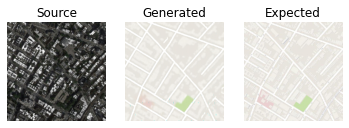

In [106]:
# plot all three images
plot_images(src_image, gen_image, tar_image)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


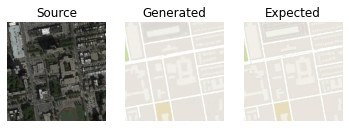

In [107]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
 
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]
 
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # show title
        pyplot.title(titles[i])
    pyplot.show()
# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_109600.h5')
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

In [114]:
def load_image(filename, size=(256,256)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)
    return pixels

In [122]:
# load source image
src_image = load_image('satellite.jpg')
print('Loaded', src_image.shape)

Loaded (1, 256, 256, 3)


In [123]:

# load model
model = load_model('model_109600.h5', compile = False)
# generate image from source
gen_image = model.predict(src_image)

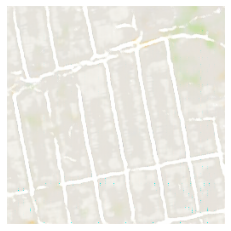

In [124]:
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()

Loaded (1, 256, 256, 3)


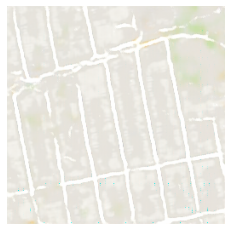

In [126]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot
 
# load an image
def load_image(filename, size=(256,256)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)
    return pixels
 
# load source image
src_image = load_image('satellite.jpg')
print('Loaded', src_image.shape)
# load model
model = load_model('model_109600.h5')
# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()


Google Maps to Satellite

In [113]:

# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    # return in reverse order
    return [X2, X1]